# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


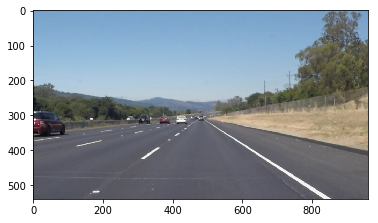

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [263]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            print('Points and Slope', x1, y1, x2, y2, ((y2-y1)/(x2-x1)) )

def sortPositiveSlopeLines(lines):
    lines_list = {}
    for line in lines:
        for x1,y1,x2,y2 in line:
            lines_list = [x1,y1,x2,y2]
   
def findX2GivenXYandSlope(x1, y1, y2, slope):
    x2 = x1 + (y2-y1)/slope
    return x2

def find_positive_line_end_points(lines, shape, slope_tolerance):
    x_max = 0
    y_max = 0
    x_min = shape[1]
    y_min = shape[0]
    aveSlope = 0
    slopeList = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            #check for the slope
            slope = (y2-y1)/(x2-x1)
            if (slope > 0):
                #print ('Tolerance Check', x_max, np.absolute(slope), np.absolute(np.average(slopeList)) )
                if (x_max == 0) or (((np.absolute(slope) < np.absolute(np.average(slopeList))+slope_tolerance) and (np.absolute(slope) > np.absolute(np.average(slopeList))-slope_tolerance))):
                    slopeList = np.append(slopeList, slope)

                    line_len = plt.mlab.dist(np.array([x1, y1]), np.array([x2, y2]))

                    if (line_len > 15):
                    
                        #print('Pos Points and Slope', x1, y1, x2, y2, slope, line_len )
                        if (x1 < x_min):
                            x_min = x1
                            y_min = y1

                        if (x2 < x_min):
                            x_min = x2
                            y_min = y2

                        if (x1 > x_max):
                            x_max = x1
                            y_max = y1

                        if (x2 > x_max):
                            x_max = x2
                            y_max = y2
    return x_min, y_min, x_max, y_max

def find_negative_line_end_points(lines, shape, slope_tolerance):
    x_max = 0
    y_max = 0
    x_min = shape[1]
    y_min = shape[0]
    aveSlope = 0
    slopeList = []
                                         
    for line in lines:
        for x1,y1,x2,y2 in line:
            #check for the slope
            slope = (y2-y1)/(x2-x1)
            if (slope < 0):
                #print ('Tolerance Check', x_max, np.absolute(slope), np.absolute(np.average(slopeList)) )
                if (x_max == 0) or (( (np.absolute(slope) < np.absolute(np.average(slopeList))+slope_tolerance) and (np.absolute(slope) > np.absolute(np.average(slopeList))-slope_tolerance))):
                    slopeList = np.append(slopeList, slope)
                    line_len = plt.mlab.dist(np.array([x1, y1]), np.array([x2, y2]))

                    if (line_len > 15):
                    
                        #print('Neg Points and Slope', x1, y1, x2, y2, slope, line_len )
                        if (x1 < x_min):
                            x_min = x1
                            y_min = y1

                        if (x2 < x_min):
                            x_min = x2
                            y_min = y2

                        if (x1 > x_max):
                            x_max = x1
                            y_max = y1

                        if (x2 > x_max):
                            x_max = x2
                            y_max = y2
    return x_min, y_min, x_max, y_max
              
def draw_lines_enh(img, lines, vertices, color=[255, 0, 0], thickness=10, slope_threshold=0.3):
    #Pos Slope
    pos_points = find_positive_line_end_points(lines, img.shape, .03)
    slope = ((pos_points[3]-pos_points[1])/(pos_points[2]-pos_points[0]))
    print('Pos Points', pos_points, (slope))
    if (np.abs(slope) > slope_threshold):

        #Draw positive line
        cv2.line(img, (pos_points[0], pos_points[1]), (pos_points[2]-1, pos_points[3]), color, thickness)
        #Draw missing lines
        bX1 = pos_points[0]
        bY1 = pos_points[1]
        bY2 = vertices[0][3][1]

        x2 = findX2GivenXYandSlope(bX1, bY1, bY2, slope)
        print('Found these for positive slope', bX1, bY1, x2, bY2, slope)
        cv2.line(img, (bX1, bY1), (int(x2), bY2), color, thickness)

        bX1 = pos_points[2]
        bY1 = pos_points[3]
        bY2 = vertices[0][2][1]
        x2 = findX2GivenXYandSlope(bX1, bY1, bY2, slope)
        print('Found these for positive slope', bX1, bY1, x2, bY2, slope)
        cv2.line(img, (bX1, bY1), (int(x2), bY2), color, thickness)
    
    neg_points = find_negative_line_end_points(lines, img.shape, .03)
    neg_slope = ((neg_points[3]-neg_points[1])/(neg_points[2]-neg_points[0]))
    print('Neg Points', neg_points, neg_slope)
    if (np.abs(neg_slope) > slope_threshold):
        cv2.line(img, (neg_points[0], neg_points[1]), (neg_points[2]-1, neg_points[3]), color, thickness)
        # Find the logic to extend the lines if they are not extended to the ends
        # Neg slope
        x1 = findX2GivenXYandSlope(neg_points[0], neg_points[1], vertices[0][0][1], ((neg_points[3]-neg_points[1])/(neg_points[2]-neg_points[0])))
        print ('Found these for neg slope', neg_points[0], neg_points[1], int(x1), vertices[0][0][1])
        cv2.line(img, (neg_points[0], neg_points[1]), (int(x1), vertices[0][0][1]), color, thickness)
        x1 = findX2GivenXYandSlope(neg_points[2], neg_points[3], vertices[0][1][1], ((neg_points[3]-neg_points[1])/(neg_points[2]-neg_points[0])))
        print ('Found these for neg slope', neg_points[2], neg_points[3], int(x1), vertices[0][1][1])
        cv2.line(img, (neg_points[2], neg_points[3]), (int(x1), vertices[0][1][1]), color, thickness)
    

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_enh(line_img, lines, vertices)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [252]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [253]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def processImageForHoughLines(image):

    gray_image = grayscale(image)
    #Now apply gaussian blur with kernel size = 5 on the gray image
    blur_gray = gaussian_blur(gray_image, 5)

    # Get Edges using Canny algo
    low_threshold = 50
    high_threshold = 150
    image_with_edge = canny(blur_gray, low_threshold, high_threshold)

    # Let us define the vertices for the region of interest to find the Lanes
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(400, 320), (550, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    image_with_masked_edges = region_of_interest(image_with_edge, vertices)
    

    # Let us get Hough lines applied on the image
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 2    # maximum gap in pixels between connectable line segments

    hough_lines_image = hough_lines(image_with_masked_edges, rho, theta, threshold, min_line_length, max_line_gap, vertices)

    # Let us draw the hough lines on the initial image
    combined_image = weighted_img(hough_lines_image, image)

    #plt.figure()
    #plt.imshow(blur_gray, cmap='gray')
    #plt.figure()
    #plt.imshow(image_with_edge, cmap='gray')
    #plt.figure()
    #plt.imshow(image_with_masked_edges, cmap='gray')
    #plt.figure()
    #plt.imshow(combined_image)
    
    return combined_image


Tolerance Check 0 0.625 nan
Pos Points and Slope 676 427 692 437 0.625 18.8679622641
Tolerance Check 692 0.613333333333 0.625
Pos Points and Slope 689 434 764 480 0.613333333333 87.9829528943
Tolerance Check 764 0.636363636364 0.619166666667
Tolerance Check 764 0.633333333333 0.624898989899
Pos Points and Slope 661 425 751 482 0.633333333333 106.531685427
Tolerance Check 764 0.647058823529 0.627007575758
Pos Points and Slope 561 355 578 366 0.647058823529 20.2484567313
Tolerance Check 764 0.6875 0.631017825312
Tolerance Check 764 0.7 0.631017825312
Tolerance Check 764 0.625 0.631017825312
Pos Points and Slope 558 358 574 368 0.625 18.8679622641
Tolerance Check 764 0.722222222222 0.630014854427
Tolerance Check 764 0.642857142857 0.630014854427
Pos Points and Slope 754 484 768 493 0.642857142857 16.6433169771
Tolerance Check 768 0.666666666667 0.63184946706
Tolerance Check 768 0.63829787234 0.63184946706
Pos Points and Slope 673 424 720 454 0.63829787234 55.7584074378
Tolerance Check 768

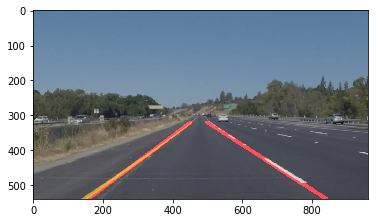

In [254]:
image = mpimg.imread('test_images/' +'solidYellowLeft.jpg')
processed_image = processImageForHoughLines(image)
print (processed_image.shape[0], processed_image.shape[1])
plt.figure()
plt.imshow(processed_image)

Tolerance Check 0 0.55 nan
Pos Points and Slope 709 433 769 466 0.55 68.4762732631
Tolerance Check 769 0.577049180328 0.55
Pos Points and Slope 534 340 839 516 0.577049180328 352.137757135
Tolerance Check 839 0.554502369668 0.563524590164
Pos Points and Slope 511 324 722 441 0.554502369668 241.267486413
Tolerance Check 839 0.575 0.560517183332
Pos Points and Slope 717 446 877 538 0.575 184.564351921
Tolerance Check 877 0.553113553114 0.564137887499
Pos Points and Slope 625 387 898 538 0.553113553114 311.977563296
Tolerance Check 898 0.6 0.561933020622
Tolerance Check 898 0.545454545455 0.561933020622
Tolerance Check 898 0.0833333333333 0.559186608094
Tolerance Check 898 0.588235294118 0.559186608094
Pos Points and Slope 526 336 543 346 0.588235294118 19.7230829233
Tolerance Check 898 0.548387096774 0.563336420383
Pos Points and Slope 528 333 559 350 0.548387096774 35.3553390593
Tolerance Check 898 0.571428571429 0.561467754932
Pos Points and Slope 840 518 875 538 0.571428571429 40.3112

Found these for positive slope 568 365 877.537572254 540 0.565359477124
Found these for positive slope 874 538 488.404624277 320 0.565359477124
Tolerance Check 0 0.725806451613 nan
Neg Points and Slope 332 414 456 324 -0.725806451613 153.218797802
Tolerance Check 456 0.759398496241 0.725806451613
Tolerance Check 456 0.723926380368 0.725806451613
Neg Points and Slope 159 538 322 420 -0.723926380368 201.228725584
Tolerance Check 456 0.733333333333 0.724866415991
Neg Points and Slope 368 393 458 327 -0.733333333333 111.606451426
Tolerance Check 458 0.734042553191 0.727688721771
Neg Points and Slope 342 413 436 344 -0.734042553191 116.606174794
Tolerance Check 458 0.753846153846 0.729277179626
Neg Points and Slope 179 538 244 489 -0.753846153846 81.4002456999
Tolerance Check 458 0.341463414634 0.73419097447
Tolerance Check 458 0.74 0.73419097447
Neg Points and Slope 293 442 343 405 -0.74 62.2012861603
Tolerance Check 458 0.5 0.735159145392
Tolerance Check 458 0.735849056604 0.735159145392


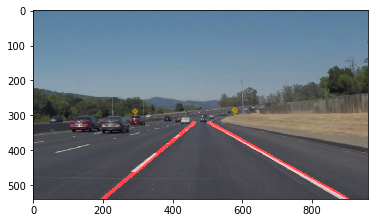

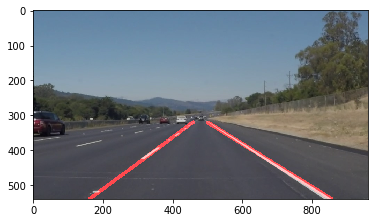

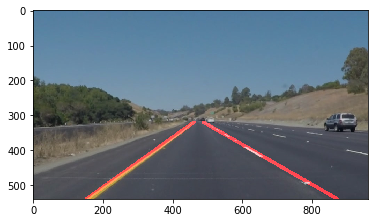

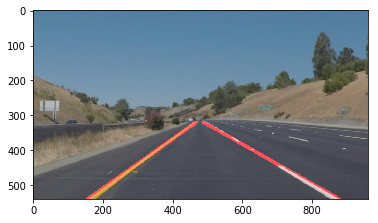

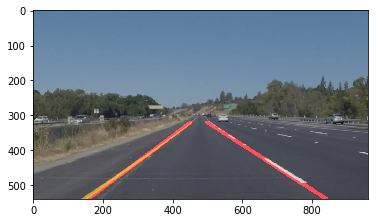

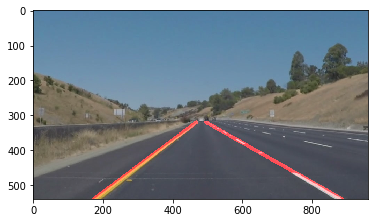

In [255]:
for imageFileName in os.listdir("test_images/"):
    image = mpimg.imread('test_images/' +imageFileName)
    processed_image = processImageForHoughLines(image)
    #save the image in test_output folder
    mpimg.imsave('test_images_output/' +imageFileName, processed_image)
    plt.figure()
    plt.imshow(processed_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [256]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [257]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = processImageForHoughLines(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [258]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Tolerance Check 0 0.600896860987 nan
Pos Points and Slope 507 320 730 454 0.600896860987 260.163410187
Tolerance Check 730 0.605095541401 0.600896860987
Pos Points and Slope 712 444 869 539 0.605095541401 183.50476833
Tolerance Check 869 0.624338624339 0.602996201194
Pos Points and Slope 502 320 691 438 0.624338624339 222.811579591
Tolerance Check 869 0.631147540984 0.610110342242
Pos Points and Slope 689 438 811 515 0.631147540984 144.26711337
Tolerance Check 869 0.625 0.615369641928
Pos Points and Slope 743 473 847 538 0.625 122.641754717
Tolerance Check 869 0.630952380952 0.617295713542
Pos Points and Slope 642 408 726 461 0.630952380952 99.3227063667
Tolerance Check 869 0.0666666666667 0.619571824777
Tolerance Check 869 0.609756097561 0.619571824777
Pos Points and Slope 828 513 869 538 0.609756097561 48.0208288142
Tolerance Check 869 0.631578947368 0.618169578032
Pos Points and Slope 587 372 606 384 0.631578947368 22.4722050542
Tolerance Check 869 0.636363636364 0.619845749199
Pos 

  0%|          | 0/222 [00:00<?, ?it/s]

Tolerance Check 0 0.600896860987 nan
Pos Points and Slope 507 320 730 454 0.600896860987 260.163410187
Tolerance Check 730 0.605095541401 0.600896860987
Pos Points and Slope 712 444 869 539 0.605095541401 183.50476833
Tolerance Check 869 0.624338624339 0.602996201194
Pos Points and Slope 502 320 691 438 0.624338624339 222.811579591
Tolerance Check 869 0.631147540984 0.610110342242
Pos Points and Slope 689 438 811 515 0.631147540984 144.26711337
Tolerance Check 869 0.625 0.615369641928
Pos Points and Slope 743 473 847 538 0.625 122.641754717
Tolerance Check 869 0.630952380952 0.617295713542
Pos Points and Slope 642 408 726 461 0.630952380952 99.3227063667
Tolerance Check 869 0.0666666666667 0.619571824777
Tolerance Check 869 0.609756097561 0.619571824777
Pos Points and Slope 828 513 869 538 0.609756097561 48.0208288142
Tolerance Check 869 0.631578947368 0.618169578032
Pos Points and Slope 587 372 606 384 0.631578947368 22.4722050542
Tolerance Check 869 0.636363636364 0.619845749199
Pos 

  3%|▎         | 7/222 [00:00<00:10, 21.43it/s]

 0.618437299539
Pos Points and Slope 718 457 847 538 0.627906976744 152.322027297
Tolerance Check 867 0.620689655172 0.62080471884
Pos Points and Slope 839 521 868 539 0.620689655172 34.1320963318
Tolerance Check 868 0.626506024096 0.620781706107
Pos Points and Slope 687 437 770 489 0.626506024096 97.9438614718
Tolerance Check 868 0.6 0.621735759105
Pos Points and Slope 831 529 846 538 0.6 17.4928556845
Pos Points (501, 320, 868, 539) 0.596730245232
Found these for positive slope 501 320 869.675799087 540 0.596730245232
Found these for positive slope 868 539 501.0 320 0.596730245232
Tolerance Check 0 0.777777777778 nan
Neg Points and Slope 189 524 225 496 -0.777777777778 45.607017004
Tolerance Check 225 0.724137931034 0.777777777778
Tolerance Check 225 0.75 0.777777777778
Neg Points and Slope 374 383 394 368 -0.75 25.0
Tolerance Check 394 0.705882352941 0.763888888889
Tolerance Check 394 0.714285714286 0.763888888889
Tolerance Check 394 0.695652173913 0.763888888889
Tolerance Check 394

  5%|▌         | 12/222 [00:00<00:11, 18.01it/s]

 0.71626984127
Tolerance Check 461 0.823529411765 0.713015873016
Tolerance Check 461 0.0666666666667 0.713015873016
Tolerance Check 461 0.735294117647 0.713015873016
Neg Points and Slope 327 417 361 392 -0.735294117647 42.201895692
Tolerance Check 461 0.666666666667 0.716728913788
Tolerance Check 461 0.6 0.716728913788
Neg Points (310, 423, 461, 320) -0.682119205298
Found thesefor neg slope 310 423 138 540
Found these for neg slope 461 320 461 320
Tolerance Check 0 0.599033816425 nan
Pos Points and Slope 659 414 866 538 0.599033816425 241.29857024
Tolerance Check 866 0.628 0.599033816425
Pos Points and Slope 591 379 841 536 0.628 295.210094678
Tolerance Check 866 0.62 0.613516908213
Pos Points and Slope 522 330 672 423 0.62 176.490792961
Tolerance Check 866 0.623076923077 0.615677938808
Pos Points and Slope 505 320 635 401 0.623076923077 153.169840373
Tolerance Check 866 0.62962962963 0.617527684876
Pos Points and Slope 508 326 616 394 0.62962962963 127.624449068
Tolerance Check 866 0.

  7%|▋         | 16/222 [00:00<00:12, 16.77it/s]

 69.1158447825
Tolerance Check 844 0.610169491525 0.63191804794
Pos Points and Slope 521 331 580 367 0.610169491525 69.1158447825
Tolerance Check 844 0.650684931507 0.628293288538
Pos Points and Slope 664 429 810 524 0.650684931507 174.186681466
Tolerance Check 844 0.617021276596 0.631492094676
Pos Points and Slope 808 509 855 538 0.617021276596 55.2268050859
Tolerance Check 855 0.611111111111 0.629683242416
Pos Points and Slope 505 320 523 331 0.611111111111 21.0950231097
Tolerance Check 855 0.631578947368 0.627619672271
Pos Points and Slope 670 425 708 449 0.631578947368 44.9444101085
Pos Points (499, 320, 855, 538) 0.612359550562
Found these for positive slope 499 320 858.266055046 540 0.612359550562
Found these for positive slope 855 538 499.0 320 0.612359550562
Tolerance Check 0 0.733333333333 nan
Neg Points and Slope 441 331 456 320 -0.733333333333 18.6010752377
Tolerance Check 456 0.725490196078 0.733333333333
Neg Points and Slope 163 538 265 464 -0.725490196078 126.015872016
To

  9%|▉         | 21/222 [00:01<00:10, 19.05it/s]


Tolerance Check 378 0.703703703704 0.678571428571
Neg Points and Slope 357 392 384 373 -0.703703703704 33.0151480384
Tolerance Check 384 0.714285714286 0.691137566138
Neg Points and Slope 437 331 451 321 -0.714285714286 17.2046505341
Tolerance Check 451 0.708333333333 0.69885361552
Neg Points and Slope 360 391 384 374 -0.708333333333 29.4108823397
Tolerance Check 451 0.655172413793 0.701223544974
Tolerance Check 451 0.666666666667 0.701223544974
Neg Points (350, 391, 451, 321) -0.693069306931
Found thesefor neg slope 350 391 135 540
Found these for neg slope 451 321 452 320
Tolerance Check 0 0.625730994152 nan
Pos Points and Slope 514 324 856 538 0.625730994152 403.435248832
Tolerance Check 856 0.651960784314 0.625730994152
Pos Points and Slope 502 320 706 453 0.651960784314 243.526179291
Tolerance Check 856 0.652631578947 0.638845889233
Pos Points and Slope 739 476 834 538 0.652631578947 113.441614939
Tolerance Check 856 0.654929577465 0.643441119138
Pos Points and Slope 668 429 810 

 11%|█▏        | 25/222 [00:01<00:10, 18.35it/s]

 77.6981338257
Tolerance Check 854 0.626506024096 0.636507512096
Pos Points and Slope 529 336 612 388 0.626506024096 97.9438614718
Tolerance Check 854 0.625 0.634507214496
Pos Points and Slope 506 320 522 330 0.625 18.8679622641
Tolerance Check 854 0.636363636364 0.632922678747
Pos Points and Slope 810 524 832 538 0.636363636364 26.0768096208
Tolerance Check 854 0.631578947368 0.63341424412
Pos Points and Slope 617 391 636 403 0.631578947368 22.4722050542
Tolerance Check 854 0.626086956522 0.633184832026
Pos Points and Slope 657 416 772 488 0.626086956522 135.679770047
Pos Points (499, 320, 854, 538) 0.614084507042
Found these for positive slope 499 320 857.256880734 540 0.614084507042
Found these for positive slope 854 538 499.0 320 0.614084507042
Tolerance Check 0 0.723076923077 nan
Neg Points and Slope 276 456 341 409 -0.723076923077 80.2122185206
Tolerance Check 341 0.705882352941 0.723076923077
Neg Points and Slope 264 456 332 408 -0.705882352941 83.2346081867
Tolerance Check 341 

 13%|█▎        | 29/222 [00:01<00:10, 18.60it/s]

0.735297563261
Tolerance Check 261 0.6875 0.735297563261
Neg Points (164, 539, 261, 468) -0.731958762887
Found thesefor neg slope 164 539 162 540
Found these for neg slope 261 468 463 320
Tolerance Check 0 0.621722846442 nan
Pos Points and Slope 589 372 856 538 0.621722846442 314.396246797
Tolerance Check 856 0.652173913043 0.621722846442
Tolerance Check 856 0.652542372881 0.621722846442
Tolerance Check 856 0.623853211009 0.621722846442
Pos Points and Slope 535 339 644 407 0.623853211009 128.471786786
Tolerance Check 856 0.651162790698 0.622788028726
Pos Points and Slope 747 482 833 538 0.651162790698 102.625532885
Tolerance Check 856 0.617647058824 0.632246282716
Pos Points and Slope 506 320 540 341 0.617647058824 39.9624824054
Tolerance Check 856 0.6 0.628596476743
Pos Points and Slope 507 320 527 332 0.6 23.3238075794
Tolerance Check 856 0.625592417062 0.622877181394
Pos Points and Slope 643 406 854 538 0.625592417062 248.887524798
Tolerance Check 856 0.619047619048 0.623329720672
P

 16%|█▌        | 35/222 [00:01<00:09, 20.16it/s]

Tolerance Check 858 0.651376146789 0.631207003483
Pos Points and Slope 550 352 659 423 0.651376146789 130.084587865
Pos Points (502, 320, 858, 538) 0.612359550562
Found these for positive slope 502 320 861.266055046 540 0.612359550562
Found these for positive slope 858 538 502.0 320 0.612359550562
Tolerance Check 0 0.75 nan
Neg Points and Slope 347 404 371 386 -0.75 30.0
Tolerance Check 371 0.727272727273 0.75
Tolerance Check 371 0.675675675676 0.738636363636
Tolerance Check 371 0.789473684211 0.738636363636
Tolerance Check 371 0.666666666667 0.738636363636
Tolerance Check 371 0.727272727273 0.738636363636
Tolerance Check 371 0.0454545454545 0.734848484848
Tolerance Check 371 0.681818181818 0.734848484848
Tolerance Check 371 0.666666666667 0.734848484848
Neg Points (347, 404, 371, 386) -0.75
Found thesefor neg slope 347 404 165 540
Found these for neg slope 371 386 459 320
Tolerance Check 0 0.652582159624 nan
Pos Points and Slope 503 320 716 459 0.652582159624 254.342289052
Tolerance C

 18%|█▊        | 40/222 [00:02<00:10, 17.88it/s]

549 347 0.627906976744 50.7740090991
Tolerance Check 854 0.647058823529 0.639094038176
Pos Points and Slope 532 341 566 363 0.647058823529 40.4969134626
Tolerance Check 854 0.636363636364 0.640231864655
Pos Points and Slope 821 517 854 538 0.636363636364 39.1152144312
Pos Points (501, 320, 854, 539) 0.620396600567
Found these for positive slope 501 320 855.611872146 540 0.620396600567
Found these for positive slope 854 539 501.0 320 0.620396600567
Tolerance Check 0 0.771428571429 nan
Neg Points and Slope 265 466 300 439 -0.771428571429 44.2040722106
Tolerance Check 300 0.698795180723 0.771428571429
Tolerance Check 300 0.75 0.771428571429
Tolerance Check 300 0.666666666667 0.760714285714
Tolerance Check 300 0.75 0.760714285714
Neg Points and Slope 284 452 328 419 -0.75 55.0
Tolerance Check 328 0.782608695652 0.757142857143
Neg Points and Slope 250 477 273 459 -0.782608695652 29.206163733
Tolerance Check 328 0.818181818182 0.76350931677
Tolerance Check 328 0.05 0.76350931677
Tolerance Ch

 20%|█▉        | 44/222 [00:02<00:09, 18.75it/s]

 539 0.626016260163 290.227496974
Tolerance Check 855 0.654411764706 0.638878776847
Pos Points and Slope 599 384 735 473 0.654411764706 162.533073557
Tolerance Check 855 0.625874125874 0.644056439467
Pos Points and Slope 569 359 855 538 0.625874125874 337.39739181
Tolerance Check 855 0.627450980392 0.639510861069
Pos Points and Slope 503 320 554 352 0.627450980392 60.207972894
Tolerance Check 855 0.658823529412 0.637098884933
Pos Points and Slope 562 359 647 415 0.658823529412 101.788997441
Tolerance Check 855 0.632352941176 0.640719659013
Pos Points and Slope 509 320 577 363 0.632352941176 80.454956342
Tolerance Check 855 0.650485436893 0.639524413608
Pos Points and Slope 730 471 833 538 0.650485436893 122.87391912
Tolerance Check 855 0.647058823529 0.640894541519
Pos Points and Slope 549 350 583 372 0.647058823529 40.4969134626
Tolerance Check 855 0.631578947368 0.641579461742
Pos Points and Slope 510 320 548 344 0.631578947368 44.9444101085
Tolerance Check 855 0.625 0.640579410305
P

 22%|██▏       | 48/222 [00:02<00:09, 18.89it/s]

 0.656635705583
Pos Points and Slope 511 325 525 334 0.642857142857 16.6433169771
Tolerance Check 853 0.666666666667 0.655104754169
Pos Points and Slope 524 332 578 368 0.666666666667 64.8999229584
Tolerance Check 853 0.638888888889 0.656260945419
Pos Points and Slope 517 324 553 347 0.638888888889 42.7200187266
Pos Points (505, 320, 853, 539) 0.629310344828
Found these for positive slope 505 320 854.589041096 540 0.629310344828
Found these for positive slope 853 539 505.0 320 0.629310344828
Tolerance Check 0 0.673913043478 nan
Neg Points and Slope 313 418 359 387 -0.673913043478 55.4707129934
Tolerance Check 359 0.780487804878 0.673913043478
Tolerance Check 359 0.571428571429 0.673913043478
Tolerance Check 359 0.782608695652 0.673913043478
Tolerance Check 359 0.7 0.673913043478
Tolerance Check 359 0.7 0.686956521739
Tolerance Check 359 0.666666666667 0.691304347826
Neg Points and Slope 330 406 357 388 -0.666666666667 32.4499614792
Tolerance Check 359 0.684210526316 0.685144927536
Neg 

 24%|██▍       | 54/222 [00:02<00:08, 20.69it/s]

 539 0.673151750973 309.803163315
Tolerance Check 831 0.624113475177 0.673007102252
Tolerance Check 831 0.645161290323 0.673007102252
Pos Points and Slope 502 320 533 340 0.645161290323 36.8917334914
Pos Points (502, 320, 831, 539) 0.665653495441
Found these for positive slope 502 320 832.502283105 540 0.665653495441
Found these for positive slope 831 539 502.0 320 0.665653495441
Tolerance Check 0 0.728260869565 nan
Neg Points and Slope 160 538 252 471 -0.728260869565 113.811247247
Tolerance Check 252 0.703703703704 0.728260869565
Neg Points and Slope 200 496 254 458 -0.703703703704 66.0302960769
Tolerance Check 254 0.684210526316 0.715982286634
Tolerance Check 254 0.722222222222 0.715982286634
Neg Points and Slope 378 376 396 363 -0.722222222222 22.2036033112
Tolerance Check 396 0.704918032787 0.718062265164
Neg Points and Slope 194 501 255 458 -0.704918032787 74.6324326282
Tolerance Check 396 0.705882352941 0.71477620707
Neg Points and Slope 380 376 397 364 -0.705882352941 20.8086520

 27%|██▋       | 60/222 [00:03<00:07, 20.66it/s]

Tolerance Check 852 0.625 0.626608767577
Pos Points and Slope 703 454 735 474 0.625 37.7359245282
Tolerance Check 852 0.659574468085 0.626206575682
Tolerance Check 852 0.62962962963 0.626206575682
Pos Points and Slope 762 493 789 510 0.62962962963 31.9061122671
Tolerance Check 852 0.666666666667 0.626891186472
Tolerance Check 852 0.545454545455 0.626891186472
Tolerance Check 852 0.657534246575 0.626891186472
Tolerance Check 852 0.612903225806 0.626891186472
Pos Points and Slope 602 381 633 400 0.612903225806 36.3593179254
Tolerance Check 852 0.634146341463 0.624559859694
Pos Points and Slope 811 513 852 539 0.634146341463 48.5489443758
Tolerance Check 852 0.583333333333 0.62592935709
Pos Points (552, 350, 852, 538) 0.626666666667
Found these for positive slope 552 350 855.191489362 540 0.626666666667
Found these for positive slope 852 538 504.127659574 320 0.626666666667
Tolerance Check 0 0.666666666667 nan
Neg Points and Slope 323 409 362 383 -0.666666666667 46.872166581
Tolerance Che

 30%|██▉       | 66/222 [00:03<00:08, 19.15it/s]

 132.879644792
Tolerance Check 303 0.679012345679 0.697247706422
Neg Points and Slope 213 484 294 429 -0.679012345679 97.9081201944
Tolerance Check 303 0.692307692308 0.688130026051
Neg Points and Slope 273 444 286 435 -0.692307692308 15.8113883008
Tolerance Check 303 0.711111111111 0.68952258147
Neg Points and Slope 197 507 242 475 -0.711111111111 55.2177507691
Tolerance Check 303 0.666666666667 0.69491971388
Neg Points and Slope 385 368 400 358 -0.666666666667 18.0277563773
Tolerance Check 400 0.666666666667 0.689269104437
Tolerance Check 400 0.625 0.685502031476
Tolerance Check 400 0.7 0.685502031476
Tolerance Check 400 0.642857142857 0.687573169836
Tolerance Check 400 0.722222222222 0.687573169836
Tolerance Check 400 0.68 0.687573169836
Neg Points and Slope 240 466 265 449 -0.68 30.2324329157
Tolerance Check 400 0.708333333333 0.686626523607
Neg Points and Slope 253 467 277 450 -0.708333333333 29.4108823397
Tolerance Check 400 0.666666666667 0.689038391354
Neg Points and Slope 212 

 32%|███▏      | 70/222 [00:03<00:08, 18.47it/s]

823 538 0.674922600619 389.683204668
Tolerance Check 823 0.650273224044 0.674922600619
Pos Points and Slope 508 322 691 441 0.650273224044 218.288799529
Tolerance Check 823 0.646017699115 0.662597912331
Pos Points and Slope 732 465 845 538 0.646017699115 134.528807324
Tolerance Check 845 0.644295302013 0.657071174593
Pos Points and Slope 695 442 844 538 0.644295302013 177.248413251
Tolerance Check 845 0.672897196262 0.653877206448
Pos Points and Slope 607 393 714 465 0.672897196262 128.96898852
Tolerance Check 845 0.644736842105 0.657681204411
Pos Points and Slope 584 371 736 469 0.644736842105 180.853531898
Tolerance Check 845 0.685714285714 0.655523810693
Pos Points (500, 320, 845, 538) 0.631884057971
Found these for positive slope 500 320 848.165137615 540 0.631884057971
Found these for positive slope 845 538 500.0 320 0.631884057971
Tolerance Check 0 0.65625 nan
Neg Points and Slope 341 400 373 379 -0.65625 38.275318418
Tolerance Check 373 0.652173913043 0.65625
Neg Points and Slop

 33%|███▎      | 74/222 [00:03<00:09, 16.29it/s]

 0.66073220046
Pos Points and Slope 509 323 635 405 0.650793650794 150.332963784
Tolerance Check 833 0.673913043478 0.657419350571
Pos Points and Slope 540 347 678 440 0.673913043478 166.41213898
Tolerance Check 833 0.650602409639 0.661542773798
Pos Points and Slope 523 333 606 387 0.650602409639 99.0201999594
Tolerance Check 833 0.652173913043 0.659354700966
Pos Points and Slope 499 320 522 335 0.652173913043 27.4590604355
Tolerance Check 833 0.666666666667 0.658157902979
Pos Points and Slope 802 511 844 539 0.666666666667 50.4777178565
Tolerance Check 844 0.659090909091 0.659373440649
Pos Points and Slope 608 387 652 416 0.659090909091 52.697248505
Tolerance Check 844 0.652173913043 0.659338124204
Pos Points and Slope 821 523 844 538 0.652173913043 27.4590604355
Pos Points (499, 320, 844, 539) 0.634782608696
Found these for positive slope 499 320 845.575342466 540 0.634782608696
Found these for positive slope 844 539 499.0 320 0.634782608696
Tolerance Check 0 0.666666666667 nan
Toler

 34%|███▍      | 76/222 [00:04<00:09, 15.84it/s]

Tolerance Check 0 0.674418604651 nan
Pos Points and Slope 519 335 820 538 0.674418604651 363.056469437
Tolerance Check 820 0.65 0.674418604651
Pos Points and Slope 518 330 698 447 0.65 214.683487954
Tolerance Check 820 0.636363636364 0.662209302326
Tolerance Check 820 0.647798742138 0.653594080338
Pos Points and Slope 617 394 776 497 0.647798742138 189.446562386
Tolerance Check 820 0.645161290323 0.652145245788
Pos Points and Slope 686 438 841 538 0.645161290323 184.458667457
Tolerance Check 841 0.660714285714 0.650748454695
Pos Points and Slope 515 332 571 369 0.660714285714 67.1192967782
Tolerance Check 841 0.5 0.652409426532
Tolerance Check 841 0.111111111111 0.652409426532
Tolerance Check 841 0.65625 0.652409426532
Pos Points and Slope 592 379 624 400 0.65625 38.275318418
Tolerance Check 841 0.6 0.652958079884
Tolerance Check 841 0.673076923077 0.652958079884
Pos Points and Slope 549 355 757 495 0.673076923077 250.726943107
Tolerance Check 841 0.6 0.655472935283
Tolerance Check 841

 36%|███▌      | 80/222 [00:04<00:08, 15.87it/s]

 0.662242268041
Pos Points and Slope 752 482 839 538 0.64367816092 103.464969917
Tolerance Check 839 0.678571428571 0.656054232334
Pos Points and Slope 524 338 664 433 0.678571428571 169.189243157
Tolerance Check 839 0.675675675676 0.661683531393
Pos Points and Slope 499 320 536 345 0.675675675676 44.6542271235
Tolerance Check 839 0.64 0.66448196025
Pos Points and Slope 530 338 580 370 0.64 59.3632883186
Tolerance Check 839 0.65 0.660401633542
Pos Points and Slope 505 320 525 333 0.65 23.8537208838
Tolerance Check 839 0.631578947368 0.658915685893
Pos Points and Slope 520 331 539 343 0.631578947368 22.4722050542
Tolerance Check 839 0.68 0.655498593577
Pos Points and Slope 692 454 817 539 0.68 151.162164578
Tolerance Check 839 0.666666666667 0.658220972069
Pos Points and Slope 517 333 568 367 0.666666666667 61.2943716829
Tolerance Check 839 0.714285714286 0.659065541528
Tolerance Check 839 0.666666666667 0.659065541528
Pos Points and Slope 611 398 665 434 0.666666666667 64.8999229584
Po

 38%|███▊      | 84/222 [00:04<00:08, 16.89it/s]

515 331 813.427884615 540 0.700336700337
Found these for positive slope 812 539 499.293269231 320 0.700336700337
Tolerance Check 0 0.681818181818 nan
Neg Points and Slope 300 426 344 396 -0.681818181818 53.2541078228
Tolerance Check 344 0.648148148148 0.681818181818
Tolerance Check 344 0.695652173913 0.681818181818
Neg Points and Slope 321 413 344 397 -0.695652173913 28.0178514522
Tolerance Check 344 0.666666666667 0.688735177866
Tolerance Check 344 0.636363636364 0.681379007466
Tolerance Check 344 0.652173913043 0.681379007466
Neg Points and Slope 282 430 305 415 -0.652173913043 27.4590604355
Tolerance Check 344 0.647058823529 0.67407773386
Neg Points and Slope 302 425 319 414 -0.647058823529 20.2484567313
Tolerance Check 344 0.645161290323 0.668673951794
Neg Points and Slope 309 414 340 394 -0.645161290323 36.8917334914
Tolerance Check 344 0.666666666667 0.664755174882
Tolerance Check 344 0.611111111111 0.665028245137
Neg Points (282, 430, 344, 396) -0.548387096774
Found thesefor neg

 40%|███▉      | 88/222 [00:04<00:08, 14.98it/s]

811 538 0.700680272109 358.987464962
Tolerance Check 811 0.672839506173 0.700680272109
Pos Points and Slope 526 335 688 444 0.672839506173 195.256241898
Tolerance Check 811 0.671755725191 0.686759889141
Pos Points and Slope 701 451 832 539 0.671755725191 157.813180692
Tolerance Check 832 0.695652173913 0.681758501158
Pos Points and Slope 552 358 575 374 0.695652173913 28.0178514522
Tolerance Check 832 0.702586206897 0.685231919346
Pos Points and Slope 578 376 810 539 0.702586206897 283.536593758
Tolerance Check 832 0.685185185185 0.688702776856
Pos Points and Slope 675 434 729 471 0.685185185185 65.4599113962
Tolerance Check 832 0.682926829268 0.688116511578
Pos Points and Slope 661 425 702 453 0.682926829268 49.6487663492
Tolerance Check 832 0.1 0.687375128391
Tolerance Check 832 0.671875 0.687375128391
Pos Points and Slope 554 355 618 398 0.671875 77.1038261048
Tolerance Check 832 0.666666666667 0.685437612342
Pos Points and Slope 525 334 552 352 0.666666666667 32.4499614792
Toleranc

 42%|████▏     | 94/222 [00:05<00:07, 16.75it/s]

 0.678125
Tolerance Check 0 0.615384615385 nan
Neg Points and Slope 448 328 461 320 -0.615384615385 15.2643375225
Tolerance Check 461 0.652173913043 0.615384615385
Tolerance Check 461 0.653846153846 0.615384615385
Tolerance Check 461 0.666666666667 0.615384615385
Tolerance Check 461 0.692307692308 0.615384615385
Tolerance Check 461 0.666666666667 0.615384615385
Tolerance Check 461 0.636363636364 0.615384615385
Tolerance Check 461 0.142857142857 0.625874125874
Tolerance Check 461 0.636363636364 0.625874125874
Neg Points (448, 328, 461, 320) -0.615384615385
Found thesefor neg slope 448 328 103 540
Found these for neg slope 461 320 461 320
Tolerance Check 0 0.703488372093 nan
Pos Points and Slope 637 418 809 539 0.703488372093 210.297408448
Tolerance Check 809 0.683333333333 0.703488372093
Pos Points and Slope 530 337 590 378 0.683333333333 72.6704891961
Tolerance Check 809 0.651851851852 0.693410852713
Tolerance Check 809 0.702380952381 0.693410852713
Pos Points and Slope 557 361 809 538

 43%|████▎     | 96/222 [00:05<00:07, 17.40it/s]

Tolerance Check 0 0.723076923077 nan
Pos Points and Slope 506 321 701 462 0.723076923077 240.636655562
Tolerance Check 701 0.669491525424 0.723076923077
Tolerance Check 701 0.698113207547 0.723076923077
Pos Points and Slope 509 320 668 431 0.698113207547 193.912351334
Tolerance Check 701 0.691358024691 0.710595065312
Pos Points and Slope 629 403 710 459 0.691358024691 98.4733466477
Tolerance Check 710 0.719101123596 0.704182718438
Pos Points and Slope 697 458 786 522 0.719101123596 109.622078068
Tolerance Check 786 0.722222222222 0.707912319728
Pos Points and Slope 504 320 522 333 0.722222222222 22.2036033112
Tolerance Check 786 0.725352112676 0.710774300227
Pos Points and Slope 533 341 675 444 0.725352112676 175.422347493
Tolerance Check 786 0.833333333333 0.713203935635
Tolerance Check 786 0.678571428571 0.713203935635
Tolerance Check 786 0.688888888889 0.713203935635
Pos Points and Slope 706 455 751 486 0.688888888889 54.6443043693
Tolerance Check 786 0.615384615385 0.709730357528
T

 45%|████▌     | 100/222 [00:05<00:07, 16.64it/s]

 35.2278299076
Tolerance Check 305 0.647058823529 0.667327716232
Neg Points and Slope 236 472 270 450 -0.647058823529 40.4969134626
Neg Points (202, 495, 305, 425) -0.679611650485
Found thesefor neg slope 202 495 135 540
Found these for neg slope 305 425 459 320
Tolerance Check 0 0.724528301887 nan
Pos Points and Slope 521 329 786 521 0.724528301887 327.244556868
Tolerance Check 786 0.675 0.724528301887
Tolerance Check 786 0.723300970874 0.724528301887
Pos Points and Slope 507 320 713 469 0.723300970874 254.2380774
Tolerance Check 786 0.679245283019 0.72391463638
Tolerance Check 786 0.727272727273 0.72391463638
Pos Points and Slope 723 475 811 539 0.727272727273 108.81176407
Tolerance Check 811 0.675 0.725034000011
Tolerance Check 811 0.769230769231 0.725034000011
Tolerance Check 811 0.6875 0.725034000011
Tolerance Check 811 0.686274509804 0.725034000011
Pos Points (507, 320, 811, 539) 0.720394736842
Found these for positive slope 507 320 812.388127854 540 0.720394736842
Found these fo

 47%|████▋     | 105/222 [00:05<00:06, 18.92it/s]

383 374 494 320
Tolerance Check 0 0.676691729323 nan
Pos Points and Slope 566 359 832 539 0.676691729323 321.179077774
Tolerance Check 832 0.719298245614 0.676691729323
Tolerance Check 832 0.676470588235 0.676691729323
Pos Points and Slope 510 320 578 366 0.676470588235 82.0975030071
Tolerance Check 832 0.719298245614 0.676581158779
Tolerance Check 832 0.721893491124 0.676581158779
Tolerance Check 832 0.694444444444 0.676581158779
Pos Points and Slope 776 513 812 538 0.694444444444 43.8292140016
Tolerance Check 832 0.733333333333 0.682535587334
Tolerance Check 832 0.692307692308 0.682535587334
Pos Points and Slope 818 528 831 537 0.692307692308 15.8113883008
Tolerance Check 832 0.653846153846 0.684978613578
Tolerance Check 832 0.714285714286 0.684978613578
Pos Points and Slope 773 510 787 520 0.714285714286 17.2046505341
Tolerance Check 832 0.681818181818 0.690840033719
Pos Points and Slope 769 495 813 525 0.681818181818 53.2541078228
Tolerance Check 832 0.736842105263 0.689336391736
T

 49%|████▉     | 109/222 [00:05<00:06, 17.47it/s]

 0.692307692308 0.624018838305
Tolerance Check 346 0.631578947368 0.624018838305
Neg Points and Slope 293 430 312 418 -0.631578947368 22.4722050542
Neg Points (292, 430, 346, 395) -0.648148148148
Found thesefor neg slope 292 430 122 540
Found these for neg slope 346 395 461 320
Tolerance Check 0 0.672354948805 nan
Pos Points and Slope 511 320 804 517 0.672354948805 353.069398277
Tolerance Check 804 0.700892857143 0.672354948805
Pos Points and Slope 593 381 817 538 0.700892857143 273.541587332
Tolerance Check 817 0.673469387755 0.686623902974
Pos Points and Slope 531 332 580 365 0.673469387755 59.076221951
Tolerance Check 817 0.702702702703 0.682239064568
Pos Points and Slope 507 320 655 424 0.702702702703 180.886704874
Tolerance Check 817 0.702702702703 0.687354974102
Pos Points and Slope 800 513 837 539 0.702702702703 45.2216762184
Tolerance Check 837 0.672 0.690424519822
Pos Points and Slope 592 375 717 459 0.672 150.602124819
Tolerance Check 837 0.685185185185 0.687353766518
Pos Poi

 51%|█████     | 113/222 [00:06<00:06, 17.08it/s]

 837 0.702857142857 0.687429138322
Pos Points and Slope 642 416 817 539 0.702857142857 213.901846649
Tolerance Check 837 0.675925925926 0.6925718065
Pos Points and Slope 603 382 711 455 0.675925925926 130.357201566
Tolerance Check 837 0.672131147541 0.688410336357
Pos Points and Slope 715 456 837 538 0.672131147541 146.9965986
Tolerance Check 837 0.677419354839 0.685154498594
Pos Points and Slope 510 320 541 341 0.677419354839 37.4432904537
Tolerance Check 837 0.709677419355 0.683865307968
Pos Points and Slope 508 322 539 344 0.709677419355 38.0131556175
Tolerance Check 837 0.698630136986 0.687552752452
Pos Points and Slope 546 347 619 398 0.698630136986 89.0505474436
Tolerance Check 837 0.666666666667 0.688937425518
Pos Points (508, 322, 837, 539) 0.659574468085
Found these for positive slope 508 322 838.516129032 540 0.659574468085
Found these for positive slope 837 539 504.967741935 320 0.659574468085
Tolerance Check 0 0.695652173913 nan
Neg Points and Slope 152 538 267 458 -0.69565

 53%|█████▎    | 117/222 [00:06<00:06, 17.32it/s]

0.676470588235 41.0487515035
Pos Points (506, 320, 844, 538) 0.644970414201
Found these for positive slope 506 320 847.100917431 540 0.644970414201
Found these for positive slope 844 538 506.0 320 0.644970414201
Tolerance Check 0 0.666666666667 nan
Neg Points and Slope 343 395 373 375 -0.666666666667 36.0555127546
Tolerance Check 373 0.65625 0.666666666667
Neg Points and Slope 347 398 379 377 -0.65625 38.275318418
Tolerance Check 379 0.677419354839 0.661458333333
Neg Points and Slope 343 396 374 375 -0.677419354839 37.4432904537
Tolerance Check 379 0.692307692308 0.666778673835
Neg Points and Slope 444 329 457 320 -0.692307692308 15.8113883008
Tolerance Check 457 0.615384615385 0.673160928453
Tolerance Check 457 0.666666666667 0.673160928453
Neg Points and Slope 363 387 378 377 -0.666666666667 18.0277563773
Tolerance Check 457 0.0666666666667 0.671862076096
Tolerance Check 457 0.714285714286 0.671862076096
Neg Points (343, 395, 457, 320) -0.657894736842
Found thesefor neg slope 343 395

 56%|█████▌    | 124/222 [00:06<00:05, 17.17it/s]

 418 337 399 -0.678571428571 33.8378486314
Tolerance Check 343 0.678571428571 0.680664362519
Neg Points and Slope 314 421 342 402 -0.678571428571 33.8378486314
Tolerance Check 343 0.666666666667 0.68024577573
Neg Points and Slope 282 444 312 424 -0.666666666667 36.0555127546
Tolerance Check 343 0.689655172414 0.677982590886
Neg Points and Slope 274 441 303 421 -0.689655172414 35.2278299076
Tolerance Check 343 0.666666666667 0.679650102533
Neg Points (274, 442, 343, 402) -0.579710144928
Found thesefor neg slope 274 442 104 540
Found these for neg slope 343 402 484 320
Tolerance Check 0 0.676470588235 nan
Pos Points and Slope 530 333 564 356 0.676470588235 41.0487515035
Tolerance Check 564 0.633333333333 0.676470588235
Tolerance Check 564 0.677725118483 0.676470588235
Pos Points and Slope 616 395 827 538 0.677725118483 254.892134049
Tolerance Check 827 0.612903225806 0.677097853359
Tolerance Check 827 0.617647058824 0.677097853359
Tolerance Check 827 0.6 0.677097853359
Tolerance Check 82

 57%|█████▋    | 127/222 [00:06<00:04, 19.23it/s]

Tolerance Check 0 0.628099173554 nan
Pos Points and Slope 544 343 786 495 0.628099173554 285.776136163
Tolerance Check 786 0.671296296296 0.628099173554
Tolerance Check 786 0.671755725191 0.628099173554
Tolerance Check 786 0.626213592233 0.628099173554
Pos Points and Slope 508 320 714 449 0.626213592233 243.057606341
Tolerance Check 786 0.666666666667 0.627156382893
Tolerance Check 786 0.627586206897 0.627156382893
Pos Points and Slope 709 447 854 538 0.627586206897 171.189952976
Tolerance Check 854 0.615384615385 0.627299657561
Pos Points and Slope 502 320 515 328 0.615384615385 15.2643375225
Tolerance Check 854 0.620689655172 0.624320897017
Pos Points and Slope 509 320 538 338 0.620689655172 34.1320963318
Tolerance Check 854 0.672727272727 0.623594648648
Pos Points (502, 320, 854, 538) 0.619318181818
Found these for positive slope 502 320 857.229357798 540 0.619318181818
Found these for positive slope 854 538 502.0 320 0.619318181818
Tolerance Check 0 0.733333333333 nan
Neg Points an

 60%|█████▉    | 133/222 [00:07<00:04, 20.43it/s]

 320 417 363 388 -0.674418604651 51.8652099196
Tolerance Check 363 0.7 0.674418604651
Neg Points and Slope 328 418 368 390 -0.7 48.8262224629
Tolerance Check 368 0.666666666667 0.687209302326
Tolerance Check 368 0.666666666667 0.680361757106
Neg Points and Slope 345 399 360 389 -0.666666666667 18.0277563773
Tolerance Check 368 0.666666666667 0.676937984496
Neg Points and Slope 323 415 356 393 -0.666666666667 39.6610640301
Tolerance Check 368 0.705882352941 0.67488372093
Neg Points (320, 417, 368, 390) -0.5625
Found thesefor neg slope 320 417 101 540
Found these for neg slope 368 390 492 320
Tolerance Check 0 0.649681528662 nan
Pos Points and Slope 502 320 816 524 0.649681528662 374.448928427
Tolerance Check 816 0.622222222222 0.649681528662
Pos Points and Slope 507 320 777 488 0.622222222222 318.0
Tolerance Check 816 0.654929577465 0.635951875442
Pos Points and Slope 695 446 837 539 0.654929577465 169.743924781
Tolerance Check 837 0.638888888889 0.642277776116
Pos Points and Slope 764 

 62%|██████▏   | 138/222 [00:07<00:04, 17.72it/s]

Pos Points and Slope 504 320 544 345 0.625 47.1699056603
Tolerance Check 844 0.625 0.631709270187
Pos Points and Slope 578 364 650 409 0.625 84.9058301885
Tolerance Check 844 0.613636363636 0.630367416149
Pos Points and Slope 509 320 553 347 0.613636363636 51.6236379966
Tolerance Check 844 0.63829787234 0.627578907397
Pos Points and Slope 542 345 589 375 0.63829787234 55.7584074378
Tolerance Check 844 0.641025641026 0.629110188103
Pos Points and Slope 821 514 860 539 0.641025641026 46.3249392876
Tolerance Check 860 0.607142857143 0.630599619719
Pos Points and Slope 510 320 538 337 0.607142857143 32.7566787083
Tolerance Check 860 0.651685393258 0.627993312766
Pos Points and Slope 731 469 820 527 0.651685393258 106.230880633
Tolerance Check 860 0.642857142857 0.630362520815
Pos Points and Slope 846 529 860 538 0.642857142857 16.6433169771
Tolerance Check 860 0.632653061224 0.631498395546
Pos Points and Slope 599 382 648 413 0.632653061224 57.9827560573
Pos Points (503, 320, 860, 539) 0.6

 64%|██████▍   | 142/222 [00:07<00:04, 17.67it/s]

 557 348 0.608695652174 53.8516480713
Tolerance Check 863 0.615384615385 0.627084380616
Pos Points and Slope 774 495 826 527 0.615384615385 61.0573500899
Tolerance Check 863 0.636363636364 0.625134419744
Pos Points and Slope 626 399 681 434 0.636363636364 65.192024052
Tolerance Check 863 0.615384615385 0.626738593547
Pos Points and Slope 746 477 798 509 0.615384615385 61.0573500899
Tolerance Check 863 0.6 0.625319346276
Pos Points and Slope 818 523 843 538 0.6 29.1547594742
Tolerance Check 863 0.620689655172 0.622506085579
Pos Points and Slope 707 442 823 514 0.620689655172 136.528385327
Tolerance Check 863 0.617021276596 0.622324442538
Pos Points and Slope 659 421 706 450 0.617021276596 55.2268050859
Tolerance Check 863 0.642857142857 0.621842336544
Pos Points and Slope 505 320 519 329 0.642857142857 16.6433169771
Tolerance Check 863 0.615384615385 0.623593570403
Pos Points and Slope 545 341 571 357 0.615384615385 30.5286750449
Tolerance Check 863 0.625 0.622962112325
Pos Points and S

 66%|██████▌   | 146/222 [00:07<00:04, 17.85it/s]

 31.064449134
Tolerance Check 859 0.661016949153 0.647080642056
Pos Points and Slope 757 486 816 525 0.661016949153 70.7248188403
Tolerance Check 859 0.630952380952 0.648474272766
Pos Points and Slope 672 422 756 475 0.630952380952 99.3227063667
Tolerance Check 859 0.666666666667 0.64688137351
Pos Points and Slope 648 407 663 417 0.666666666667 18.0277563773
Tolerance Check 859 0.65625 0.64853014794
Pos Points and Slope 790 507 822 528 0.65625 38.275318418
Pos Points (501, 320, 859, 539) 0.611731843575
Found these for positive slope 501 320 860.634703196 540 0.611731843575
Found these for positive slope 859 539 501.0 320 0.611731843575
Tolerance Check 0 0.754716981132 nan
Neg Points and Slope 297 445 350 405 -0.754716981132 66.4003012041
Tolerance Check 350 0.7 0.754716981132
Tolerance Check 350 0.727272727273 0.754716981132
Tolerance Check 350 0.7 0.740994854202
Tolerance Check 350 0.666666666667 0.740994854202
Tolerance Check 350 0.727272727273 0.740994854202
Tolerance Check 350 0.75

 68%|██████▊   | 150/222 [00:08<00:03, 18.17it/s]


Tolerance Check 244 0.727272727273 0.703296703297
Neg Points and Slope 152 539 174 523 -0.727272727273 27.2029410175
Tolerance Check 244 0.736842105263 0.715284715285
Neg Points and Slope 378 378 397 364 -0.736842105263 23.6008474424
Tolerance Check 397 0.7 0.722470511944
Neg Points and Slope 152 538 222 489 -0.7 85.4458893101
Tolerance Check 397 0.705882352941 0.716852883958
Neg Points and Slope 224 486 241 474 -0.705882352941 20.8086520467
Neg Points (152, 539, 397, 364) -0.714285714286
Found thesefor neg slope 152 539 150 540
Found these for neg slope 397 364 458 320
Tolerance Check 0 0.647058823529 nan
Pos Points and Slope 539 339 811 515 0.647058823529 323.975307701
Tolerance Check 811 0.620481927711 0.647058823529
Pos Points and Slope 528 329 694 432 0.620481927711 195.358644549
Tolerance Check 811 0.618181818182 0.63377037562
Pos Points and Slope 691 429 801 497 0.618181818182 129.321305283
Tolerance Check 811 0.620967741935 0.628574189807
Pos Points and Slope 746 462 870 539 0

 70%|███████   | 156/222 [00:08<00:03, 20.20it/s]

0.63517834803
Pos Points and Slope 772 490 846 538 0.648648648649 88.2043082848
Tolerance Check 847 0.617021276596 0.637872408153
Pos Points and Slope 774 481 868 539 0.617021276596 110.453610172
Tolerance Check 868 0.634146341463 0.63439721956
Pos Points and Slope 509 322 550 348 0.634146341463 48.5489443758
Tolerance Check 868 0.638888888889 0.634361379832
Pos Points and Slope 512 320 548 343 0.638888888889 42.7200187266
Tolerance Check 868 0.633333333333 0.634927318464
Pos Points and Slope 837 519 867 538 0.633333333333 35.5105618091
Tolerance Check 868 0.653846153846 0.634750209005
Pos Points and Slope 505 320 531 337 0.653846153846 31.064449134
Tolerance Check 868 0.666666666667 0.636659803489
Tolerance Check 868 0.636363636364 0.636659803489
Pos Points and Slope 517 324 539 338 0.636363636364 26.0768096208
Pos Points (505, 320, 868, 539) 0.603305785124
Found these for positive slope 505 320 869.657534247 540 0.603305785124
Found these for positive slope 868 539 505.0 320 0.603305

 73%|███████▎  | 162/222 [00:08<00:03, 18.56it/s]

0.773333333333
Tolerance Check 315 0.75 0.773333333333
Tolerance Check 315 0.733333333333 0.761666666667
Neg Points and Slope 399 365 414 354 -0.733333333333 18.6010752377
Tolerance Check 414 0.7 0.752222222222
Tolerance Check 414 0.833333333333 0.752222222222
Tolerance Check 414 0.772727272727 0.752222222222
Neg Points and Slope 271 466 315 432 -0.772727272727 55.6057550978
Tolerance Check 414 0.789473684211 0.757348484848
Tolerance Check 414 0.0555555555556 0.757348484848
Tolerance Check 414 0.692307692308 0.757348484848
Neg Points (240, 489, 414, 354) -0.775862068966
Found thesefor neg slope 240 489 174 540
Found these for neg slope 414 354 457 320
Tolerance Check 0 0.645933014354 nan
Pos Points and Slope 589 369 798 504 0.645933014354 248.809163818
Tolerance Check 798 0.601449275362 0.645933014354
Tolerance Check 798 0.576923076923 0.645933014354
Tolerance Check 798 0.603846153846 0.645933014354
Tolerance Check 798 0.561403508772 0.645933014354
Tolerance Check 798 0.5 0.64593301435

 75%|███████▍  | 166/222 [00:09<00:03, 17.62it/s]

Tolerance Check 0 0.600858369099 nan
Pos Points and Slope 505 320 738 460 0.600858369099 271.825311551
Tolerance Check 738 0.560344827586 0.600858369099
Tolerance Check 738 0.594339622642 0.600858369099
Pos Points and Slope 778 475 884 538 0.594339622642 123.30855607
Tolerance Check 884 0.609195402299 0.59759899587
Pos Points and Slope 723 452 810 505 0.609195402299 101.872469294
Tolerance Check 884 0.594405594406 0.60146446468
Pos Points and Slope 662 407 805 492 0.594405594406 166.355042004
Tolerance Check 884 0.6 0.599699747111
Pos Points and Slope 808 505 863 538 0.6 64.1404708433
Tolerance Check 884 0.571428571429 0.599759797689
Pos Points and Slope 521 326 549 342 0.571428571429 32.2490309932
Tolerance Check 884 0.538461538462 0.595037926646
Tolerance Check 884 0.590909090909 0.595037926646
Pos Points and Slope 710 444 754 470 0.590909090909 51.1077293567
Tolerance Check 884 0.595744680851 0.594448092969
Pos Points and Slope 797 498 844 526 0.595744680851 54.7083174664
Tolerance 

 76%|███████▌  | 169/222 [00:09<00:02, 19.30it/s]

Tolerance Check 0 0.579545454545 nan
Pos Points and Slope 533 335 885 539 0.579545454545 406.841492476
Tolerance Check 885 0.575 0.579545454545
Pos Points and Slope 606 377 886 538 0.575 322.987615862
Tolerance Check 886 0.600628930818 0.577272727273
Pos Points and Slope 505 322 823 513 0.600628930818 370.951479307
Tolerance Check 886 0.6 0.585058128454
Pos Points and Slope 754 472 864 538 0.6 128.280941687
Tolerance Check 886 0.55 0.588793596341
Tolerance Check 886 0.574468085106 0.588793596341
Pos Points and Slope 557 350 604 377 0.574468085106 54.2033209315
Tolerance Check 886 0.538461538462 0.585928494094
Pos Points (505, 322, 886, 538) 0.566929133858
Found these for positive slope 505 322 889.527777778 540 0.566929133858
Found these for positive slope 886 538 501.472222222 320 0.566929133858
Tolerance Check 0 0.754716981132 nan
Neg Points and Slope 301 443 354 403 -0.754716981132 66.4003012041
Tolerance Check 354 0.8 0.754716981132
Tolerance Check 354 0.727272727273 0.754716981132

 79%|███████▉  | 175/222 [00:09<00:02, 19.89it/s]

 320
Tolerance Check 0 0.601092896175 nan
Pos Points and Slope 680 428 863 538 0.601092896175 213.515807377
Tolerance Check 863 0.577259475219 0.601092896175
Pos Points and Slope 541 340 884 538 0.577259475219 396.046714416
Tolerance Check 884 0.601226993865 0.589176185697
Pos Points and Slope 538 342 864 538 0.601226993865 380.384016489
Tolerance Check 884 0.576923076923 0.593193121753
Pos Points and Slope 507 320 559 350 0.576923076923 60.0333240792
Tolerance Check 884 0.576923076923 0.589125610545
Pos Points and Slope 504 322 556 352 0.576923076923 60.0333240792
Tolerance Check 884 0.575342465753 0.586685103821
Pos Points and Slope 570 358 643 400 0.575342465753 84.2199501306
Tolerance Check 884 0.571428571429 0.584794664143
Pos Points and Slope 716 442 730 450 0.571428571429 16.1245154966
Tolerance Check 884 0.575757575758 0.582885222327
Pos Points and Slope 735 453 801 491 0.575757575758 76.1577310586
Tolerance Check 884 0.55 0.581994266506
Pos Points (504, 322, 884, 538) 0.568421

 82%|████████▏ | 181/222 [00:09<00:02, 19.88it/s]

 538 0.600706713781 330.134820944
Tolerance Check 864 0.576923076923 0.600706713781
Pos Points and Slope 593 371 801 491 0.576923076923 240.133296317
Tolerance Check 864 0.581699346405 0.588814895352
Pos Points and Slope 562 352 715 441 0.581699346405 177.002824836
Tolerance Check 864 0.583333333333 0.586443045703
Pos Points and Slope 508 323 556 351 0.583333333333 55.5697759578
Tolerance Check 864 0.588235294118 0.585665617611
Pos Points and Slope 546 342 597 372 0.588235294118 59.1692487699
Tolerance Check 864 0.6 0.586179552912
Pos Points and Slope 548 347 583 368 0.6 40.8166632639
Tolerance Check 864 0.587301587302 0.58848296076
Pos Points and Slope 794 486 857 523 0.587301587302 73.0616178304
Tolerance Check 864 0.551724137931 0.588314193123
Tolerance Check 864 0.6 0.588314193123
Pos Points and Slope 824 503 884 539 0.6 69.9714227381
Tolerance Check 884 0.548387096774 0.589774918983
Tolerance Check 884 0.6 0.589774918983
Pos Points and Slope 687 433 857 535 0.6 198.252364425
Toler

 84%|████████▍ | 186/222 [00:10<00:02, 16.71it/s]

 274 477 326 436 -0.788461538462 66.2193325246
Tolerance Check 326 0.9 0.79929406037
Tolerance Check 326 0.742857142857 0.79929406037
Tolerance Check 326 0.8 0.79929406037
Tolerance Check 326 0.833333333333 0.79952937358
Tolerance Check 326 0.75 0.79952937358
Tolerance Check 326 0.75 0.79952937358
Tolerance Check 326 0.791666666667 0.79952937358
Neg Points and Slope 302 454 326 435 -0.791666666667 30.61045573
Tolerance Check 326 0.75 0.797563696852
Neg Points (222, 520, 326, 436) -0.807692307692
Found thesefor neg slope 222 520 197 540
Found these for neg slope 326 436 469 320
Tolerance Check 0 0.607142857143 nan
Pos Points and Slope 580 364 692 432 0.607142857143 131.026714833
Tolerance Check 692 0.576271186441 0.607142857143
Tolerance Check 692 0.578431372549 0.607142857143
Pos Points and Slope 768 479 870 538 0.578431372549 117.834629884
Tolerance Check 870 0.570093457944 0.592787114846
Pos Points and Slope 783 477 890 538 0.570093457944 123.166553902
Tolerance Check 890 0.582524271

 86%|████████▌ | 191/222 [00:10<00:01, 16.88it/s]

0.583333333333 0.587394073309
Pos Points and Slope 787 490 811 504 0.583333333333 27.7848879789
Tolerance Check 886 0.545454545455 0.587055678311
Pos Points (515, 322, 886, 538) 0.582210242588
Found these for positive slope 515 322 889.435185185 540 0.582210242588
Found these for positive slope 886 538 511.564814815 320 0.582210242588
Tolerance Check 0 0.791666666667 nan
Neg Points and Slope 370 396 394 377 -0.791666666667 30.61045573
Tolerance Check 394 0.8 0.791666666667
Neg Points and Slope 364 395 389 375 -0.8 32.0156211872
Tolerance Check 394 0.727272727273 0.795833333333
Tolerance Check 394 0.769230769231 0.795833333333
Neg Points and Slope 443 333 456 323 -0.769230769231 16.4012194669
Tolerance Check 456 0.76 0.786965811966
Neg Points and Slope 363 394 388 375 -0.76 31.4006369362
Neg Points (363, 394, 456, 323) -0.763440860215
Found thesefor neg slope 363 394 171 540
Found these for neg slope 456 323 459 320
Tolerance Check 0 0.601063829787 nan
Pos Points and Slope 682 425 870 5

 88%|████████▊ | 195/222 [00:10<00:01, 16.93it/s]

 320
Tolerance Check 0 0.57345971564 nan
Pos Points and Slope 566 351 777 472 0.57345971564 243.232399158
Tolerance Check 777 0.597345132743 0.57345971564
Pos Points and Slope 594 371 820 506 0.597345132743 263.250830958
Tolerance Check 820 0.566666666667 0.585402424192
Pos Points and Slope 754 458 844 509 0.566666666667 103.445637897
Tolerance Check 844 0.59693877551 0.579157171683
Pos Points and Slope 559 351 755 468 0.59693877551 228.265196646
Tolerance Check 844 0.509090909091 0.58360257264
Tolerance Check 844 0.561403508772 0.58360257264
Pos Points and Slope 833 502 890 534 0.561403508772 65.3681879816
Tolerance Check 890 0.526315789474 0.579162759866
Tolerance Check 890 0.461538461538 0.579162759866
Tolerance Check 890 0.520833333333 0.579162759866
Tolerance Check 890 0.59375 0.579162759866
Pos Points and Slope 866 520 898 539 0.59375 37.2155881319
Tolerance Check 898 0.5 0.581593966555
Tolerance Check 898 0.583333333333 0.581593966555
Pos Points and Slope 537 339 585 367 0.58333

 90%|████████▉ | 199/222 [00:10<00:01, 16.99it/s]

 889 0.576388888889 0.586047383996
Pos Points and Slope 658 405 802 488 0.576388888889 166.207701386
Pos Points (502, 322, 889, 538) 0.558139534884
Found these for positive slope 502 322 892.583333333 540 0.558139534884
Found these for positive slope 889 538 498.416666667 320 0.558139534884
Tolerance Check 0 0.837209302326 nan
Neg Points and Slope 198 539 241 503 -0.837209302326 56.0802995712
Tolerance Check 241 0.745098039216 0.837209302326
Tolerance Check 241 0.789473684211 0.837209302326
Tolerance Check 241 0.8 0.837209302326
Tolerance Check 241 0.848484848485 0.837209302326
Neg Points and Slope 198 538 231 510 -0.848484848485 43.2781700168
Tolerance Check 241 0.769230769231 0.842847075405
Tolerance Check 241 1.0 0.842847075405
Tolerance Check 241 0.714285714286 0.842847075405
Tolerance Check 241 0.8 0.842847075405
Tolerance Check 241 0.833333333333 0.842847075405
Neg Points and Slope 179 539 191 529 -0.833333333333 15.6204993518
Neg Points (179, 539, 241, 503) -0.58064516129
Found 

 91%|█████████▏| 203/222 [00:10<00:01, 17.71it/s]

 0.733333333333 0.717948717949
Neg Points and Slope 340 413 355 402 -0.733333333333 18.6010752377
Tolerance Check 378 0.7 0.725641025641
Neg Points (339, 413, 378, 385) -0.717948717949
Found thesefor neg slope 339 413 162 540
Found these for neg slope 378 385 468 320
Tolerance Check 0 0.597014925373 nan
Pos Points and Slope 562 353 763 473 0.597014925373 234.096134099
Tolerance Check 763 0.592592592593 0.597014925373
Pos Points and Slope 767 474 875 538 0.592592592593 125.538838612
Tolerance Check 875 0.572289156627 0.594803758983
Pos Points and Slope 595 368 761 463 0.572289156627 191.261600955
Tolerance Check 875 0.59649122807 0.587298891531
Pos Points and Slope 692 430 863 532 0.59649122807 199.110522073
Tolerance Check 875 0.570093457944 0.589596975666
Pos Points and Slope 788 477 895 538 0.570093457944 123.166553902
Tolerance Check 895 0.571428571429 0.585696272121
Pos Points and Slope 522 327 648 399 0.571428571429 145.120639469
Tolerance Check 895 0.588235294118 0.583318322006
P

 93%|█████████▎| 207/222 [00:11<00:00, 17.98it/s]

27.0185121722
Tolerance Check 343 0.764705882353 0.794723898949
Tolerance Check 343 0.774193548387 0.794723898949
Neg Points and Slope 284 455 315 431 -0.774193548387 39.2045915678
Tolerance Check 343 0.923076923077 0.789591311309
Neg Points (262, 473, 343, 420) -0.654320987654
Found thesefor neg slope 262 473 159 540
Found these for neg slope 343 420 495 320
Tolerance Check 0 0.553435114504 nan
Pos Points and Slope 509 320 771 465 0.553435114504 299.447825172
Tolerance Check 771 0.576923076923 0.553435114504
Pos Points and Slope 519 328 727 448 0.576923076923 240.133296317
Tolerance Check 771 0.579365079365 0.565179095713
Pos Points and Slope 753 465 879 538 0.579365079365 145.619366844
Tolerance Check 879 0.553571428571 0.569907756931
Pos Points and Slope 788 476 900 538 0.553571428571 128.015624046
Tolerance Check 900 0.56862745098 0.565823674841
Pos Points and Slope 691 428 742 457 0.56862745098 58.6685605755
Tolerance Check 900 0.574074074074 0.566384430069
Pos Points and Slope 55

 95%|█████████▌| 211/222 [00:11<00:00, 17.92it/s]

539 504.165137615 320 0.545
Tolerance Check 0 0.8125 nan
Neg Points and Slope 385 381 401 368 -0.8125 20.6155281281
Tolerance Check 401 0.75 0.8125
Tolerance Check 401 0.818181818182 0.8125
Neg Points and Slope 200 537 244 501 -0.818181818182 56.8506816142
Tolerance Check 401 0.733333333333 0.815340909091
Tolerance Check 401 0.80487804878 0.815340909091
Neg Points and Slope 187 532 228 499 -0.80487804878 52.6307894678
Tolerance Check 401 0.8 0.811853288987
Neg Points and Slope 178 538 203 518 -0.8 32.0156211872
Tolerance Check 401 0.823529411765 0.808889966741
Neg Points and Slope 387 381 404 367 -0.823529411765 22.0227155455
Tolerance Check 404 0.7 0.811817855745
Tolerance Check 404 0.7 0.811817855745
Tolerance Check 404 0.807692307692 0.811817855745
Neg Points and Slope 199 538 225 517 -0.807692307692 33.4215499341
Neg Points (178, 538, 404, 367) -0.756637168142
Found thesefor neg slope 178 538 175 540
Found these for neg slope 404 367 466 320
Tolerance Check 0 0.575757575758 nan
Pos

 98%|█████████▊| 217/222 [00:11<00:00, 19.88it/s]

 0.560606060606 75.6637297521
Tolerance Check 899 0.563636363636 0.562277586377
Pos Points and Slope 686 427 741 458 0.563636363636 63.1347764707
Tolerance Check 899 0.55303030303 0.562549341829
Pos Points and Slope 631 389 763 462 0.55303030303 150.840975865
Tolerance Check 899 0.555555555556 0.560962835363
Pos Points and Slope 510 323 528 333 0.555555555556 20.591260282
Tolerance Check 899 0.555555555556 0.560190366819
Pos Points and Slope 581 367 599 377 0.555555555556 20.591260282
Tolerance Check 899 0.568181818182 0.559611015411
Pos Points and Slope 745 461 789 486 0.568181818182 50.6063237155
Tolerance Check 899 0.55 0.56056332683
Pos Points and Slope 560 351 600 373 0.55 45.6508488421
Pos Points (509, 322, 899, 538) 0.553846153846
Found these for positive slope 509 322 902.611111111 540 0.553846153846
Found these for positive slope 899 538 505.388888889 320 0.553846153846
Tolerance Check 0 0.758620689655 nan
Neg Points and Slope 338 414 367 392 -0.758620689655 36.4005494464
Tole

100%|█████████▉| 221/222 [00:11<00:00, 18.48it/s]



Found these for neg slope 323 436 462 320
Tolerance Check 0 0.553516819572 nan
Pos Points and Slope 570 357 897 538 0.553516819572 373.751254178
Tolerance Check 897 0.578947368421 0.553516819572
Pos Points and Slope 510 326 871 535 0.578947368421 417.135469602
Tolerance Check 897 0.547169811321 0.566232093996
Pos Points and Slope 845 509 898 538 0.547169811321 60.415229868
Tolerance Check 898 0.560747663551 0.559877999771
Pos Points and Slope 511 323 618 383 0.560747663551 122.6743657
Tolerance Check 898 0.575471698113 0.560095415716
Pos Points and Slope 769 477 875 538 0.575471698113 122.298814385
Tolerance Check 898 0.564102564103 0.563170672196
Pos Points and Slope 533 339 572 361 0.564102564103 44.7772263545
Pos Points (510, 326, 898, 538) 0.546391752577
Found these for positive slope 510 326 901.660377358 540 0.546391752577
Found these for positive slope 898 538 499.018867925 320 0.546391752577
Tolerance Check 0 0.813559322034 nan
Neg Points and Slope 178 539 237 491 -0.813559322

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [259]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [260]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Tolerance Check 0 0.67032967033 nan
Pos Points and Slope 667 425 758 486 0.67032967033 109.55363983
Tolerance Check 758 0.69696969697 0.67032967033
Pos Points and Slope 660 428 759 497 0.69696969697 120.673112167
Tolerance Check 759 0.707070707071 0.68364968365
Pos Points and Slope 658 427 757 497 0.707070707071 121.24768039
Tolerance Check 759 0.5625 0.691456691457
Tolerance Check 759 0.672727272727 0.691456691457
Pos Points and Slope 704 449 759 486 0.672727272727 66.2872536767
Tolerance Check 759 0.666666666667 0.686774336774
Pos Points and Slope 563 359 578 369 0.666666666667 18.0277563773
Tolerance Check 759 0.666666666667 0.682752802753
Pos Points and Slope 666 425 690 441 0.666666666667 28.8444102037
Tolerance Check 759 1.0 0.680071780072
Pos Points (563, 359, 759, 497) 0.704081632653
Found these for positive slope 563 359 820.072463768 540 0.704081632653
Found these for positive slope 759 497 507.608695652 320 0.704081632653
Tolerance Check 0 0.627551020408 nan
Neg Points and S

  0%|          | 0/682 [00:00<?, ?it/s]

Tolerance Check 0 0.67032967033 nan
Pos Points and Slope 667 425 758 486 0.67032967033 109.55363983
Tolerance Check 758 0.69696969697 0.67032967033
Pos Points and Slope 660 428 759 497 0.69696969697 120.673112167
Tolerance Check 759 0.707070707071 0.68364968365
Pos Points and Slope 658 427 757 497 0.707070707071 121.24768039
Tolerance Check 759 0.5625 0.691456691457
Tolerance Check 759 0.672727272727 0.691456691457
Pos Points and Slope 704 449 759 486 0.672727272727 66.2872536767
Tolerance Check 759 0.666666666667 0.686774336774
Pos Points and Slope 563 359 578 369 0.666666666667 18.0277563773
Tolerance Check 759 0.666666666667 0.682752802753
Pos Points and Slope 666 425 690 441 0.666666666667 28.8444102037
Tolerance Check 759 1.0 0.680071780072
Pos Points (563, 359, 759, 497) 0.704081632653
Found these for positive slope 563 359 820.072463768 540 0.704081632653
Found these for positive slope 759 497 507.608695652 320 0.704081632653
Tolerance Check 0 0.627551020408 nan
Neg Points and S

  1%|          | 8/682 [00:00<00:30, 22.04it/s]

 0.595238095238 0.605633802817
Neg Points and Slope 367 381 409 356 -0.595238095238 48.8773976394
Tolerance Check 409 0.6875 0.600435949027
Tolerance Check 409 0.583333333333 0.600435949027
Tolerance Check 409 0.666666666667 0.594735077129
Tolerance Check 409 0.7 0.594735077129
Tolerance Check 409 0.566666666667 0.594735077129
Neg Points and Slope 246 455 276 438 -0.566666666667 34.4818792991
Tolerance Check 409 0.678571428571 0.587717974514
Tolerance Check 409 0.583333333333 0.587717974514
Tolerance Check 409 0.714285714286 0.586841046278
Neg Points (246, 455, 409, 356) -0.60736196319
Found thesefor neg slope 246 455 106 540
Found these for neg slope 409 356 468 320
Tolerance Check 0 0.708333333333 nan
Pos Points and Slope 580 370 604 387 0.708333333333 29.4108823397
Tolerance Check 604 0.583333333333 0.708333333333
Tolerance Check 604 0.658536585366 0.708333333333
Tolerance Check 604 0.657894736842 0.708333333333
Tolerance Check 604 0.636363636364 0.708333333333
Tolerance Check 604 0

  1%|▏         | 10/682 [00:00<00:31, 21.25it/s]

Tolerance Check 0 0.636363636364 nan
Tolerance Check 0 0.675 0.636363636364
Pos Points and Slope 609 389 649 416 0.675 48.2597140481
Tolerance Check 649 0.642857142857 0.655681818182
Pos Points and Slope 615 387 657 414 0.642857142857 49.9299509313
Tolerance Check 657 0.7 0.651406926407
Tolerance Check 657 0.75 0.651406926407
Tolerance Check 657 0.666666666667 0.651406926407
Pos Points and Slope 637 400 658 414 0.666666666667 25.2388589282
Pos Points (609, 389, 658, 414) 0.510204081633
Found these for positive slope 609 389 904.96 540 0.510204081633
Found these for positive slope 658 414 473.76 320 0.510204081633
Tolerance Check 0 0.66935483871 nan
Neg Points and Slope 234 477 358 394 -0.66935483871 149.214610545
Tolerance Check 358 0.648648648649 0.66935483871
Neg Points and Slope 289 433 437 337 -0.648648648649 176.40861657
Tolerance Check 437 0.6875 0.659001743679
Neg Points and Slope 327 416 391 372 -0.6875 77.6659513558
Tolerance Check 437 0.659090909091 0.668501162453
Neg Points 

  2%|▏         | 15/682 [00:00<00:35, 18.57it/s]

 nan
Pos Points and Slope 666 419 718 451 0.615384615385 61.0573500899
Tolerance Check 718 0.666666666667 0.615384615385
Tolerance Check 718 0.629032258065 0.615384615385
Pos Points and Slope 670 420 732 459 0.629032258065 73.2461603089
Tolerance Check 732 0.666666666667 0.622208436725
Tolerance Check 732 0.0909090909091 0.622208436725
Tolerance Check 732 0.59375 0.622208436725
Pos Points and Slope 735 462 767 481 0.59375 37.2155881319
Tolerance Check 767 0.65 0.61272229115
Tolerance Check 767 0.7 0.61272229115
Tolerance Check 767 0.75 0.61272229115
Tolerance Check 767 0.578947368421 0.61272229115
Tolerance Check 767 0.666666666667 0.61272229115
Tolerance Check 767 0.636363636364 0.61272229115
Tolerance Check 767 0.666666666667 0.618632627453
Pos Points (666, 419, 767, 481) 0.613861386139
Found these for positive slope 666 419 863.112903226 540 0.613861386139
Found these for positive slope 767 481 504.725806452 320 0.613861386139
Tolerance Check 0 0.675799086758 nan
Neg Points and Slop

  3%|▎         | 19/682 [00:01<00:40, 16.30it/s]

 (576, 367, 860, 538) 0.602112676056
Found these for positive slope 576 367 863.321637427 540 0.602112676056
Found these for positive slope 860 538 497.941520468 320 0.602112676056
Tolerance Check 0 0.7 nan
Neg Points and Slope 244 476 274 455 -0.7 36.6196668472
Tolerance Check 274 0.674311926606 0.7
Neg Points and Slope 217 484 435 337 -0.674311926606 262.931550028
Tolerance Check 435 0.727272727273 0.687155963303
Tolerance Check 435 0.672413793103 0.687155963303
Neg Points and Slope 301 429 417 351 -0.672413793103 139.78555004
Tolerance Check 435 0.677777777778 0.68224190657
Neg Points and Slope 154 536 334 414 -0.677777777778 217.448844559
Tolerance Check 435 0.680555555556 0.681125874372
Neg Points and Slope 336 411 408 362 -0.680555555556 87.0919054792
Tolerance Check 435 0.666666666667 0.681011810608
Neg Points and Slope 204 492 267 450 -0.666666666667 75.7165767847
Tolerance Check 435 0.666666666667 0.678620953285
Neg Points and Slope 371 386 404 364 -0.666666666667 39.661064030

  4%|▍         | 26/682 [00:01<00:35, 18.55it/s]

0.701149425287 0.67619047619
Neg Points and Slope 153 538 414 355 -0.701149425287 318.763235019
Tolerance Check 419 0.694444444444 0.688669950739
Neg Points and Slope 388 372 424 347 -0.694444444444 43.8292140016
Tolerance Check 424 1.0 0.690594781974
Tolerance Check 424 0.888888888889 0.690594781974
Tolerance Check 424 0.666666666667 0.690594781974
Neg Points and Slope 251 460 278 442 -0.666666666667 32.4499614792
Tolerance Check 424 0.675 0.684612753147
Neg Points and Slope 290 434 410 353 -0.675 144.779142144
Tolerance Check 424 0.181818181818 0.682690202518
Tolerance Check 424 0.69696969697 0.682690202518
Neg Points and Slope 370 385 403 362 -0.69696969697 40.2243707222
Tolerance Check 424 1.0 0.68507011826
Tolerance Check 424 0.695652173913 0.68507011826
Neg Points and Slope 164 531 187 515 -0.695652173913 28.0178514522
Tolerance Check 424 0.678571428571 0.686581840496
Neg Points and Slope 215 483 243 464 -0.678571428571 33.8378486314
Tolerance Check 424 0.711111111111 0.685580539

  4%|▍         | 28/682 [00:01<00:36, 18.08it/s]

Tolerance Check 0 0.594594594595 nan
Pos Points and Slope 707 441 744 463 0.594594594595 43.0464865001
Tolerance Check 744 0.62962962963 0.594594594595
Tolerance Check 744 0.607843137255 0.594594594595
Pos Points and Slope 795 494 846 525 0.607843137255 59.6824932455
Tolerance Check 846 0.645161290323 0.601218865925
Tolerance Check 846 0.6 0.601218865925
Pos Points and Slope 710 442 790 490 0.6 93.2952303175
Tolerance Check 846 0.6 0.600812577283
Tolerance Check 846 0.611111111111 0.600609432962
Pos Points and Slope 575 360 593 371 0.611111111111 21.0950231097
Tolerance Check 846 0.769230769231 0.602709768592
Tolerance Check 846 0.636363636364 0.602709768592
Tolerance Check 846 0.642857142857 0.602709768592
Tolerance Check 846 0.7 0.602709768592
Tolerance Check 846 0.62962962963 0.602709768592
Pos Points and Slope 820 508 847 525 0.62962962963 31.9061122671
Tolerance Check 847 0.6 0.607196412098
Tolerance Check 847 0.642857142857 0.606168353227
Tolerance Check 847 0.576923076923 0.6061

  5%|▍         | 34/682 [00:01<00:37, 17.27it/s]

Neg Points and Slope 291 444 345 407 -0.685185185185 65.4599113962
Tolerance Check 386 0.857142857143 0.673621665707
Tolerance Check 386 0.660377358491 0.673621665707
Neg Points and Slope 208 492 261 457 -0.660377358491 63.5137780328
Tolerance Check 386 0.714285714286 0.671414281171
Tolerance Check 386 0.681818181818 0.671414281171
Neg Points and Slope 302 437 324 422 -0.681818181818 26.6270539114
Tolerance Check 386 0.8 0.672900552692
Tolerance Check 386 0.631578947368 0.672900552692
Tolerance Check 386 0.727272727273 0.672900552692
Tolerance Check 386 0.714285714286 0.672900552692
Tolerance Check 386 0.75 0.672900552692
Tolerance Check 386 0.666666666667 0.672900552692
Neg Points and Slope 372 380 387 370 -0.666666666667 18.0277563773
Tolerance Check 387 0.785714285714 0.672121316939
Tolerance Check 387 0.666666666667 0.672121316939
Neg Points and Slope 203 496 233 476 -0.666666666667 36.0555127546
Tolerance Check 387 0.75 0.671515244686
Neg Points (160, 538, 387, 370) -0.74008810572

  5%|▌         | 36/682 [00:01<00:37, 17.37it/s]

Tolerance Check 0 0.585365853659 nan
Pos Points and Slope 632 391 673 415 0.585365853659 47.5078940809
Tolerance Check 673 0.634615384615 0.585365853659
Tolerance Check 673 0.666666666667 0.585365853659
Tolerance Check 673 0.6 0.585365853659
Tolerance Check 673 0.6 0.592682926829
Pos Points and Slope 650 402 685 423 0.6 40.8166632639
Tolerance Check 685 0.611111111111 0.59512195122
Pos Points and Slope 626 394 644 405 0.611111111111 21.0950231097
Tolerance Check 685 0.6 0.599119241192
Tolerance Check 685 0.615384615385 0.599295392954
Pos Points and Slope 848 529 861 537 0.615384615385 15.2643375225
Tolerance Check 861 0.615384615385 0.601976930026
Pos Points and Slope 556 347 569 355 0.615384615385 15.2643375225
Tolerance Check 861 0.7 0.603892313648
Pos Points (556, 347, 861, 537) 0.622950819672
Found these for positive slope 556 347 865.815789474 540 0.622950819672
Found these for positive slope 861 537 512.657894737 320 0.622950819672
Tolerance Check 0 0.727272727273 nan
Neg Points 

  6%|▌         | 40/682 [00:02<00:42, 15.27it/s]

 (169, 523, 429, 335) -0.723076923077
Found thesefor neg slope 169 523 145 540
Found these for neg slope 429 335 449 320
Tolerance Check 0 0.591397849462 nan
Pos Points and Slope 680 419 773 474 0.591397849462 108.046286378
Tolerance Check 773 0.615384615385 0.591397849462
Pos Points and Slope 668 420 772 484 0.615384615385 122.11470018
Tolerance Check 773 0.636363636364 0.603391232423
Tolerance Check 773 0.611111111111 0.603391232423
Pos Points and Slope 566 350 584 361 0.611111111111 21.0950231097
Tolerance Check 773 0.625 0.605964525319
Pos Points and Slope 564 353 580 363 0.625 18.8679622641
Tolerance Check 773 0.592592592593 0.61072339399
Pos Points and Slope 675 417 702 433 0.592592592593 31.384709653
Tolerance Check 773 0.619047619048 0.60709723371
Pos Points and Slope 669 419 690 432 0.619047619048 24.6981780705
Tolerance Check 773 0.611111111111 0.6090889646
Pos Points and Slope 567 350 585 361 0.611111111111 21.0950231097
Tolerance Check 773 0.590909090909 0.609377842673
Pos 

  6%|▋         | 44/682 [00:02<00:42, 15.09it/s]


Found these for positive slope 863 538 521.466666667 320 0.63829787234
Tolerance Check 0 0.756880733945 nan
Neg Points and Slope 166 539 384 374 -0.756880733945 273.402633491
Tolerance Check 384 0.704545454545 0.756880733945
Tolerance Check 384 0.769230769231 0.756880733945
Neg Points and Slope 362 390 414 350 -0.769230769231 65.6048778674
Tolerance Check 414 0.714285714286 0.763055751588
Tolerance Check 414 0.771428571429 0.763055751588
Neg Points and Slope 353 391 388 364 -0.771428571429 44.2040722106
Tolerance Check 414 0.827586206897 0.765846691535
Tolerance Check 414 0.772727272727 0.765846691535
Neg Points and Slope 414 349 436 332 -0.772727272727 27.8028775489
Tolerance Check 436 0.753623188406 0.767566836833
Neg Points and Slope 166 538 304 434 -0.753623188406 172.800462962
Tolerance Check 436 0.4375 0.764778107147
Tolerance Check 436 0.692307692308 0.764778107147
Tolerance Check 436 0.75 0.764778107147
Neg Points and Slope 399 361 419 346 -0.75 25.0
Tolerance Check 436 0.8571

  7%|▋         | 48/682 [00:02<00:39, 16.09it/s]

 459 416 345 -0.726114649682 194.02319449
Tolerance Check 416 0.752873563218 0.726114649682
Neg Points and Slope 204 510 378 379 -0.752873563218 217.800367309
Tolerance Check 416 0.764705882353 0.73949410645
Neg Points and Slope 360 392 428 340 -0.764705882353 85.6037382361
Tolerance Check 428 0.719298245614 0.747898031751
Neg Points and Slope 176 517 233 476 -0.719298245614 70.2139587262
Tolerance Check 428 0.717647058824 0.740748085217
Neg Points and Slope 219 487 304 426 -0.717647058824 104.623133197
Tolerance Check 428 0.772727272727 0.736127879938
Tolerance Check 428 0.676470588235 0.736127879938
Tolerance Check 428 0.75 0.736127879938
Neg Points and Slope 411 352 443 328 -0.75 40.0
Tolerance Check 443 0.761904761905 0.738439899948
Neg Points and Slope 429 338 450 322 -0.761904761905 26.4007575649
Tolerance Check 450 0.733333333333 0.741792023085
Neg Points and Slope 220 486 250 464 -0.733333333333 37.2021504755
Tolerance Check 450 0.681818181818 0.740734686866
Tolerance Check 450

  8%|▊         | 52/682 [00:03<00:40, 15.42it/s]

 351 579 360 0.6 17.4928556845
Tolerance Check 761 0.575757575758 0.607286693355
Tolerance Check 761 0.571428571429 0.607286693355
Tolerance Check 761 0.7 0.607286693355
Pos Points (562, 351, 761, 469) 0.592964824121
Found these for positive slope 562 351 880.737288136 540 0.592964824121
Found these for positive slope 761 469 509.720338983 320 0.592964824121
Tolerance Check 0 0.753488372093 nan
Neg Points and Slope 170 535 385 373 -0.753488372093 269.200668647
Tolerance Check 385 0.725961538462 0.753488372093
Neg Points and Slope 228 480 436 329 -0.725961538462 257.03112652
Tolerance Check 436 0.76 0.739724955277
Neg Points and Slope 264 464 289 445 -0.76 31.4006369362
Tolerance Check 436 0.765625 0.746483303518
Neg Points and Slope 386 371 450 322 -0.765625 80.6039701255
Tolerance Check 450 0.769230769231 0.751268727639
Neg Points and Slope 433 330 446 320 -0.769230769231 16.4012194669
Tolerance Check 450 0.739130434783 0.754861135957
Neg Points and Slope 210 493 256 459 -0.7391304347

  9%|▊         | 58/682 [00:03<00:37, 16.85it/s]

422 340 -0.692307692308 15.8113883008
Tolerance Check 432 0.714285714286 0.68772351552
Neg Points and Slope 429 334 443 324 -0.714285714286 17.2046505341
Tolerance Check 443 0.8 0.692150548647
Neg Points (186, 508, 443, 324) -0.715953307393
Found thesefor neg slope 186 508 141 540
Found these for neg slope 443 324 448 320
Tolerance Check 0 0.589285714286 nan
Pos Points and Slope 774 478 830 511 0.589285714286 65.0
Tolerance Check 830 0.626373626374 0.589285714286
Tolerance Check 830 0.6 0.589285714286
Pos Points and Slope 836 514 876 538 0.6 46.6476151588
Tolerance Check 876 0.7 0.594642857143
Tolerance Check 876 0.56 0.594642857143
Tolerance Check 876 0.636363636364 0.594642857143
Tolerance Check 876 0.621621621622 0.594642857143
Pos Points and Slope 819 515 856 538 0.621621621622 43.5660418216
Tolerance Check 876 0.6 0.603635778636
Tolerance Check 876 0.666666666667 0.602726833977
Tolerance Check 876 0.590909090909 0.602726833977
Pos Points and Slope 855 525 877 538 0.590909090909 25

  9%|▉         | 61/682 [00:03<00:32, 18.96it/s]

Tolerance Check 652 0.595744680851 0.626596980256
Tolerance Check 652 0.636363636364 0.626596980256
Tolerance Check 652 0.647058823529 0.629852532292
Pos Points and Slope 610 388 627 399 0.647058823529 20.2484567313
Tolerance Check 652 0.652173913043 0.634154105101
Pos Points and Slope 631 400 654 415 0.652173913043 27.4590604355
Pos Points (610, 388, 654, 415) 0.613636363636
Found these for positive slope 610 388 857.703703704 540 0.613636363636
Found these for positive slope 654 415 499.185185185 320 0.613636363636
Tolerance Check 0 0.703056768559 nan
Neg Points and Slope 188 506 417 345 -0.703056768559 279.932134633
Tolerance Check 417 0.755319148936 0.703056768559
Tolerance Check 417 0.747747747748 0.703056768559
Tolerance Check 417 0.701492537313 0.703056768559
Neg Points and Slope 272 446 339 399 -0.701492537313 81.8413098624
Tolerance Check 417 0.698412698413 0.702274652936
Neg Points and Slope 214 488 277 444 -0.698412698413 76.8439978138
Tolerance Check 417 0.804347826087 0.70

 10%|▉         | 66/682 [00:03<00:36, 16.89it/s]

406 365 387 -0.730769230769 32.2024843762
Tolerance Check 448 0.705882352941 0.710831104616
Neg Points and Slope 223 479 240 467 -0.705882352941 20.8086520467
Neg Points (156, 538, 448, 320) -0.746575342466
Found thesefor neg slope 156 538 153 540
Found these for neg slope 448 320 448 320
Tolerance Check 0 0.624 nan
Pos Points and Slope 679 431 804 509 0.624 147.33974345
Tolerance Check 804 0.583333333333 0.624
Tolerance Check 804 0.59375 0.624
Tolerance Check 804 0.619047619048 0.624
Pos Points and Slope 756 469 798 495 0.619047619048 49.3963561409
Tolerance Check 804 0.526315789474 0.621523809524
Tolerance Check 804 0.627118644068 0.621523809524
Pos Points and Slope 681 432 740 469 0.627118644068 69.6419413859
Tolerance Check 804 0.608695652174 0.623388754372
Pos Points and Slope 694 433 717 447 0.608695652174 26.9258240357
Tolerance Check 804 0.6 0.619715478822
Pos Points and Slope 723 451 748 466 0.6 29.1547594742
Tolerance Check 804 0.642857142857 0.615772383058
Pos Points and Slo

 10%|█         | 70/682 [00:04<00:36, 16.66it/s]

613 0.5 0.588007054674
Tolerance Check 613 0.636363636364 0.588007054674
Tolerance Check 613 0.5625 0.588007054674
Pos Points and Slope 584 369 600 378 0.5625 18.3575597507
Tolerance Check 613 0.6 0.581630291005
Pos Points and Slope 828 526 848 538 0.6 23.3238075794
Tolerance Check 848 0.578947368421 0.585304232804
Pos Points and Slope 581 371 600 382 0.578947368421 21.9544984001
Tolerance Check 848 0.181818181818 0.584244755407
Pos Points (580, 371, 848, 538) 0.623134328358
Found these for positive slope 580 371 851.209580838 540 0.623134328358
Found these for positive slope 848 538 498.155688623 320 0.623134328358
Tolerance Check 0 0.726923076923 nan
Neg Points and Slope 158 539 418 350 -0.726923076923 321.435841188
Tolerance Check 418 0.72695035461 0.726923076923
Neg Points and Slope 158 538 440 333 -0.72695035461 348.638781549
Tolerance Check 440 0.69918699187 0.726936715767
Neg Points and Slope 297 430 420 344 -0.69918699187 150.083310198
Tolerance Check 440 0.695035460993 0.71768

 11%|█         | 72/682 [00:04<00:53, 11.36it/s]

 0.568181818182
Tolerance Check 649 0.6 0.556818181818
Tolerance Check 649 0.55 0.556818181818
Pos Points and Slope 622 398 642 409 0.55 22.825424421
Tolerance Check 649 0.6 0.554545454545
Tolerance Check 649 0.611111111111 0.554545454545
Pos Points (605, 382, 649, 407) 0.568181818182
Found these for positive slope 605 382 883.08 540 0.568181818182
Found these for positive slope 649 407 495.88 320 0.568181818182
Tolerance Check 0 0.728873239437 nan
Neg Points and Slope 158 539 442 332 -0.728873239437 351.432781624
Tolerance Check 442 0.691489361702 0.728873239437
Tolerance Check 442 0.699300699301 0.728873239437
Neg Points and Slope 280 442 423 342 -0.699300699301 174.496418301
Tolerance Check 442 0.698795180723 0.714086969369
Neg Points and Slope 317 417 400 359 -0.698795180723 101.257098517
Tolerance Check 442 0.695652173913 0.708989706487
Neg Points and Slope 421 342 444 326 -0.695652173913 28.0178514522
Tolerance Check 444 0.725806451613 0.705655323343
Neg Points and Slope 288 445 

 11%|█         | 76/682 [00:04<00:47, 12.74it/s]

 0.705882352941 0.696540711327
Neg Points and Slope 182 520 199 508 -0.705882352941 20.8086520467
Neg Points (157, 539, 447, 324) -0.741379310345
Found thesefor neg slope 157 539 155 540
Found these for neg slope 447 324 452 320
Tolerance Check 0 0.640625 nan
Pos Points and Slope 665 426 729 467 0.640625 76.0065786626
Tolerance Check 729 0.590909090909 0.640625
Tolerance Check 729 0.645161290323 0.640625
Pos Points and Slope 645 414 707 454 0.645161290323 73.7834669828
Tolerance Check 729 0.529411764706 0.642893145161
Tolerance Check 729 0.769230769231 0.642893145161
Tolerance Check 729 0.642857142857 0.642893145161
Pos Points and Slope 559 353 573 362 0.642857142857 16.6433169771
Tolerance Check 729 0.7 0.642881144393
Tolerance Check 729 0.6 0.642881144393
Tolerance Check 729 0.545454545455 0.642881144393
Tolerance Check 729 0.7 0.642881144393
Tolerance Check 729 0.6 0.642881144393
Tolerance Check 729 0.6 0.642881144393
Pos Points (559, 353, 729, 467) 0.670588235294
Found these for po

 12%|█▏        | 80/682 [00:04<00:48, 12.36it/s]

Found these for positive slope 840 525 502.425149701 320 0.607272727273
Tolerance Check 0 0.7 nan
Neg Points and Slope 279 444 419 346 -0.7 170.89177862
Tolerance Check 419 0.692307692308 0.7
Neg Points and Slope 204 495 308 423 -0.692307692308 126.491106407
Tolerance Check 419 0.754385964912 0.696153846154
Tolerance Check 419 0.706349206349 0.696153846154
Neg Points and Slope 175 526 301 437 -0.706349206349 154.262762843
Tolerance Check 419 0.689655172414 0.699552299552
Neg Points and Slope 281 450 310 430 -0.689655172414 35.2278299076
Tolerance Check 419 0.698924731183 0.697078017768
Neg Points and Slope 158 538 251 473 -0.698924731183 113.463650567
Tolerance Check 419 0.766666666667 0.697447360451
Tolerance Check 419 0.703703703704 0.697447360451
Neg Points and Slope 417 346 444 327 -0.703703703704 33.0151480384
Tolerance Check 444 0.6875 0.698490084326
Neg Points and Slope 399 359 431 337 -0.6875 38.8329756779
Tolerance Check 444 0.7 0.69692007228
Neg Points and Slope 188 506 258 4

 12%|█▏        | 84/682 [00:05<00:41, 14.52it/s]

 0.711960102453
Neg Points (156, 539, 438, 330) -0.741134751773
Found thesefor neg slope 156 539 154 540
Found these for neg slope 438 330 451 320
Tolerance Check 0 0.6 nan
Pos Points and Slope 590 373 625 394 0.6 40.8166632639
Tolerance Check 625 0.6875 0.6
Tolerance Check 625 0.75 0.6
Tolerance Check 625 0.615384615385 0.6
Pos Points and Slope 612 387 625 395 0.615384615385 15.2643375225
Tolerance Check 625 0.6 0.607692307692
Pos Points and Slope 591 373 611 385 0.6 23.3238075794
Tolerance Check 625 0.666666666667 0.605128205128
Tolerance Check 625 0.7 0.605128205128
Pos Points (590, 373, 625, 394) 0.6
Found these for positive slope 590 373 868.333333333 540 0.6
Found these for positive slope 625 394 501.666666667 320 0.6
Tolerance Check 0 0.699530516432 nan
Neg Points and Slope 233 473 446 324 -0.699530516432 259.94230129
Tolerance Check 446 0.726829268293 0.699530516432
Neg Points and Slope 242 477 447 328 -0.726829268293 253.4284909
Tolerance Check 447 0.710526315789 0.71317989236

 13%|█▎        | 89/682 [00:05<00:35, 16.78it/s]

182.280004389
Tolerance Check 389 0.673202614379 0.712263330319
Tolerance Check 389 0.833333333333 0.712263330319
Tolerance Check 389 0.686274509804 0.712263330319
Neg Points and Slope 345 400 396 365 -0.686274509804 61.8546683768
Tolerance Check 396 0.8 0.705766125191
Tolerance Check 396 0.8 0.705766125191
Tolerance Check 396 0.678571428571 0.705766125191
Neg Points and Slope 404 353 432 334 -0.678571428571 33.8378486314
Tolerance Check 432 0.761904761905 0.700327185867
Tolerance Check 432 0.684210526316 0.700327185867
Neg Points and Slope 373 380 392 367 -0.684210526316 23.0217288664
Neg Points (152, 538, 432, 334) -0.728571428571
Found thesefor neg slope 152 538 149 540
Found these for neg slope 432 334 451 320
Tolerance Check 0 0.59756097561 nan
Pos Points and Slope 650 411 732 460 0.59756097561 95.5248658727
Tolerance Check 732 0.650793650794 0.59756097561
Tolerance Check 732 0.6 0.59756097561
Pos Points and Slope 555 354 570 363 0.6 17.4928556845
Tolerance Check 732 0.58333333333

 14%|█▎        | 93/682 [00:05<00:42, 13.84it/s]

 0.646635724267
Pos Points and Slope 699 441 720 454 0.619047619048 24.6981780705
Tolerance Check 859 0.588235294118 0.644127714702
Pos Points (562, 359, 859, 539) 0.606060606061
Found these for positive slope 562 359 860.65 540 0.606060606061
Found these for positive slope 859 539 497.65 320 0.606060606061
Tolerance Check 0 0.703862660944 nan
Neg Points and Slope 159 532 392 368 -0.703862660944 284.92981592
Tolerance Check 392 0.677419354839 0.703862660944
Neg Points and Slope 217 481 434 334 -0.677419354839 262.103033176
Tolerance Check 434 0.727272727273 0.690641007891
Tolerance Check 434 0.6875 0.690641007891
Neg Points and Slope 376 378 440 334 -0.6875 77.6659513558
Tolerance Check 440 0.692307692308 0.689594005261
Neg Points and Slope 154 536 193 509 -0.692307692308 47.4341649025
Tolerance Check 440 0.666666666667 0.690272427023
Neg Points and Slope 291 430 315 414 -0.666666666667 28.8444102037
Tolerance Check 440 0.666666666667 0.685551274951
Neg Points and Slope 399 357 438 331

 14%|█▍        | 97/682 [00:06<00:41, 14.04it/s]

0.647058823529 20.2484567313
Tolerance Check 606 0.636363636364 0.650452488688
Tolerance Check 606 0.0714285714286 0.64575620458
Tolerance Check 606 0.0909090909091 0.64575620458
Pos Points (580, 375, 606, 392) 0.653846153846
Found these for positive slope 580 375 832.352941176 540 0.653846153846
Found these for positive slope 606 392 495.882352941 320 0.653846153846
Tolerance Check 0 0.701754385965 nan
Neg Points and Slope 155 538 440 338 -0.701754385965 348.173807171
Tolerance Check 440 0.676470588235 0.701754385965
Neg Points and Slope 196 499 434 338 -0.676470588235 287.341260525
Tolerance Check 440 0.705882352941 0.6891124871
Neg Points and Slope 156 539 258 467 -0.705882352941 124.85191228
Tolerance Check 440 0.705882352941 0.69470244238
Neg Points and Slope 428 341 445 329 -0.705882352941 20.8086520467
Tolerance Check 445 0.673611111111 0.697497420021
Neg Points and Slope 256 459 400 362 -0.673611111111 173.623155138
Tolerance Check 445 0.047619047619 0.692720158239
Tolerance Ch

 15%|█▍        | 101/682 [00:06<00:39, 14.88it/s]

 0.668421052632
Found these for positive slope 616 392 837.417322835 540 0.668421052632
Found these for positive slope 806 519 508.283464567 320 0.668421052632
Tolerance Check 0 0.677419354839 nan
Neg Points and Slope 195 500 412 353 -0.677419354839 262.103033176
Tolerance Check 412 0.704142011834 0.677419354839
Neg Points and Slope 255 468 424 349 -0.704142011834 206.693009074
Tolerance Check 424 0.677248677249 0.690780683337
Neg Points and Slope 246 464 435 336 -0.677248677249 228.265196646
Tolerance Check 435 0.683333333333 0.686270014641
Neg Points and Slope 176 524 236 483 -0.683333333333 72.6704891961
Tolerance Check 435 0.706896551724 0.685535844314
Neg Points and Slope 326 417 442 335 -0.706896551724 142.056326857
Tolerance Check 442 0.666666666667 0.689807985796
Neg Points and Slope 156 538 198 510 -0.666666666667 50.4777178565
Tolerance Check 442 0.684210526316 0.685951099274
Neg Points and Slope 245 475 302 436 -0.684210526316 69.0651865993
Tolerance Check 442 0.666666666667

 15%|█▌        | 105/682 [00:06<00:40, 14.31it/s]

0.5625 0.612222222222
Tolerance Check 771 0.631578947368 0.612222222222
Pos Points and Slope 749 474 768 486 0.631578947368 22.4722050542
Tolerance Check 771 0.6 0.61544834308
Pos Points and Slope 681 431 696 440 0.6 17.4928556845
Tolerance Check 771 0.666666666667 0.613241436926
Tolerance Check 771 0.642857142857 0.613241436926
Pos Points and Slope 662 428 676 437 0.642857142857 16.6433169771
Tolerance Check 771 0.6 0.616943400167
Pos Points (560, 360, 771, 487) 0.601895734597
Found these for positive slope 560 360 859.05511811 540 0.601895734597
Found these for positive slope 771 487 493.543307087 320 0.601895734597
Tolerance Check 0 0.673758865248 nan
Neg Points and Slope 204 492 345 397 -0.673758865248 170.017646143
Tolerance Check 345 0.703349282297 0.673758865248
Neg Points and Slope 216 495 425 348 -0.703349282297 255.519079522
Tolerance Check 425 0.7 0.688554073772
Neg Points and Slope 344 399 434 336 -0.7 109.859000542
Tolerance Check 434 0.704 0.692369382515
Neg Points and Sl

 16%|█▌        | 107/682 [00:06<00:39, 14.60it/s]

Tolerance Check 833 0.64 0.68085106383
Tolerance Check 833 0.625 0.68085106383
Tolerance Check 833 0.652173913043 0.68085106383
Pos Points and Slope 584 369 607 384 0.652173913043 27.4590604355
Tolerance Check 833 0.636363636364 0.666512488437
Tolerance Check 833 0.666666666667 0.666512488437
Tolerance Check 833 0.666666666667 0.66656388118
Tolerance Check 833 0.2 0.666589577552
Tolerance Check 833 0.642857142857 0.666589577552
Pos Points and Slope 823 519 837 528 0.642857142857 16.6433169771
Pos Points (584, 369, 837, 528) 0.628458498024
Found these for positive slope 584 369 856.094339623 540 0.628458498024
Found these for positive slope 837 528 506.031446541 320 0.628458498024
Tolerance Check 0 0.655629139073 nan
Neg Points and Slope 212 485 363 386 -0.655629139073 180.560239255
Tolerance Check 363 0.700374531835 0.655629139073
Tolerance Check 363 0.666666666667 0.655629139073
Neg Points and Slope 355 390 409 354 -0.666666666667 64.8999229584
Tolerance Check 409 0.653846153846 0.661

 16%|█▋        | 111/682 [00:06<00:40, 14.27it/s]

 417 -0.736842105263 23.6008474424
Tolerance Check 452 0.692307692308 0.724230553507
Tolerance Check 452 0.75 0.724230553507
Neg Points and Slope 305 426 325 411 -0.75 25.0
Tolerance Check 452 0.666666666667 0.726573230461
Tolerance Check 452 0.727272727273 0.726573230461
Tolerance Check 452 0.818181818182 0.726631521862
Tolerance Check 452 0.722222222222 0.726631521862
Neg Points and Slope 272 456 290 443 -0.722222222222 22.2036033112
Tolerance Check 452 0.789473684211 0.726292344966
Tolerance Check 452 0.709677419355 0.726292344966
Neg Points and Slope 202 494 233 472 -0.709677419355 38.0131556175
Tolerance Check 452 0.1 0.725105564566
Tolerance Check 452 0.769230769231 0.725105564566
Tolerance Check 452 0.739130434783 0.725105564566
Neg Points and Slope 250 472 273 455 -0.739130434783 28.6006992922
Tolerance Check 452 0.727272727273 0.726040555913
Tolerance Check 452 0.735294117647 0.726117566623
Neg Points and Slope 381 380 415 355 -0.735294117647 42.201895692
Tolerance Check 452 0

 17%|█▋        | 115/682 [00:07<00:37, 15.04it/s]

0.613333333333
Tolerance Check 722 0.727272727273 0.613333333333
Tolerance Check 722 0.818181818182 0.613333333333
Tolerance Check 722 0.666666666667 0.613333333333
Tolerance Check 722 0.611111111111 0.613333333333
Pos Points and Slope 696 441 714 452 0.611111111111 21.0950231097
Tolerance Check 722 0.666666666667 0.612222222222
Pos Points (647, 410, 722, 456) 0.613333333333
Found these for positive slope 647 410 858.956521739 540 0.613333333333
Found these for positive slope 722 456 500.260869565 320 0.613333333333
Tolerance Check 0 0.700854700855 nan
Neg Points and Slope 157 538 391 374 -0.700854700855 285.748140851
Tolerance Check 391 0.673575129534 0.700854700855
Neg Points and Slope 203 495 396 365 -0.673575129534 232.699376879
Tolerance Check 396 0.716981132075 0.687214915194
Neg Points and Slope 396 369 449 331 -0.716981132075 65.2150289427
Tolerance Check 449 0.699029126214 0.697136987488
Neg Points and Slope 158 538 261 466 -0.699029126214 125.67020331
Tolerance Check 449 0.67

 17%|█▋        | 119/682 [00:07<00:39, 14.29it/s]

 463 0.69387755102 0.722696780665
Neg Points and Slope 195 500 244 466 -0.69387755102 59.640590205
Tolerance Check 463 0.725490196078 0.716932934736
Neg Points and Slope 318 426 420 352 -0.725490196078 126.015872016
Tolerance Check 463 0.686274509804 0.71835914496
Tolerance Check 463 0.707317073171 0.71835914496
Neg Points and Slope 305 427 346 398 -0.707317073171 50.219518118
Tolerance Check 463 0.327868852459 0.716781706133
Tolerance Check 463 0.727272727273 0.716781706133
Neg Points and Slope 293 435 315 419 -0.727272727273 27.2029410175
Tolerance Check 463 0.710526315789 0.718093083775
Neg Points and Slope 320 417 358 390 -0.710526315789 46.6154480832
Tolerance Check 463 0.705882352941 0.717252331777
Neg Points and Slope 224 481 258 457 -0.705882352941 41.6173040934
Tolerance Check 463 0.695652173913 0.716115333893
Neg Points and Slope 157 538 180 522 -0.695652173913 28.0178514522
Tolerance Check 463 0.741935483871 0.714255046622
Neg Points and Slope 275 456 306 433 -0.741935483871

 18%|█▊        | 123/682 [00:07<00:36, 15.49it/s]

636 0.677419354839 0.6
Tolerance Check 636 0.5625 0.6
Tolerance Check 636 0.589743589744 0.6
Pos Points and Slope 599 380 638 403 0.589743589744 45.2769256907
Tolerance Check 638 0.7 0.594871794872
Pos Points (599, 380, 638, 403) 0.589743589744
Found these for positive slope 599 380 870.304347826 540 0.589743589744
Found these for positive slope 638 403 497.260869565 320 0.589743589744
Tolerance Check 0 0.658536585366 nan
Neg Points and Slope 257 458 339 404 -0.658536585366 98.1835016691
Tolerance Check 339 0.7265625 0.658536585366
Tolerance Check 339 0.705357142857 0.658536585366
Tolerance Check 339 0.692307692308 0.658536585366
Tolerance Check 339 0.741935483871 0.658536585366
Tolerance Check 339 0.703703703704 0.658536585366
Tolerance Check 339 0.698795180723 0.658536585366
Tolerance Check 339 0.716216216216 0.658536585366
Tolerance Check 339 0.305084745763 0.658536585366
Tolerance Check 339 0.315789473684 0.658536585366
Tolerance Check 339 0.692307692308 0.658536585366
Tolerance Ch

 19%|█▊        | 127/682 [00:07<00:34, 16.16it/s]

Neg Points and Slope 199 513 347 406 -0.722972972973 182.628037278
Tolerance Check 459 0.68085106383 0.710057915058
Neg Points and Slope 179 514 273 450 -0.68085106383 113.718951807
Tolerance Check 459 0.72619047619 0.700322297982
Neg Points and Slope 263 466 431 344 -0.72619047619 207.624661348
Tolerance Check 459 0.736842105263 0.706789342534
Tolerance Check 459 0.785714285714 0.706789342534
Tolerance Check 459 0.763157894737 0.706789342534
Tolerance Check 459 0.327868852459 0.706789342534
Tolerance Check 459 0.736842105263 0.706789342534
Tolerance Check 459 0.666666666667 0.706789342534
Tolerance Check 459 0.727272727273 0.706789342534
Tolerance Check 459 0.6875 0.710886019482
Neg Points and Slope 254 462 286 440 -0.6875 38.8329756779
Tolerance Check 459 0.685185185185 0.706988349568
Neg Points and Slope 374 380 428 343 -0.685185185185 65.4599113962
Tolerance Check 459 0.736842105263 0.703873611799
Tolerance Check 459 0.772727272727 0.703873611799
Tolerance Check 459 0.846153846154 

 20%|█▉        | 133/682 [00:08<00:32, 16.94it/s]

791 509 838 538 0.617021276596 55.2268050859
Tolerance Check 860 0.612903225806 0.623702787591
Pos Points and Slope 720 463 751 482 0.612903225806 36.3593179254
Tolerance Check 860 0.583333333333 0.622721009247
Tolerance Check 860 0.620689655172 0.622721009247
Pos Points and Slope 737 464 766 482 0.620689655172 34.1320963318
Pos Points (501, 320, 860, 538) 0.607242339833
Found these for positive slope 501 320 863.293577982 540 0.607242339833
Found these for positive slope 860 538 501.0 320 0.607242339833
Tolerance Check 0 0.677966101695 nan
Neg Points and Slope 185 509 421 349 -0.677966101695 285.124534195
Tolerance Check 421 0.722222222222 0.677966101695
Tolerance Check 421 0.72619047619 0.677966101695
Tolerance Check 421 0.680555555556 0.677966101695
Neg Points and Slope 390 369 462 320 -0.680555555556 87.0919054792
Tolerance Check 462 0.341463414634 0.679260828625
Tolerance Check 462 0.7 0.679260828625
Neg Points and Slope 448 334 468 320 -0.7 24.4131112315
Tolerance Check 468 0.681

 20%|█▉        | 136/682 [00:08<00:28, 19.10it/s]

Tolerance Check 0 0.666666666667 nan
Pos Points and Slope 601 386 622 400 0.666666666667 25.2388589282
Tolerance Check 622 0.594594594595 0.666666666667
Tolerance Check 622 0.68 0.666666666667
Pos Points and Slope 610 391 635 408 0.68 30.2324329157
Tolerance Check 635 0.615384615385 0.673333333333
Tolerance Check 635 0.538461538462 0.673333333333
Tolerance Check 635 0.636363636364 0.673333333333
Tolerance Check 635 0.6 0.673333333333
Tolerance Check 635 0.666666666667 0.673333333333
Pos Points (601, 386, 635, 408) 0.647058823529
Found these for positive slope 601 386 839.0 540 0.647058823529
Found these for positive slope 635 408 499.0 320 0.647058823529
Tolerance Check 0 0.676767676768 nan
Neg Points and Slope 220 485 418 351 -0.676767676768 239.081576036
Tolerance Check 418 0.723004694836 0.676767676768
Tolerance Check 418 0.68253968254 0.676767676768
Neg Points and Slope 178 515 241 472 -0.68253968254 76.2758153021
Tolerance Check 418 0.679245283019 0.679653679654
Neg Points and Slo

 21%|██        | 141/682 [00:08<00:31, 17.24it/s]

 54.6443043693
Tolerance Check 466 0.3 0.680022853285
Tolerance Check 466 0.675 0.680022853285
Neg Points and Slope 367 386 407 359 -0.675 48.2597140481
Tolerance Check 466 0.666666666667 0.679018282628
Neg Points and Slope 417 351 435 339 -0.666666666667 21.6333076528
Tolerance Check 466 0.590909090909 0.676959679967
Tolerance Check 466 0.722222222222 0.676959679967
Tolerance Check 466 0.76 0.676959679967
Tolerance Check 466 0.642857142857 0.676959679967
Tolerance Check 466 0.846153846154 0.676959679967
Tolerance Check 466 0.388888888889 0.676959679967
Tolerance Check 466 0.739130434783 0.676959679967
Neg Points (175, 518, 466, 322) -0.6735395189
Found thesefor neg slope 175 518 142 540
Found these for neg slope 466 322 468 320
Tolerance Check 0 0.648648648649 nan
Pos Points and Slope 643 413 717 461 0.648648648649 88.2043082848
Tolerance Check 717 0.609756097561 0.648648648649
Tolerance Check 717 0.618421052632 0.648648648649
Tolerance Check 717 0.666666666667 0.648648648649
Toleranc

 21%|██▏       | 145/682 [00:08<00:31, 17.25it/s]

 -0.666666666667 43.2666153056
Tolerance Check 461 0.461538461538 0.674071278826
Tolerance Check 461 0.294117647059 0.674071278826
Tolerance Check 461 0.68085106383 0.674071278826
Neg Points and Slope 177 516 224 484 -0.68085106383 56.8594759033
Neg Points (177, 516, 461, 321) -0.68661971831
Found thesefor neg slope 177 516 142 540
Found these for neg slope 461 321 462 320
Tolerance Check 0 0.606060606061 nan
Pos Points and Slope 796 499 862 539 0.606060606061 77.1751255263
Tolerance Check 862 0.583333333333 0.606060606061
Pos Points and Slope 582 369 606 383 0.583333333333 27.7848879789
Tolerance Check 862 0.648148148148 0.594696969697
Tolerance Check 862 0.651162790698 0.594696969697
Tolerance Check 862 0.608695652174 0.594696969697
Pos Points and Slope 578 371 601 385 0.608695652174 26.9258240357
Tolerance Check 862 0.583333333333 0.599363197189
Tolerance Check 862 0.5625 0.595355731225
Tolerance Check 862 0.615384615385 0.595355731225
Pos Points and Slope 787 493 800 501 0.61538461

 22%|██▏       | 151/682 [00:09<00:27, 19.27it/s]

 660 0.555555555556 0.648309178744
Tolerance Check 660 0.6 0.648309178744
Tolerance Check 660 0.5 0.648309178744
Tolerance Check 660 0.555555555556 0.648309178744
Tolerance Check 660 0.588235294118 0.648309178744
Pos Points (613, 393, 660, 423) 0.63829787234
Found these for positive slope 613 393 843.3 540 0.63829787234
Found these for positive slope 660 423 498.633333333 320 0.63829787234
Tolerance Check 0 0.7265625 nan
Neg Points and Slope 163 539 419 353 -0.7265625 316.436407513
Tolerance Check 419 0.677777777778 0.7265625
Tolerance Check 419 0.675675675676 0.7265625
Tolerance Check 419 0.679611650485 0.7265625
Tolerance Check 419 0.35 0.7265625
Tolerance Check 419 0.725274725275 0.7265625
Neg Points and Slope 209 506 300 440 -0.725274725275 112.414411887
Tolerance Check 419 0.675496688742 0.725918612637
Tolerance Check 419 0.714285714286 0.725918612637
Neg Points and Slope 428 348 442 338 -0.714285714286 17.2046505341
Tolerance Check 442 0.766666666667 0.722040979853
Tolerance Chec

 23%|██▎       | 156/682 [00:09<00:33, 15.89it/s]

 843.359550562 540 0.642599277978
Found these for positive slope 778 498 501.0 320 0.642599277978
Tolerance Check 0 0.67680608365 nan
Neg Points and Slope 201 498 464 320 -0.67680608365 317.573613513
Tolerance Check 464 0.69918699187 0.67680608365
Neg Points and Slope 311 431 434 345 -0.69918699187 150.083310198
Tolerance Check 464 0.708860759494 0.68799653776
Neg Points and Slope 234 487 313 431 -0.708860759494 96.83491106
Tolerance Check 464 0.677966101695 0.694951278338
Neg Points and Slope 179 514 297 434 -0.677966101695 142.562267098
Tolerance Check 464 0.705882352941 0.690704984177
Neg Points and Slope 177 528 279 456 -0.705882352941 124.85191228
Tolerance Check 464 0.346153846154 0.69374045793
Tolerance Check 464 0.704545454545 0.69374045793
Neg Points and Slope 164 538 208 507 -0.704545454545 53.8237865632
Tolerance Check 464 0.674157303371 0.695541290699
Neg Points and Slope 327 412 416 352 -0.674157303371 107.335921294
Tolerance Check 464 0.775 0.692486435367
Tolerance Check 

 24%|██▎       | 161/682 [00:09<00:28, 18.50it/s]

 nan
Neg Points and Slope 169 538 375 389 -0.723300970874 254.2380774
Tolerance Check 375 0.676923076923 0.723300970874
Tolerance Check 375 0.656862745098 0.723300970874
Tolerance Check 375 0.727272727273 0.723300970874
Neg Points and Slope 410 366 465 326 -0.727272727273 68.0073525437
Tolerance Check 465 0.333333333333 0.725286849073
Tolerance Check 465 0.717948717949 0.725286849073
Neg Points and Slope 329 423 407 367 -0.717948717949 96.0208310733
Tolerance Check 465 0.8 0.722840805365
Tolerance Check 465 0.683544303797 0.722840805365
Tolerance Check 465 0.642857142857 0.722840805365
Tolerance Check 465 0.304347826087 0.722840805365
Tolerance Check 465 0.833333333333 0.722840805365
Tolerance Check 465 0.0833333333333 0.722840805365
Tolerance Check 465 0.727272727273 0.722840805365
Neg Points and Slope 397 375 419 359 -0.727272727273 27.2029410175
Tolerance Check 465 0.725806451613 0.723948785842
Neg Points and Slope 200 515 262 470 -0.725806451613 76.6093989012
Tolerance Check 465 0.

 24%|██▍       | 165/682 [00:10<00:30, 17.07it/s]

Tolerance Check 698 0.583333333333 0.611475409836
Tolerance Check 698 0.612244897959 0.602094717668
Pos Points and Slope 653 417 702 447 0.612244897959 57.4543296889
Tolerance Check 702 0.565217391304 0.604632262741
Tolerance Check 702 0.4375 0.604632262741
Tolerance Check 702 0.565217391304 0.604632262741
Tolerance Check 702 0.545454545455 0.604632262741
Tolerance Check 702 0.6 0.604632262741
Pos Points and Slope 689 432 704 441 0.6 17.4928556845
Tolerance Check 704 0.307692307692 0.603705810193
Pos Points (637, 408, 704, 441) 0.492537313433
Found these for positive slope 637 408 905.0 540 0.492537313433
Found these for positive slope 704 441 458.333333333 320 0.492537313433
Tolerance Check 0 0.764705882353 nan
Neg Points and Slope 450 338 467 325 -0.764705882353 21.400934559
Tolerance Check 467 0.744186046512 0.764705882353
Neg Points and Slope 188 529 274 465 -0.744186046512 107.200746266
Tolerance Check 467 0.696 0.754445964432
Tolerance Check 467 0.742424242424 0.754445964432
Neg 

 24%|██▍       | 167/682 [00:10<00:32, 15.93it/s]

Tolerance Check 0 0.6 nan
Pos Points and Slope 499 323 514 332 0.6 17.4928556845
Tolerance Check 514 0.584615384615 0.6
Pos Points and Slope 715 454 780 492 0.584615384615 75.2927619363
Tolerance Check 780 0.58 0.592307692308
Pos Points and Slope 825 509 875 538 0.58 57.8013840665
Tolerance Check 875 0.578947368421 0.588205128205
Pos Points and Slope 576 368 595 379 0.578947368421 21.9544984001
Tolerance Check 875 0.566666666667 0.585890688259
Pos Points and Slope 824 508 854 525 0.566666666667 34.4818792991
Tolerance Check 875 0.53125 0.582045883941
Tolerance Check 875 0.587301587302 0.582045883941
Pos Points and Slope 778 492 841 529 0.587301587302 73.0616178304
Tolerance Check 875 0.571428571429 0.582921834501
Pos Points and Slope 579 366 600 378 0.571428571429 24.1867732449
Tolerance Check 875 0.533333333333 0.581279939776
Tolerance Check 875 0.571428571429 0.581279939776
Pos Points and Slope 581 366 595 374 0.571428571429 16.1245154966
Tolerance Check 875 0.5 0.580048518733
Tolera

 25%|██▌       | 171/682 [00:10<00:32, 15.90it/s]

Tolerance Check 447 0.714285714286 0.712061648471
Neg Points and Slope 242 480 298 440 -0.714285714286 68.8186021363
Tolerance Check 447 0.729559748428 0.712432326107
Neg Points and Slope 279 463 438 347 -0.729559748428 196.817174047
Tolerance Check 447 0.72619047619 0.714879100724
Neg Points and Slope 362 397 446 336 -0.72619047619 103.812330674
Tolerance Check 447 0.05 0.716293022657
Tolerance Check 447 0.333333333333 0.716293022657
Tolerance Check 447 0.733333333333 0.716293022657
Neg Points and Slope 274 458 304 436 -0.733333333333 37.2021504755
Tolerance Check 447 0.85 0.71818639051
Tolerance Check 447 0.6875 0.71818639051
Tolerance Check 447 0.75 0.71818639051
Tolerance Check 447 0.666666666667 0.71818639051
Tolerance Check 447 0.333333333333 0.71818639051
Tolerance Check 447 0.785714285714 0.71818639051
Tolerance Check 447 0.666666666667 0.71818639051
Tolerance Check 447 0.733333333333 0.71818639051
Neg Points and Slope 222 493 237 482 -0.733333333333 18.6010752377
Neg Points (1

 26%|██▌       | 175/682 [00:10<00:30, 16.61it/s]


Tolerance Check 445 0.733333333333 0.71838399211
Neg Points and Slope 400 375 415 364 -0.733333333333 18.6010752377
Tolerance Check 445 0.615384615385 0.719878926233
Tolerance Check 445 0.727272727273 0.719878926233
Neg Points and Slope 181 539 203 523 -0.727272727273 27.2029410175
Tolerance Check 445 0.285714285714 0.720551089963
Tolerance Check 445 0.7 0.720551089963
Tolerance Check 445 0.769230769231 0.718838499133
Tolerance Check 445 0.6 0.718838499133
Tolerance Check 445 0.730769230769 0.718838499133
Neg Points and Slope 437 346 463 327 -0.730769230769 32.2024843762
Tolerance Check 463 0.717948717949 0.719756247721
Neg Points and Slope 326 431 365 403 -0.717948717949 48.0104155366
Neg Points (161, 538, 463, 327) -0.698675496689
Found thesefor neg slope 161 538 158 540
Found these for neg slope 463 327 473 320
Tolerance Check 0 0.564102564103 nan
Pos Points and Slope 644 400 683 422 0.564102564103 44.7772263545
Tolerance Check 683 0.590163934426 0.564102564103
Pos Points and Slope

 26%|██▌       | 179/682 [00:10<00:32, 15.65it/s]


Tolerance Check 789 0.538461538462 0.614583333333
Tolerance Check 789 0.55 0.614583333333
Tolerance Check 789 0.529411764706 0.614583333333
Tolerance Check 789 0.5625 0.614583333333
Tolerance Check 789 0.642857142857 0.614583333333
Pos Points and Slope 573 363 587 372 0.642857142857 16.6433169771
Tolerance Check 789 0.583333333333 0.628720238095
Tolerance Check 789 0.555555555556 0.628720238095
Tolerance Check 789 0.583333333333 0.628720238095
Tolerance Check 789 0.529411764706 0.628720238095
Tolerance Check 789 0.6 0.628720238095
Pos Points and Slope 769 479 804 500 0.6 40.8166632639
Tolerance Check 804 0.631578947368 0.619146825397
Pos Points and Slope 691 432 729 456 0.631578947368 44.9444101085
Tolerance Check 804 0.555555555556 0.62225485589
Tolerance Check 804 0.631578947368 0.62225485589
Pos Points and Slope 687 430 706 442 0.631578947368 22.4722050542
Tolerance Check 804 0.571428571429 0.624119674185
Pos Points (573, 363, 804, 500) 0.593073593074
Found these for positive slope

 27%|██▋       | 183/682 [00:11<00:29, 16.63it/s]

0.731707317073 0.781512605042
Tolerance Check 437 0.779661016949 0.781512605042
Neg Points and Slope 406 371 465 325 -0.779661016949 74.8131004571
Tolerance Check 465 0.744186046512 0.780586810996
Tolerance Check 465 0.333333333333 0.780586810996
Tolerance Check 465 0.730769230769 0.780586810996
Tolerance Check 465 0.7 0.780586810996
Tolerance Check 465 0.291666666667 0.780586810996
Tolerance Check 465 0.809523809524 0.780586810996
Neg Points and Slope 383 389 404 372 -0.809523809524 27.0185121722
Tolerance Check 465 0.785714285714 0.790232477172
Neg Points and Slope 201 531 215 520 -0.785714285714 17.8044938148
Tolerance Check 465 0.8 0.789102929307
Tolerance Check 465 0.725806451613 0.791282343446
Tolerance Check 465 0.785714285714 0.791282343446
Neg Points and Slope 437 346 465 324 -0.785714285714 35.6089876295
Tolerance Check 465 0.785714285714 0.790354333824
Neg Points and Slope 317 442 331 431 -0.785714285714 17.8044938148
Tolerance Check 465 0.2 0.789691469808
Neg Points (199, 5

 27%|██▋       | 187/682 [00:11<00:28, 17.59it/s]

 0.714285714286 0.722058880625
Neg Points and Slope 390 378 411 363 -0.714285714286 25.8069758011
Neg Points (173, 538, 460, 325) -0.742160278746
Found thesefor neg slope 173 538 170 540
Found these for neg slope 460 325 466 320
Tolerance Check 0 0.526315789474 nan
Pos Points and Slope 639 398 677 418 0.526315789474 42.9418211072
Tolerance Check 677 0.576271186441 0.526315789474
Tolerance Check 677 0.56 0.526315789474
Tolerance Check 677 0.545454545455 0.526315789474
Tolerance Check 677 0.461538461538 0.535885167464
Tolerance Check 677 0.574468085106 0.535885167464
Tolerance Check 677 0.526315789474 0.535885167464
Pos Points and Slope 502 326 521 336 0.526315789474 21.4709105536
Tolerance Check 677 0.576923076923 0.532695374801
Tolerance Check 677 0.5 0.532695374801
Tolerance Check 677 0.6 0.532695374801
Tolerance Check 677 0.545454545455 0.532695374801
Pos Points (502, 326, 677, 418) 0.525714285714
Found these for positive slope 502 326 909.065217391 540 0.525714285714
Found these for

 28%|██▊       | 191/682 [00:11<00:29, 16.53it/s]

 0.545454545455 0.541675182708
Tolerance Check 766 0.573770491803 0.542215091672
Tolerance Check 766 0.583333333333 0.542215091672
Tolerance Check 766 0.5 0.542215091672
Tolerance Check 766 0.538461538462 0.542215091672
Pos Points (497, 320, 766, 468) 0.550185873606
Found these for positive slope 497 320 896.864864865 540 0.550185873606
Found these for positive slope 766 468 497.0 320 0.550185873606
Tolerance Check 0 0.806451612903 nan
Neg Points and Slope 341 422 403 372 -0.806451612903 79.649231007
Tolerance Check 403 0.753768844221 0.806451612903
Tolerance Check 403 0.8 0.806451612903
Neg Points and Slope 203 532 223 516 -0.8 25.6124969497
Tolerance Check 403 0.807692307692 0.803225806452
Neg Points and Slope 347 418 373 397 -0.807692307692 33.4215499341
Tolerance Check 403 0.75 0.804714640199
Tolerance Check 403 0.770833333333 0.804714640199
Tolerance Check 403 0.777777777778 0.804714640199
Neg Points and Slope 237 504 273 476 -0.777777777778 45.607017004
Tolerance Check 403 0.7659

 29%|██▊       | 195/682 [00:11<00:29, 16.48it/s]

 0.751685204797
Tolerance Check 457 0.809523809524 0.751685204797
Tolerance Check 457 0.772727272727 0.751685204797
Neg Points and Slope 253 480 275 463 -0.772727272727 27.8028775489
Tolerance Check 457 0.75 0.755192216119
Neg Points and Slope 355 403 387 379 -0.75 40.0
Tolerance Check 457 0.3125 0.754450470959
Tolerance Check 457 0.772727272727 0.754450470959
Neg Points and Slope 175 537 197 520 -0.772727272727 27.8028775489
Tolerance Check 457 0.7 0.75673507118
Neg Points (173, 539, 457, 325) -0.753521126761
Found thesefor neg slope 173 539 171 540
Found these for neg slope 457 325 463 320
Tolerance Check 0 0.538461538462 nan
Pos Points and Slope 830 503 895 538 0.538461538462 73.8241153012
Tolerance Check 895 0.56862745098 0.538461538462
Tolerance Check 895 0.538461538462 0.538461538462
Pos Points and Slope 589 372 615 386 0.538461538462 29.5296461205
Tolerance Check 895 0.573770491803 0.538461538462
Tolerance Check 895 0.52380952381 0.538461538462
Pos Points and Slope 494 323 515 3

 29%|██▉       | 199/682 [00:12<00:28, 17.05it/s]


Tolerance Check 453 0.785714285714 0.764984661307
Neg Points and Slope 337 422 351 411 -0.785714285714 17.8044938148
Neg Points (171, 539, 453, 326) -0.755319148936
Found thesefor neg slope 171 539 169 540
Found these for neg slope 453 326 460 320
Tolerance Check 0 0.576923076923 nan
Pos Points and Slope 622 396 674 426 0.576923076923 60.0333240792
Tolerance Check 674 0.5 0.576923076923
Tolerance Check 674 0.538461538462 0.576923076923
Tolerance Check 674 0.583333333333 0.576923076923
Tolerance Check 674 0.5 0.580128205128
Tolerance Check 674 0.583333333333 0.580128205128
Tolerance Check 674 0.5 0.581196581197
Tolerance Check 674 0.5 0.581196581197
Tolerance Check 674 0.5 0.581196581197
Tolerance Check 674 0.581395348837 0.581196581197
Pos Points and Slope 628 399 671 424 0.581395348837 49.7393204618
Pos Points (622, 396, 674, 426) 0.576923076923
Found these for positive slope 622 396 871.6 540 0.576923076923
Found these for positive slope 674 426 490.266666667 320 0.576923076923
Tole

 30%|██▉       | 203/682 [00:12<00:28, 16.68it/s]

 0.577526844071
Pos Points (662, 421, 758, 476) 0.572916666667
Found these for positive slope 662 421 869.709090909 540 0.572916666667
Found these for positive slope 758 476 485.709090909 320 0.572916666667
Tolerance Check 0 0.785714285714 nan
Neg Points and Slope 401 371 457 327 -0.785714285714 71.2179752591
Tolerance Check 457 0.808333333333 0.785714285714
Neg Points and Slope 279 468 399 371 -0.808333333333 154.301652616
Tolerance Check 457 0.75 0.797023809524
Tolerance Check 457 0.80303030303 0.797023809524
Neg Points and Slope 244 495 310 442 -0.80303030303 84.6463230152
Tolerance Check 457 0.756756756757 0.799025974026
Tolerance Check 457 0.333333333333 0.799025974026
Tolerance Check 457 0.318181818182 0.799025974026
Tolerance Check 457 0.789473684211 0.799025974026
Neg Points and Slope 406 362 425 347 -0.789473684211 24.2074368738
Tolerance Check 457 0.74358974359 0.796637901572
Tolerance Check 457 0.863636363636 0.796637901572
Tolerance Check 457 0.769230769231 0.796637901572
N

 31%|███       | 209/682 [00:12<00:27, 17.24it/s]

320
Tolerance Check 0 0.571428571429 nan
Pos Points and Slope 579 374 600 386 0.571428571429 24.1867732449
Tolerance Check 600 0.578313253012 0.571428571429
Pos Points and Slope 775 490 858 538 0.578313253012 95.8801335001
Tolerance Check 858 0.529411764706 0.57487091222
Tolerance Check 858 0.538461538462 0.57487091222
Tolerance Check 858 0.560975609756 0.57487091222
Pos Points and Slope 804 497 845 520 0.560975609756 47.0106370942
Tolerance Check 858 0.571428571429 0.570239144732
Pos Points and Slope 829 510 857 526 0.571428571429 32.2490309932
Tolerance Check 858 0.574074074074 0.570536501406
Pos Points and Slope 774 489 828 520 0.574074074074 62.2655603042
Tolerance Check 858 0.4 0.57124401594
Tolerance Check 858 0.583333333333 0.57124401594
Tolerance Check 858 0.56 0.573258902172
Pos Points and Slope 579 373 604 387 0.56 28.6530975638
Tolerance Check 858 0.555555555556 0.57136477329
Pos Points and Slope 809 499 827 509 0.555555555556 20.591260282
Tolerance Check 858 0.5 0.569388621

 31%|███       | 211/682 [00:12<00:26, 17.55it/s]

Tolerance Check 0 0.551020408163 nan
Pos Points and Slope 621 393 670 420 0.551020408163 55.9464029228
Tolerance Check 670 0.630434782609 0.551020408163
Tolerance Check 670 0.5 0.551020408163
Tolerance Check 670 0.578947368421 0.551020408163
Pos Points and Slope 497 323 516 334 0.578947368421 21.9544984001
Tolerance Check 670 0.6 0.564983888292
Tolerance Check 670 0.621621621622 0.564983888292
Tolerance Check 670 0.545454545455 0.564983888292
Tolerance Check 670 0.545454545455 0.558474107346
Tolerance Check 670 0.6 0.555219216873
Tolerance Check 670 0.5625 0.555219216873
Pos Points and Slope 496 323 512 332 0.5625 18.3575597507
Pos Points (496, 323, 670, 420) 0.557471264368
Found these for positive slope 496 323 885.257731959 540 0.557471264368
Found these for positive slope 670 420 490.618556701 320 0.557471264368
Tolerance Check 0 0.726457399103 nan
Neg Points and Slope 224 493 447 331 -0.726457399103 275.632001045
Tolerance Check 447 0.753846153846 0.726457399103
Neg Points and Slop

 32%|███▏      | 215/682 [00:13<00:27, 16.97it/s]

0.619047619048 0.521739130435
Tolerance Check 681 0.45 0.521739130435
Tolerance Check 681 0.518518518519 0.521739130435
Pos Points and Slope 713 447 740 461 0.518518518519 30.4138126515
Tolerance Check 740 0.5 0.520128824477
Tolerance Check 740 0.545454545455 0.513419216318
Tolerance Check 740 0.6 0.513419216318
Tolerance Check 740 0.545454545455 0.513419216318
Pos Points (658, 416, 740, 461) 0.548780487805
Found these for positive slope 658 416 883.955555556 540 0.548780487805
Found these for positive slope 740 461 483.066666667 320 0.548780487805
Tolerance Check 0 0.705882352941 nan
Neg Points and Slope 256 468 409 360 -0.705882352941 187.27786842
Tolerance Check 409 0.755555555556 0.705882352941
Tolerance Check 409 0.704545454545 0.705882352941
Neg Points and Slope 192 514 324 421 -0.704545454545 161.47135969
Tolerance Check 409 0.296296296296 0.705213903743
Tolerance Check 409 0.757575757576 0.705213903743
Tolerance Check 409 0.684210526316 0.705213903743
Neg Points and Slope 403 3

 32%|███▏      | 219/682 [00:13<00:27, 16.80it/s]

 524 870 538 0.583333333333 27.7848879789
Tolerance Check 870 0.3 0.579341469616
Tolerance Check 870 0.588235294118 0.579341469616
Pos Points and Slope 751 479 785 499 0.588235294118 39.4461658466
Tolerance Check 870 0.5625 0.580612015973
Pos Points and Slope 584 373 600 382 0.5625 18.3575597507
Tolerance Check 870 0.466666666667 0.578348013977
Pos Points (497, 323, 870, 538) 0.576407506702
Found these for positive slope 497 323 873.469767442 540 0.576407506702
Found these for positive slope 870 538 491.795348837 320 0.576407506702
Tolerance Check 0 0.702479338843 nan
Neg Points and Slope 154 538 396 368 -0.702479338843 295.743131788
Tolerance Check 396 0.751412429379 0.702479338843
Tolerance Check 396 0.753968253968 0.702479338843
Tolerance Check 396 0.296296296296 0.702479338843
Tolerance Check 396 0.75 0.702479338843
Tolerance Check 396 0.720930232558 0.702479338843
Neg Points and Slope 402 362 445 331 -0.720930232558 53.0094331228
Tolerance Check 445 0.25 0.711704785701
Tolerance C

 33%|███▎      | 224/682 [00:13<00:25, 17.82it/s]


Tolerance Check 647 0.583333333333 0.542514430014
Tolerance Check 647 0.619047619048 0.542514430014
Tolerance Check 647 0.636363636364 0.542514430014
Pos Points (496, 322, 647, 409) 0.576158940397
Found these for positive slope 496 322 874.367816092 540 0.576158940397
Found these for positive slope 647 409 492.528735632 320 0.576158940397
Tolerance Check 0 0.75 nan
Neg Points and Slope 254 478 438 340 -0.75 230.0
Tolerance Check 438 0.703296703297 0.75
Tolerance Check 438 0.710526315789 0.75
Tolerance Check 438 0.699029126214 0.75
Tolerance Check 438 0.754716981132 0.75
Neg Points and Slope 317 432 370 392 -0.754716981132 66.4003012041
Tolerance Check 438 0.833333333333 0.752358490566
Tolerance Check 438 0.317073170732 0.752358490566
Tolerance Check 438 0.766666666667 0.752358490566
Neg Points and Slope 407 364 437 341 -0.766666666667 37.8021163429
Tolerance Check 438 0.702702702703 0.7571278826
Tolerance Check 438 0.712121212121 0.7571278826
Tolerance Check 438 0.315789473684 0.75712

 33%|███▎      | 228/682 [00:13<00:26, 17.09it/s]

538 226 487 -0.698630136986 89.0505474436
Tolerance Check 226 0.753303964758 0.698630136986
Tolerance Check 226 0.72 0.698630136986
Neg Points and Slope 265 461 390 371 -0.72 154.029218007
Tolerance Check 390 0.729166666667 0.709315068493
Neg Points and Slope 349 401 445 331 -0.729166666667 118.810773922
Tolerance Check 445 0.716981132075 0.715932267884
Neg Points and Slope 249 472 302 434 -0.716981132075 65.2150289427
Tolerance Check 445 0.746666666667 0.716194483932
Tolerance Check 445 0.735294117647 0.716194483932
Neg Points and Slope 216 495 250 470 -0.735294117647 42.201895692
Tolerance Check 445 0.275 0.720014410675
Tolerance Check 445 0.785714285714 0.720014410675
Tolerance Check 445 0.725490196078 0.720014410675
Neg Points and Slope 386 375 437 338 -0.725490196078 63.0079360081
Tolerance Check 445 0.75 0.720927041576
Neg Points and Slope 199 520 243 487 -0.75 55.0
Tolerance Check 445 0.692307692308 0.725080321351
Tolerance Check 445 0.8 0.725080321351
Tolerance Check 445 0.75 0

 34%|███▍      | 232/682 [00:14<00:27, 16.30it/s]

 810 503 869 537 0.576271186441 68.0955211449
Tolerance Check 869 0.614285714286 0.576271186441
Tolerance Check 869 0.62 0.576271186441
Tolerance Check 869 0.636363636364 0.576271186441
Tolerance Check 869 0.590909090909 0.576271186441
Pos Points and Slope 792 492 814 505 0.590909090909 25.5538646784
Tolerance Check 869 0.454545454545 0.583590138675
Tolerance Check 869 0.615384615385 0.583590138675
Tolerance Check 869 0.565217391304 0.583590138675
Pos Points and Slope 500 321 523 334 0.565217391304 26.4196896272
Tolerance Check 869 0.642857142857 0.577465889551
Tolerance Check 869 0.619047619048 0.577465889551
Tolerance Check 869 0.545454545455 0.577465889551
Tolerance Check 869 0.538461538462 0.577465889551
Tolerance Check 869 0.583333333333 0.577465889551
Tolerance Check 869 0.571428571429 0.578932750497
Pos Points and Slope 822 511 850 527 0.571428571429 32.2490309932
Pos Points (500, 321, 869, 537) 0.585365853659
Found these for positive slope 500 321 874.125 540 0.585365853659
Fou

 35%|███▍      | 236/682 [00:14<00:25, 17.49it/s]

Tolerance Check 0 0.617021276596 nan
Pos Points and Slope 615 396 662 425 0.617021276596 55.2268050859
Tolerance Check 662 0.6 0.617021276596
Tolerance Check 662 0.583333333333 0.608510638298
Tolerance Check 662 0.588235294118 0.60011820331
Pos Points and Slope 627 397 644 407 0.588235294118 19.7230829233
Tolerance Check 662 0.636363636364 0.597147476012
Tolerance Check 662 0.6 0.597147476012
Tolerance Check 662 0.633333333333 0.597717980809
Tolerance Check 662 0.619047619048 0.597717980809
Pos Points and Slope 651 411 672 424 0.619047619048 24.6981780705
Tolerance Check 672 0.636363636364 0.601272920516
Pos Points (615, 396, 672, 424) 0.491228070175
Found these for positive slope 615 396 908.142857143 540 0.491228070175
Found these for positive slope 672 424 460.285714286 320 0.491228070175
Tolerance Check 0 0.727272727273 nan
Neg Points and Slope 171 536 369 392 -0.727272727273 244.826469157
Tolerance Check 369 0.725 0.727272727273
Neg Points and Slope 289 449 329 420 -0.725 49.40647

 35%|███▌      | 240/682 [00:14<00:27, 16.13it/s]

0.533333333333 0.644078354233
Tolerance Check 742 0.5625 0.644078354233
Tolerance Check 742 0.571428571429 0.644078354233
Tolerance Check 742 0.583333333333 0.644078354233
Tolerance Check 742 0.6 0.644078354233
Tolerance Check 742 0.6 0.644078354233
Pos Points (654, 417, 742, 472) 0.625
Found these for positive slope 654 417 850.8 540 0.625
Found these for positive slope 742 472 498.8 320 0.625
Tolerance Check 0 0.726277372263 nan
Neg Points and Slope 164 538 438 339 -0.726277372263 338.639926766
Tolerance Check 438 0.7 0.726277372263
Neg Points and Slope 261 459 431 340 -0.7 207.511445467
Tolerance Check 438 0.730769230769 0.713138686131
Neg Points and Slope 424 344 450 325 -0.730769230769 32.2024843762
Tolerance Check 450 0.72619047619 0.719015534344
Neg Points and Slope 255 473 339 412 -0.72619047619 103.812330674
Tolerance Check 450 0.75 0.720809269806
Neg Points and Slope 425 348 449 330 -0.75 30.0
Tolerance Check 450 0.733333333333 0.726647415844
Neg Points and Slope 214 491 244 

 36%|███▌      | 244/682 [00:14<00:27, 15.88it/s]


Tolerance Check 454 0.7 0.730096951203
Tolerance Check 454 0.764705882353 0.730096951203
Tolerance Check 454 0.690476190476 0.730096951203
Tolerance Check 454 0.710526315789 0.730096951203
Neg Points and Slope 199 513 237 486 -0.710526315789 46.6154480832
Neg Points (199, 513, 454, 327) -0.729411764706
Found thesefor neg slope 199 513 161 540
Found these for neg slope 454 327 463 320
Tolerance Check 0 0.64 nan
Pos Points and Slope 760 482 835 530 0.64 89.0449324779
Tolerance Check 835 0.581395348837 0.64
Tolerance Check 835 0.576923076923 0.64
Tolerance Check 835 0.642857142857 0.64
Pos Points and Slope 807 511 849 538 0.642857142857 49.9299509313
Tolerance Check 849 0.565217391304 0.641428571429
Tolerance Check 849 0.423076923077 0.641428571429
Tolerance Check 849 0.565217391304 0.641428571429
Tolerance Check 849 0.631578947368 0.641428571429
Pos Points and Slope 760 483 779 495 0.631578947368 22.4722050542
Tolerance Check 849 0.5 0.638145363409
Tolerance Check 849 0.538461538462 0.6

 37%|███▋      | 249/682 [00:15<00:25, 16.83it/s]

Pos Points and Slope 600 382 622 395 0.590909090909 25.5538646784
Tolerance Check 643 0.619047619048 0.602097902098
Pos Points and Slope 598 386 619 399 0.619047619048 24.6981780705
Tolerance Check 643 0.6 0.606335331335
Tolerance Check 643 0.615384615385 0.605068265068
Pos Points and Slope 623 400 636 408 0.615384615385 15.2643375225
Pos Points (596, 384, 643, 407) 0.489361702128
Found these for positive slope 596 384 914.782608696 540 0.489361702128
Found these for positive slope 643 407 465.217391304 320 0.489361702128
Tolerance Check 0 0.725490196078 nan
Neg Points and Slope 352 398 454 324 -0.725490196078 126.015872016
Tolerance Check 454 0.725388601036 0.725490196078
Neg Points and Slope 165 539 358 399 -0.725388601036 238.430283311
Tolerance Check 454 0.714285714286 0.725439398557
Neg Points and Slope 164 538 206 508 -0.714285714286 51.6139516023
Tolerance Check 454 0.779220779221 0.7217215038
Tolerance Check 454 0.690476190476 0.7217215038
Tolerance Check 454 0.708333333333 0.7

 37%|███▋      | 253/682 [00:15<00:24, 17.64it/s]


Tolerance Check 453 0.677419354839 0.685363085659
Neg Points and Slope 379 377 410 356 -0.677419354839 37.4432904537
Tolerance Check 453 0.71875 0.68422826697
Tolerance Check 453 0.727272727273 0.68422826697
Tolerance Check 453 0.764705882353 0.68422826697
Tolerance Check 453 0.6875 0.68422826697
Neg Points and Slope 165 538 181 527 -0.6875 19.4164878389
Neg Points (165, 538, 453, 324) -0.743055555556
Found thesefor neg slope 165 538 162 540
Found these for neg slope 453 324 458 320
Tolerance Check 0 0.575757575758 nan
Pos Points and Slope 665 421 764 478 0.575757575758 114.236596588
Tolerance Check 764 0.619565217391 0.575757575758
Tolerance Check 764 0.612244897959 0.575757575758
Tolerance Check 764 0.44 0.575757575758
Tolerance Check 764 0.565217391304 0.575757575758
Pos Points and Slope 686 434 709 447 0.565217391304 26.4196896272
Tolerance Check 764 0.5 0.570487483531
Tolerance Check 764 0.533333333333 0.570487483531
Tolerance Check 764 0.636363636364 0.570487483531
Tolerance Che

 38%|███▊      | 257/682 [00:15<00:25, 16.54it/s]

 0.580707135046
Tolerance Check 842 0.622448979592 0.580707135046
Tolerance Check 842 0.571428571429 0.580707135046
Pos Points and Slope 503 327 517 335 0.571428571429 16.1245154966
Tolerance Check 842 0.6 0.579160707776
Pos Points (503, 327, 842, 525) 0.58407079646
Found these for positive slope 503 327 867.681818182 540 0.58407079646
Found these for positive slope 842 525 491.015151515 320 0.58407079646
Tolerance Check 0 0.752873563218 nan
Neg Points and Slope 282 457 456 326 -0.752873563218 217.800367309
Tolerance Check 456 0.699507389163 0.752873563218
Tolerance Check 456 0.746478873239 0.752873563218
Neg Points and Slope 253 478 324 425 -0.746478873239 88.6002257333
Tolerance Check 456 0.35593220339 0.749676218229
Tolerance Check 456 0.756097560976 0.749676218229
Neg Points and Slope 412 355 453 324 -0.756097560976 51.4003891036
Tolerance Check 456 0.741379310345 0.751816665811
Neg Points and Slope 210 509 268 466 -0.741379310345 72.2011080247
Tolerance Check 456 0.68 0.7492073269

 38%|███▊      | 262/682 [00:15<00:22, 18.70it/s]

 -0.741935483871 38.6005181312
Tolerance Check 452 1.33333333333 0.734316806004
Tolerance Check 452 0.733333333333 0.734316806004
Neg Points and Slope 190 512 220 490 -0.733333333333 37.2021504755
Tolerance Check 452 0.333333333333 0.73419387192
Neg Points (152, 539, 452, 325) -0.713333333333
Found thesefor neg slope 152 539 150 540
Found these for neg slope 452 325 459 320
Tolerance Check 0 0.615384615385 nan
Pos Points and Slope 490 320 503 328 0.615384615385 15.2643375225
Tolerance Check 503 0.583333333333 0.615384615385
Tolerance Check 503 0.545454545455 0.615384615385
Tolerance Check 503 0.5 0.615384615385
Tolerance Check 503 0.636363636364 0.615384615385
Pos Points and Slope 597 385 630 406 0.636363636364 39.1152144312
Tolerance Check 630 0.611111111111 0.625874125874
Pos Points and Slope 598 385 634 407 0.611111111111 42.1900462195
Tolerance Check 634 0.588235294118 0.620953120953
Tolerance Check 634 0.454545454545 0.620953120953
Tolerance Check 634 0.52380952381 0.620953120953


 39%|███▉      | 266/682 [00:16<00:24, 17.05it/s]

 -0.6875 38.8329756779
Tolerance Check 453 0.0625 0.696087302221
Tolerance Check 453 0.75 0.696087302221
Neg Points (151, 539, 453, 325) -0.708609271523
Found thesefor neg slope 151 539 149 540
Found these for neg slope 453 325 460 320
Tolerance Check 0 0.56862745098 nan
Pos Points and Slope 672 424 723 453 0.56862745098 58.6685605755
Tolerance Check 723 0.611111111111 0.56862745098
Tolerance Check 723 0.605263157895 0.56862745098
Tolerance Check 723 0.590909090909 0.56862745098
Pos Points and Slope 692 436 714 449 0.590909090909 25.5538646784
Tolerance Check 723 0.5 0.579768270945
Tolerance Check 723 0.48 0.579768270945
Tolerance Check 723 0.454545454545 0.579768270945
Tolerance Check 723 0.567567567568 0.579768270945
Pos Points and Slope 654 413 691 434 0.567567567568 42.5440947724
Tolerance Check 723 0.545454545455 0.575701369819
Tolerance Check 723 0.529411764706 0.575701369819
Tolerance Check 723 0.6 0.575701369819
Tolerance Check 723 0.642857142857 0.581776027364
Tolerance Check 

 40%|███▉      | 270/682 [00:16<00:27, 14.82it/s]

29.1547594742
Tolerance Check 856 0.6 0.597669267986
Pos Points and Slope 705 450 725 462 0.6 23.3238075794
Tolerance Check 856 0.583333333333 0.597960609488
Tolerance Check 856 0.627906976744 0.596335356582
Tolerance Check 856 0.6 0.596335356582
Pos Points and Slope 718 450 738 462 0.6 23.3238075794
Tolerance Check 856 0.642857142857 0.596701820924
Tolerance Check 856 0.583333333333 0.596701820924
Pos Points (569, 365, 856, 531) 0.578397212544
Found these for positive slope 569 365 871.560240964 540 0.578397212544
Found these for positive slope 856 531 491.198795181 320 0.578397212544
Tolerance Check 0 0.701030927835 nan
Neg Points and Slope 161 530 452 326 -0.701030927835 355.382892104
Tolerance Check 452 0.725961538462 0.701030927835
Neg Points and Slope 168 538 376 387 -0.725961538462 257.03112652
Tolerance Check 452 0.734939759036 0.713496233148
Neg Points and Slope 373 388 456 327 -0.734939759036 103.004854255
Tolerance Check 456 0.69918699187 0.720644075111
Neg Points and Slope 

 40%|████      | 274/682 [00:16<00:24, 16.40it/s]


Tolerance Check 506 0.583333333333 0.529411764706
Tolerance Check 506 0.642857142857 0.529411764706
Tolerance Check 506 0.571428571429 0.529411764706
Tolerance Check 506 0.5 0.529411764706
Tolerance Check 506 0.615384615385 0.514705882353
Tolerance Check 506 0.65 0.514705882353
Tolerance Check 506 0.6 0.514705882353
Pos Points (489, 322, 506, 331) 0.529411764706
Found these for positive slope 489 322 900.777777778 540 0.529411764706
Found these for positive slope 506 331 485.222222222 320 0.529411764706
Tolerance Check 0 0.7 nan
Neg Points and Slope 191 511 451 329 -0.7 317.370446009
Tolerance Check 451 0.72602739726 0.7
Neg Points and Slope 181 531 327 425 -0.72602739726 180.421728182
Tolerance Check 451 0.710526315789 0.71301369863
Neg Points and Slope 170 538 208 511 -0.710526315789 46.6154480832
Tolerance Check 451 0.75 0.712184571017
Tolerance Check 451 0.676470588235 0.712184571017
Tolerance Check 451 0.793103448276 0.712184571017
Tolerance Check 451 0.714285714286 0.71218457101

 41%|████      | 278/682 [00:16<00:25, 16.00it/s]

0.5625 18.3575597507
Tolerance Check 722 0.529411764706 0.579281257958
Tolerance Check 722 0.478260869565 0.579281257958
Tolerance Check 722 0.5625 0.579281257958
Pos Points and Slope 674 421 706 439 0.5625 36.7151195014
Pos Points (510, 329, 722, 448) 0.561320754717
Found these for positive slope 510 329 885.899159664 540 0.561320754717
Found these for positive slope 722 448 493.966386555 320 0.561320754717
Tolerance Check 0 0.725 nan
Neg Points and Slope 413 361 453 332 -0.725 49.4064773081
Tolerance Check 453 0.702702702703 0.725
Neg Points and Slope 153 539 449 331 -0.702702702703 361.773409747
Tolerance Check 453 0.728813559322 0.713851351351
Neg Points and Slope 172 538 290 452 -0.728813559322 146.013697988
Tolerance Check 453 0.7 0.718838754008
Neg Points and Slope 153 538 293 440 -0.7 170.89177862
Tolerance Check 453 0.741935483871 0.714129065506
Neg Points and Slope 294 449 356 403 -0.741935483871 77.2010362625
Tolerance Check 453 0.770491803279 0.719690349179
Tolerance Check 

 41%|████▏     | 282/682 [00:17<00:30, 13.31it/s]

 521 447 332 -0.7 329.577001625
Tolerance Check 447 0.726804123711 0.698314606742
Neg Points and Slope 171 538 365 397 -0.726804123711 239.827020996
Tolerance Check 447 0.705882352941 0.707811112398
Neg Points and Slope 170 538 187 526 -0.705882352941 20.8086520467
Tolerance Check 447 0.722222222222 0.707328922534
Neg Points and Slope 191 523 209 510 -0.722222222222 22.2036033112
Tolerance Check 447 0.8 0.710307582472
Tolerance Check 447 0.709677419355 0.710307582472
Neg Points and Slope 392 375 454 331 -0.709677419355 76.026311235
Tolerance Check 454 0.722222222222 0.710202555285
Neg Points and Slope 366 395 402 369 -0.722222222222 44.4072066223
Tolerance Check 454 0.72602739726 0.711919650562
Neg Points and Slope 208 512 281 459 -0.72602739726 90.2108640908
Tolerance Check 454 0.338461538462 0.713683118899
Tolerance Check 454 0.0434782608696 0.713683118899
Tolerance Check 454 0.71875 0.713683118899
Neg Points and Slope 354 404 386 381 -0.71875 39.4081209905
Tolerance Check 454 0.7058

 42%|████▏     | 286/682 [00:17<00:27, 14.25it/s]

619 398 0.576923076923 30.0166620396
Pos Points (488, 325, 619, 398) 0.557251908397
Found these for positive slope 488 325 873.821917808 540 0.557251908397
Found these for positive slope 619 398 479.02739726 320 0.557251908397
Tolerance Check 0 0.7 nan
Neg Points and Slope 155 538 445 335 -0.7 353.990112856
Tolerance Check 445 0.735294117647 0.7
Tolerance Check 445 0.692307692308 0.7
Neg Points and Slope 412 359 438 341 -0.692307692308 31.6227766017
Tolerance Check 445 0.731884057971 0.696153846154
Tolerance Check 445 0.707317073171 0.696153846154
Neg Points and Slope 396 375 437 346 -0.707317073171 50.219518118
Tolerance Check 445 0.333333333333 0.699874921826
Tolerance Check 445 0.697674418605 0.699874921826
Neg Points and Slope 267 461 310 431 -0.697674418605 52.4309069157
Tolerance Check 445 0.714285714286 0.699324796021
Neg Points and Slope 343 406 357 396 -0.714285714286 17.2046505341
Tolerance Check 445 0.720930232558 0.702316979674
Neg Points and Slope 374 390 417 359 -0.720930

 42%|████▏     | 288/682 [00:17<00:26, 14.78it/s]

431 484.881188119 320 0.551912568306
Tolerance Check 0 0.701149425287 nan
Neg Points and Slope 228 485 315 424 -0.701149425287 106.254411673
Tolerance Check 315 0.75 0.701149425287
Tolerance Check 315 0.703703703704 0.701149425287
Neg Points and Slope 153 539 261 463 -0.703703703704 132.060592154
Tolerance Check 315 0.674796747967 0.702426564496
Neg Points and Slope 316 421 439 338 -0.674796747967 148.384635323
Tolerance Check 439 0.676767676768 0.693216625653
Neg Points and Slope 318 421 417 354 -0.676767676768 119.540788018
Tolerance Check 439 0.74 0.689104388432
Tolerance Check 439 0.345454545455 0.689104388432
Tolerance Check 439 0.75 0.689104388432
Tolerance Check 439 0.6875 0.689104388432
Neg Points and Slope 331 420 347 409 -0.6875 19.4164878389
Tolerance Check 439 0.690476190476 0.688783510745
Neg Points and Slope 400 364 442 335 -0.690476190476 51.0392006207
Tolerance Check 442 0.727272727273 0.689065624034
Tolerance Check 442 0.711111111111 0.689065624034
Neg Points and Slope

 43%|████▎     | 292/682 [00:17<00:29, 13.14it/s]

410 359 396 -0.736842105263 23.6008474424
Tolerance Check 440 0.666666666667 0.731227523012
Tolerance Check 440 0.666666666667 0.731227523012
Tolerance Check 440 0.763157894737 0.731227523012
Neg Points (177, 538, 440, 339) -0.756653992395
Found thesefor neg slope 177 538 174 540
Found these for neg slope 440 339 465 320
Tolerance Check 0 0.577777777778 nan
Pos Points and Slope 781 491 826 517 0.577777777778 51.9711458407
Tolerance Check 826 0.5625 0.577777777778
Pos Points and Slope 565 371 581 380 0.5625 18.3575597507
Tolerance Check 826 0.571428571429 0.570138888889
Pos Points and Slope 739 466 774 486 0.571428571429 40.3112887415
Tolerance Check 826 0.619047619048 0.570568783069
Tolerance Check 826 0.586206896552 0.570568783069
Pos Points and Slope 494 325 523 342 0.586206896552 33.6154726279
Tolerance Check 826 0.566666666667 0.57447831144
Pos Points and Slope 489 326 519 343 0.566666666667 34.4818792991
Tolerance Check 826 0.628571428571 0.572915982485
Tolerance Check 826 0.54545

 43%|████▎     | 296/682 [00:18<00:27, 14.29it/s]

199 522 -0.695652173913 28.0178514522
Tolerance Check 442 0.666666666667 0.720748881365
Tolerance Check 442 0.677419354839 0.720748881365
Tolerance Check 442 0.659090909091 0.720748881365
Tolerance Check 442 0.714285714286 0.720748881365
Neg Points and Slope 253 479 302 444 -0.714285714286 60.2162768693
Tolerance Check 442 0.695652173913 0.72003075169
Neg Points and Slope 301 444 324 428 -0.695652173913 28.0178514522
Neg Points (175, 538, 442, 340) -0.741573033708
Found thesefor neg slope 175 538 172 540
Found these for neg slope 442 340 468 320
Tolerance Check 0 0.615384615385 nan
Pos Points and Slope 793 506 845 538 0.615384615385 61.0573500899
Tolerance Check 845 0.567567567568 0.615384615385
Tolerance Check 845 0.538461538462 0.615384615385
Tolerance Check 845 0.52 0.615384615385
Tolerance Check 845 0.619047619048 0.615384615385
Pos Points and Slope 793 507 814 520 0.619047619048 24.6981780705
Tolerance Check 845 0.608695652174 0.617216117216
Pos Points and Slope 578 377 601 391 0.

 44%|████▍     | 300/682 [00:18<00:25, 15.18it/s]

 0 0.700757575758 nan
Neg Points and Slope 154 538 418 353 -0.700757575758 322.367802362
Tolerance Check 418 0.756097560976 0.700757575758
Tolerance Check 418 0.8125 0.700757575758
Tolerance Check 418 0.714285714286 0.700757575758
Neg Points and Slope 390 372 432 342 -0.714285714286 51.6139516023
Tolerance Check 432 0.728813559322 0.707521645022
Neg Points and Slope 174 538 233 495 -0.728813559322 73.0068489938
Tolerance Check 432 0.365384615385 0.714618949788
Tolerance Check 432 0.711538461538 0.714618949788
Neg Points and Slope 211 510 263 473 -0.711538461538 63.8200595424
Tolerance Check 432 0.705882352941 0.713848827726
Neg Points and Slope 157 537 174 525 -0.705882352941 20.8086520467
Tolerance Check 432 0.701612903226 0.712255532769
Neg Points and Slope 264 462 388 375 -0.701612903226 151.476070717
Tolerance Check 432 0.333333333333 0.710481761178
Tolerance Check 432 0.904761904762 0.710481761178
Tolerance Check 432 0.8 0.710481761178
Tolerance Check 432 0.75 0.710481761178
Toler

 45%|████▍     | 304/682 [00:18<00:25, 14.58it/s]

766 0.533333333333 0.588932806324
Tolerance Check 766 0.6 0.588932806324
Pos Points and Slope 495 321 510 330 0.6 17.4928556845
Tolerance Check 766 0.6875 0.592621870883
Tolerance Check 766 0.6 0.592621870883
Pos Points and Slope 561 364 576 373 0.6 17.4928556845
Tolerance Check 766 0.655172413793 0.594466403162
Tolerance Check 766 0.6 0.594466403162
Tolerance Check 766 0.578947368421 0.59557312253
Pos Points and Slope 699 444 718 455 0.578947368421 21.9544984001
Tolerance Check 766 0.666666666667 0.592802163512
Tolerance Check 766 0.56 0.592802163512
Tolerance Check 766 0.615384615385 0.592802163512
Pos Points and Slope 658 426 697 450 0.615384615385 45.7930125674
Pos Points (495, 321, 766, 482) 0.594095940959
Found these for positive slope 495 321 863.627329193 540 0.594095940959
Found these for positive slope 766 482 493.316770186 320 0.594095940959
Tolerance Check 0 0.753303964758 nan
Neg Points and Slope 209 514 436 343 -0.753303964758 284.200633356
Tolerance Check 436 0.726027397

 45%|████▌     | 308/682 [00:18<00:25, 14.86it/s]

401 0.736842105263 0.701612903226
Tolerance Check 401 0.75 0.701612903226
Tolerance Check 401 0.339622641509 0.701612903226
Tolerance Check 401 0.692307692308 0.701612903226
Neg Points and Slope 392 369 418 351 -0.692307692308 31.6227766017
Tolerance Check 418 1.0 0.696960297767
Tolerance Check 418 1.0 0.696960297767
Tolerance Check 418 0.690909090909 0.696960297767
Neg Points and Slope 354 396 409 358 -0.690909090909 66.8505796534
Tolerance Check 418 0.711111111111 0.694943228814
Neg Points and Slope 239 479 284 447 -0.711111111111 55.2177507691
Tolerance Check 418 0.769230769231 0.698985199388
Tolerance Check 418 0.75 0.698985199388
Tolerance Check 418 0.685185185185 0.698985199388
Neg Points and Slope 158 535 212 498 -0.685185185185 65.4599113962
Tolerance Check 418 0.333333333333 0.696225196548
Neg Points (153, 538, 418, 351) -0.705660377358
Found thesefor neg slope 153 538 150 540
Found these for neg slope 418 351 461 320
Tolerance Check 0 0.591836734694 nan
Pos Points and Slope 8

 46%|████▌     | 313/682 [00:19<00:22, 16.17it/s]


Tolerance Check 676 0.611111111111 0.615267354597
Pos Points and Slope 499 320 517 331 0.611111111111 21.0950231097
Tolerance Check 676 0.625 0.6144361059
Pos Points and Slope 625 401 665 426 0.625 47.1699056603
Tolerance Check 676 0.6 0.616196754916
Tolerance Check 676 0.538461538462 0.613882932785
Tolerance Check 676 0.571428571429 0.613882932785
Tolerance Check 676 0.5 0.613882932785
Tolerance Check 676 0.615384615385 0.613882932785
Pos Points and Slope 637 402 650 410 0.615384615385 15.2643375225
Pos Points (499, 320, 676, 425) 0.593220338983
Found these for positive slope 499 320 869.857142857 540 0.593220338983
Found these for positive slope 676 425 499.0 320 0.593220338983
Tolerance Check 0 0.730061349693 nan
Neg Points and Slope 199 514 362 395 -0.730061349693 201.816748562
Tolerance Check 362 0.700680272109 0.730061349693
Neg Points and Slope 257 462 404 359 -0.700680272109 179.493732481
Tolerance Check 404 0.699386503067 0.715370810901
Neg Points and Slope 168 524 331 410 -0

 46%|████▋     | 317/682 [00:19<00:22, 16.01it/s]

Tolerance Check 425 0.711538461538 0.717347956132
Neg Points and Slope 275 450 327 413 -0.711538461538 63.8200595424
Tolerance Check 425 0.726618705036 0.715411457934
Neg Points and Slope 310 426 449 325 -0.726618705036 171.819672913
Tolerance Check 449 0.714285714286 0.718213269709
Neg Points and Slope 233 479 296 434 -0.714285714286 77.4209274034
Tolerance Check 449 0.371428571429 0.717427758625
Tolerance Check 449 0.725490196078 0.717427758625
Neg Points and Slope 352 397 403 360 -0.725490196078 63.0079360081
Tolerance Check 449 0.727272727273 0.7187714982
Neg Points and Slope 417 353 450 329 -0.727272727273 40.8044115262
Tolerance Check 450 0.7 0.719985959496
Neg Points and Slope 387 376 407 362 -0.7 24.4131112315
Tolerance Check 450 0.707317073171 0.717487714559
Neg Points and Slope 201 501 242 472 -0.707317073171 50.219518118
Tolerance Check 450 0.710526315789 0.716357643294
Neg Points and Slope 170 522 208 495 -0.710526315789 46.6154480832
Tolerance Check 450 0.727272727273 0.71

 47%|████▋     | 321/682 [00:19<00:23, 15.66it/s]

444 335 465 320
Tolerance Check 0 0.6 nan
Tolerance Check 0 0.625 0.6
Pos Points and Slope 824 525 840 535 0.625 18.8679622641
Tolerance Check 840 0.545454545455 0.6125
Tolerance Check 840 0.555555555556 0.6125
Tolerance Check 840 0.636363636364 0.6125
Tolerance Check 840 0.625 0.620454545455
Pos Points and Slope 586 377 610 392 0.625 28.3019433962
Tolerance Check 840 0.526315789474 0.621590909091
Tolerance Check 840 0.615384615385 0.621590909091
Pos Points and Slope 511 329 524 337 0.615384615385 15.2643375225
Tolerance Check 840 0.416666666667 0.62034965035
Tolerance Check 840 0.6 0.62034965035
Pos Points and Slope 587 374 612 389 0.6 29.1547594742
Tolerance Check 840 0.6 0.616958041958
Tolerance Check 840 0.652173913043 0.614535464535
Tolerance Check 840 0.625 0.614535464535
Pos Points and Slope 823 524 847 539 0.625 28.3019433962
Tolerance Check 847 0.133333333333 0.615843531469
Tolerance Check 847 0.533333333333 0.615843531469
Tolerance Check 847 0.555555555556 0.615843531469
Pos 

 48%|████▊     | 326/682 [00:19<00:19, 18.23it/s]

0.718974914509
Neg Points and Slope 270 453 360 390 -0.7 109.859000542
Tolerance Check 451 0.333333333333 0.716603050195
Neg Points (166, 538, 451, 328) -0.736842105263
Found thesefor neg slope 166 538 163 540
Found these for neg slope 451 328 461 320
Tolerance Check 0 0.571428571429 nan
Pos Points and Slope 632 400 695 436 0.571428571429 72.5603197347
Tolerance Check 695 0.604166666667 0.571428571429
Tolerance Check 695 0.571428571429 0.571428571429
Pos Points and Slope 634 400 655 412 0.571428571429 24.1867732449
Tolerance Check 695 0.571428571429 0.571428571429
Pos Points and Slope 550 356 564 364 0.571428571429 16.1245154966
Tolerance Check 695 0.5 0.571428571429
Tolerance Check 695 0.6 0.571428571429
Tolerance Check 695 0.6 0.578571428571
Tolerance Check 695 0.625 0.582857142857
Pos Points (550, 356, 695, 436) 0.551724137931
Found these for positive slope 550 356 883.5 540 0.551724137931
Found these for positive slope 695 436 484.75 320 0.551724137931
Tolerance Check 0 0.702898550

 48%|████▊     | 330/682 [00:20<00:20, 16.88it/s]

0.700389105058
Neg Points and Slope 167 538 329 420 -0.728395061728 200.419559924
Tolerance Check 444 0.69918699187 0.714392083393
Neg Points and Slope 168 524 291 438 -0.69918699187 150.083310198
Tolerance Check 444 0.416666666667 0.709323719552
Tolerance Check 444 0.725490196078 0.709323719552
Neg Points and Slope 359 396 410 359 -0.725490196078 63.0079360081
Tolerance Check 444 0.35 0.713365338684
Tolerance Check 444 0.25 0.713365338684
Tolerance Check 444 0.692307692308 0.713365338684
Neg Points and Slope 315 429 341 411 -0.692307692308 31.6227766017
Tolerance Check 444 0.702898550725 0.709153809409
Neg Points and Slope 305 428 443 331 -0.702898550725 168.680170737
Tolerance Check 444 0.723684210526 0.708111266295
Neg Points and Slope 166 538 242 483 -0.723684210526 93.813645063
Tolerance Check 444 0.722222222222 0.710335972613
Neg Points and Slope 268 464 304 438 -0.722222222222 44.4072066223
Neg Points (166, 538, 444, 331) -0.744604316547
Found thesefor neg slope 166 538 163 540


 49%|████▉     | 335/682 [00:20<00:18, 19.07it/s]

438 0.416666666667 0.71554130597
Neg Points (170, 531, 438, 337) -0.723880597015
Found thesefor neg slope 170 531 157 540
Found these for neg slope 438 337 461 320
Tolerance Check 0 0.594594594595 nan
Pos Points and Slope 597 380 634 402 0.594594594595 43.0464865001
Tolerance Check 634 0.628571428571 0.594594594595
Tolerance Check 634 0.6 0.594594594595
Tolerance Check 634 0.428571428571 0.597297297297
Tolerance Check 634 0.588235294118 0.597297297297
Pos Points and Slope 600 381 634 401 0.588235294118 39.4461658466
Tolerance Check 634 0.4 0.594276629571
Tolerance Check 634 0.606060606061 0.594276629571
Pos Points and Slope 592 383 625 403 0.606060606061 38.5875627631
Pos Points (592, 383, 634, 402) 0.452380952381
Found these for positive slope 592 383 939.052631579 540 0.452380952381
Found these for positive slope 634 402 452.736842105 320 0.452380952381
Tolerance Check 0 0.730769230769 nan
Neg Points and Slope 160 539 264 463 -0.730769230769 128.809937505
Tolerance Check 264 0.676616

 50%|████▉     | 340/682 [00:20<00:20, 16.32it/s]

 414 352 442 333 -0.678571428571 33.8378486314
Tolerance Check 446 0.647058823529 0.689271039469
Tolerance Check 446 0.7 0.689271039469
Neg Points and Slope 158 538 238 482 -0.7 97.6524449259
Tolerance Check 446 0.701754385965 0.691416831575
Neg Points and Slope 239 480 353 400 -0.701754385965 139.269522868
Tolerance Check 446 0.333333333333 0.693139757307
Tolerance Check 446 0.659574468085 0.693139757307
Tolerance Check 446 0.689655172414 0.693139757307
Neg Points and Slope 370 387 428 347 -0.689655172414 70.4556598152
Tolerance Check 446 0.619047619048 0.692641959465
Tolerance Check 446 0.666666666667 0.692641959465
Neg Points and Slope 328 411 343 401 -0.666666666667 18.0277563773
Tolerance Check 446 0.666666666667 0.689395047865
Tolerance Check 446 0.625 0.686869672176
Tolerance Check 446 0.642857142857 0.686869672176
Neg Points (157, 538, 446, 334) -0.705882352941
Found thesefor neg slope 157 538 154 540
Found these for neg slope 446 334 465 320
Tolerance Check 0 0.611111111111 na

 50%|█████     | 344/682 [00:20<00:19, 17.06it/s]

Tolerance Check 0 0.701067615658 nan
Neg Points and Slope 157 538 438 341 -0.701067615658 343.176339511
Tolerance Check 438 0.673553719008 0.701067615658
Neg Points and Slope 195 500 437 337 -0.673553719008 291.775598706
Tolerance Check 438 0.673076923077 0.687310667333
Neg Points and Slope 196 499 300 429 -0.673076923077 125.363471554
Tolerance Check 438 0.677419354839 0.682566085915
Neg Points and Slope 338 405 431 342 -0.677419354839 112.329871361
Tolerance Check 438 0.384615384615 0.681279403146
Tolerance Check 438 0.358974358974 0.681279403146
Tolerance Check 438 0.702564102564 0.681279403146
Neg Points and Slope 246 475 441 338 -0.702564102564 238.314917703
Tolerance Check 441 0.333333333333 0.685536343029
Tolerance Check 441 1.0 0.685536343029
Tolerance Check 441 0.7 0.685536343029
Tolerance Check 441 1.0 0.687946952524
Tolerance Check 441 0.703703703704 0.687946952524
Neg Points and Slope 157 539 211 501 -0.703703703704 66.0302960769
Neg Points (157, 538, 441, 338) -0.704225352

 51%|█████▏    | 350/682 [00:21<00:16, 19.77it/s]


Tolerance Check 433 0.675 0.701818181818
Neg Points and Slope 192 503 432 341 -0.675 289.558284288
Tolerance Check 433 0.378378378378 0.688409090909
Tolerance Check 433 0.706666666667 0.688409090909
Neg Points and Slope 364 393 439 340 -0.706666666667 91.8368117914
Tolerance Check 439 0.310344827586 0.694494949495
Tolerance Check 439 1.0 0.694494949495
Tolerance Check 439 0.67619047619 0.694494949495
Neg Points and Slope 265 455 370 384 -0.67619047619 126.751725827
Tolerance Check 439 1.3 0.689918831169
Tolerance Check 439 0.685714285714 0.689918831169
Neg Points and Slope 194 501 229 477 -0.685714285714 42.4381903478
Tolerance Check 439 0.698113207547 0.689077922078
Neg Points and Slope 233 486 339 412 -0.698113207547 129.27490089
Tolerance Check 439 0.685714285714 0.690583802989
Neg Points and Slope 385 374 420 350 -0.685714285714 42.4381903478
Tolerance Check 439 0.666666666667 0.689888157664
Neg Points (158, 538, 439, 340) -0.70462633452
Found thesefor neg slope 158 538 155 540
Fo

 52%|█████▏    | 355/682 [00:21<00:19, 16.39it/s]

 432 0.333333333333 0.691888149181
Tolerance Check 432 1.0 0.691888149181
Tolerance Check 432 0.913043478261 0.691888149181
Tolerance Check 432 0.416666666667 0.691888149181
Tolerance Check 432 0.378378378378 0.691888149181
Tolerance Check 432 0.6875 0.691888149181
Neg Points and Slope 371 384 419 351 -0.6875 58.2494635168
Tolerance Check 432 0.724137931034 0.691156790985
Tolerance Check 432 1.0 0.691156790985
Tolerance Check 432 0.695652173913 0.691156790985
Neg Points and Slope 347 400 370 384 -0.695652173913 28.0178514522
Tolerance Check 432 0.703296703297 0.691798988546
Neg Points and Slope 321 424 412 360 -0.703296703297 111.251966275
Tolerance Check 432 0.676470588235 0.69323620289
Neg Points and Slope 290 438 324 415 -0.676470588235 41.0487515035
Neg Points (159, 538, 432, 345) -0.70695970696
Found thesefor neg slope 159 538 156 540
Found these for neg slope 432 345 467 320
Tolerance Check 0 0.596774193548 nan
Pos Points and Slope 693 439 817 513 0.596774193548 144.402216049
Tol

 53%|█████▎    | 359/682 [00:21<00:18, 17.33it/s]

395 488.684931507 320 0.603305785124
Tolerance Check 0 0.719298245614 nan
Neg Points and Slope 201 509 315 427 -0.719298245614 140.427917452
Tolerance Check 315 0.675 0.719298245614
Tolerance Check 315 0.674285714286 0.719298245614
Tolerance Check 315 0.851851851852 0.719298245614
Tolerance Check 315 0.696428571429 0.719298245614
Neg Points and Slope 192 503 248 464 -0.696428571429 68.2422156733
Tolerance Check 315 0.736842105263 0.707863408521
Neg Points and Slope 314 429 352 401 -0.736842105263 47.2016948848
Tolerance Check 352 0.736842105263 0.717522974102
Neg Points and Slope 335 414 373 386 -0.736842105263 47.2016948848
Tolerance Check 373 0.766666666667 0.722352756892
Tolerance Check 373 0.666666666667 0.722352756892
Tolerance Check 373 0.863636363636 0.722352756892
Tolerance Check 373 0.84375 0.722352756892
Tolerance Check 373 0.354838709677 0.722352756892
Tolerance Check 373 0.424242424242 0.722352756892
Tolerance Check 373 0.75 0.722352756892
Neg Points and Slope 351 403 367 3

 53%|█████▎    | 363/682 [00:21<00:18, 16.88it/s]


Tolerance Check 436 0.722222222222 0.697893714907
Neg Points and Slope 226 489 244 476 -0.722222222222 22.2036033112
Tolerance Check 436 0.818181818182 0.701369215952
Tolerance Check 436 0.620689655172 0.701369215952
Tolerance Check 436 0.785714285714 0.701369215952
Tolerance Check 436 0.35 0.701369215952
Tolerance Check 436 0.785714285714 0.701369215952
Tolerance Check 436 0.705128205128 0.701369215952
Neg Points and Slope 243 477 321 422 -0.705128205128 95.4410813015
Tolerance Check 436 0.709677419355 0.701839089599
Neg Points and Slope 196 510 227 488 -0.709677419355 38.0131556175
Tolerance Check 436 0.733333333333 0.702710015128
Tolerance Check 436 0.6875 0.702710015128
Neg Points and Slope 241 468 257 457 -0.6875 19.4164878389
Tolerance Check 436 0.8125 0.701189013615
Neg Points (155, 538, 436, 338) -0.711743772242
Found thesefor neg slope 155 538 152 540
Found these for neg slope 436 338 461 320
Tolerance Check 0 0.578947368421 nan
Pos Points and Slope 674 428 693 439 0.57894736

 54%|█████▍    | 367/682 [00:22<00:18, 17.32it/s]

 1.0 0.677765957447
Tolerance Check 392 1.0 0.677765957447
Tolerance Check 392 0.1 0.677765957447
Tolerance Check 392 0.695652173913 0.677765957447
Neg Points and Slope 390 368 413 352 -0.695652173913 28.0178514522
Tolerance Check 413 0.692307692308 0.683728029602
Neg Points and Slope 402 359 415 350 -0.692307692308 15.8113883008
Tolerance Check 415 0.7 0.685872945279
Neg Points and Slope 187 507 207 493 -0.7 24.4131112315
Tolerance Check 415 0.727272727273 0.688698356223
Neg Points (185, 509, 415, 350) -0.691304347826
Found thesefor neg slope 185 509 140 540
Found these for neg slope 415 350 458 320
Tolerance Check 0 0.627118644068 nan
Pos Points and Slope 739 476 798 513 0.627118644068 69.6419413859
Tolerance Check 798 0.631578947368 0.627118644068
Pos Points and Slope 779 502 836 538 0.631578947368 67.4166151627
Tolerance Check 836 0.604651162791 0.629348795718
Pos Points and Slope 815 512 858 538 0.604651162791 50.2493781056
Tolerance Check 858 0.6 0.621116251409
Pos Points and Slo

 54%|█████▍    | 371/682 [00:22<00:18, 16.95it/s]

610 0.59375 0.542899584076
Tolerance Check 610 0.5625 0.542899584076
Pos Points and Slope 492 322 508 331 0.5625 18.3575597507
Tolerance Check 610 0.6 0.546819667261
Tolerance Check 610 0.4375 0.546819667261
Pos Points (480, 320, 610, 389) 0.530769230769
Found these for positive slope 480 320 894.492753623 540 0.530769230769
Found these for positive slope 610 389 480.0 320 0.530769230769
Tolerance Check 0 0.754545454545 nan
Neg Points and Slope 335 408 445 325 -0.754545454545 137.80058055
Tolerance Check 445 0.763157894737 0.754545454545
Neg Points and Slope 354 400 430 342 -0.763157894737 95.6033472217
Tolerance Check 445 0.706422018349 0.758851674641
Tolerance Check 445 0.701754385965 0.758851674641
Tolerance Check 445 0.68115942029 0.758851674641
Tolerance Check 445 0.688888888889 0.758851674641
Tolerance Check 445 0.666666666667 0.758851674641
Tolerance Check 445 0.7 0.758851674641
Tolerance Check 445 1.0 0.758851674641
Tolerance Check 445 0.314814814815 0.758851674641
Tolerance Ch

 55%|█████▍    | 375/682 [00:22<00:19, 15.95it/s]

 685 0.538461538462 0.605417192098
Tolerance Check 685 0.6 0.605417192098
Pos Points and Slope 671 427 686 436 0.6 17.4928556845
Tolerance Check 686 0.617647058824 0.604333753678
Pos Points and Slope 625 405 659 426 0.617647058824 39.9624824054
Tolerance Check 686 0.571428571429 0.606552637869
Tolerance Check 686 0.5 0.606552637869
Tolerance Check 686 0.636363636364 0.606552637869
Pos Points and Slope 662 428 684 442 0.636363636364 26.0768096208
Tolerance Check 686 0.538461538462 0.61081135194
Tolerance Check 686 0.6 0.61081135194
Pos Points (624, 405, 686, 436) 0.5
Found these for positive slope 624 405 894.0 540 0.5
Found these for positive slope 686 436 454.0 320 0.5
Tolerance Check 0 0.6796875 nan
Neg Points and Slope 184 510 312 423 -0.6796875 154.767567662
Tolerance Check 312 0.72972972973 0.6796875
Tolerance Check 312 0.737704918033 0.6796875
Tolerance Check 312 0.741379310345 0.6796875
Tolerance Check 312 0.823529411765 0.6796875
Tolerance Check 312 0.722222222222 0.6796875
Tol

 55%|█████▌    | 377/682 [00:22<00:19, 15.74it/s]

46.6154480832
Tolerance Check 428 0.717948717949 0.713065943846
Neg Points and Slope 340 408 379 380 -0.717948717949 48.0104155366
Tolerance Check 428 0.730434782609 0.71387973953
Neg Points and Slope 163 539 278 455 -0.730434782609 142.41137595
Neg Points (162, 538, 428, 339) -0.748120300752
Found thesefor neg slope 162 538 159 540
Found these for neg slope 428 339 453 320
Tolerance Check 0 0.627906976744 nan
Pos Points and Slope 697 451 826 532 0.627906976744 152.322027297
Tolerance Check 826 0.571428571429 0.627906976744
Tolerance Check 826 0.578947368421 0.627906976744
Tolerance Check 826 0.52380952381 0.627906976744
Tolerance Check 826 0.529411764706 0.627906976744
Tolerance Check 826 0.623529411765 0.627906976744
Pos Points and Slope 750 485 835 538 0.623529411765 100.169855745
Tolerance Check 835 0.627450980392 0.625718194254
Pos Points and Slope 805 507 856 539 0.627450980392 60.207972894
Tolerance Check 856 0.5625 0.626295789634
Tolerance Check 856 0.533333333333 0.62629578963

 56%|█████▌    | 381/682 [00:23<00:23, 13.08it/s]

 597 0.621212121212 0.565217391304
Tolerance Check 597 0.578947368421 0.565217391304
Pos Points and Slope 490 320 509 331 0.578947368421 21.9544984001
Tolerance Check 597 0.608695652174 0.572082379863
Tolerance Check 597 0.638888888889 0.572082379863
Tolerance Check 597 0.55 0.572082379863
Pos Points and Slope 482 320 502 331 0.55 22.825424421
Tolerance Check 597 0.615384615385 0.564721586575
Tolerance Check 597 0.625 0.564721586575
Tolerance Check 597 0.533333333333 0.564721586575
Tolerance Check 597 0.6 0.564721586575
Tolerance Check 597 0.642857142857 0.564721586575
Pos Points (482, 320, 597, 382) 0.539130434783
Found these for positive slope 482 320 890.064516129 540 0.539130434783
Found these for positive slope 597 382 482.0 320 0.539130434783
Tolerance Check 0 0.727611940299 nan
Neg Points and Slope 159 538 427 343 -0.727611940299 331.434759794
Tolerance Check 427 0.701357466063 0.727611940299
Neg Points and Slope 216 486 437 331 -0.701357466063 269.937029694
Tolerance Check 437 

 57%|█████▋    | 387/682 [00:23<00:17, 16.53it/s]

421 0.342105263158 0.729523286794
Tolerance Check 421 0.8 0.729523286794
Tolerance Check 421 0.714285714286 0.729523286794
Neg Points and Slope 433 335 447 325 -0.714285714286 17.2046505341
Tolerance Check 447 0.738095238095 0.725713893667
Neg Points and Slope 277 454 319 423 -0.738095238095 52.2015325446
Tolerance Check 447 0.756756756757 0.728190162553
Neg Points and Slope 381 379 418 351 -0.756756756757 46.4004310325
Tolerance Check 447 0.764705882353 0.732951261587
Tolerance Check 447 0.68 0.732951261587
Tolerance Check 447 0.671875 0.732951261587
Tolerance Check 447 0.653846153846 0.732951261587
Tolerance Check 447 0.363636363636 0.732951261587
Neg Points (158, 538, 447, 325) -0.737024221453
Found thesefor neg slope 158 538 155 540
Found these for neg slope 447 325 453 320
Tolerance Check 0 0.631578947368 nan
Pos Points and Slope 493 322 512 334 0.631578947368 22.4722050542
Tolerance Check 512 0.631578947368 0.631578947368
Pos Points and Slope 609 397 628 409 0.631578947368 22.472

 57%|█████▋    | 389/682 [00:23<00:16, 17.26it/s]

nan
Pos Points and Slope 676 430 787 496 0.594594594595 129.1394595
Tolerance Check 787 0.644444444444 0.594594594595
Tolerance Check 787 0.592592592593 0.594594594595
Pos Points and Slope 487 320 514 336 0.592592592593 31.384709653
Tolerance Check 787 0.676470588235 0.593593593594
Tolerance Check 787 0.677419354839 0.593593593594
Tolerance Check 787 0.583333333333 0.593593593594
Pos Points and Slope 493 320 517 334 0.583333333333 27.7848879789
Tolerance Check 787 0.6 0.59017350684
Pos Points and Slope 679 431 694 440 0.6 17.4928556845
Tolerance Check 787 0.6 0.59263013013
Pos Points and Slope 563 361 578 370 0.6 17.4928556845
Tolerance Check 787 0.692307692308 0.594104104104
Tolerance Check 787 0.642857142857 0.594104104104
Tolerance Check 787 0.657894736842 0.594104104104
Tolerance Check 787 0.666666666667 0.594104104104
Tolerance Check 787 0.611111111111 0.594104104104
Pos Points and Slope 747 473 783 495 0.611111111111 42.1900462195
Tolerance Check 787 0.625 0.596938605272
Pos Poin

 58%|█████▊    | 395/682 [00:23<00:16, 17.65it/s]

-0.690476190476 51.0392006207
Tolerance Check 446 0.714285714286 0.691651464257
Neg Points and Slope 436 333 450 323 -0.714285714286 17.2046505341
Tolerance Check 450 0.7 0.694166380927
Neg Points and Slope 223 479 253 458 -0.7 36.6196668472
Tolerance Check 450 1.0 0.694749742834
Tolerance Check 450 0.660377358491 0.694749742834
Tolerance Check 450 0.7 0.694749742834
Tolerance Check 450 0.689655172414 0.69522703894
Neg Points and Slope 245 464 274 444 -0.689655172414 35.2278299076
Tolerance Check 450 0.727272727273 0.69476271673
Neg Points (154, 538, 450, 323) -0.726351351351
Found thesefor neg slope 154 538 151 540
Found these for neg slope 450 323 454 320
Tolerance Check 0 0.666666666667 nan
Pos Points and Slope 576 375 600 391 0.666666666667 28.8444102037
Tolerance Check 600 0.6 0.666666666667
Tolerance Check 600 0.555555555556 0.666666666667
Tolerance Check 600 0.592592592593 0.666666666667
Tolerance Check 600 0.590909090909 0.666666666667
Tolerance Check 600 0.6 0.666666666667
Tol

 58%|█████▊    | 398/682 [00:24<00:14, 19.46it/s]

Tolerance Check 0 0.518518518519 nan
Pos Points and Slope 485 320 512 334 0.518518518519 30.4138126515
Tolerance Check 512 0.619047619048 0.518518518519
Tolerance Check 512 0.6 0.518518518519
Tolerance Check 512 0.659090909091 0.518518518519
Tolerance Check 512 0.674418604651 0.518518518519
Tolerance Check 512 0.7 0.518518518519
Tolerance Check 512 0.636363636364 0.518518518519
Tolerance Check 512 0.636363636364 0.518518518519
Tolerance Check 512 0.636363636364 0.518518518519
Pos Points (485, 320, 512, 334) 0.518518518519
Found these for positive slope 485 320 909.285714286 540 0.518518518519
Found these for positive slope 512 334 485.0 320 0.518518518519
Tolerance Check 0 0.700483091787 nan
Neg Points and Slope 152 538 359 393 -0.700483091787 252.733060758
Tolerance Check 359 0.676595744681 0.700483091787
Neg Points and Slope 211 486 446 327 -0.676595744681 283.735792596
Tolerance Check 446 0.673913043478 0.688539418234
Neg Points and Slope 370 380 416 349 -0.673913043478 55.470712993

 59%|█████▉    | 403/682 [00:24<00:16, 16.61it/s]

 449 329 -0.714285714286 17.2046505341
Tolerance Check 449 0.682352941176 0.696879034627
Neg Points and Slope 172 523 257 465 -0.682352941176 102.902866821
Tolerance Check 449 0.672897196262 0.693247511265
Neg Points and Slope 213 484 320 412 -0.672897196262 128.96898852
Tolerance Check 449 0.685185185185 0.689177448264
Neg Points and Slope 152 538 206 501 -0.685185185185 65.4599113962
Tolerance Check 449 0.683333333333 0.688512071084
Neg Points and Slope 235 479 295 438 -0.683333333333 72.6704891961
Tolerance Check 449 0.322580645161 0.687772251406
Tolerance Check 449 0.666666666667 0.687772251406
Neg Points and Slope 287 442 323 418 -0.666666666667 43.2666153056
Tolerance Check 449 0.688524590164 0.685134053313
Neg Points and Slope 377 376 438 334 -0.688524590164 74.0607858451
Tolerance Check 449 0.318181818182 0.68551077963
Tolerance Check 449 0.701492537313 0.68551077963
Neg Points and Slope 367 388 434 341 -0.701492537313 81.8413098624
Tolerance Check 449 0.733333333333 0.68710895

 60%|█████▉    | 407/682 [00:24<00:15, 17.39it/s]

Pos Points (484, 320, 507, 333) 0.565217391304
Found these for positive slope 484 320 873.230769231 540 0.565217391304
Found these for positive slope 507 333 484.0 320 0.565217391304
Tolerance Check 0 0.651933701657 nan
Neg Points and Slope 218 480 399 362 -0.651933701657 216.067119201
Tolerance Check 399 0.7 0.651933701657
Tolerance Check 399 0.694915254237 0.651933701657
Tolerance Check 399 0.69918699187 0.651933701657
Tolerance Check 399 0.656565656566 0.651933701657
Neg Points and Slope 323 411 422 346 -0.656565656566 118.431414751
Tolerance Check 422 0.333333333333 0.654249679112
Tolerance Check 422 0.310344827586 0.654249679112
Tolerance Check 422 0.678571428571 0.654249679112
Neg Points and Slope 417 348 445 329 -0.678571428571 33.8378486314
Tolerance Check 445 0.7 0.662356928932
Tolerance Check 445 0.368421052632 0.662356928932
Tolerance Check 445 0.711111111111 0.662356928932
Tolerance Check 445 0.685714285714 0.662356928932
Neg Points and Slope 412 356 447 332 -0.685714285714

 60%|██████    | 411/682 [00:24<00:16, 16.76it/s]

293 431 -0.675 96.5194280961
Tolerance Check 450 0.714285714286 0.696605102285
Neg Points and Slope 389 374 445 334 -0.714285714286 68.8186021363
Tolerance Check 450 0.693548387097 0.698212430649
Neg Points and Slope 344 399 406 356 -0.693548387097 75.4519714786
Tolerance Check 450 0.153846153846 0.697823760353
Tolerance Check 450 0.727272727273 0.697823760353
Neg Points and Slope 373 385 395 369 -0.727272727273 27.2029410175
Neg Points (154, 536, 450, 325) -0.712837837838
Found thesefor neg slope 154 536 148 540
Found these for neg slope 450 325 457 320
Tolerance Check 0 0.64 nan
Pos Points and Slope 626 403 676 435 0.64 59.3632883186
Tolerance Check 676 0.65 0.64
Pos Points and Slope 495 321 515 334 0.65 23.8537208838
Tolerance Check 676 0.681818181818 0.645
Tolerance Check 676 0.68 0.645
Tolerance Check 676 0.538461538462 0.645
Tolerance Check 676 0.583333333333 0.645
Tolerance Check 676 0.615384615385 0.645
Pos Points and Slope 546 356 559 364 0.615384615385 15.2643375225
Tolerance

 61%|██████    | 415/682 [00:25<00:15, 16.81it/s]

 0.625 0.655851937322
Tolerance Check 820 0.666666666667 0.655851937322
Pos Points and Slope 709 461 742 483 0.666666666667 39.6610640301
Tolerance Check 820 0.647058823529 0.65720377849
Pos Points and Slope 684 444 701 455 0.647058823529 20.2484567313
Pos Points (680, 442, 820, 522) 0.571428571429
Found these for positive slope 680 442 851.5 540 0.571428571429
Found these for positive slope 820 522 466.5 320 0.571428571429
Tolerance Check 0 0.7 nan
Neg Points and Slope 155 536 445 333 -0.7 353.990112856
Tolerance Check 445 0.653594771242 0.7
Tolerance Check 445 0.7 0.7
Neg Points and Slope 153 537 393 369 -0.7 292.957334778
Tolerance Check 445 0.661764705882 0.7
Tolerance Check 445 0.333333333333 0.7
Tolerance Check 445 0.647058823529 0.7
Tolerance Check 445 0.636363636364 0.7
Tolerance Check 445 1.0 0.7
Tolerance Check 445 0.654320987654 0.7
Tolerance Check 445 0.6 0.7
Tolerance Check 445 0.647058823529 0.7
Tolerance Check 445 0.6875 0.7
Neg Points and Slope 397 366 429 344 -0.6875 3

 61%|██████▏   | 419/682 [00:25<00:15, 16.94it/s]

 440 334 -0.673575129534 232.699376879
Tolerance Check 440 0.700980392157 0.673575129534
Neg Points and Slope 223 491 427 348 -0.700980392157 249.128480909
Tolerance Check 440 0.697247706422 0.687277760845
Neg Points and Slope 154 538 263 462 -0.697247706422 132.879644792
Tolerance Check 440 0.671232876712 0.690601076038
Neg Points and Slope 203 493 349 395 -0.671232876712 175.840837123
Tolerance Check 440 0.346153846154 0.685759026206
Tolerance Check 440 0.333333333333 0.685759026206
Tolerance Check 440 0.692307692308 0.685759026206
Neg Points and Slope 431 339 444 330 -0.692307692308 15.8113883008
Tolerance Check 444 0.6875 0.687068759427
Neg Points and Slope 374 384 438 340 -0.6875 77.6659513558
Tolerance Check 444 0.181818181818 0.687140632855
Tolerance Check 444 0.904761904762 0.687140632855
Tolerance Check 444 0.666666666667 0.687140632855
Neg Points and Slope 209 488 242 466 -0.666666666667 39.6610640301
Tolerance Check 444 0.671052631579 0.684215780543
Neg Points and Slope 330 

 62%|██████▏   | 423/682 [00:25<00:15, 17.04it/s]

 156 538 235 483 -0.696202531646 96.2600644089
Tolerance Check 438 0.272727272727 0.686868813663
Tolerance Check 438 0.6875 0.686868813663
Neg Points and Slope 414 357 446 335 -0.6875 38.8329756779
Tolerance Check 446 0.769230769231 0.68699505093
Tolerance Check 446 0.666666666667 0.68699505093
Neg Points and Slope 420 348 444 332 -0.666666666667 28.8444102037
Tolerance Check 446 0.695652173913 0.683606986886
Neg Points and Slope 240 479 332 415 -0.695652173913 112.071405809
Tolerance Check 446 0.666666666667 0.68532772789
Tolerance Check 446 0.7 0.682995095237
Tolerance Check 446 0.714285714286 0.6848845291
Neg Points and Slope 286 439 300 429 -0.714285714286 17.2046505341
Neg Points (156, 539, 446, 335) -0.703448275862
Found thesefor neg slope 156 539 154 540
Found these for neg slope 446 335 467 320
Tolerance Check 0 0.642857142857 nan
Pos Points and Slope 551 357 565 366 0.642857142857 16.6433169771
Tolerance Check 565 0.617647058824 0.642857142857
Pos Points and Slope 634 404 702 

 63%|██████▎   | 427/682 [00:25<00:15, 16.44it/s]


Tolerance Check 806 0.602739726027 0.627705627706
Pos Points and Slope 682 435 828 523 0.602739726027 170.469938699
Tolerance Check 828 0.666666666667 0.61938366048
Tolerance Check 828 0.571428571429 0.61938366048
Tolerance Check 828 0.6 0.61938366048
Tolerance Check 828 0.615384615385 0.61453774536
Pos Points and Slope 561 363 574 371 0.615384615385 15.2643375225
Tolerance Check 828 0.576923076923 0.614707119365
Tolerance Check 828 0.675675675676 0.614707119365
Tolerance Check 828 0.588235294118 0.614707119365
Pos Points and Slope 756 491 773 501 0.588235294118 19.7230829233
Tolerance Check 828 0.636363636364 0.61029514849
Tolerance Check 828 0.608695652174 0.614019218186
Pos Points and Slope 496 322 519 336 0.608695652174 26.9258240357
Tolerance Check 828 0.611111111111 0.613353772435
Pos Points and Slope 743 482 761 493 0.611111111111 21.0950231097
Tolerance Check 828 0.603174603175 0.613104587843
Pos Points and Slope 703 447 766 485 0.603174603175 73.5730929077
Tolerance Check 828

 63%|██████▎   | 431/682 [00:26<00:14, 16.95it/s]

 0.588709677419
Found these for positive slope 615 393 491.0 320 0.588709677419
Tolerance Check 0 0.676229508197 nan
Neg Points and Slope 195 500 439 335 -0.676229508197 294.552202504
Tolerance Check 439 0.700729927007 0.676229508197
Neg Points and Slope 156 538 430 346 -0.700729927007 334.574356459
Tolerance Check 439 0.705357142857 0.688479717602
Neg Points and Slope 338 410 450 331 -0.705357142857 137.058381721
Tolerance Check 450 0.333333333333 0.69410552602
Tolerance Check 450 0.692307692308 0.69410552602
Neg Points and Slope 427 342 453 324 -0.692307692308 31.6227766017
Tolerance Check 453 0.727272727273 0.693656067592
Tolerance Check 453 0.689655172414 0.693656067592
Neg Points and Slope 200 496 229 476 -0.689655172414 35.2278299076
Tolerance Check 453 0.1 0.692855888557
Tolerance Check 453 0.666666666667 0.692855888557
Neg Points and Slope 406 357 424 345 -0.666666666667 21.6333076528
Tolerance Check 453 0.7 0.688491018242
Neg Points and Slope 205 505 285 449 -0.7 97.6524449259

 64%|██████▍   | 435/682 [00:26<00:13, 17.69it/s]

320
Tolerance Check 0 0.672413793103 nan
Pos Points and Slope 637 404 695 443 0.672413793103 69.89277502
Tolerance Check 695 0.648648648649 0.672413793103
Pos Points and Slope 627 406 664 430 0.648648648649 44.1021541424
Tolerance Check 695 0.583333333333 0.660531220876
Tolerance Check 695 0.631578947368 0.660531220876
Pos Points and Slope 498 320 517 332 0.631578947368 22.4722050542
Tolerance Check 695 0.658536585366 0.65088046304
Pos Points and Slope 645 418 686 445 0.658536585366 49.0917508345
Tolerance Check 695 0.5 0.652794493622
Tolerance Check 695 0.615384615385 0.652794493622
Tolerance Check 695 0.636363636364 0.652794493622
Pos Points and Slope 641 408 663 422 0.636363636364 26.0768096208
Tolerance Check 695 0.647058823529 0.64950832217
Pos Points and Slope 499 320 516 331 0.647058823529 20.2484567313
Tolerance Check 695 0.666666666667 0.649100072397
Pos Points (498, 320, 695, 443) 0.624365482234
Found these for positive slope 498 320 850.357723577 540 0.624365482234
Found the

 64%|██████▍   | 439/682 [00:26<00:15, 15.93it/s]

 449 0.620689655172 0.655920548934
Neg Points (210, 487, 449, 326) -0.673640167364
Found thesefor neg slope 210 487 131 540
Found these for neg slope 449 326 457 320
Tolerance Check 0 0.6 nan
Pos Points and Slope 562 359 577 368 0.6 17.4928556845
Tolerance Check 577 0.669421487603 0.6
Tolerance Check 577 0.625 0.6
Pos Points and Slope 685 435 709 450 0.625 28.3019433962
Tolerance Check 709 0.641975308642 0.6125
Pos Points and Slope 689 436 770 488 0.641975308642 96.2548700067
Tolerance Check 770 0.588235294118 0.622325102881
Tolerance Check 770 0.6 0.622325102881
Pos Points and Slope 557 361 572 370 0.6 17.4928556845
Tolerance Check 770 0.615384615385 0.61674382716
Pos Points and Slope 776 493 815 517 0.615384615385 45.7930125674
Tolerance Check 815 0.636363636364 0.616471984805
Tolerance Check 815 0.615384615385 0.619787260065
Pos Points and Slope 498 320 511 328 0.615384615385 15.2643375225
Tolerance Check 815 0.6 0.619158310825
Pos Points and Slope 558 361 573 370 0.6 17.4928556845


 65%|██████▍   | 443/682 [00:26<00:14, 16.64it/s]

512 328 0.615384615385 15.2643375225
Tolerance Check 512 0.652173913043 0.599358974359
Tolerance Check 512 0.56 0.599358974359
Tolerance Check 512 0.588235294118 0.599358974359
Pos Points and Slope 493 320 510 330 0.588235294118 19.7230829233
Tolerance Check 512 0.555555555556 0.595651080945
Tolerance Check 512 0.636363636364 0.595651080945
Tolerance Check 512 0.631578947368 0.595651080945
Pos Points (493, 320, 512, 328) 0.421052631579
Found these for positive slope 493 320 1015.5 540 0.421052631579
Found these for positive slope 512 328 493.0 320 0.421052631579
Tolerance Check 0 0.702205882353 nan
Neg Points and Slope 154 536 426 345 -0.702205882353 332.362753629
Tolerance Check 426 0.681818181818 0.702205882353
Neg Points and Slope 379 372 445 327 -0.681818181818 79.8811617342
Tolerance Check 445 0.653846153846 0.692012032086
Tolerance Check 445 0.75 0.692012032086
Tolerance Check 445 0.645161290323 0.692012032086
Tolerance Check 445 0.695652173913 0.692012032086
Neg Points and Slope

 66%|██████▌   | 447/682 [00:27<00:13, 16.87it/s]

451 0.7 0.690732961104
Tolerance Check 451 0.666666666667 0.692277467587
Neg Points and Slope 410 351 446 327 -0.666666666667 43.2666153056
Tolerance Check 451 0.382352941176 0.688618781741
Tolerance Check 451 0.676923076923 0.688618781741
Neg Points and Slope 316 416 381 372 -0.676923076923 78.4920378128
Tolerance Check 451 0.7 0.687156818639
Neg Points and Slope 274 452 364 389 -0.7 109.859000542
Tolerance Check 451 0.1 0.68858383879
Tolerance Check 451 0.7 0.68858383879
Neg Points and Slope 162 529 222 487 -0.7 73.2393336944
Tolerance Check 451 0.8 0.689725454911
Tolerance Check 451 0.672897196262 0.689725454911
Neg Points and Slope 213 484 320 412 -0.672897196262 128.96898852
Tolerance Check 451 0.6875 0.688195613216
Neg Points and Slope 419 349 435 338 -0.6875 19.4164878389
Tolerance Check 451 0.4 0.688137645448
Neg Points (159, 532, 451, 327) -0.702054794521
Found thesefor neg slope 159 532 147 540
Found these for neg slope 451 327 460 320
Tolerance Check 0 0.645833333333 nan
Pos

 66%|██████▌   | 451/682 [00:27<00:13, 16.79it/s]

 743 0.6 0.617997557998
Tolerance Check 743 0.666666666667 0.614997964998
Tolerance Check 743 0.684210526316 0.614997964998
Tolerance Check 743 0.615384615385 0.614997964998
Pos Points and Slope 712 450 751 474 0.615384615385 45.7930125674
Tolerance Check 751 0.666666666667 0.615053200767
Tolerance Check 751 0.666666666667 0.615053200767
Tolerance Check 751 0.7 0.615053200767
Tolerance Check 751 0.636363636364 0.615053200767
Pos Points (559, 357, 751, 474) 0.609375
Found these for positive slope 559 357 859.307692308 540 0.609375
Found these for positive slope 751 474 498.282051282 320 0.609375
Tolerance Check 0 0.673469387755 nan
Neg Points and Slope 227 474 423 342 -0.673469387755 236.304887804
Tolerance Check 423 0.700348432056 0.673469387755
Neg Points and Slope 162 529 449 328 -0.700348432056 350.385501983
Tolerance Check 449 0.686274509804 0.686908909905
Neg Points and Slope 401 356 452 321 -0.686274509804 61.8546683768
Tolerance Check 452 0.706896551724 0.686697443205
Neg Points

 67%|██████▋   | 455/682 [00:27<00:13, 16.83it/s]

 320 -0.676923076923 78.4920378128
Tolerance Check 459 0.692307692308 0.688977002379
Neg Points and Slope 226 474 317 411 -0.692307692308 110.679718106
Tolerance Check 459 0.673684210526 0.690087232355
Neg Points and Slope 348 392 443 328 -0.673684210526 114.546933612
Tolerance Check 459 0.681818181818 0.685986476898
Neg Points and Slope 307 419 351 389 -0.681818181818 53.2541078228
Tolerance Check 459 0.333333333333 0.685152817882
Tolerance Check 459 0.7 0.685152817882
Neg Points and Slope 221 477 251 456 -0.7 36.6196668472
Tolerance Check 459 0.697916666667 0.687627348235
Neg Points and Slope 181 515 277 448 -0.697916666667 117.0683561
Tolerance Check 459 0.703703703704 0.689097250868
Neg Points and Slope 292 436 346 398 -0.703703703704 66.0302960769
Tolerance Check 459 0.333333333333 0.690923057473
Tolerance Check 459 0.722222222222 0.690923057473
Tolerance Check 459 0.7 0.690923057473
Neg Points and Slope 279 438 309 417 -0.7 36.6196668472
Tolerance Check 459 0.307692307692 0.69193

 67%|██████▋   | 459/682 [00:27<00:12, 17.93it/s]


Found these for neg slope 453 321 454 320
Tolerance Check 0 0.5 nan
Tolerance Check 0 0.625 0.5
Pos Points and Slope 608 394 648 419 0.625 47.1699056603
Tolerance Check 648 0.6 0.5625
Tolerance Check 648 0.592592592593 0.5625
Tolerance Check 648 0.555555555556 0.5625
Pos Points and Slope 497 320 515 330 0.555555555556 20.591260282
Tolerance Check 648 0.565217391304 0.560185185185
Pos Points and Slope 491 320 514 333 0.565217391304 26.4196896272
Tolerance Check 648 0.6 0.561443236715
Tolerance Check 648 0.666666666667 0.561443236715
Pos Points (491, 320, 648, 419) 0.630573248408
Found these for positive slope 491 320 839.888888889 540 0.630573248408
Found these for positive slope 648 419 491.0 320 0.630573248408
Tolerance Check 0 0.67816091954 nan
Neg Points and Slope 177 516 351 398 -0.67816091954 210.237960416
Tolerance Check 351 0.652380952381 0.67816091954
Neg Points and Slope 227 472 437 335 -0.652380952381 250.736913916
Tolerance Check 437 0.679245283019 0.665270935961
Neg Points

 68%|██████▊   | 463/682 [00:27<00:12, 17.32it/s]

-0.702702702703 45.2216762184
Tolerance Check 460 0.642857142857 0.703346581513
Tolerance Check 460 0.7 0.703346581513
Neg Points and Slope 381 376 411 355 -0.7 36.6196668472
Tolerance Check 460 0.727272727273 0.702788817928
Neg Points and Slope 364 388 386 372 -0.727272727273 27.2029410175
Tolerance Check 460 0.666666666667 0.706286519263
Tolerance Check 460 0.638888888889 0.706286519263
Tolerance Check 460 0.727272727273 0.706286519263
Tolerance Check 460 0.68 0.708909795264
Neg Points and Slope 239 475 264 458 -0.68 30.2324329157
Tolerance Check 460 0.722222222222 0.70569759579
Neg Points and Slope 189 508 207 495 -0.722222222222 22.2036033112
Tolerance Check 460 0.714285714286 0.707350058433
Neg Points and Slope 214 491 228 481 -0.714285714286 17.2046505341
Tolerance Check 460 0.692307692308 0.707980572602
Neg Points and Slope 448 329 461 320 -0.692307692308 15.8113883008
Neg Points (189, 508, 461, 320) -0.691176470588
Found thesefor neg slope 189 508 142 540
Found these for neg sl

 68%|██████▊   | 467/682 [00:28<00:13, 16.14it/s]

0.631578947368 44.9444101085
Tolerance Check 854 0.666666666667 0.640038832259
Pos Points and Slope 747 483 792 513 0.666666666667 54.083269132
Tolerance Check 854 0.52380952381 0.646695790861
Tolerance Check 854 0.4 0.646695790861
Tolerance Check 854 0.578947368421 0.646695790861
Tolerance Check 854 0.625 0.646695790861
Pos Points and Slope 577 373 593 383 0.625 18.8679622641
Tolerance Check 854 0.588235294118 0.642356632688
Tolerance Check 854 0.615384615385 0.642356632688
Pos Points and Slope 497 320 510 328 0.615384615385 15.2643375225
Tolerance Check 854 0.55 0.637861296471
Tolerance Check 854 0.642857142857 0.637861296471
Pos Points and Slope 747 484 761 493 0.642857142857 16.6433169771
Tolerance Check 854 0.588235294118 0.638574988812
Pos Points (497, 320, 854, 538) 0.610644257703
Found these for positive slope 497 320 857.275229358 540 0.610644257703
Found these for positive slope 854 538 497.0 320 0.610644257703
Tolerance Check 0 0.714285714286 nan
Neg Points and Slope 415 351

 69%|██████▉   | 471/682 [00:28<00:12, 17.00it/s]

 0.673806417726
Neg Points and Slope 178 519 226 486 -0.6875 58.2494635168
Tolerance Check 464 0.333333333333 0.675175775953
Tolerance Check 464 0.707317073171 0.675175775953
Tolerance Check 464 0.642857142857 0.675175775953
Tolerance Check 464 0.65 0.675175775953
Neg Points and Slope 280 448 300 435 -0.65 23.8537208838
Tolerance Check 464 0.631578947368 0.672887069048
Tolerance Check 464 0.676470588235 0.672887069048
Neg Points and Slope 352 392 386 369 -0.676470588235 41.0487515035
Tolerance Check 464 0.666666666667 0.673185695647
Neg Points and Slope 336 408 372 384 -0.666666666667 43.2666153056
Neg Points (159, 532, 464, 320) -0.695081967213
Found thesefor neg slope 159 532 147 540
Found these for neg slope 464 320 464 320
Tolerance Check 0 0.56 nan
Pos Points and Slope 491 320 516 334 0.56 28.6530975638
Tolerance Check 516 0.6 0.56
Tolerance Check 516 0.666666666667 0.56
Tolerance Check 516 0.545454545455 0.56
Tolerance Check 516 0.6 0.552727272727
Tolerance Check 516 0.5454545454

 70%|██████▉   | 475/682 [00:28<00:12, 17.10it/s]

 462 0.666666666667 0.678137372547
Neg Points and Slope 421 348 439 336 -0.666666666667 21.6333076528
Neg Points (152, 538, 462, 320) -0.703225806452
Found thesefor neg slope 152 538 149 540
Found these for neg slope 462 320 462 320
Tolerance Check 0 0.642857142857 nan
Pos Points and Slope 563 361 577 370 0.642857142857 16.6433169771
Tolerance Check 577 0.65 0.642857142857
Pos Points and Slope 658 426 758 491 0.65 119.268604419
Tolerance Check 758 0.625 0.646428571429
Pos Points and Slope 558 362 574 372 0.625 18.8679622641
Tolerance Check 758 0.6 0.639285714286
Tolerance Check 758 0.577777777778 0.639285714286
Tolerance Check 758 0.576923076923 0.639285714286
Tolerance Check 758 0.566666666667 0.639285714286
Tolerance Check 758 0.657534246575 0.639285714286
Pos Points and Slope 683 443 756 491 0.657534246575 87.3670418407
Tolerance Check 758 0.578947368421 0.643847847358
Tolerance Check 758 0.655172413793 0.643847847358
Pos Points and Slope 668 432 697 451 0.655172413793 34.6698716467

 70%|███████   | 479/682 [00:28<00:13, 15.35it/s]

 0.687108916202
Neg Points and Slope 154 539 301 436 -0.700680272109 179.493732481
Tolerance Check 465 0.685185185185 0.690501755179
Neg Points and Slope 329 411 383 374 -0.685185185185 65.4599113962
Tolerance Check 465 0.67032967033 0.68943844118
Neg Points and Slope 202 494 293 433 -0.67032967033 109.55363983
Tolerance Check 465 0.25 0.686253646038
Tolerance Check 465 0.700729927007 0.686253646038
Neg Points and Slope 297 440 434 344 -0.700729927007 167.28717823
Tolerance Check 465 0.688888888889 0.688321686177
Neg Points and Slope 305 427 350 396 -0.688888888889 54.6443043693
Tolerance Check 465 0.666666666667 0.688392586516
Tolerance Check 465 0.692307692308 0.685978595421
Neg Points and Slope 446 334 459 325 -0.692307692308 15.8113883008
Neg Points (154, 539, 465, 322) -0.697749196141
Found thesefor neg slope 154 539 152 540
Found these for neg slope 465 322 467 320
Tolerance Check 0 0.647058823529 nan
Pos Points and Slope 736 478 787 511 0.647058823529 60.7453701939
Tolerance Che

 71%|███████   | 483/682 [00:29<00:12, 16.12it/s]

 441 338 465 322 -0.666666666667 28.8444102037
Tolerance Check 465 0.681818181818 0.681344301885
Neg Points and Slope 295 435 339 405 -0.681818181818 53.2541078228
Tolerance Check 465 0.652173913043 0.681411999018
Neg Points and Slope 426 344 449 329 -0.652173913043 27.4590604355
Tolerance Check 465 0.294117647059 0.677757238271
Tolerance Check 465 0.653846153846 0.677757238271
Neg Points and Slope 376 380 402 363 -0.653846153846 31.064449134
Tolerance Check 465 0.592592592593 0.675100451113
Tolerance Check 465 0.676470588235 0.675100451113
Neg Points and Slope 390 370 424 347 -0.676470588235 41.0487515035
Tolerance Check 465 0.647058823529 0.675237464825
Neg Points and Slope 395 367 412 356 -0.647058823529 20.2484567313
Tolerance Check 465 0.315789473684 0.672675770162
Tolerance Check 465 0.666666666667 0.672675770162
Neg Points and Slope 332 410 374 382 -0.666666666667 50.4777178565
Tolerance Check 465 0.69696969697 0.672175011537
Neg Points and Slope 422 352 455 329 -0.69696969697 4

 71%|███████▏  | 487/682 [00:29<00:12, 15.95it/s]

 358 572 367 0.642857142857 16.6433169771
Tolerance Check 712 0.607843137255 0.646464371816
Tolerance Check 712 0.7 0.646464371816
Tolerance Check 712 0.588235294118 0.646464371816
Tolerance Check 712 0.56 0.646464371816
Pos Points (558, 358, 712, 462) 0.675324675325
Found these for positive slope 558 358 827.5 540 0.675324675325
Found these for positive slope 712 462 501.730769231 320 0.675324675325
Tolerance Check 0 0.724137931034 nan
Neg Points and Slope 406 363 435 342 -0.724137931034 35.8050275799
Tolerance Check 435 0.70351758794 0.724137931034
Neg Points and Slope 159 539 358 399 -0.70351758794 243.312556191
Tolerance Check 435 0.674208144796 0.713827759487
Tolerance Check 435 0.642857142857 0.713827759487
Tolerance Check 435 0.692307692308 0.713827759487
Neg Points and Slope 454 330 467 321 -0.692307692308 15.8113883008
Tolerance Check 467 0.6875 0.706654403761
Neg Points and Slope 360 396 408 363 -0.6875 58.2494635168
Tolerance Check 467 0.3 0.70186580282
Tolerance Check 467 0

 72%|███████▏  | 491/682 [00:29<00:12, 15.50it/s]

0.625 132.075735849
Tolerance Check 852 0.650485436893 0.625
Pos Points and Slope 727 471 830 538 0.650485436893 122.87391912
Tolerance Check 852 0.631578947368 0.637742718447
Pos Points and Slope 503 325 522 337 0.631578947368 22.4722050542
Tolerance Check 852 0.631578947368 0.635688128087
Pos Points and Slope 577 367 596 379 0.631578947368 22.4722050542
Tolerance Check 852 0.645833333333 0.634660832908
Pos Points and Slope 781 507 829 538 0.645833333333 57.1401785086
Tolerance Check 852 0.681818181818 0.636895332993
Tolerance Check 852 0.666666666667 0.636895332993
Pos Points and Slope 571 368 592 382 0.666666666667 25.2388589282
Tolerance Check 852 0.666666666667 0.641857221938
Pos Points and Slope 571 369 589 381 0.666666666667 21.6333076528
Tolerance Check 852 0.652173913043 0.645401428328
Pos Points and Slope 727 472 750 487 0.652173913043 27.4590604355
Tolerance Check 852 0.615384615385 0.646247988918
Tolerance Check 852 0.6 0.646247988918
Tolerance Check 852 0.545454545455 0.64

 73%|███████▎  | 495/682 [00:29<00:11, 16.39it/s]

Tolerance Check 636 0.588235294118 0.605555555556
Pos Points and Slope 500 320 517 330 0.588235294118 19.7230829233
Tolerance Check 636 0.583333333333 0.599782135076
Tolerance Check 636 0.583333333333 0.595669934641
Tolerance Check 636 0.6 0.593202614379
Tolerance Check 636 0.62962962963 0.594335511983
Pos Points (500, 320, 636, 404) 0.617647058824
Found these for positive slope 500 320 856.19047619 540 0.617647058824
Found these for positive slope 636 404 500.0 320 0.617647058824
Tolerance Check 0 0.657894736842 nan
Neg Points and Slope 283 439 359 389 -0.657894736842 90.9725233244
Tolerance Check 359 0.703296703297 0.657894736842
Tolerance Check 359 0.707865168539 0.657894736842
Tolerance Check 359 0.657142857143 0.657894736842
Neg Points and Slope 208 489 313 420 -0.657142857143 125.642349548
Tolerance Check 359 0.701030927835 0.657518796992
Tolerance Check 359 0.28 0.657518796992
Tolerance Check 359 0.617647058824 0.657518796992
Tolerance Check 359 0.66 0.657518796992
Neg Points an

 73%|███████▎  | 499/682 [00:30<00:10, 17.25it/s]

(157, 538, 460, 321) -0.716171617162
Found thesefor neg slope 157 538 154 540
Found these for neg slope 460 321 461 320
Tolerance Check 0 0.619565217391 nan
Pos Points and Slope 660 417 752 474 0.619565217391 108.226614102
Tolerance Check 752 0.666666666667 0.619565217391
Tolerance Check 752 0.5625 0.619565217391
Tolerance Check 752 0.6 0.619565217391
Pos Points and Slope 563 357 578 366 0.6 17.4928556845
Tolerance Check 752 0.666666666667 0.609782608696
Tolerance Check 752 0.619047619048 0.609782608696
Pos Points and Slope 501 320 522 333 0.619047619048 24.6981780705
Tolerance Check 752 0.666666666667 0.61287094548
Tolerance Check 752 0.6 0.61287094548
Pos Points and Slope 560 359 575 368 0.6 17.4928556845
Tolerance Check 752 0.5625 0.60965320911
Tolerance Check 752 0.615384615385 0.60965320911
Pos Points and Slope 560 360 573 368 0.615384615385 15.2643375225
Tolerance Check 752 0.611111111111 0.610799490365
Pos Points and Slope 688 435 706 446 0.611111111111 21.0950231097
Pos Points 

 74%|███████▍  | 503/682 [00:30<00:10, 16.53it/s]

 772 484 0.589743589744 45.2769256907
Tolerance Check 860 0.619047619048 0.602162834557
Pos Points and Slope 576 365 597 378 0.619047619048 24.6981780705
Tolerance Check 860 0.6 0.60638403068
Pos Points and Slope 494 320 514 332 0.6 23.3238075794
Tolerance Check 860 0.615384615385 0.605107224544
Pos Points and Slope 812 522 838 538 0.615384615385 30.5286750449
Tolerance Check 860 0.586956521739 0.606820123017
Pos Points and Slope 749 471 795 498 0.586956521739 53.3385414124
Tolerance Check 860 0.611111111111 0.603982465692
Pos Points and Slope 572 368 590 379 0.611111111111 21.0950231097
Tolerance Check 860 0.571428571429 0.604873546369
Tolerance Check 860 0.583333333333 0.604873546369
Tolerance Check 860 0.615384615385 0.602480189365
Pos Points and Slope 500 323 513 331 0.615384615385 15.2643375225
Tolerance Check 860 0.653846153846 0.603770631967
Tolerance Check 860 0.6 0.603770631967
Pos Points and Slope 809 508 839 526 0.6 34.9857113691
Pos Points (494, 320, 860, 538) 0.59562841530

 74%|███████▍  | 507/682 [00:30<00:10, 17.05it/s]

Tolerance Check 440 0.685185185185 0.680668829163
Neg Points and Slope 381 375 435 338 -0.685185185185 65.4599113962
Tolerance Check 440 0.313725490196 0.681797918168
Tolerance Check 440 0.685185185185 0.681797918168
Neg Points and Slope 330 409 384 372 -0.685185185185 65.4599113962
Tolerance Check 440 0.714285714286 0.682475371572
Tolerance Check 440 0.710526315789 0.682475371572
Neg Points and Slope 371 382 409 355 -0.710526315789 46.6154480832
Tolerance Check 440 0.333333333333 0.687150528941
Tolerance Check 440 0.714285714286 0.687150528941
Neg Points and Slope 444 338 465 323 -0.714285714286 25.8069758011
Tolerance Check 465 0.565217391304 0.691026983991
Tolerance Check 465 0.75 0.691026983991
Tolerance Check 465 0.730769230769 0.691026983991
Tolerance Check 465 0.2 0.691026983991
Tolerance Check 465 0.333333333333 0.691026983991
Tolerance Check 465 0.705882352941 0.691026983991
Neg Points and Slope 452 333 469 321 -0.705882352941 20.8086520467
Tolerance Check 469 0.55 0.692883905

 75%|███████▍  | 511/682 [00:30<00:10, 16.75it/s]

0 0.70036101083 nan
Neg Points and Slope 156 538 433 344 -0.70036101083 338.178946713
Tolerance Check 433 0.671140939597 0.70036101083
Neg Points and Slope 201 495 350 395 -0.671140939597 179.446370819
Tolerance Check 433 0.669014084507 0.685750975214
Neg Points and Slope 305 426 447 331 -0.669014084507 170.847885559
Tolerance Check 447 0.698717948718 0.680172011645
Neg Points and Slope 266 460 422 351 -0.698717948718 190.307645669
Tolerance Check 447 0.707317073171 0.684808495913
Neg Points and Slope 156 539 238 481 -0.707317073171 100.439036236
Tolerance Check 447 0.285714285714 0.689310211365
Tolerance Check 447 0.294117647059 0.689310211365
Tolerance Check 447 0.666666666667 0.689310211365
Neg Points and Slope 354 394 372 382 -0.666666666667 21.6333076528
Tolerance Check 447 0.769230769231 0.685536287248
Tolerance Check 447 0.673913043478 0.685536287248
Neg Points and Slope 203 493 249 462 -0.673913043478 55.4707129934
Tolerance Check 447 0.666666666667 0.683875823853
Neg Points an

 76%|███████▌  | 515/682 [00:31<00:10, 15.91it/s]

0.7 0.691548813678
Tolerance Check 471 0.62962962963 0.693239050943
Tolerance Check 471 0.727272727273 0.693239050943
Neg Points (156, 538, 471, 321) -0.688888888889
Found thesefor neg slope 156 538 153 540
Found these for neg slope 471 321 472 320
Tolerance Check 0 0.646153846154 nan
Pos Points and Slope 766 496 831 538 0.646153846154 77.3886296558
Tolerance Check 831 0.603053435115 0.646153846154
Tolerance Check 831 0.644444444444 0.646153846154
Pos Points and Slope 710 461 800 519 0.644444444444 107.070070515
Tolerance Check 831 0.545454545455 0.645299145299
Tolerance Check 831 0.625 0.645299145299
Pos Points and Slope 493 320 517 335 0.625 28.3019433962
Tolerance Check 831 0.583333333333 0.638532763533
Tolerance Check 831 0.6 0.638532763533
Tolerance Check 831 0.6 0.638532763533
Tolerance Check 831 0.59375 0.638532763533
Tolerance Check 831 0.583333333333 0.638532763533
Tolerance Check 831 0.642857142857 0.638532763533
Pos Points and Slope 716 464 758 491 0.642857142857 49.92995093

 76%|███████▌  | 519/682 [00:31<00:10, 16.28it/s]

Neg Points and Slope 181 519 294 440 -0.699115044248 137.876756562
Tolerance Check 294 0.700636942675 0.699115044248
Neg Points and Slope 260 463 417 353 -0.700636942675 191.700286906
Tolerance Check 417 0.674641148325 0.699875993461
Neg Points and Slope 204 492 413 351 -0.674641148325 252.115053101
Tolerance Check 417 0.661290322581 0.691464378416
Tolerance Check 417 0.7 0.691464378416
Neg Points and Slope 343 404 393 369 -0.7 61.0327780787
Tolerance Check 417 0.333333333333 0.693598283812
Tolerance Check 417 0.282051282051 0.693598283812
Tolerance Check 417 0.733333333333 0.693598283812
Tolerance Check 417 0.708333333333 0.693598283812
Neg Points and Slope 443 338 467 321 -0.708333333333 29.4108823397
Tolerance Check 467 0.695652173913 0.696545293716
Neg Points and Slope 433 344 456 328 -0.695652173913 28.0178514522
Tolerance Check 467 0.7 0.696396440416
Neg Points and Slope 421 352 441 338 -0.7 24.4131112315
Tolerance Check 467 0.0769230769231 0.696911234642
Tolerance Check 467 0.73

 77%|███████▋  | 523/682 [00:31<00:10, 15.84it/s]

 271 456 -0.692307692308 47.4341649025
Neg Points (154, 538, 471, 320) -0.687697160883
Found thesefor neg slope 154 538 151 540
Found these for neg slope 471 320 471 320
Tolerance Check 0 0.639344262295 nan
Pos Points and Slope 627 406 688 445 0.639344262295 72.4016574396
Tolerance Check 688 0.603448275862 0.639344262295
Tolerance Check 688 0.636363636364 0.639344262295
Tolerance Check 688 0.583333333333 0.637853949329
Tolerance Check 688 0.608695652174 0.637853949329
Pos Points and Slope 498 320 521 334 0.608695652174 26.9258240357
Tolerance Check 688 0.585365853659 0.628134516944
Tolerance Check 688 0.538461538462 0.628134516944
Tolerance Check 688 0.636363636364 0.628134516944
Tolerance Check 688 0.545454545455 0.630191796799
Tolerance Check 688 0.62962962963 0.630191796799
Pos Points and Slope 662 428 689 445 0.62962962963 31.9061122671
Tolerance Check 689 0.636363636364 0.630079363365
Tolerance Check 689 0.571428571429 0.631126742198
Tolerance Check 689 0.576923076923 0.6311267421

 77%|███████▋  | 527/682 [00:31<00:09, 15.61it/s]

60.2162768693
Tolerance Check 472 0.666666666667 0.698827388792
Tolerance Check 472 0.272727272727 0.698827388792
Neg Points (155, 538, 472, 320) -0.687697160883
Found thesefor neg slope 155 538 152 540
Found these for neg slope 472 320 472 320
Tolerance Check 0 0.64367816092 nan
Pos Points and Slope 743 480 830 536 0.64367816092 103.464969917
Tolerance Check 830 0.6 0.64367816092
Tolerance Check 830 0.6 0.64367816092
Tolerance Check 830 0.586206896552 0.64367816092
Tolerance Check 830 0.62962962963 0.64367816092
Pos Points and Slope 497 322 524 339 0.62962962963 31.9061122671
Tolerance Check 830 0.681818181818 0.636653895275
Tolerance Check 830 0.631578947368 0.636653895275
Pos Points and Slope 571 365 590 377 0.631578947368 22.4722050542
Tolerance Check 830 0.555555555556 0.634962245973
Tolerance Check 830 0.666666666667 0.634962245973
Tolerance Check 830 0.764705882353 0.634962245973
Tolerance Check 830 0.647058823529 0.634962245973
Pos Points and Slope 802 505 836 527 0.64705882352

 78%|███████▊  | 531/682 [00:32<00:08, 17.12it/s]

0.769230769231 0.649673828476
Neg Points (194, 501, 473, 320) -0.648745519713
Found thesefor neg slope 194 501 133 540
Found these for neg slope 473 320 473 320
Tolerance Check 0 0.6 nan
Tolerance Check 0 0.594594594595 0.6
Pos Points and Slope 601 383 638 405 0.594594594595 43.0464865001
Tolerance Check 638 0.636363636364 0.597297297297
Tolerance Check 638 0.636363636364 0.597297297297
Tolerance Check 638 0.684210526316 0.597297297297
Tolerance Check 638 0.636363636364 0.597297297297
Tolerance Check 638 0.6 0.597297297297
Pos Points and Slope 498 320 513 329 0.6 17.4928556845
Tolerance Check 638 0.6 0.598198198198
Pos Points and Slope 604 384 619 393 0.6 17.4928556845
Tolerance Check 638 0.6 0.598648648649
Pos Points (498, 320, 638, 405) 0.607142857143
Found these for positive slope 498 320 860.352941176 540 0.607142857143
Found these for positive slope 638 405 498.0 320 0.607142857143
Tolerance Check 0 0.697318007663 nan
Neg Points and Slope 158 538 419 356 -0.697318007663 318.190194

 78%|███████▊  | 535/682 [00:32<00:09, 15.78it/s]

 (498, 320, 681, 439) 0.650273224044
Found these for positive slope 498 320 836.319327731 540 0.650273224044
Found these for positive slope 681 439 498.0 320 0.650273224044
Tolerance Check 0 0.677685950413 nan
Neg Points and Slope 336 413 457 331 -0.677685950413 146.167711893
Tolerance Check 457 0.670658682635 0.677685950413
Neg Points and Slope 242 470 409 358 -0.670658682635 201.079586234
Tolerance Check 457 0.694915254237 0.674172316524
Neg Points and Slope 402 364 461 323 -0.694915254237 71.8470597867
Tolerance Check 461 0.679245283019 0.681086629095
Neg Points and Slope 193 502 246 466 -0.679245283019 64.0702739186
Tolerance Check 461 0.315068493151 0.680626292576
Tolerance Check 461 0.674418604651 0.680626292576
Neg Points and Slope 408 365 451 336 -0.674418604651 51.8652099196
Tolerance Check 461 0.683544303797 0.679384754991
Neg Points and Slope 213 499 292 445 -0.683544303797 95.6922149394
Tolerance Check 461 0.689655172414 0.680078013125
Neg Points and Slope 164 534 222 494 -

 79%|███████▉  | 539/682 [00:32<00:10, 14.04it/s]

40.8166632639
Tolerance Check 740 0.65034965035 0.6
Tolerance Check 740 0.606060606061 0.6
Pos Points and Slope 748 473 781 493 0.606060606061 38.5875627631
Tolerance Check 781 0.65625 0.60303030303
Tolerance Check 781 0.588235294118 0.60303030303
Pos Points and Slope 571 364 588 374 0.588235294118 19.7230829233
Tolerance Check 781 0.658536585366 0.598098633393
Tolerance Check 781 0.63829787234 0.598098633393
Tolerance Check 781 0.64 0.598098633393
Tolerance Check 781 0.666666666667 0.598098633393
Tolerance Check 781 0.666666666667 0.598098633393
Tolerance Check 781 0.647058823529 0.598098633393
Tolerance Check 781 0.7 0.598098633393
Tolerance Check 781 0.590909090909 0.598098633393
Pos Points and Slope 715 453 737 466 0.590909090909 25.5538646784
Tolerance Check 781 0.647058823529 0.596301247772
Tolerance Check 781 0.6 0.596301247772
Tolerance Check 781 0.631578947368 0.597040998217
Tolerance Check 781 0.727272727273 0.597040998217
Tolerance Check 781 0.571428571429 0.597040998217
Pos

 79%|███████▉  | 541/682 [00:32<00:10, 12.95it/s]

831 0.6 0.65
Tolerance Check 831 0.62962962963 0.65
Pos Points and Slope 809 521 836 538 0.62962962963 31.9061122671
Tolerance Check 836 0.666666666667 0.639814814815
Tolerance Check 836 0.454545454545 0.648765432099
Tolerance Check 836 0.583333333333 0.648765432099
Tolerance Check 836 0.666666666667 0.648765432099
Tolerance Check 836 0.636363636364 0.653240740741
Tolerance Check 836 0.6 0.649865319865
Pos Points (809, 521, 836, 538) 0.62962962963
Found these for positive slope 809 521 839.176470588 540 0.62962962963
Found these for positive slope 836 538 489.764705882 320 0.62962962963
Tolerance Check 0 0.674698795181 nan
Neg Points and Slope 267 454 350 398 -0.674698795181 100.124921973
Tolerance Check 350 0.677966101695 0.674698795181
Neg Points and Slope 177 516 295 436 -0.677966101695 142.562267098
Tolerance Check 350 0.702602230483 0.676332448438
Neg Points and Slope 190 518 459 329 -0.702602230483 328.758269858
Tolerance Check 459 0.697916666667 0.685089042453
Neg Points and Slo

 80%|███████▉  | 545/682 [00:33<00:10, 13.08it/s]

0.685717754526
Neg Points and Slope 308 434 361 398 -0.679245283019 64.0702739186
Tolerance Check 470 0.6 0.685070507376
Tolerance Check 470 0.722222222222 0.685070507376
Tolerance Check 470 0.666666666667 0.685070507376
Neg Points and Slope 371 390 398 372 -0.666666666667 32.4499614792
Tolerance Check 470 0.75 0.683397430948
Neg Points (163, 538, 470, 320) -0.71009771987
Found thesefor neg slope 163 538 160 540
Found these for neg slope 470 320 470 320
Tolerance Check 0 0.625 nan
Pos Points and Slope 500 320 516 330 0.625 18.8679622641
Tolerance Check 516 0.611111111111 0.625
Pos Points and Slope 505 320 523 331 0.611111111111 21.0950231097
Tolerance Check 523 0.58064516129 0.618055555556
Tolerance Check 523 0.608695652174 0.618055555556
Pos Points and Slope 611 393 657 421 0.608695652174 53.8516480713
Tolerance Check 657 0.64 0.614935587762
Pos Points and Slope 613 393 638 409 0.64 29.6816441593
Tolerance Check 657 0.6 0.621201690821
Tolerance Check 657 0.583333333333 0.616961352657


 80%|████████  | 547/682 [00:33<00:10, 12.94it/s]

 658 423 695 447 0.648648648649 44.1021541424
Tolerance Check 700 0.733333333333 0.661062455417
Pos Points (634, 406, 700, 449) 0.651515151515
Found these for positive slope 634 406 839.674418605 540 0.651515151515
Found these for positive slope 700 449 502.0 320 0.651515151515
Tolerance Check 0 0.677902621723 nan
Neg Points and Slope 170 522 437 341 -0.677902621723 322.567822326
Tolerance Check 437 0.71875 0.677902621723
Tolerance Check 437 0.703125 0.677902621723
Neg Points and Slope 166 538 230 493 -0.703125 78.2368199763
Tolerance Check 437 0.702702702703 0.690513810861
Neg Points and Slope 337 415 448 337 -0.702702702703 135.665028655
Tolerance Check 448 0.684210526316 0.694576774809
Neg Points and Slope 221 498 259 472 -0.684210526316 46.0434577329
Tolerance Check 448 0.327586206897 0.691985212685
Tolerance Check 448 0.676470588235 0.691985212685
Neg Points and Slope 245 481 279 458 -0.676470588235 41.0487515035
Tolerance Check 448 0.666666666667 0.688882287795
Neg Points and Slo

 81%|████████  | 551/682 [00:33<00:10, 12.69it/s]

 0.69387755102 0.677039162261
Neg Points and Slope 176 517 225 483 -0.69387755102 59.640590205
Tolerance Check 438 0.727272727273 0.681248759451
Tolerance Check 438 0.681818181818 0.681248759451
Neg Points and Slope 440 335 462 320 -0.681818181818 26.6270539114
Tolerance Check 462 0.724409448819 0.681362643924
Tolerance Check 462 0.72 0.681362643924
Tolerance Check 462 0.714285714286 0.681362643924
Tolerance Check 462 0.333333333333 0.681362643924
Tolerance Check 462 0.7 0.681362643924
Neg Points (176, 517, 462, 320) -0.688811188811
Found thesefor neg slope 176 517 142 540
Found these for neg slope 462 320 462 320
Tolerance Check 0 0.648148148148 nan
Pos Points and Slope 713 455 821 525 0.648148148148 128.701204346
Tolerance Check 821 0.6 0.648148148148
Tolerance Check 821 0.633333333333 0.648148148148
Pos Points and Slope 736 461 766 480 0.633333333333 35.5105618091
Tolerance Check 821 0.666666666667 0.640740740741
Pos Points and Slope 507 320 528 334 0.666666666667 25.2388589282
Tole

 81%|████████▏ | 555/682 [00:33<00:09, 13.08it/s]

0.60625
Pos Points and Slope 512 323 530 334 0.611111111111 21.0950231097
Tolerance Check 612 0.428571428571 0.607222222222
Tolerance Check 612 0.666666666667 0.607222222222
Tolerance Check 612 0.6 0.607222222222
Tolerance Check 612 0.583333333333 0.606018518519
Pos Points (501, 320, 612, 385) 0.585585585586
Found these for positive slope 501 320 876.692307692 540 0.585585585586
Found these for positive slope 612 385 501.0 320 0.585585585586
Tolerance Check 0 0.736842105263 nan
Neg Points and Slope 443 337 462 323 -0.736842105263 23.6008474424
Tolerance Check 462 0.707070707071 0.736842105263
Neg Points and Slope 342 410 441 340 -0.707070707071 121.24768039
Tolerance Check 462 0.706422018349 0.721956406167
Neg Points and Slope 173 532 282 455 -0.706422018349 133.454111964
Tolerance Check 462 0.694444444444 0.716778276894
Neg Points and Slope 267 456 411 356 -0.694444444444 175.316856006
Tolerance Check 462 0.691489361702 0.711194818782
Neg Points and Slope 170 522 264 457 -0.6914893617

 82%|████████▏ | 559/682 [00:34<00:08, 14.81it/s]

Neg Points and Slope 298 436 441 336 -0.699300699301 174.496418301
Tolerance Check 447 0.695906432749 0.712959702168
Neg Points and Slope 159 532 330 413 -0.695906432749 208.331466658
Tolerance Check 447 0.338235294118 0.707275279028
Tolerance Check 447 0.7 0.707275279028
Neg Points and Slope 160 531 270 454 -0.7 134.272111773
Tolerance Check 447 0.653846153846 0.705456459271
Tolerance Check 447 0.725118483412 0.705456459271
Neg Points and Slope 168 538 379 385 -0.725118483412 260.633842776
Tolerance Check 447 0.704545454545 0.7093888641
Neg Points and Slope 426 351 470 320 -0.704545454545 53.8237865632
Tolerance Check 470 0.7 0.708581629174
Neg Points and Slope 361 393 431 344 -0.7 85.4458893101
Tolerance Check 470 0.723404255319 0.707355682149
Neg Points and Slope 378 387 425 353 -0.723404255319 58.0086200491
Tolerance Check 470 0.707317073171 0.709361753795
Neg Points and Slope 309 428 350 399 -0.707317073171 50.219518118
Tolerance Check 470 0.333333333333 0.709134567059
Neg Points 

 83%|████████▎ | 563/682 [00:34<00:08, 13.39it/s]

 503 320 516 328 0.615384615385 15.2643375225
Tolerance Check 774 0.636363636364 0.588475967117
Tolerance Check 774 0.565217391304 0.588475967117
Pos Points and Slope 703 439 726 452 0.565217391304 26.4196896272
Pos Points (503, 320, 774, 481) 0.594095940959
Found these for positive slope 503 320 873.310559006 540 0.594095940959
Found these for positive slope 774 481 503.0 320 0.594095940959
Tolerance Check 0 0.699248120301 nan
Neg Points and Slope 304 431 437 338 -0.699248120301 162.289864132
Tolerance Check 437 0.729241877256 0.699248120301
Neg Points and Slope 167 539 444 337 -0.729241877256 342.830862088
Tolerance Check 444 0.694915254237 0.714244998779
Neg Points and Slope 168 524 286 442 -0.694915254237 143.694119573
Tolerance Check 444 0.725190839695 0.707801750598
Neg Points and Slope 167 538 298 443 -0.725190839695 161.820888639
Tolerance Check 444 0.307692307692 0.712149022872
Tolerance Check 444 0.725806451613 0.712149022872
Neg Points and Slope 352 405 414 360 -0.7258064516

 83%|████████▎ | 567/682 [00:34<00:08, 14.16it/s]

422 350 -0.700680272109 179.493732481
Tolerance Check 422 0.6953125 0.700680272109
Neg Points and Slope 179 519 307 430 -0.6953125 155.900609364
Tolerance Check 422 0.729257641921 0.697996386054
Tolerance Check 422 0.69512195122 0.697996386054
Neg Points and Slope 159 532 241 475 -0.69512195122 99.8649087518
Tolerance Check 422 0.7 0.697038241109
Neg Points and Slope 420 355 470 320 -0.7 61.0327780787
Tolerance Check 470 0.666666666667 0.697778680832
Tolerance Check 470 0.307692307692 0.697778680832
Tolerance Check 470 0.717948717949 0.697778680832
Neg Points and Slope 388 379 427 351 -0.717948717949 48.0104155366
Tolerance Check 470 0.714285714286 0.701812688255
Neg Points and Slope 437 342 458 327 -0.714285714286 25.8069758011
Tolerance Check 470 0.333333333333 0.703891525927
Tolerance Check 470 0.7 0.703891525927
Neg Points and Slope 423 348 443 334 -0.7 24.4131112315
Tolerance Check 470 0.689655172414 0.703335593652
Neg Points and Slope 401 364 430 344 -0.689655172414 35.2278299076

 84%|████████▎ | 571/682 [00:35<00:07, 15.31it/s]

391 373 -0.702127659574 287.141080307
Tolerance Check 391 0.753164556962 0.702127659574
Tolerance Check 391 0.754385964912 0.702127659574
Tolerance Check 391 0.714285714286 0.702127659574
Neg Points and Slope 363 392 419 352 -0.714285714286 68.8186021363
Tolerance Check 419 0.708333333333 0.70820668693
Neg Points and Slope 430 347 454 330 -0.708333333333 29.4108823397
Tolerance Check 454 0.673469387755 0.708248902398
Tolerance Check 454 0.315789473684 0.708248902398
Tolerance Check 454 0.708333333333 0.708248902398
Neg Points and Slope 156 539 204 505 -0.708333333333 58.8217646794
Tolerance Check 454 0.709090909091 0.708270010132
Neg Points and Slope 415 359 470 320 -0.709090909091 67.4240313242
Tolerance Check 470 0.703703703704 0.708434189924
Neg Points and Slope 425 346 452 327 -0.703703703704 33.0151480384
Tolerance Check 470 0.333333333333 0.707645775554
Tolerance Check 470 0.702702702703 0.707645775554
Neg Points and Slope 317 426 354 400 -0.702702702703 45.2216762184
Tolerance C

 84%|████████▍ | 575/682 [00:35<00:07, 13.89it/s]

 457 0.75 0.723004694836
Neg Points and Slope 179 538 227 502 -0.75 60.0
Tolerance Check 457 0.775362318841 0.736502347418
Tolerance Check 457 0.777777777778 0.736502347418
Tolerance Check 457 0.695652173913 0.736502347418
Tolerance Check 457 0.725490196078 0.736502347418
Neg Points and Slope 158 539 209 502 -0.725490196078 63.0079360081
Tolerance Check 457 0.308641975309 0.732831630305
Tolerance Check 457 0.725 0.732831630305
Neg Points and Slope 407 360 447 331 -0.725 49.4064773081
Tolerance Check 457 0.711111111111 0.730873722729
Neg Points and Slope 235 496 280 464 -0.711111111111 55.2177507691
Tolerance Check 457 0.736111111111 0.726921200405
Neg Points and Slope 185 534 257 481 -0.736111111111 89.4035793467
Tolerance Check 457 0.735294117647 0.728452852189
Neg Points and Slope 211 502 245 477 -0.735294117647 42.201895692
Tolerance Check 457 0.740740740741 0.729430175826
Neg Points and Slope 224 493 251 473 -0.740740740741 33.6005952328
Tolerance Check 457 0.740740740741 0.7308439

 85%|████████▍ | 579/682 [00:35<00:06, 15.10it/s]

 884 539 507.0 320 0.580901856764
Tolerance Check 0 0.729357798165 nan
Neg Points and Slope 166 539 384 380 -0.729357798165 269.824016722
Tolerance Check 384 0.778378378378 0.729357798165
Tolerance Check 384 0.725388601036 0.729357798165
Neg Points and Slope 263 467 456 327 -0.725388601036 238.430283311
Tolerance Check 456 0.333333333333 0.727373199601
Tolerance Check 456 0.75 0.727373199601
Neg Points and Slope 186 538 214 517 -0.75 35.0
Tolerance Check 456 0.736842105263 0.7349154664
Neg Points and Slope 403 364 441 336 -0.736842105263 47.2016948848
Tolerance Check 456 0.333333333333 0.735397126116
Tolerance Check 456 0.742857142857 0.735397126116
Neg Points and Slope 215 515 250 489 -0.742857142857 43.6004587132
Tolerance Check 456 0.730769230769 0.736889129464
Neg Points and Slope 206 522 232 503 -0.730769230769 32.2024843762
Tolerance Check 456 0.75 0.735869146348
Tolerance Check 456 0.818181818182 0.737887839727
Tolerance Check 456 0.846153846154 0.737887839727
Tolerance Check 45

 85%|████████▌ | 583/682 [00:35<00:06, 15.82it/s]

252 476 387 375 -0.748148148148 168.600118624
Tolerance Check 465 0.742857142857 0.752171926849
Neg Points and Slope 194 518 264 466 -0.742857142857 87.2009174264
Tolerance Check 465 0.325301204819 0.75061946285
Tolerance Check 465 0.741935483871 0.75061946285
Neg Points and Slope 166 538 228 492 -0.741935483871 77.2010362625
Tolerance Check 465 0.78313253012 0.749378894424
Tolerance Check 465 0.740740740741 0.749378894424
Neg Points and Slope 417 354 444 334 -0.740740740741 33.6005952328
Tolerance Check 465 0.75 0.748299125214
Tolerance Check 465 0.777777777778 0.748488111301
Neg Points and Slope 453 334 471 320 -0.777777777778 22.803508502
Tolerance Check 471 0.777777777778 0.751417077949
Neg Points and Slope 210 519 264 477 -0.777777777778 68.4105255059
Tolerance Check 471 0.769230769231 0.753813505206
Neg Points and Slope 261 469 287 449 -0.769230769231 32.8024389337
Tolerance Check 471 0.777777777778 0.755098277208
Neg Points and Slope 448 337 466 323 -0.777777777778 22.803508502


 86%|████████▌ | 587/682 [00:36<00:05, 16.31it/s]

 326 431 387 382 -0.803278688525 78.2432105681
Tolerance Check 387 0.766666666667 0.803278688525
Tolerance Check 387 0.732673267327 0.803278688525
Tolerance Check 387 0.714285714286 0.803278688525
Tolerance Check 387 0.323076923077 0.803278688525
Tolerance Check 387 0.804347826087 0.803278688525
Neg Points and Slope 248 493 340 419 -0.804347826087 118.067777145
Tolerance Check 387 0.733333333333 0.803813257306
Tolerance Check 387 0.706422018349 0.803813257306
Tolerance Check 387 0.742857142857 0.803813257306
Tolerance Check 387 0.75 0.803813257306
Tolerance Check 387 0.782608695652 0.803813257306
Neg Points and Slope 448 339 471 321 -0.782608695652 29.206163733
Tolerance Check 471 0.333333333333 0.796745070088
Tolerance Check 471 0.794117647059 0.796745070088
Neg Points and Slope 394 378 428 351 -0.794117647059 43.4165866922
Tolerance Check 471 0.827586206897 0.796088214331
Tolerance Check 471 0.733333333333 0.796088214331
Tolerance Check 471 0.736842105263 0.796088214331
Tolerance Che

 87%|████████▋ | 591/682 [00:36<00:05, 15.34it/s]

Tolerance Check 467 0.735294117647 0.735546879208
Neg Points and Slope 359 404 393 379 -0.735294117647 42.201895692
Tolerance Check 467 0.315789473684 0.735527436011
Tolerance Check 467 0.857142857143 0.735527436011
Neg Points (168, 538, 467, 320) -0.729096989967
Found thesefor neg slope 168 538 165 540
Found these for neg slope 467 320 467 320
Tolerance Check 0 0.588235294118 nan
Pos Points and Slope 816 508 867 538 0.588235294118 59.1692487699
Tolerance Check 867 0.545454545455 0.588235294118
Tolerance Check 867 0.592592592593 0.588235294118
Pos Points and Slope 591 370 618 386 0.592592592593 31.384709653
Tolerance Check 867 0.590909090909 0.590413943355
Pos Points and Slope 499 320 521 333 0.590909090909 25.5538646784
Tolerance Check 867 0.541666666667 0.59057899254
Tolerance Check 867 0.591836734694 0.59057899254
Pos Points and Slope 840 510 889 539 0.591836734694 56.9385633819
Tolerance Check 889 0.588235294118 0.590893428078
Pos Points and Slope 800 498 851 528 0.588235294118 59.

 87%|████████▋ | 595/682 [00:36<00:05, 16.76it/s]

 470 0.805555555556 0.784869010544
Neg Points and Slope 224 513 260 484 -0.805555555556 46.2276973253
Tolerance Check 470 0.72602739726 0.78745482867
Neg Points (210, 523, 470, 320) -0.780769230769
Found thesefor neg slope 210 523 188 540
Found these for neg slope 470 320 470 320
Tolerance Check 0 0.596153846154 nan
Pos Points and Slope 626 399 678 430 0.596153846154 60.5392434707
Tolerance Check 678 0.574468085106 0.596153846154
Pos Points and Slope 633 398 680 425 0.574468085106 54.2033209315
Tolerance Check 680 0.583333333333 0.58531096563
Tolerance Check 680 0.545454545455 0.584651754865
Tolerance Check 680 0.642857142857 0.584651754865
Tolerance Check 680 0.545454545455 0.584651754865
Tolerance Check 680 0.636363636364 0.584651754865
Tolerance Check 680 0.6 0.584651754865
Tolerance Check 680 0.583333333333 0.588488816148
Tolerance Check 680 0.576923076923 0.587457719585
Pos Points and Slope 660 413 686 428 0.576923076923 30.0166620396
Tolerance Check 686 0.615384615385 0.585701945

 88%|████████▊ | 599/682 [00:36<00:05, 15.76it/s]

 109.416634933
Tolerance Check 762 0.545454545455 0.595744680851
Tolerance Check 762 0.571428571429 0.595744680851
Pos Points and Slope 712 444 726 452 0.571428571429 16.1245154966
Tolerance Check 762 0.55 0.58358662614
Tolerance Check 762 0.529411764706 0.58358662614
Tolerance Check 762 0.612903225806 0.58358662614
Pos Points and Slope 731 453 762 472 0.612903225806 36.3593179254
Tolerance Check 762 0.6 0.593358826029
Pos Points and Slope 568 364 583 373 0.6 17.4928556845
Tolerance Check 762 0.666666666667 0.595019119522
Tolerance Check 762 0.545454545455 0.595019119522
Tolerance Check 762 0.272727272727 0.595019119522
Tolerance Check 762 0.6 0.595019119522
Tolerance Check 762 0.59375 0.596015295617
Pos Points and Slope 668 424 764 481 0.59375 111.646764396
Tolerance Check 764 0.555555555556 0.595637746348
Tolerance Check 764 0.583333333333 0.595637746348
Pos Points and Slope 735 457 759 471 0.583333333333 27.7848879789
Tolerance Check 764 0.529411764706 0.59387997306
Tolerance Check 

 88%|████████▊ | 603/682 [00:37<00:05, 15.16it/s]


Tolerance Check 313 0.365853658537 0.79406779661
Tolerance Check 313 0.769230769231 0.79406779661
Neg Points and Slope 288 465 340 425 -0.769230769231 65.6048778674
Tolerance Check 340 0.340425531915 0.785788787484
Tolerance Check 340 0.732558139535 0.785788787484
Tolerance Check 340 0.742857142857 0.785788787484
Tolerance Check 340 0.761904761905 0.785788787484
Neg Points and Slope 448 336 469 320 -0.761904761905 26.4007575649
Tolerance Check 469 0.708333333333 0.779817781089
Tolerance Check 469 0.71875 0.779817781089
Tolerance Check 469 0.318181818182 0.779817781089
Tolerance Check 469 0.705882352941 0.779817781089
Tolerance Check 469 0.0625 0.779817781089
Tolerance Check 469 0.727272727273 0.779817781089
Tolerance Check 469 0.761904761905 0.779817781089
Neg Points and Slope 341 423 362 407 -0.761904761905 26.4007575649
Tolerance Check 469 0.7 0.776235177252
Tolerance Check 469 0.714285714286 0.776235177252
Tolerance Check 469 0.785714285714 0.776235177252
Neg Points and Slope 203 5

 89%|████████▉ | 607/682 [00:37<00:04, 15.64it/s]

 373 397 449 339 -0.763157894737 95.6033472217
Tolerance Check 449 0.384615384615 0.778130671506
Tolerance Check 449 0.8 0.778130671506
Neg Points and Slope 450 337 470 321 -0.8 25.6124969497
Tolerance Check 470 0.764705882353 0.785420447671
Neg Points and Slope 448 334 465 321 -0.764705882353 21.400934559
Tolerance Check 470 0.775 0.780241806341
Neg Points and Slope 215 522 255 491 -0.775 50.6063237155
Tolerance Check 470 0.771428571429 0.779193445073
Neg Points and Slope 195 538 230 511 -0.771428571429 44.2040722106
Tolerance Check 470 0.0833333333333 0.777899299466
Tolerance Check 470 0.727272727273 0.777899299466
Tolerance Check 470 0.789473684211 0.777899299466
Neg Points and Slope 258 487 277 472 -0.789473684211 24.2074368738
Tolerance Check 470 0.769230769231 0.779552783001
Neg Points and Slope 441 340 454 330 -0.769230769231 16.4012194669
Tolerance Check 470 0.363636363636 0.778262531279
Tolerance Check 470 0.736842105263 0.778262531279
Tolerance Check 470 0.4 0.778262531279
To

 90%|████████▉ | 611/682 [00:37<00:04, 14.89it/s]

388 0.9 0.741564490067
Tolerance Check 388 0.769230769231 0.741564490067
Neg Points and Slope 353 409 379 389 -0.769230769231 32.8024389337
Tolerance Check 388 0.791666666667 0.748481059858
Tolerance Check 388 0.772727272727 0.748481059858
Neg Points and Slope 311 449 355 415 -0.772727272727 55.6057550978
Tolerance Check 388 0.789473684211 0.753330302432
Tolerance Check 388 0.363636363636 0.753330302432
Neg Points (177, 538, 388, 382) -0.739336492891
Found thesefor neg slope 177 538 174 540
Found these for neg slope 388 382 471 320
Tolerance Check 0 0.593023255814 nan
Pos Points and Slope 663 418 749 469 0.593023255814 99.9849988748
Tolerance Check 749 0.533333333333 0.593023255814
Tolerance Check 749 0.5625 0.593023255814
Tolerance Check 749 0.620689655172 0.593023255814
Pos Points and Slope 721 443 750 461 0.620689655172 34.1320963318
Tolerance Check 750 0.571428571429 0.606856455493
Tolerance Check 750 0.583333333333 0.606856455493
Tolerance Check 750 0.533333333333 0.599015414773
T

 90%|█████████ | 615/682 [00:37<00:04, 14.54it/s]

 0.555555555556 30.886890423
Tolerance Check 891 0.611111111111 0.557395698206
Tolerance Check 891 0.65 0.557395698206
Tolerance Check 891 0.230769230769 0.557395698206
Tolerance Check 891 0.6 0.557395698206
Tolerance Check 891 0.527777777778 0.557395698206
Pos Points and Slope 854 518 890 537 0.527777777778 40.7062648741
Tolerance Check 891 0.590909090909 0.554104818158
Tolerance Check 891 0.571428571429 0.554104818158
Pos Points and Slope 595 373 609 381 0.571428571429 16.1245154966
Pos Points (585, 372, 891, 539) 0.545751633987
Found these for positive slope 585 372 892.832335329 540 0.545751633987
Found these for positive slope 891 539 489.718562874 320 0.545751633987
Tolerance Check 0 0.755186721992 nan
Neg Points and Slope 182 538 423 356 -0.755186721992 302.001655625
Tolerance Check 423 0.814814814815 0.755186721992
Tolerance Check 423 0.789473684211 0.755186721992
Tolerance Check 423 0.752136752137 0.755186721992
Neg Points and Slope 238 495 355 407 -0.752136752137 146.40013661

 91%|█████████ | 619/682 [00:38<00:04, 14.32it/s]

 425 352 444 338 -0.736842105263 23.6008474424
Tolerance Check 444 0.739130434783 0.745335648844
Neg Points and Slope 205 535 228 518 -0.739130434783 28.6006992922
Tolerance Check 444 0.791666666667 0.744094606032
Tolerance Check 444 0.758620689655 0.744094606032
Neg Points and Slope 216 526 245 504 -0.758620689655 36.4005494464
Tolerance Check 444 0.75 0.746515619969
Tolerance Check 444 0.375 0.747013388545
Tolerance Check 444 0.727272727273 0.747013388545
Tolerance Check 444 0.811594202899 0.744545805886
Tolerance Check 444 0.807692307692 0.744545805886
Tolerance Check 444 0.333333333333 0.744545805886
Tolerance Check 444 0.727272727273 0.744545805886
Tolerance Check 444 0.454545454545 0.742626574929
Tolerance Check 444 0.75 0.742626574929
Tolerance Check 444 0.75 0.743363917436
Neg Points and Slope 256 494 280 476 -0.75 30.0
Tolerance Check 444 0.857142857143 0.743967197669
Tolerance Check 444 0.789473684211 0.743967197669
Tolerance Check 444 0.785714285714 0.743967197669
Neg Points

 91%|█████████▏| 623/682 [00:38<00:04, 13.78it/s]


Tolerance Check 468 0.368421052632 0.790209294314
Tolerance Check 468 0.8 0.790209294314
Tolerance Check 468 0.833333333333 0.791607966555
Tolerance Check 468 0.8 0.791607966555
Neg Points and Slope 186 539 216 515 -0.8 38.4187454246
Tolerance Check 468 0.782608695652 0.792656970736
Neg Points and Slope 422 354 445 336 -0.782608695652 29.206163733
Neg Points (186, 538, 468, 321) -0.769503546099
Found thesefor neg slope 186 538 183 540
Found these for neg slope 468 321 469 320
Tolerance Check 0 0.569444444444 nan
Pos Points and Slope 669 413 741 454 0.569444444444 82.8552955459
Tolerance Check 741 0.571428571429 0.569444444444
Pos Points and Slope 566 360 580 368 0.571428571429 16.1245154966
Tolerance Check 741 0.631578947368 0.570436507937
Tolerance Check 741 0.581081081081 0.570436507937
Pos Points and Slope 665 418 739 461 0.581081081081 85.5862138431
Tolerance Check 741 0.555555555556 0.573984698985
Pos Points and Slope 497 320 515 330 0.555555555556 20.591260282
Tolerance Check 74

 92%|█████████▏| 625/682 [00:38<00:04, 12.91it/s]


Tolerance Check 878 0.461538461538 0.570661896243
Tolerance Check 878 0.583333333333 0.570661896243
Tolerance Check 878 0.6 0.573829755516
Pos Points and Slope 509 321 529 333 0.6 23.3238075794
Tolerance Check 878 0.557692307692 0.579063804413
Pos Points and Slope 840 506 892 535 0.557692307692 59.5399025864
Tolerance Check 892 0.583333333333 0.575501888293
Tolerance Check 892 0.555555555556 0.576620666156
Pos Points and Slope 578 365 596 375 0.555555555556 20.591260282
Tolerance Check 892 0.547619047619 0.573987527331
Pos Points and Slope 836 503 878 526 0.547619047619 47.8852795753
Tolerance Check 892 0.230769230769 0.571057696251
Tolerance Check 892 0.541666666667 0.571057696251
Pos Points and Slope 746 454 770 467 0.541666666667 27.2946881279
Tolerance Check 892 0.5 0.568118593293
Tolerance Check 892 0.533333333333 0.568118593293
Pos Points (509, 321, 892, 535) 0.558746736292
Found these for positive slope 509 321 900.948598131 540 0.558746736292
Found these for positive slope 892

 92%|█████████▏| 629/682 [00:38<00:04, 13.03it/s]

89.8109124773
Tolerance Check 405 0.358974358974 0.778726658594
Tolerance Check 405 0.866666666667 0.778726658594
Tolerance Check 405 0.796296296296 0.778726658594
Neg Points and Slope 406 364 460 321 -0.796296296296 69.0289794217
Tolerance Check 460 0.83908045977 0.784583204495
Tolerance Check 460 0.787234042553 0.784583204495
Neg Points and Slope 317 436 364 399 -0.787234042553 59.816385715
Tolerance Check 460 0.775 0.785245914009
Neg Points and Slope 385 381 425 350 -0.775 50.6063237155
Tolerance Check 460 0.846153846154 0.783196731208
Tolerance Check 460 0.8 0.783196731208
Neg Points and Slope 445 332 460 320 -0.8 19.2093727123
Tolerance Check 460 0.833333333333 0.785997276006
Neg Points (184, 539, 460, 321) -0.789855072464
Found thesefor neg slope 184 539 182 540
Found these for neg slope 460 321 461 320
Tolerance Check 0 0.558823529412 nan
Pos Points and Slope 601 379 635 398 0.558823529412 38.9486841883
Tolerance Check 635 0.542857142857 0.558823529412
Pos Points and Slope 605 3

 93%|█████████▎| 633/682 [00:39<00:03, 14.65it/s]

36.7151195014
Tolerance Check 681 0.590909090909 0.549984737485
Tolerance Check 681 0.222222222222 0.549984737485
Tolerance Check 681 0.428571428571 0.549984737485
Tolerance Check 681 0.583333333333 0.549984737485
Pos Points (626, 396, 681, 420) 0.436363636364
Found these for positive slope 626 396 956.0 540 0.436363636364
Found these for positive slope 681 420 451.833333333 320 0.436363636364
Tolerance Check 0 0.841726618705 nan
Neg Points and Slope 323 442 462 325 -0.841726618705 181.686543255
Tolerance Check 462 0.807692307692 0.841726618705
Tolerance Check 462 0.841666666667 0.841726618705
Neg Points and Slope 218 531 338 430 -0.841666666667 156.847059265
Tolerance Check 462 0.806451612903 0.841696642686
Tolerance Check 462 0.372549019608 0.841696642686
Tolerance Check 462 0.805825242718 0.841696642686
Tolerance Check 462 0.8 0.841696642686
Tolerance Check 462 0.423076923077 0.841696642686
Tolerance Check 462 0.421052631579 0.841696642686
Tolerance Check 462 0.416666666667 0.841696

 93%|█████████▎| 637/682 [00:39<00:03, 14.35it/s]


Tolerance Check 775 0.538461538462 0.587301587302
Tolerance Check 775 0.526315789474 0.587301587302
Tolerance Check 775 0.555555555556 0.587301587302
Tolerance Check 775 0.583333333333 0.587301587302
Pos Points and Slope 756 469 804 497 0.583333333333 55.5697759578
Tolerance Check 804 0.5 0.585317460317
Tolerance Check 804 0.555555555556 0.585317460317
Pos Points and Slope 569 363 587 373 0.555555555556 20.591260282
Tolerance Check 804 0.625 0.575396825397
Tolerance Check 804 0.595744680851 0.575396825397
Pos Points and Slope 686 429 733 457 0.595744680851 54.7083174664
Tolerance Check 804 0.6 0.58048378926
Tolerance Check 804 0.6 0.584387031408
Pos Points and Slope 504 320 519 329 0.6 17.4928556845
Tolerance Check 804 0.55 0.58698919284
Tolerance Check 804 0.545454545455 0.58698919284
Tolerance Check 804 0.555555555556 0.58698919284
Tolerance Check 804 0.583333333333 0.58698919284
Tolerance Check 804 0.470588235294 0.586466927196
Tolerance Check 804 0.5 0.586466927196
Pos Points (504

 94%|█████████▎| 639/682 [00:39<00:03, 13.44it/s]

 482 813 502 0.540540540541 42.0594816896
Tolerance Check 896 0.55 0.550631203461
Pos Points and Slope 807 490 827 501 0.55 22.825424421
Tolerance Check 896 0.375 0.550526002884
Tolerance Check 896 0.5625 0.550526002884
Pos Points and Slope 828 512 876 539 0.5625 55.0726792521
Tolerance Check 896 0.588235294118 0.552236573901
Tolerance Check 896 0.555555555556 0.552236573901
Pos Points and Slope 879 528 897 538 0.555555555556 20.591260282
Tolerance Check 897 0.636363636364 0.552651446608
Tolerance Check 897 0.636363636364 0.552651446608
Tolerance Check 897 0.454545454545 0.552651446608
Pos Points (586, 369, 897, 538) 0.543408360129
Found these for positive slope 586 369 900.680473373 540 0.543408360129
Found these for positive slope 897 538 495.828402367 320 0.543408360129
Tolerance Check 0 0.783333333333 nan
Neg Points and Slope 232 499 292 452 -0.783333333333 76.2167960492
Tolerance Check 292 0.837837837838 0.783333333333
Tolerance Check 292 0.782051282051 0.783333333333
Neg Points a

 94%|█████████▍| 643/682 [00:39<00:02, 13.13it/s]

 414 -0.814814814815 34.8281495345
Tolerance Check 464 0.785714285714 0.809186665509
Neg Points and Slope 199 537 213 526 -0.785714285714 17.8044938148
Tolerance Check 464 0.833333333333 0.80723063386
Neg Points and Slope 442 340 460 325 -0.833333333333 23.4307490277
Tolerance Check 464 0.833333333333 0.809238533819
Neg Points and Slope 225 501 237 491 -0.833333333333 15.6204993518
Tolerance Check 464 1.0 0.810959590927
Tolerance Check 464 0.866666666667 0.810959590927
Neg Points (199, 537, 464, 321) -0.815094339623
Found thesefor neg slope 199 537 195 540
Found these for neg slope 464 321 465 320
Tolerance Check 0 0.560975609756 nan
Pos Points and Slope 607 388 648 411 0.560975609756 47.0106370942
Tolerance Check 648 0.547619047619 0.560975609756
Pos Points and Slope 613 386 655 409 0.547619047619 47.8852795753
Tolerance Check 655 0.588235294118 0.554297328688
Tolerance Check 655 0.590909090909 0.554297328688
Tolerance Check 655 0.583333333333 0.554297328688
Tolerance Check 655 0.5454

 95%|█████████▍| 647/682 [00:40<00:02, 13.10it/s]

0.550724637681
Found these for positive slope 693 428 496.894736842 320 0.550724637681
Tolerance Check 0 0.809338521401 nan
Neg Points and Slope 206 528 463 320 -0.809338521401 330.625165406
Tolerance Check 463 0.7533632287 0.809338521401
Tolerance Check 463 0.813953488372 0.809338521401
Neg Points and Slope 192 539 278 469 -0.813953488372 110.887330205
Tolerance Check 463 0.7625 0.811646004886
Tolerance Check 463 0.357142857143 0.811646004886
Tolerance Check 463 0.0588235294118 0.811646004886
Tolerance Check 463 0.363636363636 0.811646004886
Tolerance Check 463 0.754716981132 0.811646004886
Tolerance Check 463 0.791666666667 0.811646004886
Neg Points and Slope 438 341 462 322 -0.791666666667 30.61045573
Tolerance Check 463 0.358974358974 0.80498622548
Tolerance Check 463 0.363636363636 0.80498622548
Tolerance Check 463 0.818181818182 0.80498622548
Tolerance Check 463 0.807692307692 0.808285123655
Neg Points and Slope 387 381 439 339 -0.807692307692 66.8430998683
Neg Points (192, 539, 

 95%|█████████▌| 649/682 [00:40<00:02, 13.27it/s]

0.594936708861 0.548611111111
Tolerance Check 847 0.56 0.548611111111
Pos Points and Slope 711 443 736 457 0.56 28.6530975638
Tolerance Check 847 0.611111111111 0.554305555556
Tolerance Check 847 0.590909090909 0.554305555556
Tolerance Check 847 0.583333333333 0.554305555556
Pos Points and Slope 500 320 524 334 0.583333333333 27.7848879789
Tolerance Check 847 0.55 0.563981481481
Pos Points and Slope 569 363 589 374 0.55 22.825424421
Tolerance Check 847 0.604651162791 0.560486111111
Tolerance Check 847 0.551724137931 0.560486111111
Pos Points and Slope 785 484 814 500 0.551724137931 33.1209903234
Tolerance Check 847 0.615384615385 0.558733716475
Tolerance Check 847 0.625 0.558733716475
Tolerance Check 847 0.558823529412 0.558733716475
Pos Points and Slope 742 460 776 479 0.558823529412 38.9486841883
Tolerance Check 847 0.545454545455 0.558748685298
Tolerance Check 847 0.545454545455 0.556849522463
Tolerance Check 847 0.6 0.555425150337
Pos Points (500, 320, 847, 517) 0.567723342939
Foun

 96%|█████████▌| 653/682 [00:40<00:02, 14.28it/s]

0.75372212693
Tolerance Check 459 0.794871794872 0.75372212693
Tolerance Check 459 0.34375 0.75372212693
Tolerance Check 459 0.363636363636 0.75372212693
Tolerance Check 459 0.727272727273 0.75372212693
Tolerance Check 459 0.808988764045 0.744905660377
Tolerance Check 459 0.759493670886 0.744905660377
Neg Points and Slope 175 536 254 476 -0.759493670886 99.2018144995
Tolerance Check 459 0.833333333333 0.748552663005
Tolerance Check 459 0.833333333333 0.748552663005
Tolerance Check 459 0.753968253968 0.748552663005
Neg Points and Slope 251 478 377 383 -0.753968253968 157.80050697
Neg Points (175, 536, 459, 321) -0.757042253521
Found thesefor neg slope 175 536 169 540
Found these for neg slope 459 321 460 320
Tolerance Check 0 0.566666666667 nan
Pos Points and Slope 590 374 620 391 0.566666666667 34.4818792991
Tolerance Check 620 0.619047619048 0.566666666667
Tolerance Check 620 0.571428571429 0.566666666667
Pos Points and Slope 503 320 517 328 0.571428571429 16.1245154966
Tolerance Chec

 96%|█████████▋| 657/682 [00:40<00:01, 15.18it/s]

 538 291 444 -0.728682170543 159.615162187
Tolerance Check 291 0.731343283582 0.728924418605
Neg Points and Slope 323 419 457 321 -0.731343283582 166.012047756
Tolerance Check 457 0.75 0.72973070693
Neg Points and Slope 412 359 460 323 -0.75 60.0
Tolerance Check 460 0.760869565217 0.734798030198
Neg Points and Slope 369 391 461 321 -0.760869565217 115.602768133
Tolerance Check 461 0.342857142857 0.740012337202
Tolerance Check 461 0.692307692308 0.740012337202
Tolerance Check 461 0.666666666667 0.740012337202
Tolerance Check 461 0.705882352941 0.740012337202
Tolerance Check 461 0.0833333333333 0.740012337202
Tolerance Check 461 0.666666666667 0.740012337202
Tolerance Check 461 0.739130434783 0.740012337202
Neg Points and Slope 434 337 457 320 -0.739130434783 28.6006992922
Tolerance Check 461 0.681818181818 0.739865353465
Tolerance Check 461 0.774193548387 0.739865353465
Tolerance Check 461 0.65 0.739865353465
Tolerance Check 461 0.333333333333 0.739865353465
Tolerance Check 461 0.6 0.73

 97%|█████████▋| 661/682 [00:41<00:01, 15.05it/s]

765 474 0.57 115.104300528
Tolerance Check 765 0.625 0.57
Tolerance Check 765 0.609756097561 0.57
Tolerance Check 765 0.583333333333 0.57
Tolerance Check 765 0.541666666667 0.576666666667
Tolerance Check 765 0.574074074074 0.576666666667
Pos Points and Slope 712 443 766 474 0.574074074074 62.2655603042
Tolerance Check 766 0.583333333333 0.575802469136
Tolerance Check 766 0.625 0.577685185185
Tolerance Check 766 0.583333333333 0.577685185185
Tolerance Check 766 0.571428571429 0.578814814815
Pos Points and Slope 560 359 574 367 0.571428571429 16.1245154966
Tolerance Check 766 0.0909090909091 0.57758377425
Tolerance Check 766 0.583333333333 0.57758377425
Tolerance Check 766 0.6 0.578405139834
Pos Points (560, 359, 766, 474) 0.558252427184
Found these for positive slope 560 359 884.226086957 540 0.558252427184
Found these for positive slope 766 474 490.139130435 320 0.558252427184
Tolerance Check 0 0.778325123153 nan
Neg Points and Slope 179 539 382 381 -0.778325123153 257.241132014
Tolera

 98%|█████████▊| 665/682 [00:41<00:01, 12.22it/s]

836 0.555555555556 0.594949987767
Tolerance Check 836 0.586206896552 0.594949987767
Pos Points and Slope 805 511 834 528 0.586206896552 33.6154726279
Tolerance Check 836 0.59375 0.593492805898
Pos Points and Slope 731 465 763 484 0.59375 37.2155881319
Pos Points (576, 365, 836, 529) 0.630769230769
Found these for positive slope 576 365 853.43902439 540 0.630769230769
Found these for positive slope 836 529 504.658536585 320 0.630769230769
Tolerance Check 0 0.754189944134 nan
Neg Points and Slope 231 497 410 362 -0.754189944134 224.200802853
Tolerance Check 410 0.722222222222 0.754189944134
Tolerance Check 410 0.724137931034 0.754189944134
Tolerance Check 410 0.754716981132 0.754189944134
Neg Points and Slope 406 366 459 326 -0.754716981132 66.4003012041
Tolerance Check 459 0.723577235772 0.754453462633
Tolerance Check 459 0.74 0.754453462633
Neg Points and Slope 184 533 234 496 -0.74 62.2012861603
Tolerance Check 459 0.74358974359 0.749635641755
Neg Points and Slope 234 495 273 466 -0.7

 98%|█████████▊| 669/682 [00:41<00:00, 15.03it/s]

 444 0.717171717172 0.735546569535
Neg Points and Slope 255 466 354 395 -0.717171717172 121.82774725
Tolerance Check 444 0.752808988764 0.731871599063
Neg Points and Slope 251 479 340 412 -0.752808988764 111.400179533
Tolerance Check 444 0.777777777778 0.735361164013
Tolerance Check 444 0.735294117647 0.735361164013
Neg Points and Slope 381 377 415 352 -0.735294117647 42.201895692
Tolerance Check 444 0.756756756757 0.735351585961
Neg Points and Slope 153 539 190 511 -0.756756756757 46.4004310325
Tolerance Check 444 0.272727272727 0.73802723231
Tolerance Check 444 0.681818181818 0.73802723231
Tolerance Check 444 0.818181818182 0.73802723231
Tolerance Check 444 0.724137931034 0.73802723231
Neg Points and Slope 177 521 235 479 -0.724137931034 71.6100551599
Tolerance Check 444 0.75 0.736483976613
Neg Points and Slope 153 538 169 526 -0.75 20.0
Neg Points (153, 539, 444, 335) -0.701030927835
Found thesefor neg slope 153 539 151 540
Found these for neg slope 444 335 465 320
Tolerance Check 0

 99%|█████████▊| 673/682 [00:42<00:00, 13.92it/s]

36.0555127546
Tolerance Check 455 0.652173913043 0.682774339722
Tolerance Check 455 0.714285714286 0.682774339722
Tolerance Check 455 0.333333333333 0.682774339722
Tolerance Check 455 0.666666666667 0.682774339722
Neg Points and Slope 227 484 272 454 -0.666666666667 54.083269132
Tolerance Check 455 0.714285714286 0.681535287949
Tolerance Check 455 0.6 0.681535287949
Tolerance Check 455 0.684210526316 0.681535287949
Neg Points and Slope 391 376 410 363 -0.684210526316 23.0217288664
Neg Points (204, 500, 455, 325) -0.697211155378
Found thesefor neg slope 204 500 146 540
Found these for neg slope 455 325 462 320
Tolerance Check 0 0.614457831325 nan
Pos Points and Slope 652 415 735 466 0.614457831325 97.4166310237
Tolerance Check 735 0.583333333333 0.614457831325
Tolerance Check 735 0.615384615385 0.614457831325
Pos Points and Slope 562 359 575 367 0.615384615385 15.2643375225
Tolerance Check 735 0.555555555556 0.614921223355
Tolerance Check 735 0.555555555556 0.614921223355
Tolerance Chec

 99%|█████████▉| 677/682 [00:42<00:00, 13.04it/s]

Tolerance Check 852 0.6 0.601619418833
Tolerance Check 852 0.5 0.601416991478
Tolerance Check 852 0.6 0.601416991478
Pos Points and Slope 737 468 787 498 0.6 58.3095189485
Pos Points (573, 366, 852, 538) 0.616487455197
Found these for positive slope 573 366 855.244186047 540 0.616487455197
Found these for positive slope 852 538 498.38372093 320 0.616487455197
Tolerance Check 0 0.698795180723 nan
Neg Points and Slope 152 538 318 422 -0.698795180723 202.514197033
Tolerance Check 318 0.722222222222 0.698795180723
Neg Points and Slope 266 469 284 456 -0.722222222222 22.2036033112
Tolerance Check 318 0.7 0.710508701473
Neg Points and Slope 153 538 223 489 -0.7 85.4458893101
Tolerance Check 318 0.75 0.707005800982
Tolerance Check 318 0.75 0.707005800982
Tolerance Check 318 0.719008264463 0.707005800982
Neg Points and Slope 320 422 441 335 -0.719008264463 149.030198282
Tolerance Check 441 0.747967479675 0.710006416852
Tolerance Check 441 0.744186046512 0.710006416852
Tolerance Check 441 0.725

100%|█████████▉| 681/682 [00:42<00:00, 14.43it/s]

599 380 876.894736842 540 0.575757575758
Found these for positive slope 632 399 494.789473684 320 0.575757575758
Tolerance Check 0 0.719626168224 nan
Neg Points and Slope 335 413 442 336 -0.719626168224 131.825642422
Tolerance Check 442 0.679104477612 0.719626168224
Tolerance Check 442 0.756756756757 0.719626168224
Tolerance Check 442 0.75 0.719626168224
Tolerance Check 442 0.756097560976 0.719626168224
Tolerance Check 442 0.75 0.719626168224
Tolerance Check 442 0.74 0.719626168224
Neg Points and Slope 303 436 353 399 -0.74 62.2012861603
Tolerance Check 442 0.764705882353 0.729813084112
Tolerance Check 442 0.678899082569 0.729813084112
Tolerance Check 442 0.846153846154 0.729813084112
Tolerance Check 442 0.8 0.729813084112
Tolerance Check 442 0.8 0.729813084112
Tolerance Check 442 0.684210526316 0.729813084112
Tolerance Check 442 0.75 0.729813084112
Neg Points and Slope 176 538 196 523 -0.75 25.0
Neg Points (176, 538, 442, 336) -0.759398496241
Found thesefor neg slope 176 538 173 540
F

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 25.2 s, sys: 28.5 s, total: 53.8 s
Wall time: 43.2 s


In [261]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [262]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Tolerance Check 0 0.578947368421 nan
Pos Points and Slope 989 615 1046 648 0.578947368421 65.8634952003
Tolerance Check 1046 0.6 0.578947368421
Pos Points and Slope 913 580 983 622 0.6 81.6333265278
Tolerance Check 1046 0.602040816327 0.589473684211
Pos Points and Slope 973 617 1071 676 0.602040816327 114.38968485
Tolerance Check 1071 0.594594594595 0.593662728249
Pos Points and Slope 1056 653 1093 675 0.594594594595 43.0464865001
Tolerance Check 1093 0.181818181818 0.593895694836
Tolerance Check 1093 0.0833333333333 0.593895694836
Tolerance Check 1093 0.722222222222 0.593895694836
Tolerance Check 1093 0.0625 0.593895694836
Tolerance Check 1093 0.545454545455 0.593895694836
Tolerance Check 1093 0.0909090909091 0.593895694836
Tolerance Check 1093 0.555555555556 0.593895694836
Tolerance Check 1093 0.333333333333 0.593895694836
Tolerance Check 1093 0.6875 0.593895694836
Tolerance Check 1093 0.304347826087 0.593895694836
Tolerance Check 1093 0.166666666667 0.593895694836
Tolerance Check 10

  0%|          | 0/251 [00:00<?, ?it/s]

Tolerance Check 0 0.578947368421 nan
Pos Points and Slope 989 615 1046 648 0.578947368421 65.8634952003
Tolerance Check 1046 0.6 0.578947368421
Pos Points and Slope 913 580 983 622 0.6 81.6333265278
Tolerance Check 1046 0.602040816327 0.589473684211
Pos Points and Slope 973 617 1071 676 0.602040816327 114.38968485
Tolerance Check 1071 0.594594594595 0.593662728249
Pos Points and Slope 1056 653 1093 675 0.594594594595 43.0464865001
Tolerance Check 1093 0.181818181818 0.593895694836
Tolerance Check 1093 0.0833333333333 0.593895694836
Tolerance Check 1093 0.722222222222 0.593895694836
Tolerance Check 1093 0.0625 0.593895694836
Tolerance Check 1093 0.545454545455 0.593895694836
Tolerance Check 1093 0.0909090909091 0.593895694836
Tolerance Check 1093 0.555555555556 0.593895694836
Tolerance Check 1093 0.333333333333 0.593895694836
Tolerance Check 1093 0.6875 0.593895694836
Tolerance Check 1093 0.304347826087 0.593895694836
Tolerance Check 1093 0.166666666667 0.593895694836
Tolerance Check 10

  1%|          | 3/251 [00:00<00:14, 17.33it/s]

 0.664361692517
Tolerance Check 608 0.738095238095 0.664361692517
Tolerance Check 608 0.684210526316 0.664361692517
Neg Points and Slope 444 567 463 554 -0.684210526316 23.0217288664
Tolerance Check 608 0.16 0.667669831483
Tolerance Check 608 0.133333333333 0.667669831483
Tolerance Check 608 0.181818181818 0.667669831483
Tolerance Check 608 0.252336448598 0.667669831483
Tolerance Check 608 0.615384615385 0.667669831483
Tolerance Check 608 0.608695652174 0.667669831483
Tolerance Check 608 0.625 0.667669831483
Tolerance Check 608 0.4 0.667669831483
Tolerance Check 608 0.0769230769231 0.667669831483
Tolerance Check 608 0.0555555555556 0.667669831483
Tolerance Check 608 0.153846153846 0.667669831483
Tolerance Check 608 0.571428571429 0.667669831483
Tolerance Check 608 0.684210526316 0.667669831483
Neg Points and Slope 282 684 301 671 -0.684210526316 23.0217288664
Tolerance Check 608 0.1 0.670032787888
Tolerance Check 608 0.75 0.670032787888
Tolerance Check 608 0.818181818182 0.670032787888

  2%|▏         | 5/251 [00:00<00:27,  9.03it/s]

 0.698795180723 0.0508044334025
Tolerance Check 611 0.294117647059 0.0508044334025
Tolerance Check 611 0.3 0.0508044334025
Tolerance Check 611 0.142857142857 0.0508044334025
Tolerance Check 611 0.706896551724 0.0508044334025
Tolerance Check 611 0.454545454545 0.0508044334025
Tolerance Check 611 0.285714285714 0.0508044334025
Tolerance Check 611 0.692307692308 0.0508044334025
Tolerance Check 611 0.272727272727 0.0508044334025
Tolerance Check 611 0.3 0.0508044334025
Tolerance Check 611 5.0 0.0508044334025
Tolerance Check 611 0.7 0.0508044334025
Tolerance Check 611 0.545454545455 0.0508044334025
Tolerance Check 611 0.684210526316 0.0508044334025
Tolerance Check 611 0.28 0.0508044334025
Tolerance Check 611 0.294117647059 0.0508044334025
Tolerance Check 611 0.571428571429 0.0508044334025
Tolerance Check 611 0.5 0.0508044334025
Tolerance Check 611 0.3125 0.0508044334025
Tolerance Check 611 0.692307692308 0.0508044334025
Tolerance Check 611 0.714285714286 0.0508044334025
Tolerance Check 611 0

  2%|▏         | 6/251 [00:00<00:26,  9.28it/s]

Tolerance Check 0 0.666666666667 nan
Pos Points and Slope 788 501 827 527 0.666666666667 46.872166581
Tolerance Check 827 0.608695652174 0.666666666667
Tolerance Check 827 0.16 0.666666666667
Tolerance Check 827 0.1 0.666666666667
Tolerance Check 827 0.0769230769231 0.666666666667
Tolerance Check 827 0.0588235294118 0.666666666667
Tolerance Check 827 0.586206896552 0.666666666667
Tolerance Check 827 0.545454545455 0.666666666667
Tolerance Check 827 0.307692307692 0.666666666667
Pos Points (788, 501, 827, 527) 0.666666666667
Found these for positive slope 788 501 1116.5 720 0.666666666667
Found these for positive slope 827 527 516.5 320 0.666666666667
Tolerance Check 0 0.654970760234 nan
Neg Points and Slope 306 653 477 541 -0.654970760234 204.413796012
Tolerance Check 477 0.047619047619 0.654970760234
Tolerance Check 477 0.703196347032 0.654970760234
Tolerance Check 477 0.259259259259 0.654970760234
Tolerance Check 477 0.647058823529 0.654970760234
Neg Points and Slope 258 686 292 664 

  3%|▎         | 7/251 [00:00<00:26,  9.18it/s]

Tolerance Check 0 0.642857142857 nan
Pos Points and Slope 802 510 844 537 0.642857142857 49.9299509313
Tolerance Check 844 0.0384615384615 0.642857142857
Tolerance Check 844 0.622222222222 0.642857142857
Pos Points and Slope 805 505 850 533 0.622222222222 53.0
Tolerance Check 850 0.05 0.63253968254
Tolerance Check 850 0.114285714286 0.63253968254
Tolerance Check 850 0.642857142857 0.63253968254
Pos Points and Slope 805 511 847 538 0.642857142857 49.9299509313
Tolerance Check 850 0.307692307692 0.635978835979
Tolerance Check 850 0.12 0.635978835979
Tolerance Check 850 0.545454545455 0.635978835979
Tolerance Check 850 0.6 0.635978835979
Tolerance Check 850 0.7 0.635978835979
Tolerance Check 850 0.0909090909091 0.635978835979
Tolerance Check 850 0.666666666667 0.635978835979
Tolerance Check 850 0.0454545454545 0.635978835979
Tolerance Check 850 2.5 0.635978835979
Tolerance Check 850 0.3 0.635978835979
Pos Points (802, 510, 850, 533) 0.479166666667
Found these for positive slope 802 510 12

  3%|▎         | 8/251 [00:00<00:26,  9.26it/s]

Tolerance Check 0 0.545454545455 nan
Tolerance Check 0 0.655172413793 0.545454545455
Pos Points and Slope 810 514 868 552 0.655172413793 69.3397432934
Tolerance Check 868 0.818181818182 0.600313479624
Tolerance Check 868 0.6 0.600313479624
Pos Points and Slope 817 513 867 543 0.6 58.3095189485
Tolerance Check 868 0.214285714286 0.600208986416
Tolerance Check 868 0.0357142857143 0.600208986416
Tolerance Check 868 0.166666666667 0.600208986416
Tolerance Check 868 0.818181818182 0.600208986416
Tolerance Check 868 0.1 0.600208986416
Tolerance Check 868 0.133333333333 0.600208986416
Tolerance Check 868 0.5625 0.600208986416
Tolerance Check 868 0.645161290323 0.600208986416
Tolerance Check 868 1.0 0.600208986416
Tolerance Check 868 0.8 0.600208986416
Tolerance Check 868 0.333333333333 0.600208986416
Tolerance Check 868 0.666666666667 0.600208986416
Tolerance Check 868 0.6 0.600208986416
Tolerance Check 868 0.666666666667 0.600156739812
Pos Points (810, 514, 868, 552) 0.655172413793
Found the

  4%|▎         | 9/251 [00:00<00:26,  9.01it/s]

 537 516 513 -0.705882352941 41.6173040934
Tolerance Check 553 0.714285714286 0.711428353283
Neg Points and Slope 488 540 502 530 -0.714285714286 17.2046505341
Tolerance Check 553 0.75 0.711745837839
Tolerance Check 553 0.72 0.711745837839
Neg Points and Slope 384 619 409 601 -0.72 30.8058436015
Tolerance Check 553 0.6875 0.712571254055
Neg Points and Slope 442 575 458 564 -0.6875 19.4164878389
Tolerance Check 553 0.705882352941 0.710292049141
Neg Points and Slope 511 524 528 512 -0.705882352941 20.8086520467
Tolerance Check 553 0.0666666666667 0.709924574457
Tolerance Check 553 0.571428571429 0.709924574457
Tolerance Check 553 0.260869565217 0.709924574457
Tolerance Check 553 0.75 0.709924574457
Tolerance Check 553 0.545454545455 0.709924574457
Tolerance Check 553 0.714285714286 0.709924574457
Neg Points and Slope 314 653 328 643 -0.714285714286 17.2046505341
Tolerance Check 553 0.304347826087 0.710260046752
Tolerance Check 553 0.714285714286 0.710260046752
Neg Points and Slope 362 63

  4%|▍         | 10/251 [00:01<00:28,  8.40it/s]

 0.0625 0.707389725121
Tolerance Check 593 0.0555555555556 0.707389725121
Tolerance Check 593 0.278481012658 0.707389725121
Tolerance Check 593 0.266666666667 0.707389725121
Tolerance Check 593 0.289473684211 0.707389725121
Tolerance Check 593 0.0384615384615 0.707389725121
Tolerance Check 593 0.0625 0.707389725121
Tolerance Check 593 0.0555555555556 0.707389725121
Tolerance Check 593 0.0952380952381 0.707389725121
Tolerance Check 593 0.0227272727273 0.707389725121
Tolerance Check 593 0.25 0.707389725121
Tolerance Check 593 0.1 0.707389725121
Tolerance Check 593 0.611111111111 0.707389725121
Tolerance Check 593 0.0357142857143 0.707389725121
Tolerance Check 593 0.545454545455 0.707389725121
Tolerance Check 593 0.7 0.707389725121
Neg Points and Slope 396 610 416 596 -0.7 24.4131112315
Tolerance Check 593 0.0625 0.706158104267
Tolerance Check 593 0.588235294118 0.706158104267
Tolerance Check 593 0.6875 0.706158104267
Neg Points and Slope 408 601 424 590 -0.6875 19.4164878389
Tolerance Ch

  4%|▍         | 11/251 [00:01<00:29,  8.15it/s]

492 0.411764705882 0.293000219497
Tolerance Check 492 0.0666666666667 0.293000219497
Tolerance Check 492 0.710526315789 0.293000219497
Tolerance Check 492 0.0769230769231 0.293000219497
Tolerance Check 492 0.181818181818 0.293000219497
Tolerance Check 492 0.142857142857 0.293000219497
Tolerance Check 492 0.5 0.293000219497
Tolerance Check 492 0.72 0.293000219497
Tolerance Check 492 0.333333333333 0.293000219497
Tolerance Check 492 0.0384615384615 0.293000219497
Tolerance Check 492 0.533333333333 0.293000219497
Tolerance Check 492 0.533333333333 0.293000219497
Tolerance Check 492 0.2 0.293000219497
Tolerance Check 492 0.307692307692 0.293000219497
Tolerance Check 492 0.0714285714286 0.296673241546
Tolerance Check 492 0.5 0.296673241546
Tolerance Check 492 0.333333333333 0.296673241546
Tolerance Check 492 0.1 0.296673241546
Tolerance Check 492 0.708333333333 0.296673241546
Tolerance Check 492 0.2 0.296673241546
Tolerance Check 492 0.818181818182 0.296673241546
Tolerance Check 492 0.17647

  5%|▍         | 12/251 [00:01<00:30,  7.76it/s]

0.751322751323 0.7
Tolerance Check 392 0.0454545454545 0.7
Tolerance Check 392 0.679104477612 0.7
Neg Points and Slope 393 599 527 508 -0.679104477612 161.978393621
Tolerance Check 527 0.0625 0.689552238806
Tolerance Check 527 0.283018867925 0.689552238806
Tolerance Check 527 0.567567567568 0.689552238806
Tolerance Check 527 0.191489361702 0.689552238806
Tolerance Check 527 0.0434782608696 0.689552238806
Tolerance Check 527 0.742857142857 0.689552238806
Tolerance Check 527 0.0606060606061 0.689552238806
Tolerance Check 527 0.0769230769231 0.689552238806
Tolerance Check 527 0.674846625767 0.689552238806
Neg Points and Slope 436 569 599 459 -0.674846625767 196.644349016
Tolerance Check 599 0.272727272727 0.684650367793
Tolerance Check 599 0.08 0.684650367793
Tolerance Check 599 0.0526315789474 0.684650367793
Tolerance Check 599 0.0555555555556 0.684650367793
Tolerance Check 599 0.181818181818 0.684650367793
Tolerance Check 599 0.344827586207 0.684650367793
Tolerance Check 599 0.2 0.68465

  5%|▌         | 13/251 [00:01<00:31,  7.51it/s]


Tolerance Check 1075 0.642857142857 0.621212700323
Pos Points and Slope 1025 635 1039 644 0.642857142857 16.6433169771
Pos Points (923, 584, 1075, 678) 0.618421052632
Found these for positive slope 923 584 1142.91489362 720 0.618421052632
Found these for positive slope 1075 678 496.106382979 320 0.618421052632
Tolerance Check 0 0.0434782608696 nan
Neg Points and Slope 401 436 424 435 -0.0434782608696 23.0217288664
Tolerance Check 424 0.698961937716 0.0434782608696
Tolerance Check 424 0.0666666666667 0.0434782608696
Neg Points and Slope 508 425 538 423 -0.0666666666667 30.0665927567
Tolerance Check 538 0.303448275862 0.0550724637681
Tolerance Check 538 0.732673267327 0.0550724637681
Tolerance Check 538 0.277777777778 0.0550724637681
Tolerance Check 538 0.0416666666667 0.0550724637681
Neg Points and Slope 329 433 353 432 -0.0416666666667 24.0208242989
Tolerance Check 538 0.0952380952381 0.0506038647343
Tolerance Check 538 0.729559748428 0.0506038647343
Tolerance Check 538 0.055555555555

  6%|▌         | 14/251 [00:01<00:31,  7.56it/s]


Tolerance Check 586 0.0434782608696 0.708879841096
Tolerance Check 586 0.0869565217391 0.708879841096
Tolerance Check 586 0.037037037037 0.708879841096
Tolerance Check 586 0.538461538462 0.708879841096
Tolerance Check 586 0.8 0.708879841096
Tolerance Check 586 0.230769230769 0.708879841096
Tolerance Check 586 0.558823529412 0.708879841096
Tolerance Check 586 0.642857142857 0.708879841096
Tolerance Check 586 0.1 0.708879841096
Tolerance Check 586 0.857142857143 0.708879841096
Tolerance Check 586 0.333333333333 0.708879841096
Tolerance Check 586 0.1 0.708879841096
Tolerance Check 586 0.105263157895 0.708879841096
Tolerance Check 586 0.030303030303 0.708879841096
Tolerance Check 586 0.666666666667 0.708879841096
Tolerance Check 586 0.0666666666667 0.708879841096
Tolerance Check 586 0.738095238095 0.708879841096
Neg Points and Slope 298 683 340 652 -0.738095238095 52.2015325446
Tolerance Check 586 0.1 0.716183690346
Tolerance Check 586 0.0909090909091 0.716183690346
Tolerance Check 586 0.

  6%|▌         | 15/251 [00:01<00:30,  7.75it/s]

571 0.0666666666667 0.74283959284
Tolerance Check 571 0.230769230769 0.74283959284
Tolerance Check 571 0.3 0.74283959284
Tolerance Check 571 0.692307692308 0.74283959284
Tolerance Check 571 0.333333333333 0.74283959284
Tolerance Check 571 0.269230769231 0.74283959284
Tolerance Check 571 0.0714285714286 0.74283959284
Tolerance Check 571 0.75 0.74283959284
Neg Points and Slope 443 576 471 555 -0.75 35.0
Tolerance Check 571 0.3 0.744032994033
Tolerance Check 571 0.6875 0.744032994033
Tolerance Check 571 0.307692307692 0.744032994033
Neg Points (297, 684, 571, 480) -0.744525547445
Found thesefor neg slope 297 684 248 720
Found these for neg slope 571 480 785 320
Tolerance Check 0 0.315789473684 nan
Pos Points and Slope 820 486 839 492 0.315789473684 19.9248588452
Tolerance Check 839 0.647058823529 0.315789473684
Tolerance Check 839 0.0344827586207 0.315789473684
Tolerance Check 839 0.0909090909091 0.315789473684
Tolerance Check 839 0.612903225806 0.315789473684
Tolerance Check 839 0.055555

  6%|▋         | 16/251 [00:01<00:28,  8.18it/s]

Tolerance Check 0 0.56 nan
Pos Points and Slope 797 501 822 515 0.56 28.6530975638
Tolerance Check 822 0.619047619048 0.56
Tolerance Check 822 0.142857142857 0.56
Tolerance Check 822 0.1 0.56
Tolerance Check 822 0.363636363636 0.56
Tolerance Check 822 0.1 0.56
Tolerance Check 822 0.15 0.56
Tolerance Check 822 0.0769230769231 0.56
Tolerance Check 822 2.6 0.56
Tolerance Check 822 0.5 0.56
Tolerance Check 822 0.285714285714 0.56
Tolerance Check 822 0.1 0.56
Tolerance Check 822 1.44444444444 0.56
Tolerance Check 822 0.0909090909091 0.56
Tolerance Check 822 0.615384615385 0.56
Tolerance Check 822 0.566666666667 0.56
Pos Points and Slope 782 492 812 509 0.566666666667 34.4818792991
Tolerance Check 822 0.0625 0.563333333333
Tolerance Check 822 0.0740740740741 0.563333333333
Tolerance Check 822 0.633333333333 0.563333333333
Tolerance Check 822 0.307692307692 0.563333333333
Pos Points (782, 492, 822, 515) 0.575
Found these for positive slope 782 492 1178.52173913 720 0.575
Found these for posit

  7%|▋         | 17/251 [00:01<00:28,  8.33it/s]

0.773785060071
Tolerance Check 577 0.6 0.773785060071
Tolerance Check 577 0.315789473684 0.773785060071
Tolerance Check 577 0.787878787879 0.773785060071
Neg Points and Slope 488 541 521 515 -0.787878787879 42.0119030752
Tolerance Check 577 0.833333333333 0.775194432852
Tolerance Check 577 0.787878787879 0.775194432852
Neg Points and Slope 426 588 459 562 -0.787878787879 42.0119030752
Tolerance Check 577 0.333333333333 0.776347556036
Tolerance Check 577 0.307692307692 0.776347556036
Tolerance Check 577 0.272727272727 0.776347556036
Tolerance Check 577 0.714285714286 0.776347556036
Tolerance Check 577 0.307692307692 0.776347556036
Neg Points (281, 680, 577, 475) -0.692567567568
Found thesefor neg slope 281 680 223 720
Found these for neg slope 577 475 800 320
Tolerance Check 0 0.00884955752212 nan
Pos Points and Slope 674 667 787 668 0.00884955752212 113.004424692
Tolerance Check 787 0.609756097561 0.00884955752212
Tolerance Check 787 0.142857142857 0.00884955752212
Tolerance Check 787 

  7%|▋         | 18/251 [00:02<00:27,  8.33it/s]

 360 623 -0.761904761905 26.4007575649
Tolerance Check 547 0.689655172414 0.761736958552
Tolerance Check 547 0.166666666667 0.761736958552
Tolerance Check 547 0.764705882353 0.761736958552
Neg Points and Slope 325 666 342 653 -0.764705882353 21.400934559
Tolerance Check 547 0.681818181818 0.762231779185
Neg Points (300, 684, 547, 497) -0.757085020243
Found thesefor neg slope 300 684 252 720
Found these for neg slope 547 497 780 320
Tolerance Check 0 0.015625 nan
Pos Points and Slope 795 669 859 670 0.015625 64.0078120232
Tolerance Check 859 0.590909090909 0.015625
Tolerance Check 859 0.613636363636 0.015625
Tolerance Check 859 0.0178571428571 0.015625
Pos Points and Slope 933 676 989 677 0.0178571428571 56.0089278598
Tolerance Check 989 0.617021276596 0.0167410714286
Tolerance Check 989 0.0909090909091 0.0167410714286
Tolerance Check 989 0.1 0.0167410714286
Tolerance Check 989 0.166666666667 0.0167410714286
Tolerance Check 989 0.428571428571 0.0167410714286
Tolerance Check 989 0.066666

  8%|▊         | 19/251 [00:02<00:26,  8.66it/s]

Found these for neg slope 563 485 800 320
Tolerance Check 0 0.0384615384615 nan
Pos Points and Slope 544 422 570 423 0.0384615384615 26.0192236625
Tolerance Check 570 0.0178571428571 0.0384615384615
Pos Points and Slope 905 675 961 676 0.0178571428571 56.0089278598
Tolerance Check 961 0.582089552239 0.0281593406593
Tolerance Check 961 0.636363636364 0.0281593406593
Tolerance Check 961 0.0714285714286 0.0281593406593
Tolerance Check 961 0.166666666667 0.0281593406593
Tolerance Check 961 0.0769230769231 0.0281593406593
Tolerance Check 961 0.0625 0.0281593406593
Tolerance Check 961 0.533333333333 0.0281593406593
Tolerance Check 961 0.230769230769 0.0281593406593
Tolerance Check 961 0.2 0.0281593406593
Tolerance Check 961 2.75 0.0281593406593
Tolerance Check 961 0.657142857143 0.0281593406593
Tolerance Check 961 0.0952380952381 0.0281593406593
Tolerance Check 961 0.2 0.0281593406593
Tolerance Check 961 1.71428571429 0.0281593406593
Tolerance Check 961 0.333333333333 0.0281593406593
Toleran

  8%|▊         | 20/251 [00:02<00:27,  8.55it/s]

0.759990361256
Tolerance Check 586 0.636363636364 0.759990361256
Tolerance Check 586 0.384615384615 0.759990361256
Tolerance Check 586 0.153846153846 0.759990361256
Tolerance Check 586 0.75 0.759990361256
Neg Points and Slope 306 680 334 659 -0.75 35.0
Tolerance Check 586 0.3 0.757492770942
Tolerance Check 586 0.304347826087 0.757492770942
Tolerance Check 586 0.4 0.757492770942
Tolerance Check 586 0.777777777778 0.757492770942
Neg Points and Slope 529 512 547 498 -0.777777777778 22.803508502
Tolerance Check 586 0.75 0.761549772309
Neg Points and Slope 445 563 461 551 -0.75 20.0
Tolerance Check 586 0.759259259259 0.759624810258
Neg Points and Slope 434 581 488 540 -0.759259259259 67.8011799307
Tolerance Check 586 0.272727272727 0.759572588687
Tolerance Check 586 0.705882352941 0.759572588687
Neg Points (300, 684, 586, 470) -0.748251748252
Found thesefor neg slope 300 684 251 720
Found these for neg slope 586 470 786 320
Tolerance Check 0 0.692307692308 nan
Pos Points and Slope 743 468 7

  8%|▊         | 21/251 [00:02<00:27,  8.52it/s]

 0.5 0.719723286614
Tolerance Check 559 0.75 0.719723286614
Tolerance Check 559 0.178571428571 0.719723286614
Tolerance Check 559 0.333333333333 0.719723286614
Tolerance Check 559 0.8 0.719723286614
Tolerance Check 559 0.25 0.719723286614
Tolerance Check 559 0.722222222222 0.719723286614
Neg Points and Slope 302 683 320 670 -0.722222222222 22.2036033112
Tolerance Check 559 0.25 0.720139775882
Tolerance Check 559 0.75 0.720139775882
Tolerance Check 559 0.28 0.724405522185
Tolerance Check 559 0.727272727273 0.724405522185
Tolerance Check 559 0.2 0.724763922821
Tolerance Check 559 0.272727272727 0.724763922821
Tolerance Check 559 0.6 0.724763922821
Neg Points (275, 684, 559, 483) -0.707746478873
Found thesefor neg slope 275 684 224 720
Found these for neg slope 559 483 789 320
Tolerance Check 0 0.571428571429 nan
Pos Points and Slope 849 534 954 594 0.571428571429 120.933866224
Tolerance Check 954 0.6 0.571428571429
Pos Points and Slope 840 536 940 596 0.6 116.619037897
Tolerance Check 95

  9%|▉         | 22/251 [00:02<00:26,  8.49it/s]

Tolerance Check 569 0.230769230769 0.0587970006026
Tolerance Check 569 0.148148148148 0.0587970006026
Tolerance Check 569 0.3125 0.0587970006026
Tolerance Check 569 0.695652173913 0.0587970006026
Tolerance Check 569 0.1 0.0587970006026
Tolerance Check 569 0.210526315789 0.0587970006026
Tolerance Check 569 0.730769230769 0.0587970006026
Tolerance Check 569 0.0769230769231 0.0587970006026
Tolerance Check 569 0.708333333333 0.0606096082347
Tolerance Check 569 0.3125 0.0606096082347
Tolerance Check 569 0.272727272727 0.0606096082347
Tolerance Check 569 0.266666666667 0.0606096082347
Tolerance Check 569 0.7 0.0606096082347
Tolerance Check 569 0.727272727273 0.0606096082347
Tolerance Check 569 0.714285714286 0.0606096082347
Neg Points (325, 440, 569, 421) -0.077868852459
Tolerance Check 0 0.601503759398 nan
Pos Points and Slope 861 550 994 630 0.601503759398 155.206314305
Tolerance Check 994 0.583333333333 0.601503759398
Tolerance Check 994 0.593406593407 0.592418546366
Pos Points and Slope 

  9%|▉         | 23/251 [00:02<00:27,  8.34it/s]

0.368421052632 0.699315068493
Tolerance Check 567 0.0645161290323 0.699315068493
Tolerance Check 567 0.111111111111 0.699315068493
Tolerance Check 567 0.274509803922 0.699315068493
Tolerance Check 567 0.0714285714286 0.699315068493
Tolerance Check 567 0.1 0.699315068493
Tolerance Check 567 0.0769230769231 0.699315068493
Tolerance Check 567 0.0769230769231 0.699315068493
Tolerance Check 567 0.27868852459 0.699315068493
Tolerance Check 567 0.8 0.699315068493
Tolerance Check 567 0.490566037736 0.699315068493
Tolerance Check 567 0.0588235294118 0.699315068493
Tolerance Check 567 0.181818181818 0.699315068493
Tolerance Check 567 0.142857142857 0.699315068493
Tolerance Check 567 0.166666666667 0.699315068493
Tolerance Check 567 0.0833333333333 0.699315068493
Tolerance Check 567 0.166666666667 0.699315068493
Tolerance Check 567 0.0526315789474 0.699315068493
Tolerance Check 567 0.047619047619 0.699315068493
Tolerance Check 567 0.1 0.699315068493
Tolerance Check 567 0.1 0.699315068493
Toleranc

 10%|▉         | 24/251 [00:02<00:29,  7.76it/s]

0.591423293775
Pos Points and Slope 1007 638 1022 647 0.6 17.4928556845
Pos Points (753, 476, 1094, 675) 0.58357771261
Found these for positive slope 753 476 1171.11055276 720 0.58357771261
Found these for positive slope 1094 675 485.683417085 320 0.58357771261
Tolerance Check 0 0.7 nan
Neg Points and Slope 330 643 570 475 -0.7 292.957334778
Tolerance Check 570 0.750957854406 0.7
Tolerance Check 570 0.0852713178295 0.7
Tolerance Check 570 0.274509803922 0.7
Tolerance Check 570 0.0384615384615 0.7
Tolerance Check 570 0.222222222222 0.7
Tolerance Check 570 0.7 0.7
Neg Points and Slope 273 684 343 635 -0.7 85.4458893101
Tolerance Check 570 0.0606060606061 0.7
Tolerance Check 570 0.421052631579 0.7
Tolerance Check 570 0.259259259259 0.7
Tolerance Check 570 0.0555555555556 0.7
Tolerance Check 570 0.272727272727 0.7
Tolerance Check 570 0.0526315789474 0.7
Tolerance Check 570 0.153846153846 0.7
Tolerance Check 570 0.137931034483 0.7
Tolerance Check 570 0.296296296296 0.7
Tolerance Check 570 0

 10%|▉         | 25/251 [00:02<00:28,  7.87it/s]

0.736842105263 0.747268507754
Neg Points and Slope 336 639 374 611 -0.736842105263 47.2016948848
Tolerance Check 558 0.318181818182 0.745530774006
Tolerance Check 558 0.0666666666667 0.745530774006
Tolerance Check 558 0.0833333333333 0.745530774006
Tolerance Check 558 0.272727272727 0.745530774006
Tolerance Check 558 0.65 0.745530774006
Tolerance Check 558 0.285714285714 0.745530774006
Tolerance Check 558 0.0555555555556 0.745530774006
Tolerance Check 558 0.142857142857 0.745530774006
Tolerance Check 558 0.266666666667 0.745530774006
Tolerance Check 558 0.307692307692 0.745530774006
Tolerance Check 558 0.333333333333 0.745530774006
Tolerance Check 558 0.0833333333333 0.745530774006
Tolerance Check 558 0.357142857143 0.745530774006
Tolerance Check 558 0.741379310345 0.745530774006
Neg Points and Slope 286 675 344 632 -0.741379310345 72.2011080247
Tolerance Check 558 0.333333333333 0.744937707769
Tolerance Check 558 0.352941176471 0.744937707769
Tolerance Check 558 0.714285714286 0.74493

 10%|█         | 26/251 [00:03<00:29,  7.61it/s]

563 484 -0.753164556962 197.800404449
Tolerance Check 563 0.753968253968 0.753164556962
Neg Points and Slope 298 684 424 589 -0.753968253968 157.80050697
Tolerance Check 563 0.0625 0.753566405465
Tolerance Check 563 0.703703703704 0.753566405465
Tolerance Check 563 0.287234042553 0.753566405465
Tolerance Check 563 0.0555555555556 0.753566405465
Tolerance Check 563 0.699386503067 0.753566405465
Tolerance Check 563 0.030303030303 0.753566405465
Tolerance Check 563 0.037037037037 0.753566405465
Tolerance Check 563 0.0689655172414 0.753566405465
Tolerance Check 563 0.0606060606061 0.753566405465
Tolerance Check 563 0.754098360656 0.753566405465
Neg Points and Slope 425 587 547 495 -0.754098360656 152.800523559
Tolerance Check 563 0.29012345679 0.753743723862
Tolerance Check 563 0.464285714286 0.753743723862
Tolerance Check 563 0.21686746988 0.753743723862
Tolerance Check 563 0.608695652174 0.753743723862
Tolerance Check 563 0.0975609756098 0.753743723862
Tolerance Check 563 0.699115044248 

 11%|█         | 27/251 [00:03<00:29,  7.56it/s]

550 0.333333333333 0.748473428448
Tolerance Check 550 0.0454545454545 0.748473428448
Tolerance Check 550 0.4 0.748473428448
Tolerance Check 550 0.0833333333333 0.748473428448
Tolerance Check 550 0.716216216216 0.748473428448
Tolerance Check 550 0.192307692308 0.748473428448
Tolerance Check 550 0.25 0.748473428448
Tolerance Check 550 0.74358974359 0.748473428448
Neg Points and Slope 395 609 434 580 -0.74358974359 48.6004115209
Tolerance Check 550 0.1 0.747496691477
Tolerance Check 550 0.263157894737 0.747496691477
Tolerance Check 550 0.0666666666667 0.747496691477
Tolerance Check 550 0.0238095238095 0.747496691477
Tolerance Check 550 0.176470588235 0.747496691477
Tolerance Check 550 0.1 0.747496691477
Tolerance Check 550 0.0666666666667 0.747496691477
Tolerance Check 550 0.153846153846 0.747496691477
Tolerance Check 550 0.75 0.747496691477
Neg Points and Slope 490 536 506 524 -0.75 20.0
Tolerance Check 550 0.727272727273 0.747913909564
Tolerance Check 550 0.4 0.744965169237
Tolerance Ch

 12%|█▏        | 29/251 [00:03<00:28,  7.93it/s]

 596 0.611111111111 0.655172413793
Tolerance Check 596 0.0625 0.655172413793
Tolerance Check 596 0.108108108108 0.655172413793
Tolerance Check 596 0.1 0.655172413793
Tolerance Check 596 0.75 0.655172413793
Tolerance Check 596 0.0769230769231 0.655172413793
Tolerance Check 596 0.0740740740741 0.655172413793
Tolerance Check 596 0.212121212121 0.655172413793
Tolerance Check 596 0.133333333333 0.655172413793
Tolerance Check 596 0.0909090909091 0.655172413793
Tolerance Check 596 0.130434782609 0.655172413793
Tolerance Check 596 0.266666666667 0.655172413793
Tolerance Check 596 0.629032258065 0.655172413793
Neg Points and Slope 519 508 581 469 -0.629032258065 73.2461603089
Tolerance Check 596 0.0625 0.642102335929
Tolerance Check 596 0.1 0.642102335929
Tolerance Check 596 0.1 0.642102335929
Tolerance Check 596 0.1 0.642102335929
Tolerance Check 596 0.0833333333333 0.642102335929
Tolerance Check 596 0.307692307692 0.642102335929
Tolerance Check 596 0.742857142857 0.642102335929
Tolerance Chec

 12%|█▏        | 30/251 [00:03<00:26,  8.40it/s]

Tolerance Check 0 0.047619047619 nan
Pos Points and Slope 708 424 729 425 0.047619047619 21.0237960416
Tolerance Check 729 0.648648648649 0.047619047619
Tolerance Check 729 0.0294117647059 0.047619047619
Pos Points and Slope 843 670 877 671 0.0294117647059 34.0147027034
Tolerance Check 877 0.6 0.0385154061625
Tolerance Check 877 0.6875 0.0385154061625
Tolerance Check 877 0.1 0.0385154061625
Tolerance Check 877 0.121212121212 0.0385154061625
Tolerance Check 877 0.0555555555556 0.0385154061625
Pos Points and Slope 525 423 543 424 0.0555555555556 18.0277563773
Tolerance Check 877 0.733333333333 0.0441954559602
Tolerance Check 877 0.1 0.0441954559602
Tolerance Check 877 0.733333333333 0.0441954559602
Tolerance Check 877 0.0833333333333 0.0441954559602
Tolerance Check 877 0.7 0.0441954559602
Tolerance Check 877 0.0833333333333 0.0441954559602
Tolerance Check 877 0.0769230769231 0.0441954559602
Tolerance Check 877 0.785714285714 0.0441954559602
Tolerance Check 877 0.647058823529 0.0441954559

 13%|█▎        | 32/251 [00:03<00:22,  9.66it/s]

 554 0.612903225806 72.7186358508
Tolerance Check 879 2.125 0.606451612903
Tolerance Check 879 1.36363636364 0.606451612903
Tolerance Check 879 0.2 0.606451612903
Tolerance Check 879 0.0869565217391 0.606451612903
Tolerance Check 879 0.181818181818 0.606451612903
Tolerance Check 879 0.1 0.606451612903
Tolerance Check 879 0.545454545455 0.606451612903
Tolerance Check 879 0.166666666667 0.606451612903
Tolerance Check 879 0.666666666667 0.606451612903
Tolerance Check 879 1.5 0.606451612903
Tolerance Check 879 0.618181818182 0.606451612903
Pos Points and Slope 820 525 875 559 0.618181818182 64.6606526413
Tolerance Check 879 0.603773584906 0.610361681329
Pos Points and Slope 833 525 886 557 0.603773584906 61.9112267687
Tolerance Check 886 0.285714285714 0.608714657223
Tolerance Check 886 0.1 0.608714657223
Tolerance Check 886 0.0666666666667 0.608714657223
Tolerance Check 886 0.642857142857 0.608714657223
Tolerance Check 886 0.6 0.608714657223
Pos Points and Slope 820 517 840 529 0.6 23.323

 14%|█▎        | 34/251 [00:03<00:24,  8.90it/s]

422 604 421 -0.047619047619 21.0237960416
Tolerance Check 604 0.66 0.047619047619
Tolerance Check 604 0.0943396226415 0.047619047619
Tolerance Check 604 0.751592356688 0.047619047619
Tolerance Check 604 0.261904761905 0.047619047619
Tolerance Check 604 0.673913043478 0.047619047619
Tolerance Check 604 0.0238095238095 0.047619047619
Neg Points and Slope 289 684 331 683 -0.0238095238095 42.0119030752
Tolerance Check 604 0.0625 0.0357142857143
Neg Points and Slope 607 425 623 424 -0.0625 16.0312195419
Tolerance Check 623 0.6875 0.0446428571429
Tolerance Check 623 0.08 0.0446428571429
Tolerance Check 623 0.04 0.0446428571429
Neg Points and Slope 578 425 603 424 -0.04 25.0199920064
Tolerance Check 623 0.230769230769 0.0434821428571
Tolerance Check 623 0.676470588235 0.0434821428571
Tolerance Check 623 0.7 0.0434821428571
Tolerance Check 623 0.0357142857143 0.0434821428571
Neg Points and Slope 359 682 387 681 -0.0357142857143 28.0178514522
Tolerance Check 623 0.235294117647 0.0419285714286
T

 14%|█▍        | 35/251 [00:04<00:29,  7.24it/s]

629 997 638 0.6 17.4928556845
Tolerance Check 1021 0.666666666667 0.601164421998
Tolerance Check 1021 0.647058823529 0.601164421998
Tolerance Check 1021 0.0833333333333 0.601164421998
Tolerance Check 1021 1.27272727273 0.601164421998
Tolerance Check 1021 0.636363636364 0.601164421998
Tolerance Check 1021 0.56 0.601164421998
Tolerance Check 1021 0.578947368421 0.601164421998
Pos Points and Slope 982 628 1001 639 0.578947368421 21.9544984001
Tolerance Check 1021 0.642857142857 0.597990557201
Tolerance Check 1021 0.583333333333 0.597990557201
Pos Points (748, 477, 1021, 638) 0.589743589744
Found these for positive slope 748 477 1160.04347826 720 0.589743589744
Found these for positive slope 1021 638 481.782608696 320 0.589743589744
Tolerance Check 0 0.68 nan
Neg Points and Slope 323 641 423 573 -0.68 120.929731663
Tolerance Check 423 0.731343283582 0.68
Tolerance Check 423 0.229508196721 0.68
Tolerance Check 423 0.699300699301 0.68
Neg Points and Slope 413 590 556 490 -0.699300699301 174.

 14%|█▍        | 36/251 [00:04<00:29,  7.30it/s]

 538 0.267716535433 0.674208144796
Tolerance Check 538 0.722222222222 0.674208144796
Tolerance Check 538 0.263157894737 0.674208144796
Tolerance Check 538 0.726495726496 0.674208144796
Tolerance Check 538 0.264705882353 0.674208144796
Tolerance Check 538 0.037037037037 0.674208144796
Tolerance Check 538 0.705035971223 0.674208144796
Tolerance Check 538 0.047619047619 0.674208144796
Tolerance Check 538 0.117647058824 0.674208144796
Tolerance Check 538 0.0555555555556 0.674208144796
Tolerance Check 538 0.0425531914894 0.674208144796
Tolerance Check 538 0.677419354839 0.674208144796
Neg Points and Slope 258 686 320 644 -0.677419354839 74.8865809074
Tolerance Check 538 0.05 0.675813749818
Tolerance Check 538 0.222222222222 0.675813749818
Tolerance Check 538 0.258064516129 0.675813749818
Tolerance Check 538 0.375 0.675813749818
Tolerance Check 538 0.40625 0.675813749818
Tolerance Check 538 0.166666666667 0.675813749818
Tolerance Check 538 0.0454545454545 0.675813749818
Tolerance Check 538 0

 15%|█▍        | 37/251 [00:04<00:30,  7.00it/s]

Tolerance Check 1083 2.4 0.608139495897
Tolerance Check 1083 0.6 0.608139495897
Pos Points and Slope 959 601 1009 631 0.6 58.3095189485
Tolerance Check 1083 0.571428571429 0.606511596718
Tolerance Check 1083 0.0322580645161 0.606511596718
Tolerance Check 1083 0.1 0.606511596718
Tolerance Check 1083 0.0769230769231 0.606511596718
Tolerance Check 1083 0.0714285714286 0.606511596718
Tolerance Check 1083 0.272727272727 0.606511596718
Tolerance Check 1083 0.619047619048 0.606511596718
Pos Points and Slope 1066 663 1087 676 0.619047619048 24.6981780705
Tolerance Check 1087 0.166666666667 0.608600933773
Tolerance Check 1087 0.428571428571 0.608600933773
Tolerance Check 1087 0.153846153846 0.608600933773
Pos Points (950, 595, 1087, 676) 0.591240875912
Found these for positive slope 950 595 1161.41975309 720 0.591240875912
Found these for positive slope 1087 676 484.87654321 320 0.591240875912
Tolerance Check 0 0.722222222222 nan
Neg Points and Slope 282 685 444 568 -0.722222222222 199.83242980

 15%|█▌        | 38/251 [00:04<00:31,  6.70it/s]

0.0344827586207 0.59051562654
Tolerance Check 1088 0.5 0.59051562654
Tolerance Check 1088 0.583333333333 0.59051562654
Pos Points and Slope 1000 624 1048 652 0.583333333333 55.5697759578
Tolerance Check 1088 0.102564102564 0.588720053239
Tolerance Check 1088 0.3 0.588720053239
Tolerance Check 1088 1.0 0.588720053239
Tolerance Check 1088 0.6 0.588720053239
Pos Points and Slope 1046 666 1066 678 0.6 23.3238075794
Tolerance Check 1088 0.578947368421 0.590976042591
Pos Points and Slope 1013 646 1051 668 0.578947368421 43.9089968002
Tolerance Check 1088 0.0833333333333 0.588971263563
Tolerance Check 1088 0.05 0.588971263563
Tolerance Check 1088 0.307692307692 0.588971263563
Tolerance Check 1088 0.7 0.588971263563
Tolerance Check 1088 0.545454545455 0.588971263563
Tolerance Check 1088 0.5 0.588971263563
Tolerance Check 1088 3.0 0.588971263563
Tolerance Check 1088 6.0 0.588971263563
Tolerance Check 1088 0.5 0.588971263563
Tolerance Check 1088 0.0833333333333 0.588971263563
Tolerance Check 108

 16%|█▌        | 39/251 [00:04<00:32,  6.55it/s]

0.079415954416
Tolerance Check 904 0.2 0.079415954416
Tolerance Check 904 0.25 0.079415954416
Tolerance Check 904 0.1 0.079415954416
Tolerance Check 904 0.6 0.0835327635328
Tolerance Check 904 0.583333333333 0.0835327635328
Tolerance Check 904 2.16666666667 0.0835327635328
Tolerance Check 904 0.125 0.0835327635328
Tolerance Check 904 1.07142857143 0.0835327635328
Tolerance Check 904 2.0 0.0835327635328
Tolerance Check 904 0.636363636364 0.0835327635328
Tolerance Check 904 0.6 0.0835327635328
Pos Points (728, 432, 904, 674) 1.375
Found these for positive slope 728 432 937.454545455 720 1.375
Found these for positive slope 904 674 646.545454545 320 1.375
Tolerance Check 0 0.675159235669 nan
Neg Points and Slope 256 685 413 579 -0.675159235669 189.433365593
Tolerance Check 413 0.246153846154 0.675159235669
Tolerance Check 413 0.740740740741 0.675159235669
Tolerance Check 413 0.1 0.675159235669
Tolerance Check 413 0.615384615385 0.675159235669
Tolerance Check 413 0.0454545454545 0.67515923

 16%|█▌        | 40/251 [00:04<00:31,  6.68it/s]

0.037037037037
Tolerance Check 515 0.0344827586207 0.037037037037
Neg Points and Slope 435 433 464 432 -0.0344827586207 29.0172362571
Tolerance Check 515 0.0357142857143 0.0357598978289
Neg Points and Slope 673 434 701 433 -0.0357142857143 28.0178514522
Tolerance Check 701 0.047619047619 0.0357446937907
Neg Points and Slope 335 434 356 433 -0.047619047619 21.0237960416
Tolerance Check 701 0.69696969697 0.0387132822478
Tolerance Check 701 0.0833333333333 0.0387132822478
Tolerance Check 701 0.0232558139535 0.0387132822478
Neg Points and Slope 1025 678 1068 677 -0.0232558139535 43.0116263352
Tolerance Check 1068 0.227272727273 0.0356217885889
Tolerance Check 1068 0.7 0.0356217885889
Tolerance Check 1068 0.0833333333333 0.0356217885889
Tolerance Check 1068 0.676470588235 0.0356217885889
Tolerance Check 1068 0.576923076923 0.0356217885889
Tolerance Check 1068 0.0555555555556 0.0356217885889
Neg Points and Slope 373 437 391 436 -0.0555555555556 18.0277563773
Tolerance Check 1068 0.5 0.038944

 16%|█▋        | 41/251 [00:05<00:30,  6.79it/s]

0.706772054914
Tolerance Check 538 0.225806451613 0.706772054914
Tolerance Check 538 0.270833333333 0.706772054914
Tolerance Check 538 0.125 0.706772054914
Tolerance Check 538 0.257575757576 0.706772054914
Tolerance Check 538 0.276923076923 0.706772054914
Tolerance Check 538 0.666666666667 0.706772054914
Tolerance Check 538 0.882352941176 0.706772054914
Tolerance Check 538 0.0625 0.706772054914
Tolerance Check 538 0.216216216216 0.706772054914
Tolerance Check 538 0.0526315789474 0.706772054914
Tolerance Check 538 0.178571428571 0.706772054914
Tolerance Check 538 0.625 0.706772054914
Tolerance Check 538 0.243902439024 0.706772054914
Tolerance Check 538 1.0 0.706772054914
Tolerance Check 538 0.697674418605 0.706772054914
Neg Points and Slope 373 606 416 576 -0.697674418605 52.4309069157
Tolerance Check 538 0.291666666667 0.704497645837
Tolerance Check 538 0.0769230769231 0.704497645837
Tolerance Check 538 0.166666666667 0.704497645837
Tolerance Check 538 0.714285714286 0.704497645837
Neg

 17%|█▋        | 42/251 [00:05<00:30,  6.96it/s]

Tolerance Check 591 1.0 0.682489751628
Tolerance Check 591 0.25 0.682489751628
Tolerance Check 591 0.692307692308 0.682489751628
Neg Points and Slope 321 656 360 629 -0.692307692308 47.4341649025
Tolerance Check 591 0.277777777778 0.684126075074
Tolerance Check 591 0.695652173913 0.684126075074
Neg Points and Slope 261 683 376 603 -0.695652173913 140.089257261
Tolerance Check 591 0.190476190476 0.685772660623
Tolerance Check 591 0.25 0.685772660623
Tolerance Check 591 0.245283018868 0.685772660623
Tolerance Check 591 0.227272727273 0.685772660623
Tolerance Check 591 0.133333333333 0.685772660623
Tolerance Check 591 0.68 0.685772660623
Neg Points and Slope 310 664 335 647 -0.68 30.2324329157
Tolerance Check 591 0.05 0.685051078045
Tolerance Check 591 0.166666666667 0.685051078045
Tolerance Check 591 0.690476190476 0.685051078045
Neg Points and Slope 362 626 404 597 -0.690476190476 51.0392006207
Tolerance Check 591 0.7 0.685653868315
Neg Points and Slope 410 581 440 560 -0.7 36.619666847

 17%|█▋        | 43/251 [00:05<00:29,  7.01it/s]

0.0833333333333 0.671296296296
Tolerance Check 473 0.649484536082 0.671296296296
Neg Points and Slope 509 524 606 461 -0.649484536082 115.663304466
Tolerance Check 606 0.0116279069767 0.660390416189
Tolerance Check 606 0.661290322581 0.660390416189
Neg Points and Slope 449 565 511 524 -0.661290322581 74.3303437366
Tolerance Check 606 14.0 0.660690384986
Tolerance Check 606 0.428571428571 0.660690384986
Tolerance Check 606 0.0769230769231 0.660690384986
Tolerance Check 606 0.05 0.660690384986
Tolerance Check 606 0.258064516129 0.660690384986
Tolerance Check 606 0.0625 0.660690384986
Tolerance Check 606 0.0666666666667 0.660690384986
Tolerance Check 606 0.3 0.660690384986
Tolerance Check 606 0.0833333333333 0.660690384986
Tolerance Check 606 0.666666666667 0.660690384986
Neg Points and Slope 434 576 482 544 -0.666666666667 57.6888204074
Tolerance Check 606 0.2 0.662184455407
Tolerance Check 606 0.675159235669 0.662184455407
Neg Points and Slope 265 679 422 573 -0.675159235669 189.4333655

 18%|█▊        | 44/251 [00:05<00:28,  7.24it/s]

0.272727272727 0.690669885269
Tolerance Check 594 0.866666666667 0.690669885269
Tolerance Check 594 0.0625 0.690669885269
Tolerance Check 594 0.0909090909091 0.690669885269
Tolerance Check 594 0.0357142857143 0.690669885269
Tolerance Check 594 0.649350649351 0.690669885269
Tolerance Check 594 0.666666666667 0.690669885269
Neg Points and Slope 582 476 600 464 -0.666666666667 21.6333076528
Tolerance Check 600 0.304347826087 0.685869241548
Tolerance Check 600 0.657534246575 0.685869241548
Neg Points and Slope 271 675 344 627 -0.657534246575 87.3670418407
Tolerance Check 600 0.3125 0.681146742386
Tolerance Check 600 0.285714285714 0.681146742386
Tolerance Check 600 0.117647058824 0.681146742386
Tolerance Check 600 0.681818181818 0.681146742386
Neg Points and Slope 314 662 336 647 -0.681818181818 26.6270539114
Neg Points (271, 675, 600, 464) -0.641337386018
Found thesefor neg slope 271 675 200 720
Found these for neg slope 600 464 824 320
Tolerance Check 0 0.620689655172 nan
Pos Points and 

 18%|█▊        | 45/251 [00:05<00:27,  7.59it/s]

685 204 720
Found these for neg slope 597 462 812 320
Tolerance Check 0 0.602040816327 nan
Pos Points and Slope 851 544 949 603 0.602040816327 114.38968485
Tolerance Check 949 0.0833333333333 0.602040816327
Tolerance Check 949 0.575 0.602040816327
Pos Points and Slope 860 541 980 610 0.575 138.423263941
Tolerance Check 980 0.5 0.588520408163
Tolerance Check 980 0.8 0.588520408163
Tolerance Check 980 0.0555555555556 0.588520408163
Tolerance Check 980 0.0909090909091 0.588520408163
Tolerance Check 980 0.230769230769 0.588520408163
Tolerance Check 980 0.307692307692 0.588520408163
Tolerance Check 980 0.384615384615 0.588520408163
Tolerance Check 980 0.307692307692 0.588520408163
Tolerance Check 980 0.363636363636 0.588520408163
Tolerance Check 980 0.133333333333 0.588520408163
Tolerance Check 980 0.142857142857 0.588520408163
Tolerance Check 980 0.581395348837 0.588520408163
Pos Points and Slope 922 587 965 612 0.581395348837 49.7393204618
Tolerance Check 980 0.576923076923 0.586145388388

 18%|█▊        | 46/251 [00:05<00:25,  7.96it/s]

Tolerance Check 589 0.0833333333333 0.686108090013
Tolerance Check 589 0.695652173913 0.686108090013
Neg Points and Slope 573 483 596 467 -0.695652173913 28.0178514522
Tolerance Check 596 0.0833333333333 0.68747153057
Tolerance Check 596 0.684210526316 0.68747153057
Neg Points and Slope 534 503 553 490 -0.684210526316 23.0217288664
Tolerance Check 596 0.4375 0.687063905038
Tolerance Check 596 0.461538461538 0.687063905038
Tolerance Check 596 0.260869565217 0.687063905038
Tolerance Check 596 0.363636363636 0.687063905038
Tolerance Check 596 0.698113207547 0.687063905038
Neg Points and Slope 500 532 553 495 -0.698113207547 64.6374504448
Tolerance Check 596 0.416666666667 0.688291605317
Tolerance Check 596 0.733333333333 0.688291605317
Tolerance Check 596 0.0833333333333 0.688291605317
Neg Points (258, 686, 596, 467) -0.647928994083
Found thesefor neg slope 258 686 205 720
Found these for neg slope 596 467 822 320
Tolerance Check 0 0.555555555556 nan
Pos Points and Slope 752 475 770 485 0

 19%|█▊        | 47/251 [00:05<00:26,  7.66it/s]

0.673139158576 nan
Neg Points and Slope 263 685 572 477 -0.673139158576 372.484899023
Tolerance Check 572 0.702479338843 0.673139158576
Neg Points and Slope 286 685 407 600 -0.702479338843 147.871565894
Tolerance Check 572 0.698795180723 0.68780924871
Neg Points and Slope 489 540 572 482 -0.698795180723 101.257098517
Tolerance Check 572 0.279069767442 0.691471226047
Tolerance Check 572 0.0666666666667 0.691471226047
Tolerance Check 572 0.267605633803 0.691471226047
Tolerance Check 572 0.0277777777778 0.691471226047
Tolerance Check 572 0.0344827586207 0.691471226047
Tolerance Check 572 0.705882352941 0.691471226047
Neg Points and Slope 404 601 506 529 -0.705882352941 124.85191228
Tolerance Check 572 0.673992673993 0.695074007771
Neg Points and Slope 262 685 535 501 -0.673992673993 329.218772247
Tolerance Check 572 0.255813953488 0.690857741015
Tolerance Check 572 0.0666666666667 0.690857741015
Tolerance Check 572 0.660377358491 0.690857741015
Tolerance Check 572 0.135135135135 0.6908577

 19%|█▉        | 48/251 [00:06<00:27,  7.39it/s]

1075 0.545454545455 0.594386784848
Tolerance Check 1075 0.5 0.594386784848
Tolerance Check 1075 0.571428571429 0.594386784848
Pos Points and Slope 946 601 960 609 0.571428571429 16.1245154966
Tolerance Check 1075 0.529411764706 0.591517008171
Tolerance Check 1075 0.583333333333 0.591517008171
Pos Points (905, 577, 1075, 678) 0.594117647059
Found these for positive slope 905 577 1145.69306931 720 0.594117647059
Found these for positive slope 1075 678 472.425742574 320 0.594117647059
Tolerance Check 0 0.673306772908 nan
Neg Points and Slope 323 645 574 476 -0.673306772908 302.592134729
Tolerance Check 574 0.724 0.673306772908
Tolerance Check 574 0.271604938272 0.673306772908
Tolerance Check 574 0.04 0.673306772908
Tolerance Check 574 0.0434782608696 0.673306772908
Tolerance Check 574 0.290322580645 0.673306772908
Tolerance Check 574 0.0169491525424 0.673306772908
Tolerance Check 574 0.1 0.673306772908
Tolerance Check 574 0.1 0.673306772908
Tolerance Check 574 0.388888888889 0.67330677290

 20%|█▉        | 49/251 [00:06<00:27,  7.45it/s]

0.266666666667 0.673758865248
Tolerance Check 585 0.72480620155 0.673758865248
Tolerance Check 585 0.0434782608696 0.673758865248
Tolerance Check 585 0.280991735537 0.673758865248
Tolerance Check 585 0.0454545454545 0.673758865248
Tolerance Check 585 0.0606060606061 0.673758865248
Tolerance Check 585 0.266666666667 0.673758865248
Tolerance Check 585 0.0357142857143 0.673758865248
Tolerance Check 585 0.125 0.673758865248
Tolerance Check 585 0.277777777778 0.673758865248
Tolerance Check 585 0.0882352941176 0.673758865248
Tolerance Check 585 0.04 0.673758865248
Tolerance Check 585 0.736842105263 0.673758865248
Tolerance Check 585 0.671232876712 0.673758865248
Neg Points and Slope 266 685 339 636 -0.671232876712 87.9204185613
Tolerance Check 585 0.0952380952381 0.67249587098
Tolerance Check 585 0.107142857143 0.67249587098
Tolerance Check 585 0.511627906977 0.67249587098
Tolerance Check 585 0.5 0.67249587098
Tolerance Check 585 0.307692307692 0.67249587098
Tolerance Check 585 0.37931034482

 20%|█▉        | 50/251 [00:06<00:26,  7.48it/s]


Neg Points and Slope 679 429 712 428 -0.030303030303 33.0151480384
Tolerance Check 712 0.0606060606061 0.045670995671
Neg Points and Slope 336 441 369 439 -0.0606060606061 33.0605505096
Tolerance Check 712 0.266666666667 0.048658008658
Tolerance Check 712 0.05 0.048658008658
Neg Points and Slope 345 434 365 433 -0.05 20.0249843945
Tolerance Check 712 0.294117647059 0.0488816738817
Tolerance Check 712 0.0833333333333 0.0488816738817
Tolerance Check 712 0.0526315789474 0.0488816738817
Neg Points and Slope 492 428 511 427 -0.0526315789474 19.0262975904
Tolerance Check 712 0.333333333333 0.0494173746053
Tolerance Check 712 0.0555555555556 0.0494173746053
Neg Points and Slope 572 445 590 444 -0.0555555555556 18.0277563773
Tolerance Check 712 0.238095238095 0.0501846472241
Tolerance Check 712 0.733333333333 0.0501846472241
Tolerance Check 712 0.485714285714 0.0501846472241
Tolerance Check 712 0.0344827586207 0.0501846472241
Neg Points and Slope 445 430 474 429 -0.0344827586207 29.0172362571

 20%|██        | 51/251 [00:06<00:27,  7.25it/s]

0.7027488359
Tolerance Check 588 0.647058823529 0.7027488359
Tolerance Check 588 0.263888888889 0.7027488359
Tolerance Check 588 0.3 0.7027488359
Tolerance Check 588 0.0731707317073 0.7027488359
Tolerance Check 588 0.0666666666667 0.7027488359
Tolerance Check 588 0.293103448276 0.7027488359
Tolerance Check 588 0.714285714286 0.7027488359
Neg Points and Slope 276 681 332 641 -0.714285714286 68.8186021363
Tolerance Check 588 0.0769230769231 0.705633055496
Tolerance Check 588 0.0833333333333 0.705633055496
Tolerance Check 588 0.71186440678 0.705633055496
Neg Points and Slope 307 675 366 633 -0.71186440678 72.422372234
Tolerance Check 588 0.689189189189 0.706879325753
Neg Points and Slope 472 545 546 494 -0.689189189189 89.8721313868
Tolerance Check 588 0.0625 0.703930969659
Tolerance Check 588 0.295454545455 0.703930969659
Tolerance Check 588 0.272727272727 0.703930969659
Tolerance Check 588 0.695652173913 0.703930969659
Neg Points and Slope 383 619 406 603 -0.695652173913 28.0178514522
T

 21%|██        | 52/251 [00:06<00:26,  7.46it/s]

0.484482758621
Tolerance Check 439 0.1 0.484482758621
Tolerance Check 439 0.0666666666667 0.484482758621
Tolerance Check 439 0.0555555555556 0.484482758621
Tolerance Check 439 0.25 0.484482758621
Tolerance Check 439 0.264705882353 0.484482758621
Tolerance Check 439 0.2 0.484482758621
Tolerance Check 439 0.3125 0.484482758621
Tolerance Check 439 0.7 0.484482758621
Tolerance Check 439 0.271428571429 0.484482758621
Tolerance Check 439 0.651162790698 0.484482758621
Tolerance Check 439 0.428571428571 0.484482758621
Tolerance Check 439 0.272727272727 0.484482758621
Tolerance Check 439 0.153846153846 0.484482758621
Tolerance Check 439 0.222222222222 0.484482758621
Tolerance Check 439 0.72972972973 0.484482758621
Tolerance Check 439 0.689655172414 0.484482758621
Tolerance Check 439 0.666666666667 0.484482758621
Tolerance Check 439 0.25 0.484482758621
Tolerance Check 439 0.7 0.484482758621
Tolerance Check 439 0.692307692308 0.484482758621
Tolerance Check 439 0.658536585366 0.484482758621
Tolera

 21%|██        | 53/251 [00:06<00:26,  7.57it/s]

0.244897959184 0.67852184077
Tolerance Check 580 0.0909090909091 0.67852184077
Tolerance Check 580 0.0833333333333 0.67852184077
Tolerance Check 580 0.6 0.67852184077
Tolerance Check 580 0.0625 0.67852184077
Tolerance Check 580 0.1 0.67852184077
Tolerance Check 580 1.0 0.67852184077
Tolerance Check 580 0.68 0.67852184077
Neg Points and Slope 298 664 348 630 -0.68 60.4648658313
Tolerance Check 580 0.135135135135 0.678817472616
Tolerance Check 580 1.66666666667 0.678817472616
Tolerance Check 580 0.263157894737 0.678817472616
Tolerance Check 580 0.333333333333 0.678817472616
Tolerance Check 580 0.7 0.678817472616
Tolerance Check 580 0.25 0.682347893847
Tolerance Check 580 0.0666666666667 0.682347893847
Tolerance Check 580 0.272727272727 0.682347893847
Tolerance Check 580 0.25 0.682347893847
Neg Points (268, 685, 580, 477) -0.666666666667
Found thesefor neg slope 268 685 215 720
Found these for neg slope 580 477 815 320
Tolerance Check 0 0.0105263157895 nan
Pos Points and Slope 730 667 825

 22%|██▏       | 54/251 [00:06<00:25,  7.79it/s]


Tolerance Check 571 0.0277777777778 0.710748041641
Tolerance Check 571 0.037037037037 0.710748041641
Tolerance Check 571 0.05 0.710748041641
Tolerance Check 571 0.547619047619 0.710748041641
Tolerance Check 571 0.307692307692 0.710748041641
Tolerance Check 571 0.0555555555556 0.710748041641
Tolerance Check 571 0.0909090909091 0.710748041641
Tolerance Check 571 0.266666666667 0.710748041641
Tolerance Check 571 0.166666666667 0.710748041641
Tolerance Check 571 0.117647058824 0.710748041641
Tolerance Check 571 0.1 0.710748041641
Tolerance Check 571 0.294117647059 0.710748041641
Tolerance Check 571 0.5 0.710748041641
Tolerance Check 571 0.529411764706 0.710748041641
Tolerance Check 571 0.0909090909091 0.710748041641
Tolerance Check 571 0.25 0.710748041641
Tolerance Check 571 0.307692307692 0.710748041641
Tolerance Check 571 1.11111111111 0.710748041641
Tolerance Check 571 0.710526315789 0.710748041641
Neg Points and Slope 318 665 356 638 -0.710526315789 46.6154480832
Tolerance Check 571 0

 22%|██▏       | 55/251 [00:06<00:25,  7.74it/s]

0.709677419355
Tolerance Check 571 0.679389312977 0.709677419355
Tolerance Check 571 1.0 0.709677419355
Tolerance Check 571 0.025 0.709677419355
Tolerance Check 571 0.257142857143 0.709677419355
Tolerance Check 571 0.3125 0.709677419355
Tolerance Check 571 0.166666666667 0.709677419355
Tolerance Check 571 0.666666666667 0.709677419355
Tolerance Check 571 0.0714285714286 0.709677419355
Tolerance Check 571 0.509433962264 0.709677419355
Tolerance Check 571 0.181818181818 0.709677419355
Tolerance Check 571 0.28 0.709677419355
Tolerance Check 571 0.0526315789474 0.709677419355
Tolerance Check 571 0.747368421053 0.709677419355
Tolerance Check 571 0.727272727273 0.709677419355
Tolerance Check 571 0.466666666667 0.718475073314
Tolerance Check 571 3.33333333333 0.718475073314
Tolerance Check 571 10.5 0.718475073314
Tolerance Check 571 0.238095238095 0.718475073314
Tolerance Check 571 0.0555555555556 0.718475073314
Tolerance Check 571 0.0769230769231 0.718475073314
Tolerance Check 571 0.07692307

 22%|██▏       | 56/251 [00:07<00:25,  7.72it/s]

 368 499 -0.266666666667 31.0483493925
Tolerance Check 677 0.307692307692 0.256243550052
Tolerance Check 677 0.0714285714286 0.256243550052
Tolerance Check 677 0.285714285714 0.256243550052
Neg Points and Slope 386 499 442 483 -0.285714285714 58.2408791142
Tolerance Check 677 0.133333333333 0.259518076236
Tolerance Check 677 0.125 0.259518076236
Tolerance Check 677 0.702702702703 0.259518076236
Tolerance Check 677 0.75 0.259518076236
Tolerance Check 677 0.1 0.259518076236
Tolerance Check 677 0.0740740740741 0.259518076236
Tolerance Check 677 0.0588235294118 0.259518076236
Tolerance Check 677 0.0555555555556 0.259518076236
Tolerance Check 677 0.130434782609 0.259518076236
Tolerance Check 677 0.0434782608696 0.259518076236
Tolerance Check 677 0.5 0.259518076236
Tolerance Check 677 0.0714285714286 0.259518076236
Tolerance Check 677 0.384615384615 0.259518076236
Tolerance Check 677 0.7 0.259518076236
Tolerance Check 677 0.5 0.259518076236
Tolerance Check 677 0.729411764706 0.259518076236
T

 23%|██▎       | 57/251 [00:07<00:25,  7.61it/s]

0.0625 0.0340136054422
Neg Points and Slope 631 440 647 439 -0.0625 16.0312195419
Tolerance Check 647 0.3 0.0435090702948
Tolerance Check 647 0.727272727273 0.0435090702948
Tolerance Check 647 0.2 0.0435090702948
Tolerance Check 647 0.2 0.0435090702948
Tolerance Check 647 0.142857142857 0.0435090702948
Tolerance Check 647 8.0 0.0435090702948
Tolerance Check 647 0.621621621622 0.0435090702948
Tolerance Check 647 0.05 0.0435090702948
Neg Points and Slope 648 440 668 439 -0.05 20.0249843945
Tolerance Check 668 0.791666666667 0.0451318027211
Tolerance Check 668 0.571428571429 0.0451318027211
Tolerance Check 668 0.1 0.0451318027211
Tolerance Check 668 0.8125 0.0451318027211
Tolerance Check 668 0.3 0.0451318027211
Tolerance Check 668 0.0909090909091 0.0451318027211
Tolerance Check 668 0.513513513514 0.0451318027211
Tolerance Check 668 0.5 0.0451318027211
Tolerance Check 668 0.285714285714 0.0451318027211
Tolerance Check 668 0.0833333333333 0.0451318027211
Tolerance Check 668 0.2 0.0451318027

 23%|██▎       | 58/251 [00:07<00:25,  7.61it/s]


Tolerance Check 582 0.04 0.687464709204
Tolerance Check 582 0.3 0.687464709204
Tolerance Check 582 0.583333333333 0.687464709204
Tolerance Check 582 0.0666666666667 0.687464709204
Tolerance Check 582 0.699115044248 0.687464709204
Neg Points and Slope 392 599 505 520 -0.699115044248 137.876756562
Tolerance Check 582 0.636363636364 0.691348154218
Tolerance Check 582 0.272727272727 0.691348154218
Tolerance Check 582 0.6 0.691348154218
Tolerance Check 582 0.0833333333333 0.691348154218
Tolerance Check 582 0.0196078431373 0.691348154218
Tolerance Check 582 0.181818181818 0.691348154218
Tolerance Check 582 0.709677419355 0.691348154218
Neg Points and Slope 273 684 304 662 -0.709677419355 38.0131556175
Tolerance Check 582 0.538461538462 0.695930470503
Tolerance Check 582 0.3 0.695930470503
Tolerance Check 582 0.0277777777778 0.695930470503
Tolerance Check 582 0.264705882353 0.695930470503
Tolerance Check 582 0.0625 0.695930470503
Tolerance Check 582 0.69696969697 0.695930470503
Neg Points an

 24%|██▎       | 59/251 [00:07<00:24,  7.76it/s]

0.75
Tolerance Check 504 0.0454545454545 0.75
Tolerance Check 504 0.5 0.75
Tolerance Check 504 0.0714285714286 0.75
Tolerance Check 504 0.459459459459 0.75
Tolerance Check 504 1.44444444444 0.75
Tolerance Check 504 0.103448275862 0.75
Tolerance Check 504 0.0555555555556 0.75
Tolerance Check 504 0.0588235294118 0.75
Tolerance Check 504 0.6 0.75
Tolerance Check 504 0.157894736842 0.75
Tolerance Check 504 0.74358974359 0.75
Neg Points and Slope 506 528 545 499 -0.74358974359 48.6004115209
Tolerance Check 545 1.25 0.746794871795
Tolerance Check 545 0.538461538462 0.746794871795
Tolerance Check 545 0.583333333333 0.746794871795
Tolerance Check 545 0.5 0.746794871795
Tolerance Check 545 0.0833333333333 0.746794871795
Tolerance Check 545 0.538461538462 0.746794871795
Tolerance Check 545 1.0 0.746794871795
Tolerance Check 545 0.7 0.746794871795
Tolerance Check 545 0.647058823529 0.746794871795
Tolerance Check 545 0.2 0.746794871795
Tolerance Check 545 0.3 0.746794871795
Tolerance Check 545 0.7

 24%|██▍       | 60/251 [00:07<00:25,  7.50it/s]

1089 0.5 0.600524193661
Tolerance Check 1089 0.545454545455 0.600524193661
Tolerance Check 1089 0.636363636364 0.600524193661
Tolerance Check 1089 0.529411764706 0.600524193661
Tolerance Check 1089 0.5 0.600524193661
Tolerance Check 1089 0.0714285714286 0.600524193661
Tolerance Check 1089 0.571428571429 0.600524193661
Pos Points and Slope 968 616 982 624 0.571428571429 16.1245154966
Tolerance Check 1089 0.5 0.594705069215
Tolerance Check 1089 0.6 0.594705069215
Pos Points (913, 582, 1089, 675) 0.528409090909
Found these for positive slope 913 582 1174.16129032 720 0.528409090909
Found these for positive slope 1089 675 417.172043011 320 0.528409090909
Tolerance Check 0 0.726495726496 nan
Neg Points and Slope 424 587 541 502 -0.726495726496 144.616734855
Tolerance Check 541 0.7 0.726495726496
Neg Points and Slope 279 678 519 510 -0.7 292.957334778
Tolerance Check 541 0.0555555555556 0.713247863248
Tolerance Check 541 0.0526315789474 0.713247863248
Tolerance Check 541 0.300884955752 0.713

 24%|██▍       | 61/251 [00:07<00:26,  7.16it/s]

 0.614819989995
Tolerance Check 1091 0.181818181818 0.614819989995
Tolerance Check 1091 0.545454545455 0.614819989995
Tolerance Check 1091 0.416666666667 0.614819989995
Tolerance Check 1091 0.1 0.614819989995
Tolerance Check 1091 0.2 0.614819989995
Tolerance Check 1091 0.538461538462 0.614819989995
Tolerance Check 1091 0.545454545455 0.614819989995
Tolerance Check 1091 0.545454545455 0.614819989995
Tolerance Check 1091 0.538461538462 0.614819989995
Tolerance Check 1091 0.6 0.614819989995
Pos Points (772, 484, 1091, 676) 0.601880877743
Found these for positive slope 772 484 1164.10416667 720 0.601880877743
Found these for positive slope 1091 676 499.520833333 320 0.601880877743
Tolerance Check 0 0.75 nan
Neg Points and Slope 293 685 469 553 -0.75 220.0
Tolerance Check 469 0.0416666666667 0.75
Tolerance Check 469 0.650684931507 0.75
Tolerance Check 469 0.047619047619 0.75
Tolerance Check 469 0.650485436893 0.75
Tolerance Check 469 0.666666666667 0.75
Tolerance Check 469 0.0384615384615 0

 25%|██▍       | 62/251 [00:07<00:26,  7.21it/s]

565 0.176470588235 0.689349417466
Tolerance Check 565 0.0526315789474 0.689349417466
Tolerance Check 565 0.46875 0.689349417466
Tolerance Check 565 0.688888888889 0.689349417466
Neg Points and Slope 463 547 508 516 -0.688888888889 54.6443043693
Tolerance Check 565 0.604651162791 0.68919590794
Tolerance Check 565 0.1 0.68919590794
Tolerance Check 565 0.270072992701 0.68919590794
Tolerance Check 565 0.0882352941176 0.68919590794
Tolerance Check 565 0.117647058824 0.68919590794
Tolerance Check 565 0.636363636364 0.68919590794
Tolerance Check 565 0.669902912621 0.68919590794
Neg Points and Slope 484 540 587 471 -0.669902912621 123.975804091
Tolerance Check 587 0.0384615384615 0.68437265911
Tolerance Check 587 0.454545454545 0.68437265911
Tolerance Check 587 0.15 0.68437265911
Tolerance Check 587 1.0 0.68437265911
Tolerance Check 587 0.0769230769231 0.68437265911
Tolerance Check 587 0.631578947368 0.68437265911
Tolerance Check 587 0.0909090909091 0.68437265911
Tolerance Check 587 0.66666666

 25%|██▌       | 63/251 [00:08<00:25,  7.37it/s]

Neg Points and Slope 340 435 359 434 -0.0526315789474 19.0262975904
Tolerance Check 490 0.08 0.0583654513065
Neg Points and Slope 512 439 537 437 -0.08 25.079872408
Tolerance Check 537 0.166666666667 0.0614561011199
Tolerance Check 537 0.454545454545 0.0614561011199
Tolerance Check 537 0.75 0.0614561011199
Tolerance Check 537 0.1 0.0614561011199
Tolerance Check 537 0.1 0.0614561011199
Tolerance Check 537 0.333333333333 0.0614561011199
Tolerance Check 537 0.3 0.0614561011199
Tolerance Check 537 0.304347826087 0.0614561011199
Tolerance Check 537 0.692307692308 0.0614561011199
Tolerance Check 537 0.733333333333 0.0614561011199
Tolerance Check 537 0.714285714286 0.0614561011199
Tolerance Check 537 0.714285714286 0.0614561011199
Tolerance Check 537 0.710526315789 0.0614561011199
Tolerance Check 537 0.714285714286 0.0614561011199
Tolerance Check 537 0.769230769231 0.0614561011199
Tolerance Check 537 0.7 0.0614561011199
Neg Points (333, 439, 537, 437) -0.00980392156863
Tolerance Check 0 0.4 n

 25%|██▌       | 64/251 [00:08<00:24,  7.75it/s]


Tolerance Check 0 0.571428571429 nan
Pos Points and Slope 808 512 822 520 0.571428571429 16.1245154966
Tolerance Check 822 0.333333333333 0.571428571429
Tolerance Check 822 0.230769230769 0.571428571429
Tolerance Check 822 0.0909090909091 0.571428571429
Tolerance Check 822 0.6 0.571428571429
Pos Points and Slope 799 500 829 518 0.6 34.9857113691
Tolerance Check 829 0.4 0.585714285714
Tolerance Check 829 0.6 0.585714285714
Tolerance Check 829 0.142857142857 0.590476190476
Tolerance Check 829 0.0909090909091 0.590476190476
Tolerance Check 829 0.615384615385 0.590476190476
Pos Points and Slope 641 406 654 414 0.615384615385 15.2643375225
Tolerance Check 829 0.117647058824 0.596703296703
Tolerance Check 829 0.5 0.596703296703
Tolerance Check 829 0.166666666667 0.596703296703
Tolerance Check 829 0.272727272727 0.596703296703
Tolerance Check 829 0.307692307692 0.596703296703
Tolerance Check 829 0.266666666667 0.596703296703
Tolerance Check 829 0.4 0.596703296703
Tolerance Check 829 0.583333

 26%|██▌       | 65/251 [00:08<00:23,  7.99it/s]


Tolerance Check 526 0.818181818182 0.711556776557
Tolerance Check 526 0.181818181818 0.711556776557
Tolerance Check 526 0.727272727273 0.711556776557
Tolerance Check 526 0.736842105263 0.714176101676
Neg Points and Slope 523 516 542 502 -0.736842105263 23.6008474424
Tolerance Check 542 0.5625 0.717414102189
Tolerance Check 542 0.681818181818 0.717414102189
Tolerance Check 542 0.666666666667 0.717414102189
Neg Points (330, 654, 542, 502) -0.716981132075
Found thesefor neg slope 330 654 237 720
Found these for neg slope 542 502 795 320
Tolerance Check 0 0.0769230769231 nan
Tolerance Check 0 0.0769230769231 0.0769230769231
Tolerance Check 0 0.4 0.0769230769231
Tolerance Check 0 3.75 0.184615384615
Pos Points and Slope 481 409 485 424 3.75 15.5241746963
Tolerance Check 485 0.0909090909091 1.07596153846
Tolerance Check 485 0.592592592593 1.07596153846
Tolerance Check 485 0.230769230769 1.07596153846
Tolerance Check 485 0.5 1.07596153846
Tolerance Check 485 1.57142857143 1.07596153846
Toler

 26%|██▋       | 66/251 [00:08<00:22,  8.12it/s]

0.0402186012745
Tolerance Check 654 0.238095238095 0.0402186012745
Tolerance Check 654 0.75 0.0402186012745
Tolerance Check 654 0.289473684211 0.0402186012745
Tolerance Check 654 0.727272727273 0.0402186012745
Tolerance Check 654 0.0833333333333 0.0402186012745
Tolerance Check 654 0.454545454545 0.0402186012745
Tolerance Check 654 inf 0.0402186012745
Tolerance Check 654 0.0588235294118 0.0402186012745
Neg Points and Slope 538 454 555 453 -0.0588235294118 17.0293863659
Tolerance Check 654 0.0555555555556 0.0425442172917
Neg Points and Slope 386 436 404 435 -0.0555555555556 18.0277563773
Tolerance Check 654 0.9 0.0439899215432
Tolerance Check 654 0.272727272727 0.0439899215432
Tolerance Check 654 0.0769230769231 0.0439899215432
Tolerance Check 654 0.75 0.0439899215432
Tolerance Check 654 0.333333333333 0.0439899215432
Tolerance Check 654 0.0666666666667 0.0439899215432
Neg Points and Slope 394 681 409 680 -0.0666666666667 15.0332963784
Tolerance Check 654 5.0 0.0462575960556
Tolerance Ch

 27%|██▋       | 67/251 [00:08<00:23,  7.92it/s]

0.673238798239
Tolerance Check 579 0.294117647059 0.673238798239
Tolerance Check 579 0.0555555555556 0.673238798239
Tolerance Check 579 0.0555555555556 0.673238798239
Tolerance Check 579 0.246913580247 0.673238798239
Tolerance Check 579 0.5 0.673238798239
Tolerance Check 579 0.0833333333333 0.673238798239
Tolerance Check 579 0.227272727273 0.673238798239
Tolerance Check 579 0.0571428571429 0.673238798239
Tolerance Check 579 0.8 0.673238798239
Tolerance Check 579 0.0833333333333 0.673238798239
Tolerance Check 579 0.5 0.673238798239
Tolerance Check 579 0.675105485232 0.673238798239
Neg Points and Slope 281 672 518 512 -0.675105485232 285.952793307
Tolerance Check 579 0.0769230769231 0.673861027237
Tolerance Check 579 0.739130434783 0.673861027237
Tolerance Check 579 inf 0.673861027237
Tolerance Check 579 0.666666666667 0.673861027237
Neg Points and Slope 265 684 301 660 -0.666666666667 43.2666153056
Tolerance Check 579 0.538461538462 0.672062437094
Tolerance Check 579 0.5625 0.6720624370

 27%|██▋       | 68/251 [00:08<00:22,  8.04it/s]

0.1 0.280879541542
Tolerance Check 410 0.454545454545 0.280879541542
Tolerance Check 410 0.666666666667 0.280879541542
Tolerance Check 410 0.384615384615 0.280879541542
Tolerance Check 410 0.3 0.280879541542
Tolerance Check 410 0.166666666667 0.284066284618
Tolerance Check 410 0.533333333333 0.284066284618
Tolerance Check 410 0.5 0.284066284618
Tolerance Check 410 0.1 0.284066284618
Tolerance Check 410 0.171428571429 0.284066284618
Tolerance Check 410 inf 0.284066284618
Tolerance Check 410 0.0909090909091 0.284066284618
Tolerance Check 410 0.3 0.284066284618
Tolerance Check 410 0.0526315789474 0.286342529673
Tolerance Check 410 0.710526315789 0.286342529673
Tolerance Check 410 0.705882352941 0.286342529673
Tolerance Check 410 0.363636363636 0.286342529673
Tolerance Check 410 0.692307692308 0.286342529673
Neg Points (277, 522, 410, 485) -0.278195488722
Tolerance Check 0 0.1875 nan
Pos Points and Slope 592 427 608 430 0.1875 16.2788205961
Tolerance Check 608 0.176470588235 0.1875
Pos Poi

 27%|██▋       | 69/251 [00:08<00:23,  7.89it/s]

 536 -0.72972972973 45.8039299624
Tolerance Check 553 0.1 0.726403326403
Tolerance Check 553 0.388888888889 0.726403326403
Tolerance Check 553 0.25 0.726403326403
Tolerance Check 553 0.461538461538 0.726403326403
Tolerance Check 553 0.0740740740741 0.726403326403
Tolerance Check 553 0.0769230769231 0.726403326403
Tolerance Check 553 0.0909090909091 0.726403326403
Tolerance Check 553 0.28125 0.726403326403
Tolerance Check 553 0.666666666667 0.726403326403
Tolerance Check 553 0.733333333333 0.726403326403
Neg Points and Slope 570 486 585 475 -0.733333333333 18.6010752377
Tolerance Check 585 0.0909090909091 0.728713328713
Tolerance Check 585 0.666666666667 0.728713328713
Tolerance Check 585 0.333333333333 0.728713328713
Tolerance Check 585 0.333333333333 0.728713328713
Tolerance Check 585 0.571428571429 0.728713328713
Tolerance Check 585 0.333333333333 0.728713328713
Tolerance Check 585 0.727272727273 0.728713328713
Tolerance Check 585 0.3 0.728353178353
Tolerance Check 585 0.05 0.7283531

 28%|██▊       | 70/251 [00:08<00:24,  7.45it/s]

 1022 630 0.571428571429 16.1245154966
Tolerance Check 1022 0.545454545455 0.580080482897
Tolerance Check 1022 0.0909090909091 0.580080482897
Tolerance Check 1022 0.555555555556 0.580080482897
Pos Points and Slope 878 555 896 565 0.555555555556 20.591260282
Tolerance Check 1022 0.565217391304 0.575175497429
Pos Points and Slope 938 581 961 594 0.565217391304 26.4196896272
Tolerance Check 1022 0.2 0.573515813075
Pos Points (759, 474, 1022, 630) 0.593155893536
Found these for positive slope 759 474 1173.73076923 720 0.593155893536
Found these for positive slope 1022 630 499.371794872 320 0.593155893536
Tolerance Check 0 0.666666666667 nan
Neg Points and Slope 571 482 595 466 -0.666666666667 28.8444102037
Tolerance Check 595 0.701754385965 0.666666666667
Tolerance Check 595 0.673076923077 0.666666666667
Neg Points and Slope 447 563 551 493 -0.673076923077 125.363471554
Tolerance Check 595 0.695402298851 0.669871794872
Neg Points and Slope 272 685 446 564 -0.695402298851 211.936311188
Tole

 28%|██▊       | 71/251 [00:09<00:26,  6.88it/s]

0.585714285714 81.1233628494
Tolerance Check 1052 0.0666666666667 0.573700413062
Tolerance Check 1052 0.714285714286 0.573700413062
Tolerance Check 1052 0.5 0.573700413062
Tolerance Check 1052 0.0714285714286 0.573700413062
Tolerance Check 1052 0.0588235294118 0.573700413062
Tolerance Check 1052 2.0 0.573700413062
Tolerance Check 1052 5.0 0.573700413062
Tolerance Check 1052 0.6 0.573700413062
Tolerance Check 1052 0.0833333333333 0.57745749691
Tolerance Check 1052 0.578947368421 0.57745749691
Pos Points and Slope 997 625 1016 636 0.578947368421 21.9544984001
Tolerance Check 1052 0.217391304348 0.577643730849
Tolerance Check 1052 0.575757575758 0.577643730849
Pos Points and Slope 1044 654 1077 673 0.575757575758 38.0788655293
Tolerance Check 1077 0.542857142857 0.577434158061
Tolerance Check 1077 0.0909090909091 0.577434158061
Tolerance Check 1077 0.166666666667 0.577434158061
Tolerance Check 1077 0.363636363636 0.577434158061
Tolerance Check 1077 0.0909090909091 0.577434158061
Tolerance

 29%|██▊       | 72/251 [00:09<00:28,  6.37it/s]

 0.0666666666667 0.571428571429
Tolerance Check 1083 0.590909090909 0.571428571429
Pos Points and Slope 1012 633 1056 659 0.590909090909 51.1077293567
Tolerance Check 1083 0.416666666667 0.581168831169
Tolerance Check 1083 0.5 0.581168831169
Tolerance Check 1083 0.0625 0.581168831169
Tolerance Check 1083 0.5 0.581168831169
Tolerance Check 1083 inf 0.581168831169
Tolerance Check 1083 3.4 0.581168831169
Tolerance Check 1083 0.363636363636 0.581168831169
Tolerance Check 1083 0.5 0.581168831169
Tolerance Check 1083 0.692307692308 0.581168831169
Tolerance Check 1083 2.0 0.581168831169
Tolerance Check 1083 0.5 0.581168831169
Tolerance Check 1083 0.526315789474 0.581168831169
Tolerance Check 1083 0.58064516129 0.581168831169
Pos Points and Slope 973 599 1004 617 0.58064516129 35.8468966579
Tolerance Check 1083 0.153846153846 0.580994274543
Tolerance Check 1083 0.416666666667 0.580994274543
Tolerance Check 1083 0.416666666667 0.580994274543
Tolerance Check 1083 0.5 0.580994274543
Tolerance Che

 29%|██▉       | 74/251 [00:09<00:26,  6.76it/s]

511 551 501 -0.714285714286 17.2046505341
Neg Points (278, 685, 593, 473) -0.673015873016
Found thesefor neg slope 278 685 225 720
Found these for neg slope 593 473 820 320
Tolerance Check 0 0.6 nan
Pos Points and Slope 776 488 806 506 0.6 34.9857113691
Tolerance Check 806 0.0833333333333 0.6
Tolerance Check 806 0.363636363636 0.6
Tolerance Check 806 0.272727272727 0.6
Tolerance Check 806 0.533333333333 0.6
Tolerance Check 806 0.307692307692 0.6
Tolerance Check 806 2.16666666667 0.6
Tolerance Check 806 0.416666666667 0.6
Tolerance Check 806 0.0869565217391 0.6
Tolerance Check 806 0.388888888889 0.6
Tolerance Check 806 0.5 0.6
Tolerance Check 806 14.0 0.6
Tolerance Check 806 0.272727272727 0.6
Tolerance Check 806 0.545454545455 0.6
Tolerance Check 806 0.571428571429 0.6
Pos Points and Slope 790 492 811 504 0.571428571429 24.1867732449
Tolerance Check 811 0.230769230769 0.585714285714
Tolerance Check 811 0.4 0.585714285714
Tolerance Check 811 11.0 0.585714285714
Tolerance Check 811 0.562

 30%|██▉       | 75/251 [00:09<00:25,  7.01it/s]

 0.0833333333333 0.692810457516
Tolerance Check 533 0.0666666666667 0.692810457516
Tolerance Check 533 0.0833333333333 0.692810457516
Tolerance Check 533 0.6875 0.692810457516
Neg Points and Slope 611 464 627 453 -0.6875 19.4164878389
Tolerance Check 627 0.681818181818 0.691040305011
Neg Points and Slope 455 572 477 557 -0.681818181818 26.6270539114
Tolerance Check 627 0.236363636364 0.688734774213
Tolerance Check 627 0.74 0.688734774213
Tolerance Check 627 0.125 0.688734774213
Tolerance Check 627 0.714285714286 0.688734774213
Neg Points and Slope 310 683 338 663 -0.714285714286 34.4093010682
Tolerance Check 627 0.1 0.693844962227
Tolerance Check 627 0.1 0.693844962227
Tolerance Check 627 0.75 0.693844962227
Tolerance Check 627 0.3 0.693844962227
Tolerance Check 627 0.037037037037 0.693844962227
Tolerance Check 627 0.1 0.693844962227
Tolerance Check 627 0.333333333333 0.693844962227
Tolerance Check 627 0.8 0.693844962227
Tolerance Check 627 0.2 0.693844962227
Tolerance Check 627 0.5833

 30%|███       | 76/251 [00:09<00:25,  6.99it/s]

 558 0.294117647059 0.731710550244
Tolerance Check 558 0.5 0.731710550244
Tolerance Check 558 0.047619047619 0.731710550244
Tolerance Check 558 0.125 0.731710550244
Tolerance Check 558 0.166666666667 0.731710550244
Tolerance Check 558 0.0588235294118 0.731710550244
Tolerance Check 558 0.166666666667 0.731710550244
Tolerance Check 558 0.780487804878 0.731710550244
Tolerance Check 558 0.645161290323 0.731710550244
Tolerance Check 558 0.3 0.731710550244
Tolerance Check 558 0.0666666666667 0.731710550244
Tolerance Check 558 0.653846153846 0.731710550244
Tolerance Check 558 0.636363636364 0.731710550244
Tolerance Check 558 0.6 0.731710550244
Tolerance Check 558 0.8 0.731710550244
Tolerance Check 558 0.0666666666667 0.731710550244
Tolerance Check 558 0.285714285714 0.731710550244
Tolerance Check 558 0.181818181818 0.731710550244
Tolerance Check 558 0.305555555556 0.731710550244
Tolerance Check 558 0.644444444444 0.731710550244
Tolerance Check 558 0.0714285714286 0.731710550244
Tolerance Chec

 31%|███       | 77/251 [00:09<00:24,  7.21it/s]

464 -0.25 16.4924225025
Tolerance Check 546 0.142857142857 0.241666666667
Tolerance Check 546 0.3 0.241666666667
Tolerance Check 546 0.278481012658 0.241666666667
Tolerance Check 546 0.315789473684 0.241666666667
Tolerance Check 546 0.684210526316 0.241666666667
Tolerance Check 546 0.166666666667 0.241666666667
Tolerance Check 546 0.65 0.241666666667
Tolerance Check 546 1.0 0.241666666667
Tolerance Check 546 0.0769230769231 0.241666666667
Tolerance Check 546 0.0952380952381 0.241666666667
Tolerance Check 546 0.75 0.241666666667
Tolerance Check 546 0.125 0.241666666667
Tolerance Check 546 0.111111111111 0.241666666667
Tolerance Check 546 0.115384615385 0.241666666667
Tolerance Check 546 0.4 0.241666666667
Tolerance Check 546 0.133333333333 0.241666666667
Tolerance Check 546 0.307692307692 0.241666666667
Tolerance Check 546 0.4 0.241666666667
Tolerance Check 546 0.0666666666667 0.241666666667
Tolerance Check 546 0.25 0.241666666667
Tolerance Check 546 0.166666666667 0.24375
Tolerance Che

 31%|███       | 78/251 [00:10<00:23,  7.42it/s]

 0.2 0.718652037618
Tolerance Check 542 1.44444444444 0.718652037618
Tolerance Check 542 0.166666666667 0.718652037618
Tolerance Check 542 1.33333333333 0.718652037618
Tolerance Check 542 0.181818181818 0.718652037618
Tolerance Check 542 0.0714285714286 0.718652037618
Tolerance Check 542 0.0769230769231 0.718652037618
Tolerance Check 542 0.047619047619 0.718652037618
Tolerance Check 542 1.4 0.718652037618
Tolerance Check 542 0.105263157895 0.718652037618
Tolerance Check 542 0.0357142857143 0.718652037618
Tolerance Check 542 0.0555555555556 0.718652037618
Tolerance Check 542 0.333333333333 0.718652037618
Tolerance Check 542 0.0909090909091 0.718652037618
Tolerance Check 542 0.0625 0.718652037618
Tolerance Check 542 1.42857142857 0.718652037618
Tolerance Check 542 1.06666666667 0.718652037618
Tolerance Check 542 0.752941176471 0.718652037618
Tolerance Check 542 1.55555555556 0.718652037618
Tolerance Check 542 0.0909090909091 0.718652037618
Tolerance Check 542 0.291666666667 0.71865203761

 31%|███▏      | 79/251 [00:10<00:23,  7.21it/s]

0.757958952812
Tolerance Check 565 0.25 0.757958952812
Tolerance Check 565 0.1 0.757958952812
Tolerance Check 565 0.1875 0.757958952812
Tolerance Check 565 0.0952380952381 0.757958952812
Tolerance Check 565 0.0909090909091 0.757958952812
Tolerance Check 565 0.157894736842 0.757958952812
Tolerance Check 565 0.1 0.757958952812
Tolerance Check 565 0.0625 0.757958952812
Tolerance Check 565 0.0909090909091 0.757958952812
Tolerance Check 565 0.0208333333333 0.757958952812
Tolerance Check 565 0.272727272727 0.757958952812
Tolerance Check 565 0.133333333333 0.757958952812
Tolerance Check 565 0.294117647059 0.757958952812
Tolerance Check 565 0.1 0.757958952812
Tolerance Check 565 0.1875 0.757958952812
Tolerance Check 565 0.4 0.757958952812
Tolerance Check 565 0.153846153846 0.757958952812
Tolerance Check 565 0.653846153846 0.757958952812
Tolerance Check 565 0.1 0.757958952812
Tolerance Check 565 0.230769230769 0.757958952812
Tolerance Check 565 0.157894736842 0.757958952812
Tolerance Check 565 

 32%|███▏      | 80/251 [00:10<00:23,  7.33it/s]

Tolerance Check 534 0.142857142857 0.778150633855
Tolerance Check 534 0.142857142857 0.778150633855
Tolerance Check 534 0.111111111111 0.778150633855
Tolerance Check 534 0.111111111111 0.778150633855
Tolerance Check 534 0.181818181818 0.778150633855
Tolerance Check 534 0.142857142857 0.778150633855
Tolerance Check 534 0.5 0.778150633855
Tolerance Check 534 0.176470588235 0.778150633855
Tolerance Check 534 0.0588235294118 0.778150633855
Tolerance Check 534 0.611111111111 0.778150633855
Tolerance Check 534 0.136363636364 0.778150633855
Tolerance Check 534 0.631578947368 0.778150633855
Tolerance Check 534 0.230769230769 0.778150633855
Tolerance Check 534 0.142857142857 0.778150633855
Tolerance Check 534 0.210526315789 0.778150633855
Tolerance Check 534 0.333333333333 0.778150633855
Tolerance Check 534 0.642857142857 0.778150633855
Tolerance Check 534 0.166666666667 0.778150633855
Tolerance Check 534 0.794117647059 0.778150633855
Neg Points and Slope 515 531 549 504 -0.794117647059 43.4165

 32%|███▏      | 81/251 [00:10<00:22,  7.59it/s]

 0.7 0.0507983846219
Tolerance Check 688 0.0909090909091 0.0507983846219
Tolerance Check 688 0.1 0.0507983846219
Tolerance Check 688 0.3125 0.0507983846219
Tolerance Check 688 0.105263157895 0.0507983846219
Tolerance Check 688 0.0625 0.0507983846219
Neg Points and Slope 624 430 640 429 -0.0625 16.0312195419
Tolerance Check 688 0.333333333333 0.0520985641084
Tolerance Check 688 0.8 0.0520985641084
Tolerance Check 688 0.3 0.0520985641084
Tolerance Check 688 0.142857142857 0.0520985641084
Tolerance Check 688 0.772727272727 0.0520985641084
Tolerance Check 688 0.727272727273 0.0520985641084
Tolerance Check 688 0.03125 0.0520985641084
Neg Points and Slope 565 701 597 700 -0.03125 32.0156211872
Tolerance Check 688 1.09090909091 0.0500137076975
Tolerance Check 688 2.75 0.0500137076975
Tolerance Check 688 0.0833333333333 0.0500137076975
Tolerance Check 688 0.133333333333 0.0500137076975
Tolerance Check 688 0.4 0.0500137076975
Tolerance Check 688 0.333333333333 0.0500137076975
Tolerance Check 68

 33%|███▎      | 82/251 [00:10<00:22,  7.59it/s]


Tolerance Check 654 0.181818181818 0.2
Tolerance Check 654 0.0909090909091 0.190909090909
Tolerance Check 654 0.0952380952381 0.190909090909
Tolerance Check 654 0.222222222222 0.190909090909
Tolerance Check 654 0.142857142857 0.190909090909
Tolerance Check 654 0.166666666667 0.190909090909
Tolerance Check 654 0.0909090909091 0.182828282828
Tolerance Check 654 0.0666666666667 0.182828282828
Tolerance Check 654 0.111111111111 0.182828282828
Tolerance Check 654 0.285714285714 0.182828282828
Tolerance Check 654 0.125 0.182828282828
Tolerance Check 654 21.0 0.182828282828
Tolerance Check 654 0.136363636364 0.182828282828
Tolerance Check 654 0.0666666666667 0.182828282828
Tolerance Check 654 0.1 0.182828282828
Tolerance Check 654 0.0714285714286 0.182828282828
Tolerance Check 654 0.0625 0.182828282828
Tolerance Check 654 0.15 0.182828282828
Tolerance Check 654 0.846153846154 0.182828282828
Tolerance Check 654 0.4 0.182828282828
Tolerance Check 654 0.0909090909091 0.182828282828
Tolerance Ch

 33%|███▎      | 83/251 [00:10<00:22,  7.37it/s]

 0.0357142857143 0.25
Tolerance Check 641 0.317073170732 0.25
Tolerance Check 641 0.153846153846 0.25
Tolerance Check 641 0.0769230769231 0.25
Tolerance Check 641 0.1 0.25
Tolerance Check 641 0.785714285714 0.25
Tolerance Check 641 0.744186046512 0.25
Tolerance Check 641 0.785714285714 0.25
Tolerance Check 641 0.04 0.25
Tolerance Check 641 0.1 0.25
Tolerance Check 641 0.2 0.25
Tolerance Check 641 0.157894736842 0.25
Tolerance Check 641 0.166666666667 0.25
Tolerance Check 641 0.0555555555556 0.25
Tolerance Check 641 0.013698630137 0.25
Tolerance Check 641 0.774193548387 0.25
Tolerance Check 641 0.0666666666667 0.25
Tolerance Check 641 0.0869565217391 0.25
Tolerance Check 641 0.0344827586207 0.25
Tolerance Check 641 0.0178571428571 0.25
Tolerance Check 641 0.0909090909091 0.25
Tolerance Check 641 0.307692307692 0.25
Tolerance Check 641 0.153846153846 0.25
Tolerance Check 641 0.214285714286 0.25
Tolerance Check 641 0.0769230769231 0.25
Tolerance Check 641 0.805555555556 0.25
Tolerance Che

 33%|███▎      | 84/251 [00:10<00:25,  6.60it/s]

Tolerance Check 1103 0.68 0.293778801843
Tolerance Check 1103 0.5 0.293778801843
Tolerance Check 1103 0.333333333333 0.293778801843
Tolerance Check 1103 0.0555555555556 0.293778801843
Tolerance Check 1103 0.454545454545 0.293778801843
Tolerance Check 1103 inf 0.293778801843
Tolerance Check 1103 0.636363636364 0.293778801843
Tolerance Check 1103 0.527777777778 0.293778801843
Tolerance Check 1103 0.461538461538 0.293778801843
Tolerance Check 1103 0.48 0.293778801843
Tolerance Check 1103 0.214285714286 0.293778801843
Tolerance Check 1103 0.470588235294 0.293778801843
Tolerance Check 1103 0.571428571429 0.293778801843
Tolerance Check 1103 0.133333333333 0.293778801843
Tolerance Check 1103 0.5 0.293778801843
Tolerance Check 1103 0.5 0.293778801843
Pos Points (1041, 630, 1103, 662) 0.516129032258
Found these for positive slope 1041 630 1215.375 720 0.516129032258
Found these for positive slope 1103 662 440.375 320 0.516129032258
Tolerance Check 0 0.117647058824 nan
Neg Points and Slope 568 4

 34%|███▍      | 85/251 [00:11<00:27,  6.08it/s]

Tolerance Check 0 16.0 nan
Pos Points and Slope 455 351 456 367 16.0 16.0312195419
Tolerance Check 456 0.016393442623 16.0
Tolerance Check 456 0.030303030303 16.0
Tolerance Check 456 0.571428571429 16.0
Tolerance Check 456 0.522727272727 16.0
Tolerance Check 456 0.181818181818 16.0
Tolerance Check 456 18.0 16.0
Tolerance Check 456 0.571428571429 16.0
Tolerance Check 456 0.642857142857 16.0
Tolerance Check 456 0.115384615385 16.0
Tolerance Check 456 0.573529411765 16.0
Tolerance Check 456 0.05 16.0
Tolerance Check 456 0.1 16.0
Tolerance Check 456 0.166666666667 16.0
Tolerance Check 456 0.5 16.0
Pos Points (455, 351, 456, 367) 16.0
Found these for positive slope 455 351 478.0625 720 16.0
Found these for positive slope 456 367 453.0625 320 16.0
Tolerance Check 0 0.784615384615 nan
Neg Points and Slope 432 596 497 545 -0.784615384615 82.6196102629
Tolerance Check 497 0.731092436975 0.784615384615
Tolerance Check 497 0.181818181818 0.784615384615
Tolerance Check 497 0.802631578947 0.7846153

 34%|███▍      | 86/251 [00:11<00:26,  6.32it/s]

 707 0.0833333333333 0.0454469507101
Tolerance Check 707 0.272727272727 0.0454469507101
Tolerance Check 707 0.678571428571 0.0454469507101
Tolerance Check 707 0.3 0.0454469507101
Tolerance Check 707 0.037037037037 0.0454469507101
Neg Points and Slope 651 415 678 414 -0.037037037037 27.0185121722
Tolerance Check 707 0.181818181818 0.0440452984313
Tolerance Check 707 0.138888888889 0.0440452984313
Tolerance Check 707 0.181818181818 0.0440452984313
Tolerance Check 707 0.0625 0.0440452984313
Neg Points and Slope 573 433 589 432 -0.0625 16.0312195419
Tolerance Check 707 0.0769230769231 0.0466816843697
Tolerance Check 707 0.62962962963 0.0466816843697
Tolerance Check 707 0.714285714286 0.0466816843697
Tolerance Check 707 0.153846153846 0.0466816843697
Tolerance Check 707 0.25 0.0466816843697
Tolerance Check 707 0.5 0.0466816843697
Tolerance Check 707 0.0555555555556 0.0466816843697
Neg Points and Slope 366 445 384 444 -0.0555555555556 18.0277563773
Tolerance Check 707 0.1 0.0477909182679
Tol

 35%|███▍      | 87/251 [00:11<00:25,  6.44it/s]

Tolerance Check 437 0.130434782609 0.72972972973
Tolerance Check 437 0.0909090909091 0.72972972973
Tolerance Check 437 0.0769230769231 0.72972972973
Tolerance Check 437 0.125 0.72972972973
Tolerance Check 437 0.0697674418605 0.72972972973
Tolerance Check 437 0.0769230769231 0.72972972973
Tolerance Check 437 0.846153846154 0.72972972973
Tolerance Check 437 0.0810810810811 0.72972972973
Tolerance Check 437 0.0606060606061 0.72972972973
Tolerance Check 437 0.0909090909091 0.72972972973
Tolerance Check 437 0.724137931034 0.72972972973
Neg Points and Slope 482 548 540 506 -0.724137931034 71.6100551599
Tolerance Check 540 0.283950617284 0.726933830382
Tolerance Check 540 0.0714285714286 0.726933830382
Tolerance Check 540 0.266666666667 0.726933830382
Tolerance Check 540 0.8 0.726933830382
Tolerance Check 540 0.0357142857143 0.726933830382
Tolerance Check 540 0.142857142857 0.726933830382
Tolerance Check 540 0.25 0.726933830382
Tolerance Check 540 0.181818181818 0.726933830382
Tolerance Check

 35%|███▌      | 88/251 [00:11<00:25,  6.44it/s]


Tolerance Check 449 0.178571428571 0.106643356643
Tolerance Check 449 0.809523809524 0.106643356643
Tolerance Check 449 0.146341463415 0.106643356643
Tolerance Check 449 0.111111111111 0.106643356643
Neg Points and Slope 590 426 608 424 -0.111111111111 18.1107702763
Tolerance Check 608 0.307692307692 0.108132608133
Tolerance Check 608 0.36170212766 0.108132608133
Tolerance Check 608 0.363636363636 0.108132608133
Tolerance Check 608 0.15 0.108132608133
Tolerance Check 608 0.1 0.108132608133
Tolerance Check 608 0.159090909091 0.106099456099
Tolerance Check 608 0.142857142857 0.106099456099
Tolerance Check 608 0.0333333333333 0.106099456099
Tolerance Check 608 0.0833333333333 0.106099456099
Neg Points and Slope 324 458 348 456 -0.0833333333333 24.0831891576
Tolerance Check 608 0.0833333333333 0.101546231546
Neg Points and Slope 428 676 452 674 -0.0833333333333 24.0831891576
Tolerance Check 608 0.0416666666667 0.0985107485107
Tolerance Check 608 0.8 0.0985107485107
Tolerance Check 608 0.7

 35%|███▌      | 89/251 [00:11<00:25,  6.37it/s]

519 -0.111111111111 18.1107702763
Tolerance Check 678 0.730769230769 0.118055555556
Tolerance Check 678 0.333333333333 0.118055555556
Tolerance Check 678 0.0666666666667 0.118055555556
Tolerance Check 678 0.166666666667 0.118055555556
Tolerance Check 678 0.857142857143 0.118055555556
Tolerance Check 678 0.133333333333 0.118055555556
Neg Points and Slope 397 456 427 452 -0.133333333333 30.2654919008
Tolerance Check 678 0.0789473684211 0.123148148148
Tolerance Check 678 0.224489795918 0.123148148148
Tolerance Check 678 0.0980392156863 0.123148148148
Neg Points and Slope 653 430 704 425 -0.0980392156863 51.2445119013
Tolerance Check 704 0.84375 0.116870915033
Tolerance Check 704 0.454545454545 0.116870915033
Tolerance Check 704 0.142857142857 0.116870915033
Neg Points and Slope 584 436 626 430 -0.142857142857 42.4264068712
Tolerance Check 704 0.230769230769 0.122068160598
Tolerance Check 704 0.119047619048 0.122068160598
Neg Points and Slope 346 457 388 452 -0.119047619048 42.2965719651
T

 36%|███▌      | 90/251 [00:11<00:26,  6.06it/s]

 396 27.0 0.0592903828198
Tolerance Check 396 0.0666666666667 0.0592903828198
Pos Points and Slope 394 581 409 582 0.0666666666667 15.0332963784
Tolerance Check 409 20.0 0.0611344537815
Tolerance Check 409 0.142857142857 0.0611344537815
Tolerance Check 409 0.111111111111 0.0611344537815
Tolerance Check 409 0.2 0.0611344537815
Tolerance Check 409 0.0555555555556 0.0611344537815
Pos Points and Slope 327 640 345 641 0.0555555555556 18.0277563773
Tolerance Check 409 0.037037037037 0.0600186741363
Pos Points and Slope 211 684 238 685 0.037037037037 27.0185121722
Tolerance Check 409 0.181818181818 0.0561884012864
Tolerance Check 409 0.125 0.0561884012864
Tolerance Check 409 0.590909090909 0.0561884012864
Tolerance Check 409 0.153846153846 0.0561884012864
Tolerance Check 409 0.578947368421 0.0561884012864
Pos Points (211, 684, 409, 582) -0.515151515152
Found these for positive slope 211 684 141.117647059 720 -0.515151515152
Found these for positive slope 409 582 917.588235294 320 -0.515151515

 37%|███▋      | 92/251 [00:12<00:27,  5.76it/s]

 0.235294117647 0.0659313290486
Tolerance Check 709 0.266666666667 0.0659313290486
Tolerance Check 709 0.133333333333 0.0659313290486
Tolerance Check 709 0.2 0.0659313290486
Tolerance Check 709 0.321428571429 0.0659313290486
Tolerance Check 709 0.0666666666667 0.0659313290486
Neg Points and Slope 704 424 719 423 -0.0666666666667 15.0332963784
Tolerance Check 719 0.0625 0.0659680959295
Neg Points and Slope 642 417 658 416 -0.0625 16.0312195419
Tolerance Check 719 0.363636363636 0.0658029485043
Tolerance Check 719 0.827586206897 0.0658029485043
Tolerance Check 719 0.0588235294118 0.0658029485043
Neg Points and Slope 658 429 675 428 -0.0588235294118 17.0293863659
Tolerance Check 719 0.1875 0.0654857021819
Tolerance Check 719 0.842105263158 0.0654857021819
Tolerance Check 719 0.0487804878049 0.0654857021819
Neg Points and Slope 505 501 546 499 -0.0487804878049 41.0487515035
Tolerance Check 719 0.333333333333 0.0647593885133
Tolerance Check 719 1.66666666667 0.0647593885133
Tolerance Check 

 37%|███▋      | 94/251 [00:12<00:27,  5.76it/s]

998 0.0588235294118 0.57733473978
Tolerance Check 998 0.6 0.57733473978
Pos Points and Slope 943 579 958 588 0.6 17.4928556845
Tolerance Check 998 0.588235294118 0.581867791824
Pos Points and Slope 982 601 999 611 0.588235294118 19.7230829233
Tolerance Check 999 0.181818181818 0.582929042206
Tolerance Check 999 0.588235294118 0.582929042206
Pos Points and Slope 963 591 980 601 0.588235294118 19.7230829233
Pos Points (866, 544, 999, 611) 0.503759398496
Found these for positive slope 866 544 1215.37313433 720 0.503759398496
Found these for positive slope 999 611 421.343283582 320 0.503759398496
Tolerance Check 0 0.842105263158 nan
Neg Points and Slope 475 567 494 551 -0.842105263158 24.8394846967
Tolerance Check 494 0.384615384615 0.842105263158
Tolerance Check 494 0.4375 0.842105263158
Tolerance Check 494 0.772727272727 0.842105263158
Tolerance Check 494 0.0454545454545 0.842105263158
Tolerance Check 494 0.272727272727 0.842105263158
Tolerance Check 494 0.15625 0.842105263158
Tolerance 

 38%|███▊      | 95/251 [00:12<00:28,  5.48it/s]

Tolerance Check 0 0.573770491803 nan
Pos Points and Slope 932 580 1054 650 0.573770491803 140.65560778
Tolerance Check 1054 0.547619047619 0.573770491803
Pos Points and Slope 943 577 985 600 0.547619047619 47.8852795753
Tolerance Check 1054 0.0357142857143 0.560694769711
Tolerance Check 1054 0.57264957265 0.560694769711
Pos Points and Slope 980 607 1097 674 0.57264957265 134.825813552
Tolerance Check 1097 0.526315789474 0.564679704024
Tolerance Check 1097 0.1 0.564679704024
Tolerance Check 1097 0.592592592593 0.564679704024
Pos Points and Slope 1003 609 1030 625 0.592592592593 31.384709653
Tolerance Check 1097 inf 0.571657926166
Tolerance Check 1097 0.047619047619 0.571657926166
Tolerance Check 1097 0.210526315789 0.571657926166
Tolerance Check 1097 3.25 0.571657926166
Tolerance Check 1097 0.111111111111 0.571657926166
Tolerance Check 1097 0.608695652174 0.571657926166
Tolerance Check 1097 0.0833333333333 0.571657926166
Tolerance Check 1097 inf 0.571657926166
Tolerance Check 1097 0.545

 38%|███▊      | 96/251 [00:12<00:28,  5.45it/s]

 1099 0.0882352941176 0.536743957797
Tolerance Check 1099 0.625 0.536743957797
Tolerance Check 1099 0.5 0.536743957797
Tolerance Check 1099 0.434782608696 0.536743957797
Tolerance Check 1099 0.4 0.536743957797
Tolerance Check 1099 0.2 0.536743957797
Tolerance Check 1099 20.0 0.536743957797
Tolerance Check 1099 16.0 0.536743957797
Tolerance Check 1099 0.44 0.536743957797
Tolerance Check 1099 0.0625 0.536743957797
Tolerance Check 1099 11.5 0.536743957797
Tolerance Check 1099 0.5 0.536743957797
Tolerance Check 1099 0.2 0.536743957797
Tolerance Check 1099 0.5 0.536743957797
Tolerance Check 1099 0.1 0.536743957797
Tolerance Check 1099 0.583333333333 0.536743957797
Tolerance Check 1099 0.470588235294 0.536743957797
Tolerance Check 1099 0.454545454545 0.536743957797
Tolerance Check 1099 0.5 0.536743957797
Tolerance Check 1099 0.461538461538 0.536743957797
Tolerance Check 1099 0.2 0.536743957797
Pos Points (1004, 610, 1099, 661) 0.536842105263
Found these for positive slope 1004 610 1208.90196

 39%|███▉      | 98/251 [00:13<00:29,  5.24it/s]

Tolerance Check 449 0.130434782609 0.407863247863
Tolerance Check 449 0.08 0.407863247863
Tolerance Check 449 0.869565217391 0.407863247863
Tolerance Check 449 0.2 0.407863247863
Tolerance Check 449 0.8 0.407863247863
Tolerance Check 449 5.0 0.407863247863
Tolerance Check 449 0.15625 0.407863247863
Tolerance Check 449 0.333333333333 0.407863247863
Tolerance Check 449 0.0555555555556 0.407863247863
Tolerance Check 449 1.0 0.407863247863
Tolerance Check 449 0.375 0.407863247863
Tolerance Check 449 0.1 0.407863247863
Tolerance Check 449 0.333333333333 0.407863247863
Tolerance Check 449 0.0625 0.407863247863
Tolerance Check 449 0.210526315789 0.407863247863
Tolerance Check 449 0.117647058824 0.407863247863
Tolerance Check 449 0.0909090909091 0.407863247863
Tolerance Check 449 0.170731707317 0.407863247863
Tolerance Check 449 0.708333333333 0.407863247863
Tolerance Check 449 0.0625 0.407863247863
Tolerance Check 449 0.757575757576 0.407863247863
Tolerance Check 449 0.15 0.407863247863
Toler

 39%|███▉      | 99/251 [00:13<00:28,  5.42it/s]

415 0.375 24.0
Tolerance Check 415 18.0 24.0
Tolerance Check 415 0.0666666666667 24.0
Pos Points (409, 321, 415, 376) 9.16666666667
Found these for positive slope 409 321 452.527272727 720 9.16666666667
Found these for positive slope 415 376 408.890909091 320 9.16666666667
Tolerance Check 0 0.830188679245 nan
Neg Points and Slope 413 613 466 569 -0.830188679245 68.8839603972
Tolerance Check 466 0.0769230769231 0.830188679245
Tolerance Check 466 0.790697674419 0.830188679245
Tolerance Check 466 0.142857142857 0.830188679245
Tolerance Check 466 0.288 0.830188679245
Tolerance Check 466 0.0909090909091 0.830188679245
Tolerance Check 466 0.142857142857 0.830188679245
Tolerance Check 466 0.0208333333333 0.830188679245
Tolerance Check 466 0.0888888888889 0.830188679245
Tolerance Check 466 0.111111111111 0.830188679245
Tolerance Check 466 0.153846153846 0.830188679245
Tolerance Check 466 0.805555555556 0.830188679245
Neg Points and Slope 343 655 379 626 -0.805555555556 46.2276973253
Tolerance 

 40%|████      | 101/251 [00:13<00:27,  5.48it/s]

 1116 0.15 0.162651394405
Neg Points and Slope 260 669 280 666 -0.15 20.2237484162
Tolerance Check 1116 0.0714285714286 0.162164802312
Tolerance Check 1116 0.117647058824 0.162164802312
Tolerance Check 1116 0.153846153846 0.162164802312
Tolerance Check 1116 1.625 0.161856704221
Tolerance Check 1116 0.0454545454545 0.161856704221
Tolerance Check 1116 0.1 0.161856704221
Tolerance Check 1116 0.307692307692 0.161856704221
Tolerance Check 1116 0.1875 0.161856704221
Neg Points and Slope 311 468 327 465 -0.1875 16.2788205961
Tolerance Check 1116 0.833333333333 0.162772536213
Tolerance Check 1116 0.714285714286 0.162772536213
Tolerance Check 1116 0.727272727273 0.162772536213
Tolerance Check 1116 0.1 0.162772536213
Tolerance Check 1116 0.2 0.162772536213
Tolerance Check 1116 0.0454545454545 0.162772536213
Tolerance Check 1116 0.384615384615 0.162772536213
Tolerance Check 1116 0.692307692308 0.162772536213
Tolerance Check 1116 0.4 0.162772536213
Neg Points (246, 567, 1116, 671) 0.119540229885
T

 41%|████      | 103/251 [00:14<00:24,  6.15it/s]

Tolerance Check 484 0.0909090909091 0.180208333333
Tolerance Check 484 0.2 0.180208333333
Neg Points and Slope 322 476 362 468 -0.2 40.7921561087
Tolerance Check 484 0.1 0.184166666667
Tolerance Check 484 0.8 0.184166666667
Tolerance Check 484 0.827586206897 0.184166666667
Tolerance Check 484 0.0769230769231 0.184166666667
Tolerance Check 484 0.111111111111 0.184166666667
Tolerance Check 484 0.0909090909091 0.184166666667
Tolerance Check 484 0.266666666667 0.184166666667
Tolerance Check 484 0.214285714286 0.184166666667
Tolerance Check 484 0.0909090909091 0.184166666667
Tolerance Check 484 0.0909090909091 0.184166666667
Tolerance Check 484 0.416666666667 0.184166666667
Tolerance Check 484 0.05 0.184166666667
Tolerance Check 484 0.133333333333 0.184166666667
Tolerance Check 484 0.102564102564 0.184166666667
Tolerance Check 484 0.0434782608696 0.184166666667
Tolerance Check 484 0.0833333333333 0.184166666667
Tolerance Check 484 0.0625 0.184166666667
Tolerance Check 484 0.181818181818 0.1

 42%|████▏     | 105/251 [00:14<00:22,  6.40it/s]

 380 0.0909090909091 0.181818181818
Tolerance Check 380 0.0833333333333 0.181818181818
Tolerance Check 380 0.208333333333 0.181818181818
Neg Points and Slope 393 466 417 461 -0.208333333333 24.5153013443
Tolerance Check 417 0.0833333333333 0.195075757576
Tolerance Check 417 0.0909090909091 0.195075757576
Tolerance Check 417 1.0 0.195075757576
Tolerance Check 417 0.161290322581 0.195075757576
Tolerance Check 417 0.111111111111 0.195075757576
Tolerance Check 417 0.25 0.195075757576
Tolerance Check 417 0.1 0.195075757576
Tolerance Check 417 0.0769230769231 0.195075757576
Tolerance Check 417 0.037037037037 0.195075757576
Tolerance Check 417 0.190476190476 0.195075757576
Neg Points and Slope 418 451 439 447 -0.190476190476 21.3775583264
Tolerance Check 439 0.117647058824 0.193542568543
Tolerance Check 439 0.4 0.193542568543
Tolerance Check 439 0.136363636364 0.193542568543
Tolerance Check 439 0.2 0.193542568543
Neg Points and Slope 375 465 405 459 -0.2 30.5941170816
Tolerance Check 439 0.34

 43%|████▎     | 107/251 [00:14<00:23,  6.17it/s]

985 0.421052631579 0.464122633659
Tolerance Check 985 0.25 0.464122633659
Tolerance Check 985 0.363636363636 0.464122633659
Tolerance Check 985 0.454545454545 0.464122633659
Tolerance Check 985 0.0833333333333 0.462207197836
Tolerance Check 985 0.428571428571 0.462207197836
Tolerance Check 985 0.333333333333 0.462207197836
Tolerance Check 985 0.466666666667 0.462207197836
Pos Points and Slope 960 594 975 601 0.466666666667 16.5529453572
Tolerance Check 985 0.454545454545 0.462950442642
Tolerance Check 985 0.7 0.461749730056
Tolerance Check 985 13.0 0.461749730056
Tolerance Check 985 0.545454545455 0.461749730056
Tolerance Check 985 0.2 0.461749730056
Tolerance Check 985 inf 0.461749730056
Tolerance Check 985 0.0555555555556 0.461749730056
Tolerance Check 985 0.166666666667 0.461749730056
Pos Points (885, 563, 985, 616) 0.53
Found these for positive slope 885 563 1181.22641509 720 0.53
Found these for positive slope 985 616 426.509433962 320 0.53
Tolerance Check 0 0.157894736842 nan
Neg

 43%|████▎     | 109/251 [00:15<00:21,  6.53it/s]

0.525403850535
Tolerance Check 1107 0.588235294118 0.525403850535
Tolerance Check 1107 0.461538461538 0.525403850535
Tolerance Check 1107 0.5 0.525403850535
Tolerance Check 1107 0.454545454545 0.521169875446
Tolerance Check 1107 17.0 0.521169875446
Tolerance Check 1107 0.384615384615 0.521169875446
Tolerance Check 1107 0.571428571429 0.521169875446
Tolerance Check 1107 0.545454545455 0.521169875446
Tolerance Check 1107 0.6 0.524639114019
Pos Points (781, 532, 1107, 673) 0.432515337423
Found these for positive slope 781 532 1215.66666667 720 0.432515337423
Found these for positive slope 1107 673 290.843971631 320 0.432515337423
Tolerance Check 0 0.0833333333333 nan
Tolerance Check 0 0.166666666667 0.0833333333333
Tolerance Check 0 0.0769230769231 0.125
Tolerance Check 0 0.0769230769231 0.108974358974
Tolerance Check 0 0.194444444444 0.100961538462
Neg Points and Slope 350 473 386 466 -0.194444444444 36.6742416418
Tolerance Check 386 0.0810810810811 0.119658119658
Tolerance Check 386 0.0

 44%|████▍     | 111/251 [00:15<00:19,  7.16it/s]

Tolerance Check 603 0.0769230769231 0.144886363636
Tolerance Check 603 0.285714285714 0.144886363636
Tolerance Check 603 0.315789473684 0.144886363636
Tolerance Check 603 0.333333333333 0.144886363636
Tolerance Check 603 0.142857142857 0.144886363636
Tolerance Check 603 0.0357142857143 0.144480519481
Tolerance Check 603 0.0769230769231 0.144480519481
Tolerance Check 603 0.0769230769231 0.144480519481
Tolerance Check 603 0.1 0.144480519481
Tolerance Check 603 0.142857142857 0.144480519481
Neg Points and Slope 350 458 371 455 -0.142857142857 21.2132034356
Tolerance Check 603 0.0714285714286 0.14420995671
Tolerance Check 603 0.105263157895 0.14420995671
Tolerance Check 603 0.0555555555556 0.14420995671
Tolerance Check 603 0.117647058824 0.14420995671
Neg Points and Slope 518 428 535 426 -0.117647058824 17.1172427686
Tolerance Check 603 0.705882352941 0.140415257012
Tolerance Check 603 0.181818181818 0.140415257012
Tolerance Check 603 0.1 0.140415257012
Tolerance Check 603 0.1 0.1404152570

 45%|████▌     | 114/251 [00:15<00:15,  8.59it/s]

 448 954 320
Tolerance Check 0 0.0909090909091 nan
Tolerance Check 0 0.58064516129 0.0909090909091
Pos Points and Slope 768 481 799 499 0.58064516129 35.8468966579
Tolerance Check 799 0.909090909091 0.3357771261
Tolerance Check 799 0.636363636364 0.3357771261
Tolerance Check 799 0.142857142857 0.3357771261
Tolerance Check 799 0.6 0.3357771261
Tolerance Check 799 0.0833333333333 0.3357771261
Tolerance Check 799 0.0909090909091 0.3357771261
Tolerance Check 799 0.586206896552 0.3357771261
Tolerance Check 799 0.0909090909091 0.3357771261
Tolerance Check 799 0.583333333333 0.3357771261
Tolerance Check 799 0.428571428571 0.3357771261
Tolerance Check 799 0.166666666667 0.3357771261
Tolerance Check 799 0.4 0.3357771261
Tolerance Check 799 0.625 0.3357771261
Tolerance Check 799 0.1 0.3357771261
Pos Points (768, 481, 799, 499) 0.58064516129
Found these for positive slope 768 481 1179.61111111 720 0.58064516129
Found these for positive slope 799 499 490.722222222 320 0.58064516129
Tolerance Check

 46%|████▌     | 116/251 [00:15<00:15,  8.94it/s]

Tolerance Check 0 0.363636363636 nan
Tolerance Check 0 0.583333333333 0.363636363636
Tolerance Check 0 0.55 0.473484848485
Pos Points and Slope 793 494 813 505 0.55 22.825424421
Tolerance Check 813 0.5 0.49898989899
Pos Points and Slope 801 504 815 511 0.5 15.6524758425
Tolerance Check 815 0.307692307692 0.499242424242
Tolerance Check 815 2.55555555556 0.499242424242
Tolerance Check 815 0.172413793103 0.499242424242
Tolerance Check 815 0.0588235294118 0.499242424242
Tolerance Check 815 0.0666666666667 0.499242424242
Tolerance Check 815 0.538461538462 0.499242424242
Tolerance Check 815 2.0 0.499242424242
Tolerance Check 815 0.533333333333 0.499242424242
Tolerance Check 815 0.157894736842 0.499242424242
Pos Points (793, 494, 815, 511) 0.772727272727
Found these for positive slope 793 494 1085.47058824 720 0.772727272727
Found these for positive slope 815 511 567.823529412 320 0.772727272727
Tolerance Check 0 0.324 nan
Neg Points and Slope 263 539 513 458 -0.324 262.794596596
Tolerance Ch

 47%|████▋     | 117/251 [00:16<00:15,  8.92it/s]

Tolerance Check 0 0.636363636364 nan
Tolerance Check 0 0.538461538462 0.636363636364
Pos Points and Slope 807 512 833 526 0.538461538462 29.5296461205
Tolerance Check 833 0.548387096774 0.587412587413
Tolerance Check 833 0.538461538462 0.587412587413
Tolerance Check 833 0.111111111111 0.587412587413
Tolerance Check 833 0.4 0.587412587413
Tolerance Check 833 0.0588235294118 0.587412587413
Tolerance Check 833 0.0833333333333 0.587412587413
Tolerance Check 833 0.384615384615 0.587412587413
Tolerance Check 833 0.375 0.587412587413
Tolerance Check 833 0.692307692308 0.587412587413
Tolerance Check 833 0.0588235294118 0.587412587413
Tolerance Check 833 0.047619047619 0.587412587413
Tolerance Check 833 0.333333333333 0.587412587413
Tolerance Check 833 4.0 0.587412587413
Tolerance Check 833 0.545454545455 0.587412587413
Tolerance Check 833 0.5 0.587412587413
Pos Points (807, 512, 833, 526) 0.538461538462
Found these for positive slope 807 512 1193.28571429 720 0.538461538462
Found these for pos

 47%|████▋     | 119/251 [00:16<00:15,  8.62it/s]

 0.1 0.321884384384
Tolerance Check 569 0.8 0.321884384384
Tolerance Check 569 0.166666666667 0.321884384384
Tolerance Check 569 0.0625 0.321884384384
Tolerance Check 569 0.0769230769231 0.321884384384
Tolerance Check 569 0.545454545455 0.321884384384
Tolerance Check 569 0.1 0.321884384384
Tolerance Check 569 0.0833333333333 0.321884384384
Tolerance Check 569 0.4 0.321884384384
Tolerance Check 569 0.789473684211 0.321884384384
Tolerance Check 569 0.214285714286 0.321884384384
Tolerance Check 569 0.0833333333333 0.321884384384
Tolerance Check 569 0.0588235294118 0.321884384384
Tolerance Check 569 1.57142857143 0.321884384384
Tolerance Check 569 0.176470588235 0.321884384384
Tolerance Check 569 0.545454545455 0.321884384384
Tolerance Check 569 1.57142857143 0.321884384384
Tolerance Check 569 0.0714285714286 0.321884384384
Tolerance Check 569 0.363636363636 0.321884384384
Neg Points (280, 546, 569, 452) -0.325259515571
Found thesefor neg slope 280 546 -254 720
Found these for neg slope 56

 48%|████▊     | 121/251 [00:16<00:16,  8.07it/s]


Neg Points and Slope 401 679 461 672 -0.116666666667 60.4069532422
Tolerance Check 689 0.272727272727 0.0952059052059
Tolerance Check 689 1.5 0.0952059052059
Tolerance Check 689 0.0833333333333 0.0952059052059
Tolerance Check 689 2.6 0.0944638694639
Tolerance Check 689 0.2 0.0944638694639
Tolerance Check 689 0.1875 0.0944638694639
Tolerance Check 689 0.227272727273 0.0944638694639
Tolerance Check 689 0.0833333333333 0.0944638694639
Tolerance Check 689 0.117647058824 0.0938091320444
Neg Points and Slope 1102 672 1119 670 -0.117647058824 17.1172427686
Tolerance Check 1119 0.2 0.0951334613099
Tolerance Check 1119 0.1 0.0951334613099
Tolerance Check 1119 0.266666666667 0.0953895949252
Tolerance Check 1119 0.333333333333 0.0953895949252
Tolerance Check 1119 1.4 0.0953895949252
Tolerance Check 1119 0.142857142857 0.0953895949252
Tolerance Check 1119 0.1 0.0953895949252
Tolerance Check 1119 1.66666666667 0.0956201151789
Tolerance Check 1119 0.357142857143 0.0956201151789
Tolerance Check 1119

 49%|████▉     | 123/251 [00:16<00:18,  6.94it/s]

1046 0.102564102564 0.592130892092
Tolerance Check 1046 0.642857142857 0.592130892092
Tolerance Check 1046 0.1 0.592130892092
Tolerance Check 1046 0.6 0.592130892092
Tolerance Check 1046 0.0909090909091 0.594753928061
Tolerance Check 1046 0.384615384615 0.594753928061
Tolerance Check 1046 0.6 0.594753928061
Pos Points and Slope 752 474 772 486 0.6 23.3238075794
Tolerance Check 1046 2.42857142857 0.596065446046
Tolerance Check 1046 0.5 0.596065446046
Tolerance Check 1046 2.75 0.596065446046
Tolerance Check 1046 0.5 0.596065446046
Tolerance Check 1046 0.552631578947 0.596065446046
Tolerance Check 1046 0.545454545455 0.596065446046
Tolerance Check 1046 0.538461538462 0.596065446046
Tolerance Check 1046 0.545454545455 0.596065446046
Tolerance Check 1046 0.5 0.596065446046
Tolerance Check 1046 0.583333333333 0.596065446046
Pos Points (752, 474, 1046, 659) 0.62925170068
Found these for positive slope 752 474 1142.94054054 720 0.62925170068
Found these for positive slope 1046 659 507.26486486

 50%|████▉     | 125/251 [00:17<00:16,  7.47it/s]

 0.571428571429 16.1245154966
Tolerance Check 1091 0.588235294118 0.572118506494
Pos Points and Slope 1015 631 1066 661 0.588235294118 59.1692487699
Tolerance Check 1091 0.6 0.575341864018
Pos Points and Slope 985 625 1005 637 0.6 23.3238075794
Tolerance Check 1091 0.153846153846 0.579451553349
Tolerance Check 1091 1.0 0.579451553349
Tolerance Check 1091 0.4 0.579451553349
Tolerance Check 1091 0.0666666666667 0.579451553349
Tolerance Check 1091 0.12 0.579451553349
Tolerance Check 1091 0.5 0.579451553349
Tolerance Check 1091 0.5625 0.579451553349
Pos Points and Slope 1068 661 1084 670 0.5625 18.3575597507
Pos Points (985, 625, 1091, 675) 0.471698113208
Found these for positive slope 985 625 1186.4 720 0.471698113208
Found these for positive slope 1091 675 338.4 320 0.471698113208
Tolerance Check 0 0.325123152709 nan
Neg Points and Slope 340 519 543 453 -0.325123152709 213.459598051
Tolerance Check 543 0.0833333333333 0.325123152709
Tolerance Check 543 0.0434782608696 0.325123152709
Tole

 51%|█████     | 128/251 [00:17<00:14,  8.58it/s]

 688 0.333333333333 0.0843321319981
Neg Points (323, 443, 688, 420) -0.0630136986301
Tolerance Check 0 0.0172413793103 nan
Pos Points and Slope 805 669 863 670 0.0172413793103 58.0086200491
Tolerance Check 863 0.307692307692 0.0172413793103
Tolerance Check 863 0.641025641026 0.0172413793103
Tolerance Check 863 0.571428571429 0.0172413793103
Tolerance Check 863 0.6 0.0172413793103
Tolerance Check 863 1.18181818182 0.0172413793103
Tolerance Check 863 0.538461538462 0.0172413793103
Tolerance Check 863 0.105263157895 0.0172413793103
Tolerance Check 863 0.047619047619 0.0172413793103
Tolerance Check 863 0.1 0.0172413793103
Tolerance Check 863 0.0588235294118 0.0172413793103
Tolerance Check 863 0.0769230769231 0.0172413793103
Tolerance Check 863 0.545454545455 0.0172413793103
Tolerance Check 863 0.133333333333 0.0172413793103
Tolerance Check 863 0.666666666667 0.0172413793103
Tolerance Check 863 0.5625 0.0172413793103
Pos Points (805, 669, 863, 670) 0.0172413793103
Tolerance Check 0 0.015873

 51%|█████▏    | 129/251 [00:17<00:14,  8.53it/s]

Tolerance Check 0 0.636363636364 nan
Pos Points and Slope 810 512 865 547 0.636363636364 65.192024052
Tolerance Check 865 3.66666666667 0.636363636364
Tolerance Check 865 inf 0.636363636364
Tolerance Check 865 0.727272727273 0.636363636364
Tolerance Check 865 0.0625 0.636363636364
Tolerance Check 865 0.1 0.636363636364
Tolerance Check 865 0.0625 0.636363636364
Tolerance Check 865 0.62962962963 0.636363636364
Pos Points and Slope 839 530 866 547 0.62962962963 31.9061122671
Tolerance Check 866 0.5 0.632996632997
Tolerance Check 866 0.047619047619 0.632996632997
Tolerance Check 866 0.3 0.632996632997
Tolerance Check 866 0.411764705882 0.632996632997
Tolerance Check 866 0.1 0.632996632997
Tolerance Check 866 0.642857142857 0.632996632997
Pos Points and Slope 809 512 823 521 0.642857142857 16.6433169771
Tolerance Check 866 0.727272727273 0.636283469617
Tolerance Check 866 0.1 0.636283469617
Pos Points (809, 512, 866, 547) 0.614035087719
Found these for positive slope 809 512 1147.74285714 7

 52%|█████▏    | 131/251 [00:17<00:14,  8.55it/s]

 1.46153846154 0.0688215730888
Tolerance Check 772 0.3 0.0688215730888
Tolerance Check 772 0.181818181818 0.0688215730888
Tolerance Check 772 0.3 0.0688215730888
Tolerance Check 772 1.45454545455 0.0688215730888
Tolerance Check 772 1.0 0.0688215730888
Tolerance Check 772 0.666666666667 0.0688215730888
Tolerance Check 772 0.0909090909091 0.0688215730888
Tolerance Check 772 0.266666666667 0.0701208388429
Tolerance Check 772 0.176470588235 0.0701208388429
Tolerance Check 772 0.277777777778 0.0701208388429
Tolerance Check 772 0.214285714286 0.0701208388429
Tolerance Check 772 0.12 0.0701208388429
Tolerance Check 772 1.42857142857 0.0701208388429
Tolerance Check 772 0.375 0.0701208388429
Neg Points (317, 452, 772, 457) 0.010989010989
Tolerance Check 0 0.595744680851 nan
Pos Points and Slope 840 532 934 588 0.595744680851 109.416634933
Tolerance Check 934 0.68 0.595744680851
Tolerance Check 934 0.1 0.595744680851
Tolerance Check 934 0.75 0.595744680851
Tolerance Check 934 0.0625 0.5957446808

 53%|█████▎    | 134/251 [00:18<00:13,  8.92it/s]

 0.4 0.0747876255689
Tolerance Check 851 0.166666666667 0.0747876255689
Tolerance Check 851 0.583333333333 0.0747876255689
Tolerance Check 851 0.307692307692 0.0747876255689
Tolerance Check 851 0.0434782608696 0.0747876255689
Tolerance Check 851 0.3 0.0747876255689
Tolerance Check 851 0.3 0.0747876255689
Neg Points (363, 437, 851, 692) 0.522540983607
Found thesefor neg slope 363 437 904 720
Found these for neg slope 851 692 139 320
Tolerance Check 0 0.584 nan
Pos Points and Slope 942 592 1067 665 0.584 144.754965373
Tolerance Check 1067 0.646464646465 0.584
Tolerance Check 1067 0.575757575758 0.584
Pos Points and Slope 887 559 920 578 0.575757575758 38.0788655293
Tolerance Check 1067 0.0625 0.579878787879
Tolerance Check 1067 0.063829787234 0.579878787879
Tolerance Check 1067 0.0625 0.579878787879
Tolerance Check 1067 0.0714285714286 0.579878787879
Tolerance Check 1067 0.0588235294118 0.579878787879
Tolerance Check 1067 0.583333333333 0.579878787879
Tolerance Check 1067 0.666666666667 

 54%|█████▍    | 136/251 [00:18<00:12,  9.37it/s]

Tolerance Check 0 0.631578947368 nan
Pos Points and Slope 974 619 993 631 0.631578947368 22.4722050542
Tolerance Check 993 0.0740740740741 0.631578947368
Tolerance Check 993 0.0833333333333 0.631578947368
Tolerance Check 993 0.591836734694 0.631578947368
Tolerance Check 993 0.642857142857 0.631578947368
Pos Points and Slope 1014 645 1042 663 0.642857142857 33.2866339542
Tolerance Check 1042 0.647058823529 0.637218045113
Pos Points and Slope 765 481 782 492 0.647058823529 20.2484567313
Tolerance Check 1042 0.2 0.640498304585
Tolerance Check 1042 0.545454545455 0.640498304585
Tolerance Check 1042 0.0714285714286 0.640498304585
Tolerance Check 1042 0.461538461538 0.640498304585
Tolerance Check 1042 0.1 0.640498304585
Tolerance Check 1042 0.0625 0.640498304585
Tolerance Check 1042 0.0526315789474 0.640498304585
Tolerance Check 1042 0.2 0.640498304585
Tolerance Check 1042 0.421052631579 0.640498304585
Tolerance Check 1042 0.555555555556 0.640498304585
Tolerance Check 1042 0.608695652174 0.6

 55%|█████▍    | 138/251 [00:18<00:11,  9.51it/s]

Tolerance Check 0 0.2 nan
Tolerance Check 0 0.0909090909091 0.2
Tolerance Check 0 0.0285714285714 0.145454545455
Pos Points and Slope 737 477 772 478 0.0285714285714 35.0142828
Tolerance Check 772 0.142857142857 0.106493506494
Tolerance Check 772 0.583333333333 0.106493506494
Tolerance Check 772 0.09375 0.106493506494
Pos Points and Slope 186 682 218 685 0.09375 32.14031736
Tolerance Check 772 0.545454545455 0.10330762987
Tolerance Check 772 0.617647058824 0.10330762987
Tolerance Check 772 0.538461538462 0.10330762987
Pos Points (186, 682, 772, 478) -0.348122866894
Found these for positive slope 186 682 76.8431372549 720 -0.348122866894
Found these for positive slope 772 478 1225.8627451 320 -0.348122866894
Tolerance Check 0 0.0615384615385 nan
Neg Points and Slope 324 442 389 438 -0.0615384615385 65.1229606207
Tolerance Check 389 0.0512820512821 0.0615384615385
Neg Points and Slope 327 438 366 436 -0.0512820512821 39.0512483795
Tolerance Check 389 0.325581395349 0.0564102564103
Tolera

 56%|█████▌    | 140/251 [00:18<00:12,  9.12it/s]

Tolerance Check 0 0.0909090909091 nan
Tolerance Check 0 0.7 0.0909090909091
Tolerance Check 0 0.6 0.395454545455
Pos Points and Slope 793 511 833 535 0.6 46.6476151588
Tolerance Check 833 0.4375 0.463636363636
Pos Points and Slope 434 328 450 335 0.4375 17.4642491966
Tolerance Check 833 0.133333333333 0.457102272727
Tolerance Check 833 0.047619047619 0.457102272727
Tolerance Check 833 0.0869565217391 0.457102272727
Tolerance Check 833 0.578947368421 0.457102272727
Tolerance Check 833 0.157894736842 0.457102272727
Tolerance Check 833 0.5625 0.457102272727
Tolerance Check 833 0.0588235294118 0.457102272727
Tolerance Check 833 0.0909090909091 0.457102272727
Tolerance Check 833 0.2 0.457102272727
Tolerance Check 833 0.3 0.457102272727
Tolerance Check 833 0.25 0.457102272727
Tolerance Check 833 0.555555555556 0.457102272727
Tolerance Check 833 0.294117647059 0.457102272727
Tolerance Check 833 0.2 0.457102272727
Tolerance Check 833 0.0625 0.457102272727
Tolerance Check 833 0.2 0.457102272727

 56%|█████▌    | 141/251 [00:18<00:11,  9.24it/s]

Tolerance Check 0 0.625 nan
Pos Points and Slope 738 471 754 481 0.625 18.8679622641
Tolerance Check 754 0.0322580645161 0.625
Tolerance Check 754 0.0454545454545 0.625
Tolerance Check 754 0.0833333333333 0.625
Tolerance Check 754 0.642857142857 0.625
Pos Points and Slope 807 520 877 565 0.642857142857 83.2165848855
Tolerance Check 877 0.602941176471 0.633928571429
Tolerance Check 877 0.0869565217391 0.633928571429
Tolerance Check 877 0.1 0.633928571429
Tolerance Check 877 0.03125 0.633928571429
Tolerance Check 877 0.0833333333333 0.633928571429
Tolerance Check 877 0.0555555555556 0.633928571429
Tolerance Check 877 0.09375 0.633928571429
Tolerance Check 877 0.230769230769 0.633928571429
Tolerance Check 877 0.222222222222 0.633928571429
Tolerance Check 877 0.589743589744 0.633928571429
Tolerance Check 877 0.1 0.633928571429
Tolerance Check 877 0.0625 0.633928571429
Pos Points (738, 471, 877, 565) 0.676258992806
Found these for positive slope 738 471 1106.20212766 720 0.676258992806
Foun

 57%|█████▋    | 143/251 [00:19<00:12,  8.61it/s]

(540, 451, 1142, 669) 0.362126245847
Found thesefor neg slope 540 451 1282 720
Found these for neg slope 1142 669 178 320
Tolerance Check 0 0.596638655462 nan
Pos Points and Slope 854 541 973 612 0.596638655462 138.571281296
Tolerance Check 973 0.636363636364 0.596638655462
Tolerance Check 973 0.0645161290323 0.596638655462
Tolerance Check 973 0.0833333333333 0.596638655462
Tolerance Check 973 0.0769230769231 0.596638655462
Tolerance Check 973 0.6 0.596638655462
Pos Points and Slope 923 583 963 607 0.6 46.6476151588
Tolerance Check 973 0.0454545454545 0.598319327731
Tolerance Check 973 0.0666666666667 0.598319327731
Tolerance Check 973 0.615384615385 0.598319327731
Pos Points and Slope 853 541 879 557 0.615384615385 30.5286750449
Tolerance Check 973 0.533333333333 0.604007756949
Tolerance Check 973 0.0714285714286 0.604007756949
Tolerance Check 973 0.545454545455 0.604007756949
Tolerance Check 973 0.1 0.604007756949
Tolerance Check 973 0.0869565217391 0.604007756949
Tolerance Check 973

 58%|█████▊    | 145/251 [00:19<00:14,  7.28it/s]


Tolerance Check 1029 0.1 0.332491582492
Tolerance Check 1029 0.473684210526 0.332491582492
Tolerance Check 1029 0.692307692308 0.332491582492
Tolerance Check 1029 0.5625 0.332491582492
Tolerance Check 1029 0.0769230769231 0.332491582492
Tolerance Check 1029 0.6 0.332491582492
Tolerance Check 1029 0.8 0.332491582492
Tolerance Check 1029 0.647058823529 0.332491582492
Tolerance Check 1029 0.583333333333 0.332491582492
Tolerance Check 1029 0.0833333333333 0.332491582492
Tolerance Check 1029 0.666666666667 0.332491582492
Pos Points (975, 615, 1029, 646) 0.574074074074
Found these for positive slope 975 615 1157.90322581 720 0.574074074074
Found these for positive slope 1029 646 461.129032258 320 0.574074074074
Tolerance Check 0 0.0283018867925 nan
Neg Points and Slope 256 686 362 683 -0.0283018867925 106.042444332
Tolerance Check 362 0.0232558139535 0.0283018867925
Neg Points and Slope 553 423 596 422 -0.0232558139535 43.0116263352
Tolerance Check 596 0.166666666667 0.025778850373
Toleranc

 59%|█████▊    | 147/251 [00:19<00:15,  6.52it/s]

0.0909090909091 0.349865047233
Tolerance Check 1057 0.625 0.349865047233
Tolerance Check 1057 0.0666666666667 0.349865047233
Tolerance Check 1057 0.0909090909091 0.349865047233
Tolerance Check 1057 0.166666666667 0.349865047233
Tolerance Check 1057 0.0769230769231 0.349865047233
Tolerance Check 1057 0.714285714286 0.349865047233
Tolerance Check 1057 0.454545454545 0.349865047233
Tolerance Check 1057 0.0555555555556 0.349865047233
Tolerance Check 1057 0.5 0.349865047233
Tolerance Check 1057 0.1 0.349865047233
Tolerance Check 1057 0.0769230769231 0.349865047233
Tolerance Check 1057 0.230769230769 0.349865047233
Tolerance Check 1057 0.578947368421 0.349865047233
Tolerance Check 1057 0.2 0.349865047233
Tolerance Check 1057 0.416666666667 0.349865047233
Tolerance Check 1057 0.0909090909091 0.349865047233
Tolerance Check 1057 0.1 0.349865047233
Tolerance Check 1057 0.0769230769231 0.349865047233
Tolerance Check 1057 0.1 0.349865047233
Tolerance Check 1057 0.622641509434 0.349865047233
Tolera

 59%|█████▉    | 148/251 [00:19<00:17,  5.97it/s]

Tolerance Check 0 0.15 nan
Pos Points and Slope 341 627 361 630 0.15 20.2237484162
Tolerance Check 361 0.135135135135 0.15
Pos Points and Slope 521 657 558 662 0.135135135135 37.3363094052
Tolerance Check 558 0.0555555555556 0.142567567568
Tolerance Check 558 0.142857142857 0.142567567568
Tolerance Check 558 0.0357142857143 0.142664092664
Tolerance Check 558 0.0666666666667 0.142664092664
Tolerance Check 558 0.136363636364 0.142664092664
Pos Points and Slope 511 652 533 655 0.136363636364 22.2036033112
Tolerance Check 558 0.0833333333333 0.141088978589
Tolerance Check 558 0.0769230769231 0.141088978589
Tolerance Check 558 0.285714285714 0.141088978589
Tolerance Check 558 0.0909090909091 0.141088978589
Tolerance Check 558 0.0625 0.141088978589
Tolerance Check 558 0.0769230769231 0.141088978589
Tolerance Check 558 0.1 0.141088978589
Tolerance Check 558 0.3 0.141088978589
Tolerance Check 558 0.0526315789474 0.141088978589
Tolerance Check 558 0.266666666667 0.141088978589
Tolerance Check 5

 59%|█████▉    | 149/251 [00:20<00:17,  5.82it/s]


Pos Points and Slope 1087 647 1102 648 0.0666666666667 15.0332963784
Tolerance Check 1102 1.7 0.0497316919192
Tolerance Check 1102 0.1875 0.0497316919192
Tolerance Check 1102 0.0526315789474 0.0497316919192
Pos Points and Slope 452 673 471 674 0.0526315789474 19.0262975904
Tolerance Check 1102 0.0909090909091 0.0503116693248
Tolerance Check 1102 0.0666666666667 0.0503116693248
Pos Points and Slope 305 596 320 597 0.0666666666667 15.0332963784
Tolerance Check 1102 0.454545454545 0.0530375022151
Tolerance Check 1102 0.235294117647 0.0530375022151
Tolerance Check 1102 0.733333333333 0.0530375022151
Tolerance Check 1102 0.181818181818 0.0530375022151
Tolerance Check 1102 0.461538461538 0.0530375022151
Tolerance Check 1102 0.0434782608696 0.0530375022151
Pos Points and Slope 280 607 303 608 0.0434782608696 23.0217288664
Tolerance Check 1102 0.6 0.0516718963086
Tolerance Check 1102 0.2 0.0516718963086
Tolerance Check 1102 0.0666666666667 0.0516718963086
Pos Points and Slope 476 515 491 516 

 60%|██████    | 151/251 [00:20<00:16,  6.13it/s]

 0.510784313725
Tolerance Check 606 0.5 0.510784313725
Tolerance Check 606 0.636363636364 0.50862745098
Tolerance Check 606 0.533333333333 0.50862745098
Neg Points and Slope 512 512 527 504 -0.533333333333 17.0
Tolerance Check 606 0.5 0.512745098039
Tolerance Check 606 0.5 0.510924369748
Neg Points (250, 679, 606, 460) -0.615168539326
Found thesefor neg slope 250 679 183 720
Found these for neg slope 606 460 833 320
Tolerance Check 0 0.6 nan
Pos Points and Slope 816 529 861 556 0.6 52.4785670536
Tolerance Check 861 0.0178571428571 0.6
Tolerance Check 861 0.0731707317073 0.6
Tolerance Check 861 0.0909090909091 0.6
Tolerance Check 861 0.583333333333 0.6
Pos Points and Slope 810 519 834 533 0.583333333333 27.7848879789
Tolerance Check 861 0.59375 0.591666666667
Pos Points and Slope 799 518 863 556 0.59375 74.4311762637
Tolerance Check 863 0.0555555555556 0.592361111111
Tolerance Check 863 0.416666666667 0.592361111111
Tolerance Check 863 0.588235294118 0.592361111111
Pos Points and Slope 

 61%|██████    | 153/251 [00:20<00:14,  6.70it/s]

 565 -0.0833333333333 24.0831891576
Tolerance Check 685 0.0322580645161 0.061924007401
Neg Points and Slope 361 544 392 543 -0.0322580645161 31.0161248385
Tolerance Check 685 0.5 0.0586277915249
Tolerance Check 685 0.0714285714286 0.0586277915249
Tolerance Check 685 0.5 0.0599078695153
Tolerance Check 685 0.0833333333333 0.0599078695153
Tolerance Check 685 0.444444444444 0.0620374571351
Tolerance Check 685 0.65 0.0620374571351
Tolerance Check 685 0.285714285714 0.0620374571351
Tolerance Check 685 0.545454545455 0.0620374571351
Tolerance Check 685 0.153846153846 0.0620374571351
Tolerance Check 685 0.235294117647 0.0620374571351
Tolerance Check 685 0.481481481481 0.0620374571351
Tolerance Check 685 0.5 0.0620374571351
Tolerance Check 685 0.2 0.0620374571351
Tolerance Check 685 0.0833333333333 0.0620374571351
Tolerance Check 685 0.25 0.0638121134849
Tolerance Check 685 0.5 0.0638121134849
Tolerance Check 685 0.666666666667 0.0638121134849
Tolerance Check 685 0.4375 0.0638121134849
Toleran

 62%|██████▏   | 155/251 [00:21<00:14,  6.78it/s]

 0.619447038074
Pos Points (850, 554, 931, 604) 0.617283950617
Found these for positive slope 850 554 1118.92 720 0.617283950617
Found these for positive slope 931 604 470.92 320 0.617283950617
Tolerance Check 0 0.6 nan
Neg Points and Slope 407 570 477 528 -0.6 81.6333265278
Tolerance Check 477 0.0416666666667 0.6
Tolerance Check 477 0.601769911504 0.6
Neg Points and Slope 240 671 353 603 -0.601769911504 131.882523482
Tolerance Check 477 0.217391304348 0.600884955752
Tolerance Check 477 0.0714285714286 0.600884955752
Tolerance Check 477 0.0689655172414 0.600884955752
Tolerance Check 477 0.473684210526 0.600884955752
Tolerance Check 477 0.638554216867 0.600884955752
Tolerance Check 477 0.72 0.600884955752
Tolerance Check 477 0.013698630137 0.600884955752
Tolerance Check 477 0.0294117647059 0.600884955752
Tolerance Check 477 0.0526315789474 0.600884955752
Tolerance Check 477 0.0588235294118 0.600884955752
Tolerance Check 477 0.483870967742 0.600884955752
Tolerance Check 477 0.6 0.6008849

 63%|██████▎   | 157/251 [00:21<00:13,  6.78it/s]

1044 0.545454545455 0.624128205128
Tolerance Check 1044 0.727272727273 0.624128205128
Tolerance Check 1044 0.2 0.624128205128
Tolerance Check 1044 0.0909090909091 0.624128205128
Tolerance Check 1044 0.692307692308 0.624128205128
Tolerance Check 1044 0.0833333333333 0.624128205128
Tolerance Check 1044 0.622950819672 0.624128205128
Pos Points and Slope 961 627 1022 665 0.622950819672 71.8679344353
Tolerance Check 1044 0.666666666667 0.623960007206
Tolerance Check 1044 0.625 0.623960007206
Pos Points and Slope 1024 665 1040 675 0.625 18.8679622641
Pos Points (910, 594, 1044, 678) 0.626865671642
Found these for positive slope 910 594 1111.0 720 0.626865671642
Found these for positive slope 1044 678 472.904761905 320 0.626865671642
Tolerance Check 0 0.4375 nan
Neg Points and Slope 542 487 558 480 -0.4375 17.4642491966
Tolerance Check 558 0.651685393258 0.4375
Tolerance Check 558 0.027027027027 0.4375
Tolerance Check 558 0.619718309859 0.4375
Tolerance Check 558 0.467532467532 0.4375
Toleran

 64%|██████▎   | 160/251 [00:21<00:11,  7.76it/s]


Tolerance Check 439 0.636363636364 0.63805927821
Neg Points and Slope 435 556 457 542 -0.636363636364 26.0768096208
Tolerance Check 457 0.625 0.637776671235
Neg Points and Slope 399 579 423 564 -0.625 28.3019433962
Tolerance Check 457 0.1 0.635951432487
Tolerance Check 457 0.2 0.635951432487
Tolerance Check 457 0.0769230769231 0.635951432487
Tolerance Check 457 0.181818181818 0.635951432487
Tolerance Check 457 0.235294117647 0.635951432487
Tolerance Check 457 0.111111111111 0.635951432487
Tolerance Check 457 0.263157894737 0.635951432487
Tolerance Check 457 0.5 0.635951432487
Tolerance Check 457 0.405405405405 0.635951432487
Tolerance Check 457 0.63829787234 0.635951432487
Neg Points and Slope 215 683 262 653 -0.63829787234 55.7584074378
Tolerance Check 457 0.1875 0.636244737469
Tolerance Check 457 0.4 0.636244737469
Tolerance Check 457 0.25 0.636244737469
Tolerance Check 457 0.25 0.636244737469
Tolerance Check 457 0.636363636364 0.636244737469
Neg Points and Slope 264 653 308 625 -0.

 64%|██████▍   | 161/251 [00:21<00:11,  8.06it/s]

Tolerance Check 0 0.630434782609 nan
Pos Points and Slope 789 499 835 528 0.630434782609 54.3783044973
Tolerance Check 835 0.307692307692 0.630434782609
Tolerance Check 835 0.0769230769231 0.630434782609
Tolerance Check 835 0.7 0.630434782609
Tolerance Check 835 0.09375 0.630434782609
Tolerance Check 835 0.789473684211 0.630434782609
Tolerance Check 835 0.111111111111 0.630434782609
Tolerance Check 835 0.8 0.630434782609
Tolerance Check 835 0.384615384615 0.630434782609
Tolerance Check 835 0.818181818182 0.630434782609
Tolerance Check 835 0.666666666667 0.630434782609
Tolerance Check 835 0.785714285714 0.630434782609
Tolerance Check 835 0.636363636364 0.630434782609
Pos Points (789, 499, 835, 528) 0.630434782609
Found these for positive slope 789 499 1139.55172414 720 0.630434782609
Found these for positive slope 835 528 505.068965517 320 0.630434782609
Tolerance Check 0 0.653846153846 nan
Neg Points and Slope 297 643 375 592 -0.653846153846 93.1933474021
Tolerance Check 375 0.04347826

 65%|██████▍   | 163/251 [00:22<00:10,  8.42it/s]

 686 0.117647058824 0.251133550829
Tolerance Check 686 0.634146341463 0.251133550829
Tolerance Check 686 0.6 0.251133550829
Tolerance Check 686 0.2 0.251133550829
Tolerance Check 686 0.6 0.251133550829
Tolerance Check 686 0.615384615385 0.251133550829
Tolerance Check 686 0.75 0.251133550829
Tolerance Check 686 0.444444444444 0.251133550829
Tolerance Check 686 0.692307692308 0.251133550829
Tolerance Check 686 0.516129032258 0.251133550829
Neg Points (283, 518, 686, 429) -0.220843672457
Tolerance Check 0 0.688524590164 nan
Pos Points and Slope 808 515 869 557 0.688524590164 74.0607858451
Tolerance Check 869 0.636363636364 0.688524590164
Tolerance Check 869 0.634146341463 0.688524590164
Tolerance Check 869 0.65625 0.688524590164
Tolerance Check 869 0.0666666666667 0.688524590164
Tolerance Check 869 0.2 0.688524590164
Tolerance Check 869 0.1 0.688524590164
Tolerance Check 869 0.181818181818 0.688524590164
Tolerance Check 869 0.105263157895 0.688524590164
Tolerance Check 869 0.682926829268 

 66%|██████▌   | 165/251 [00:22<00:11,  7.62it/s]

 483 522 505 509 -0.590909090909 25.5538646784
Tolerance Check 545 0.5625 0.589492443375
Neg Points and Slope 231 684 247 675 -0.5625 18.3575597507
Tolerance Check 545 0.4375 0.585636380036
Tolerance Check 545 0.444444444444 0.585636380036
Tolerance Check 545 0.818181818182 0.585636380036
Tolerance Check 545 0.210526315789 0.585636380036
Tolerance Check 545 0.56 0.585636380036
Neg Points and Slope 302 638 327 624 -0.56 28.6530975638
Tolerance Check 545 0.225 0.582431832531
Tolerance Check 545 2.2 0.582431832531
Tolerance Check 545 0.1 0.582431832531
Tolerance Check 545 0.416666666667 0.582431832531
Tolerance Check 545 0.208333333333 0.582431832531
Tolerance Check 545 0.5625 0.582431832531
Neg Points and Slope 261 665 277 656 -0.5625 18.3575597507
Tolerance Check 545 0.1 0.580217184472
Tolerance Check 545 0.545454545455 0.580217184472
Tolerance Check 545 0.571428571429 0.580217184472
Neg Points and Slope 343 613 357 605 -0.571428571429 16.1245154966
Tolerance Check 545 0.190476190476 0.

 67%|██████▋   | 167/251 [00:22<00:11,  7.45it/s]

 0.584381639637
Tolerance Check 597 0.272727272727 0.584381639637
Tolerance Check 597 0.590909090909 0.584381639637
Neg Points and Slope 520 507 542 494 -0.590909090909 25.5538646784
Tolerance Check 597 0.0833333333333 0.586013502455
Tolerance Check 597 0.0434782608696 0.586013502455
Tolerance Check 597 0.22641509434 0.586013502455
Tolerance Check 597 0.581967213115 0.586013502455
Neg Points and Slope 213 683 335 612 -0.581967213115 141.155942135
Tolerance Check 597 0.6 0.585204244587
Neg Points and Slope 489 524 504 515 -0.6 17.4928556845
Tolerance Check 597 0.424242424242 0.587670203823
Tolerance Check 597 0.625 0.587670203823
Tolerance Check 597 0.244897959184 0.587670203823
Tolerance Check 597 0.59375 0.587670203823
Neg Points and Slope 234 686 266 667 -0.59375 37.2155881319
Tolerance Check 597 0.111111111111 0.588538746134
Tolerance Check 597 0.0357142857143 0.588538746134
Tolerance Check 597 0.342857142857 0.588538746134
Tolerance Check 597 0.0740740740741 0.588538746134
Toleranc

 68%|██████▊   | 170/251 [00:22<00:09,  8.38it/s]

Tolerance Check 591 0.0833333333333 0.59336738693
Tolerance Check 591 0.0833333333333 0.59336738693
Tolerance Check 591 0.345454545455 0.59336738693
Tolerance Check 591 0.303571428571 0.59336738693
Tolerance Check 591 0.0714285714286 0.59336738693
Tolerance Check 591 0.0769230769231 0.59336738693
Tolerance Check 591 0.0769230769231 0.59336738693
Tolerance Check 591 0.4 0.59336738693
Tolerance Check 591 0.555555555556 0.59336738693
Tolerance Check 591 0.0625 0.59336738693
Tolerance Check 591 0.2 0.59336738693
Tolerance Check 591 0.1 0.59336738693
Tolerance Check 591 0.586206896552 0.59336738693
Neg Points and Slope 522 509 580 475 -0.586206896552 67.2309452559
Tolerance Check 591 0.1 0.592173971867
Tolerance Check 591 0.3 0.592173971867
Tolerance Check 591 0.0909090909091 0.592173971867
Tolerance Check 591 0.0769230769231 0.592173971867
Tolerance Check 591 0.575757575758 0.592173971867
Neg Points and Slope 349 607 448 550 -0.575757575758 114.236596588
Tolerance Check 591 0.3 0.589828772

 69%|██████▊   | 172/251 [00:23<00:08,  8.95it/s]

Tolerance Check 0 0.0909090909091 nan
Tolerance Check 0 0.611111111111 0.0909090909091
Pos Points and Slope 782 502 818 524 0.611111111111 42.1900462195
Tolerance Check 818 0.0769230769231 0.35101010101
Tolerance Check 818 0.142857142857 0.35101010101
Tolerance Check 818 0.625 0.35101010101
Tolerance Check 818 0.00980392156863 0.35101010101
Tolerance Check 818 0.428571428571 0.35101010101
Tolerance Check 818 0.0555555555556 0.35101010101
Tolerance Check 818 0.620689655172 0.35101010101
Tolerance Check 818 0.157894736842 0.35101010101
Tolerance Check 818 0.0833333333333 0.35101010101
Tolerance Check 818 0.0454545454545 0.35101010101
Tolerance Check 818 0.6 0.35101010101
Pos Points (782, 502, 818, 524) 0.611111111111
Found these for positive slope 782 502 1138.72727273 720 0.611111111111
Found these for positive slope 818 524 484.181818182 320 0.611111111111
Tolerance Check 0 0.601941747573 nan
Neg Points and Slope 243 685 449 561 -0.601941747573 240.441261018
Tolerance Check 449 0.64980

 69%|██████▉   | 173/251 [00:23<00:08,  8.82it/s]

Tolerance Check 0 0.6 nan
Pos Points and Slope 802 510 852 540 0.6 58.3095189485
Tolerance Check 852 0.0909090909091 0.6
Tolerance Check 852 0.571428571429 0.6
Pos Points and Slope 969 621 983 629 0.571428571429 16.1245154966
Tolerance Check 983 0.0666666666667 0.585714285714
Tolerance Check 983 0.673913043478 0.585714285714
Tolerance Check 983 0.0909090909091 0.585714285714
Tolerance Check 983 0.666666666667 0.585714285714
Tolerance Check 983 0.0526315789474 0.585714285714
Tolerance Check 983 0.230769230769 0.585714285714
Tolerance Check 983 0.0322580645161 0.585714285714
Tolerance Check 983 0.0454545454545 0.585714285714
Tolerance Check 983 0.68 0.585714285714
Tolerance Check 983 0.181818181818 0.585714285714
Tolerance Check 983 0.0384615384615 0.585714285714
Tolerance Check 983 0.9 0.585714285714
Tolerance Check 983 0.5 0.585714285714
Tolerance Check 983 0.6 0.585714285714
Pos Points and Slope 816 519 841 534 0.6 29.1547594742
Tolerance Check 983 0.0869565217391 0.590476190476
Toler

 70%|██████▉   | 175/251 [00:23<00:08,  8.68it/s]

 411 595 -0.666666666667 43.2666153056
Tolerance Check 613 0.533333333333 0.655120611429
Tolerance Check 613 0.3 0.655120611429
Tolerance Check 613 0.636363636364 0.655120611429
Neg Points and Slope 544 498 577 477 -0.636363636364 39.1152144312
Tolerance Check 613 0.2 0.652775989546
Tolerance Check 613 0.647058823529 0.652775989546
Neg Points and Slope 349 637 366 626 -0.647058823529 20.2484567313
Tolerance Check 613 0.3 0.652140748877
Tolerance Check 613 0.675675675676 0.652140748877
Neg Points and Slope 322 656 359 631 -0.675675675676 44.6542271235
Neg Points (254, 685, 613, 456) -0.637883008357
Found thesefor neg slope 254 685 199 720
Found these for neg slope 613 456 826 320
Tolerance Check 0 0.597402597403 nan
Pos Points and Slope 828 522 905 568 0.597402597403 89.693923986
Tolerance Check 905 0.642857142857 0.597402597403
Tolerance Check 905 0.116279069767 0.597402597403
Tolerance Check 905 0.615384615385 0.597402597403
Pos Points and Slope 743 467 756 475 0.615384615385 15.26433

 71%|███████   | 177/251 [00:23<00:08,  8.83it/s]

Tolerance Check 0 0.619834710744 nan
Pos Points and Slope 859 548 980 623 0.619834710744 142.358701877
Tolerance Check 980 0.598214285714 0.619834710744
Pos Points and Slope 869 545 981 612 0.598214285714 130.510535973
Tolerance Check 981 0.117647058824 0.609024498229
Tolerance Check 981 0.636363636364 0.609024498229
Tolerance Check 981 0.615384615385 0.618137544274
Pos Points and Slope 859 547 885 563 0.615384615385 30.5286750449
Tolerance Check 981 0.6 0.617449312052
Tolerance Check 981 0.05 0.613959449641
Tolerance Check 981 0.0344827586207 0.613959449641
Tolerance Check 981 0.0625 0.613959449641
Tolerance Check 981 0.0454545454545 0.613959449641
Tolerance Check 981 0.0769230769231 0.613959449641
Tolerance Check 981 0.1 0.613959449641
Tolerance Check 981 0.608695652174 0.613959449641
Pos Points and Slope 875 549 898 563 0.608695652174 26.9258240357
Tolerance Check 981 0.636363636364 0.613082150063
Tolerance Check 981 0.3 0.616408076678
Tolerance Check 981 0.583333333333 0.6164080766

 71%|███████▏  | 179/251 [00:23<00:08,  8.05it/s]

489 0.0909090909091 0.674258524132
Tolerance Check 489 0.358974358974 0.674258524132
Tolerance Check 489 0.68253968254 0.674258524132
Neg Points and Slope 468 552 531 509 -0.68253968254 76.2758153021
Tolerance Check 531 0.62962962963 0.675914755814
Tolerance Check 531 0.0909090909091 0.675914755814
Tolerance Check 531 0.0357142857143 0.675914755814
Tolerance Check 531 0.5625 0.675914755814
Tolerance Check 531 0.0454545454545 0.675914755814
Tolerance Check 531 0.689655172414 0.675914755814
Neg Points and Slope 282 684 311 664 -0.689655172414 35.2278299076
Tolerance Check 531 0.190476190476 0.678204825247
Tolerance Check 531 0.352941176471 0.678204825247
Tolerance Check 531 0.666666666667 0.678204825247
Neg Points and Slope 389 596 404 586 -0.666666666667 18.0277563773
Tolerance Check 531 0.25 0.676556516878
Tolerance Check 531 0.7 0.676556516878
Neg Points and Slope 424 573 454 552 -0.7 36.6196668472
Tolerance Check 531 0.4 0.679486952269
Tolerance Check 531 0.1 0.679486952269
Tolerance

 72%|███████▏  | 181/251 [00:24<00:08,  8.01it/s]

 0.0833333333333 0.0549969492828
Tolerance Check 665 0.428571428571 0.0568860415529
Tolerance Check 665 0.0769230769231 0.0568860415529
Tolerance Check 665 0.666666666667 0.0581383562635
Tolerance Check 665 0.275862068966 0.0581383562635
Tolerance Check 665 0.0909090909091 0.0581383562635
Tolerance Check 665 0.1 0.0581383562635
Tolerance Check 665 0.153846153846 0.0581383562635
Tolerance Check 665 0.0833333333333 0.0581383562635
Tolerance Check 665 0.5625 0.0596204137382
Tolerance Check 665 0.0769230769231 0.0596204137382
Tolerance Check 665 0.6 0.060581672804
Tolerance Check 665 0.222222222222 0.060581672804
Tolerance Check 665 0.0909090909091 0.060581672804
Tolerance Check 665 0.5 0.060581672804
Tolerance Check 665 0.1 0.060581672804
Tolerance Check 665 0.7 0.060581672804
Tolerance Check 665 0.677419354839 0.060581672804
Tolerance Check 665 0.25 0.060581672804
Tolerance Check 665 0.55 0.060581672804
Tolerance Check 665 0.1 0.060581672804
Tolerance Check 665 0.222222222222 0.060581672

 73%|███████▎  | 184/251 [00:24<00:07,  9.31it/s]


Tolerance Check 0 0.642857142857 nan
Pos Points and Slope 805 505 819 514 0.642857142857 16.6433169771
Tolerance Check 819 0.0666666666667 0.642857142857
Tolerance Check 819 0.625 0.642857142857
Pos Points and Slope 514 321 530 331 0.625 18.8679622641
Tolerance Check 819 0.5 0.633928571429
Tolerance Check 819 0.621621621622 0.633928571429
Pos Points and Slope 780 496 817 519 0.621621621622 43.5660418216
Tolerance Check 819 0.545454545455 0.629826254826
Tolerance Check 819 0.454545454545 0.629826254826
Tolerance Check 819 0.0434782608696 0.629826254826
Tolerance Check 819 0.545454545455 0.629826254826
Tolerance Check 819 0.636363636364 0.629826254826
Tolerance Check 819 0.0833333333333 0.631460600211
Tolerance Check 819 0.0526315789474 0.631460600211
Pos Points (514, 321, 819, 514) 0.632786885246
Found these for positive slope 514 321 1144.54404145 720 0.632786885246
Found these for positive slope 819 514 512.419689119 320 0.632786885246
Tolerance Check 0 0.721518987342 nan
Neg Points 

 74%|███████▎  | 185/251 [00:24<00:08,  8.00it/s]

Tolerance Check 0 0.655172413793 nan
Pos Points and Slope 822 523 851 542 0.655172413793 34.6698716467
Tolerance Check 851 0.7 0.655172413793
Tolerance Check 851 0.636363636364 0.655172413793
Tolerance Check 851 0.0882352941176 0.645768025078
Tolerance Check 851 0.596153846154 0.645768025078
Tolerance Check 851 0.636363636364 0.645768025078
Tolerance Check 851 0.138888888889 0.64263322884
Tolerance Check 851 0.0909090909091 0.64263322884
Tolerance Check 851 0.714285714286 0.64263322884
Tolerance Check 851 0.545454545455 0.64263322884
Tolerance Check 851 0.681818181818 0.64263322884
Tolerance Check 851 0.0666666666667 0.64263322884
Tolerance Check 851 0.636363636364 0.64263322884
Tolerance Check 851 0.0769230769231 0.641065830721
Pos Points (822, 523, 851, 542) 0.655172413793
Found these for positive slope 822 523 1122.68421053 720 0.655172413793
Found these for positive slope 851 542 512.157894737 320 0.655172413793
Tolerance Check 0 0.0526315789474 nan
Neg Points and Slope 427 432 446

 75%|███████▍  | 187/251 [00:24<00:07,  8.46it/s]

Tolerance Check 0 0.578947368421 nan
Pos Points and Slope 865 542 884 553 0.578947368421 21.9544984001
Tolerance Check 884 0.681818181818 0.578947368421
Tolerance Check 884 0.575757575758 0.578947368421
Pos Points and Slope 889 556 922 575 0.575757575758 38.0788655293
Tolerance Check 922 0.625 0.577352472089
Tolerance Check 922 0.105263157895 0.577352472089
Tolerance Check 922 0.615384615385 0.577352472089
Tolerance Check 922 0.571428571429 0.577352472089
Pos Points and Slope 744 471 758 479 0.571428571429 16.1245154966
Tolerance Check 922 0.571428571429 0.575377838536
Pos Points and Slope 748 469 762 477 0.571428571429 16.1245154966
Tolerance Check 922 0.657894736842 0.574390521759
Tolerance Check 922 0.027027027027 0.574390521759
Tolerance Check 922 0.722222222222 0.574390521759
Tolerance Check 922 0.5 0.574390521759
Tolerance Check 922 0.625 0.574390521759
Tolerance Check 922 0.166666666667 0.574390521759
Tolerance Check 922 0.6 0.574390521759
Tolerance Check 922 0.0666666666667 0.5

 75%|███████▌  | 189/251 [00:25<00:07,  8.34it/s]

588 0.714285714286 0.711984958947
Neg Points and Slope 304 683 332 663 -0.714285714286 34.4093010682
Tolerance Check 588 0.3 0.712445110015
Tolerance Check 588 0.711111111111 0.712445110015
Neg Points and Slope 414 590 459 558 -0.711111111111 55.2177507691
Tolerance Check 588 0.5 0.712222776864
Tolerance Check 588 0.333333333333 0.712222776864
Tolerance Check 588 0.705882352941 0.712222776864
Neg Points and Slope 539 504 573 480 -0.705882352941 41.6173040934
Tolerance Check 588 0.0666666666667 0.711317002018
Tolerance Check 588 0.692307692308 0.711317002018
Neg Points and Slope 277 684 303 666 -0.692307692308 31.6227766017
Tolerance Check 588 0.272727272727 0.708940838304
Tolerance Check 588 0.3 0.708940838304
Tolerance Check 588 0.538461538462 0.708940838304
Tolerance Check 588 0.703703703704 0.708940838304
Neg Points and Slope 484 541 511 522 -0.703703703704 33.0151480384
Neg Points (277, 684, 588, 475) -0.672025723473
Found thesefor neg slope 277 684 223 720
Found these for neg slop

 76%|███████▋  | 192/251 [00:25<00:06,  8.68it/s]

Tolerance Check 576 0.75 0.75585981519
Neg Points and Slope 561 494 581 479 -0.75 25.0
Tolerance Check 581 0.576923076923 0.754394861393
Tolerance Check 581 0.222222222222 0.754394861393
Tolerance Check 581 0.625 0.754394861393
Tolerance Check 581 0.0555555555556 0.754394861393
Tolerance Check 581 0.181818181818 0.754394861393
Tolerance Check 581 0.1 0.754394861393
Tolerance Check 581 0.1875 0.754394861393
Tolerance Check 581 0.285714285714 0.754394861393
Tolerance Check 581 0.571428571429 0.754394861393
Tolerance Check 581 0.766666666667 0.754394861393
Neg Points and Slope 498 540 528 517 -0.766666666667 37.8021163429
Tolerance Check 581 0.684210526316 0.756849222448
Tolerance Check 581 0.782608695652 0.756849222448
Neg Points and Slope 431 591 454 573 -0.782608695652 29.206163733
Tolerance Check 581 0.666666666667 0.761142467982
Tolerance Check 581 0.0909090909091 0.761142467982
Tolerance Check 581 0.75 0.761142467982
Neg Points and Slope 349 652 369 637 -0.75 25.0
Neg Points (306, 6

 77%|███████▋  | 193/251 [00:25<00:06,  8.74it/s]

Tolerance Check 0 0.619047619048 nan
Pos Points and Slope 789 491 810 504 0.619047619048 24.6981780705
Tolerance Check 810 0.633333333333 0.619047619048
Pos Points and Slope 774 487 804 506 0.633333333333 35.5105618091
Tolerance Check 810 0.1 0.62619047619
Tolerance Check 810 0.5 0.62619047619
Tolerance Check 810 0.5 0.62619047619
Tolerance Check 810 0.0625 0.62619047619
Tolerance Check 810 0.625 0.62619047619
Pos Points and Slope 780 486 804 501 0.625 28.3019433962
Tolerance Check 810 0.5 0.625793650794
Tolerance Check 810 0.142857142857 0.625793650794
Tolerance Check 810 0.0909090909091 0.625793650794
Tolerance Check 810 0.642857142857 0.625793650794
Pos Points and Slope 779 491 793 500 0.642857142857 16.6433169771
Pos Points (774, 487, 810, 504) 0.472222222222
Found these for positive slope 774 487 1267.41176471 720 0.472222222222
Found these for positive slope 810 504 420.352941176 320 0.472222222222
Tolerance Check 0 0.722513089005 nan
Neg Points and Slope 283 685 474 547 -0.72251

 78%|███████▊  | 195/251 [00:25<00:06,  8.67it/s]

Tolerance Check 602 0.710526315789 0.725274279365
Neg Points and Slope 531 513 569 486 -0.710526315789 46.6154480832
Tolerance Check 602 0.6875 0.723799483007
Neg Points (284, 684, 602, 464) -0.691823899371
Found thesefor neg slope 284 684 231 720
Found these for neg slope 602 464 810 320
Tolerance Check 0 0.675675675676 nan
Pos Points and Slope 790 497 827 522 0.675675675676 44.6542271235
Tolerance Check 827 0.117647058824 0.675675675676
Tolerance Check 827 0.538461538462 0.675675675676
Tolerance Check 827 0.7 0.675675675676
Tolerance Check 827 0.64 0.687837837838
Tolerance Check 827 0.8 0.687837837838
Tolerance Check 827 0.666666666667 0.687837837838
Tolerance Check 827 0.6875 0.680780780781
Pos Points and Slope 813 511 829 522 0.6875 19.4164878389
Tolerance Check 829 0.111111111111 0.682460585586
Tolerance Check 829 0.5 0.682460585586
Tolerance Check 829 0.0769230769231 0.682460585586
Tolerance Check 829 10.0 0.682460585586
Tolerance Check 829 0.1 0.682460585586
Pos Points (790, 497

 78%|███████▊  | 197/251 [00:26<00:06,  8.30it/s]

 0.0594544841348
Tolerance Check 665 0.727272727273 0.0594544841348
Tolerance Check 665 0.259259259259 0.0594544841348
Tolerance Check 665 0.166666666667 0.0594544841348
Tolerance Check 665 0.192307692308 0.0594544841348
Tolerance Check 665 0.0769230769231 0.0594544841348
Tolerance Check 665 0.0588235294118 0.0616380582333
Neg Points and Slope 656 404 673 403 -0.0588235294118 17.0293863659
Tolerance Check 673 0.25 0.0613253328087
Tolerance Check 673 0.2 0.0613253328087
Tolerance Check 673 0.666666666667 0.0613253328087
Tolerance Check 673 0.142857142857 0.0613253328087
Tolerance Check 673 0.267857142857 0.0613253328087
Tolerance Check 673 0.454545454545 0.0613253328087
Tolerance Check 673 0.0769230769231 0.0613253328087
Tolerance Check 673 0.0714285714286 0.0628851072201
Tolerance Check 673 0.5 0.0636617857845
Tolerance Check 673 0.266666666667 0.0636617857845
Tolerance Check 673 0.4 0.0636617857845
Tolerance Check 673 0.689655172414 0.0636617857845
Tolerance Check 673 0.68 0.063661785

 79%|███████▉  | 199/251 [00:26<00:06,  8.61it/s]


Tolerance Check 542 0.333333333333 0.779004929843
Tolerance Check 542 0.714285714286 0.779004929843
Tolerance Check 542 0.833333333333 0.779004929843
Tolerance Check 542 0.0909090909091 0.779004929843
Tolerance Check 542 0.636363636364 0.779004929843
Tolerance Check 542 0.6 0.779004929843
Tolerance Check 542 0.8 0.779004929843
Neg Points (324, 674, 542, 506) -0.770642201835
Found thesefor neg slope 324 674 264 720
Found these for neg slope 542 506 783 320
Tolerance Check 0 0.0178571428571 nan
Pos Points and Slope 748 667 804 668 0.0178571428571 56.0089278598
Tolerance Check 804 0.615384615385 0.0178571428571
Tolerance Check 804 0.566037735849 0.0178571428571
Tolerance Check 804 0.525 0.0178571428571
Tolerance Check 804 0.566666666667 0.0178571428571
Tolerance Check 804 0.666666666667 0.0178571428571
Tolerance Check 804 0.0769230769231 0.0178571428571
Tolerance Check 804 0.545454545455 0.0178571428571
Tolerance Check 804 0.0869565217391 0.0178571428571
Tolerance Check 804 0.23076923076

 80%|████████  | 201/251 [00:26<00:05,  8.34it/s]

 562 0.583333333333 0.718730921856
Tolerance Check 562 0.233333333333 0.718730921856
Tolerance Check 562 0.347826086957 0.718730921856
Tolerance Check 562 0.5625 0.718730921856
Tolerance Check 562 0.0625 0.718730921856
Tolerance Check 562 0.1 0.718730921856
Tolerance Check 562 0.636363636364 0.718730921856
Tolerance Check 562 0.25 0.718730921856
Tolerance Check 562 0.344827586207 0.718730921856
Tolerance Check 562 0.75 0.718730921856
Tolerance Check 562 0.571428571429 0.718730921856
Tolerance Check 562 0.28 0.718730921856
Tolerance Check 562 0.619047619048 0.718730921856
Tolerance Check 562 0.724137931034 0.718730921856
Neg Points and Slope 326 655 413 592 -0.724137931034 107.41508274
Tolerance Check 562 0.846153846154 0.720082674151
Tolerance Check 562 0.111111111111 0.720082674151
Tolerance Check 562 0.764705882353 0.720082674151
Tolerance Check 562 0.8 0.720082674151
Tolerance Check 562 0.8 0.720082674151
Tolerance Check 562 0.9 0.720082674151
Tolerance Check 562 0.777777777778 0.72

 81%|████████  | 203/251 [00:26<00:05,  8.14it/s]


Tolerance Check 581 0.590909090909 0.73697034185
Tolerance Check 581 0.735294117647 0.73697034185
Neg Points and Slope 311 683 345 658 -0.735294117647 42.201895692
Tolerance Check 581 0.5 0.73669097115
Tolerance Check 581 0.0909090909091 0.73669097115
Tolerance Check 581 0.592592592593 0.73669097115
Tolerance Check 581 0.166666666667 0.73669097115
Tolerance Check 581 0.0769230769231 0.73669097115
Tolerance Check 581 0.736842105263 0.73669097115
Neg Points and Slope 450 566 488 538 -0.736842105263 47.2016948848
Tolerance Check 581 0.428571428571 0.736712561737
Tolerance Check 581 0.214285714286 0.736712561737
Tolerance Check 581 0.727272727273 0.736712561737
Tolerance Check 581 0.272727272727 0.735532582429
Tolerance Check 581 0.59375 0.735532582429
Tolerance Check 581 0.1 0.735532582429
Tolerance Check 581 0.0555555555556 0.735532582429
Tolerance Check 581 0.45 0.735532582429
Tolerance Check 581 0.114285714286 0.735532582429
Tolerance Check 581 0.0833333333333 0.735532582429
Tolerance

 82%|████████▏ | 206/251 [00:27<00:05,  8.72it/s]

0.730147528769
Neg Points and Slope 424 585 453 564 -0.724137931034 35.8050275799
Tolerance Check 581 0.8125 0.729479795688
Tolerance Check 581 0.266666666667 0.729479795688
Tolerance Check 581 0.789473684211 0.729479795688
Neg Points (287, 684, 581, 477) -0.704081632653
Found thesefor neg slope 287 684 235 720
Found these for neg slope 581 477 803 320
Tolerance Check 0 0.620689655172 nan
Pos Points and Slope 780 489 809 507 0.620689655172 34.1320963318
Tolerance Check 809 0.705882352941 0.620689655172
Tolerance Check 809 0.5625 0.620689655172
Tolerance Check 809 0.0357142857143 0.620689655172
Tolerance Check 809 0.0857142857143 0.620689655172
Tolerance Check 809 0.586206896552 0.620689655172
Tolerance Check 809 0.388888888889 0.620689655172
Tolerance Check 809 0.0909090909091 0.620689655172
Tolerance Check 809 0.6 0.620689655172
Tolerance Check 809 0.1 0.610344827586
Tolerance Check 809 0.272727272727 0.610344827586
Tolerance Check 809 0.176470588235 0.610344827586
Tolerance Check 809

 82%|████████▏ | 207/251 [00:27<00:04,  8.84it/s]

Tolerance Check 0 0.571428571429 nan
Pos Points and Slope 797 501 839 525 0.571428571429 48.3735464898
Tolerance Check 839 0.571428571429 0.571428571429
Pos Points and Slope 793 503 807 511 0.571428571429 16.1245154966
Tolerance Check 839 0.55 0.571428571429
Pos Points and Slope 811 515 831 526 0.55 22.825424421
Tolerance Check 839 0.571428571429 0.564285714286
Pos Points and Slope 960 601 974 609 0.571428571429 16.1245154966
Tolerance Check 974 0.2 0.566071428571
Tolerance Check 974 0.583333333333 0.566071428571
Pos Points and Slope 799 501 835 522 0.583333333333 41.6773319683
Tolerance Check 974 0.555555555556 0.569523809524
Pos Points and Slope 800 508 818 518 0.555555555556 20.591260282
Tolerance Check 974 0.214285714286 0.567195767196
Tolerance Check 974 5.5 0.567195767196
Tolerance Check 974 0.454545454545 0.567195767196
Tolerance Check 974 0.2 0.567195767196
Tolerance Check 974 0.2 0.567195767196
Tolerance Check 974 0.7 0.567195767196
Pos Points (793, 503, 974, 609) 0.5856353591

 83%|████████▎ | 209/251 [00:27<00:04,  8.84it/s]

0.4 0.0514348470899
Tolerance Check 654 0.25 0.0514348470899
Tolerance Check 654 0.264705882353 0.0514348470899
Tolerance Check 654 0.384615384615 0.0514348470899
Tolerance Check 654 0.909090909091 0.0514348470899
Tolerance Check 654 0.444444444444 0.0514348470899
Tolerance Check 654 0.6 0.0514348470899
Tolerance Check 654 0.75 0.0514348470899
Neg Points (330, 440, 654, 413) -0.0833333333333
Tolerance Check 0 0.0526315789474 nan
Pos Points and Slope 878 672 897 673 0.0526315789474 19.0262975904
Tolerance Check 897 0.59649122807 0.0526315789474
Tolerance Check 897 0.571428571429 0.0526315789474
Tolerance Check 897 0.357142857143 0.0526315789474
Tolerance Check 897 0.0714285714286 0.0526315789474
Tolerance Check 897 0.636363636364 0.062030075188
Tolerance Check 897 0.0588235294118 0.062030075188
Pos Points and Slope 202 684 236 686 0.0588235294118 34.0587727319
Tolerance Check 897 0.3 0.0609612265959
Tolerance Check 897 0.538461538462 0.0609612265959
Tolerance Check 897 0.571428571429 0.

 84%|████████▍ | 211/251 [00:27<00:04,  8.55it/s]

501 0.6 0.771646330681
Tolerance Check 501 0.761904761905 0.771646330681
Neg Points and Slope 358 638 379 622 -0.761904761905 26.4007575649
Tolerance Check 501 0.6 0.770022735885
Tolerance Check 501 0.25 0.770022735885
Tolerance Check 501 0.791666666667 0.770022735885
Neg Points and Slope 333 657 357 638 -0.791666666667 30.61045573
Tolerance Check 501 0.0833333333333 0.773114725996
Tolerance Check 501 0.266666666667 0.773114725996
Tolerance Check 501 0.272727272727 0.773114725996
Tolerance Check 501 0.727272727273 0.773114725996
Tolerance Check 501 0.285714285714 0.773114725996
Neg Points (297, 684, 501, 541) -0.700980392157
Found thesefor neg slope 297 684 245 720
Found these for neg slope 501 541 816 320
Tolerance Check 0 0.527777777778 nan
Pos Points and Slope 898 559 934 578 0.527777777778 40.7062648741
Tolerance Check 934 0.555555555556 0.527777777778
Pos Points and Slope 861 537 888 552 0.555555555556 30.886890423
Tolerance Check 934 0.638888888889 0.541666666667
Tolerance Check 

 85%|████████▍ | 213/251 [00:27<00:04,  7.86it/s]

Tolerance Check 578 0.1 0.761955439181
Tolerance Check 578 0.0909090909091 0.761955439181
Tolerance Check 578 0.7 0.761955439181
Tolerance Check 578 0.153846153846 0.761955439181
Tolerance Check 578 0.1 0.761955439181
Tolerance Check 578 0.16 0.761955439181
Tolerance Check 578 0.0769230769231 0.761955439181
Tolerance Check 578 0.0588235294118 0.761955439181
Tolerance Check 578 0.285714285714 0.761955439181
Tolerance Check 578 0.285714285714 0.761955439181
Tolerance Check 578 0.636363636364 0.761955439181
Tolerance Check 578 0.2 0.761955439181
Tolerance Check 578 0.583333333333 0.761955439181
Tolerance Check 578 0.0769230769231 0.761955439181
Tolerance Check 578 0.142857142857 0.761955439181
Tolerance Check 578 0.571428571429 0.761955439181
Tolerance Check 578 0.4 0.761955439181
Tolerance Check 578 0.0909090909091 0.761955439181
Tolerance Check 578 0.51724137931 0.761955439181
Tolerance Check 578 0.1 0.761955439181
Tolerance Check 578 0.25 0.761955439181
Tolerance Check 578 0.2142857142

 86%|████████▌ | 216/251 [00:28<00:04,  8.15it/s]

0.261886339169
Tolerance Check 547 0.0555555555556 0.261886339169
Tolerance Check 547 0.15 0.261886339169
Tolerance Check 547 0.279069767442 0.261886339169
Neg Points and Slope 454 476 497 464 -0.279069767442 44.6430285711
Tolerance Check 547 0.0769230769231 0.264750243881
Tolerance Check 547 0.188679245283 0.264750243881
Tolerance Check 547 0.0689655172414 0.264750243881
Tolerance Check 547 0.111111111111 0.264750243881
Tolerance Check 547 0.125 0.264750243881
Tolerance Check 547 0.48 0.264750243881
Tolerance Check 547 0.181818181818 0.264750243881
Tolerance Check 547 0.214285714286 0.264750243881
Tolerance Check 547 0.772727272727 0.264750243881
Tolerance Check 547 0.25 0.264750243881
Neg Points and Slope 492 465 528 456 -0.25 37.1079506306
Tolerance Check 547 0.277777777778 0.262643066184
Neg Points and Slope 322 514 340 509 -0.277777777778 18.6815416923
Tolerance Check 547 0.411764705882 0.264534905133
Tolerance Check 547 0.25 0.264534905133
Neg Points and Slope 451 473 479 466 -0.

 86%|████████▋ | 217/251 [00:28<00:04,  8.48it/s]

Tolerance Check 0 0.625 nan
Pos Points and Slope 790 490 814 505 0.625 28.3019433962
Tolerance Check 814 0.625 0.625
Pos Points and Slope 800 501 816 511 0.625 18.8679622641
Tolerance Check 816 0.666666666667 0.625
Tolerance Check 816 0.142857142857 0.625
Tolerance Check 816 0.666666666667 0.625
Tolerance Check 816 0.619047619048 0.625
Pos Points and Slope 804 498 825 511 0.619047619048 24.6981780705
Tolerance Check 825 0.1 0.623015873016
Tolerance Check 825 0.611111111111 0.623015873016
Pos Points and Slope 787 489 805 500 0.611111111111 21.0950231097
Tolerance Check 825 0.6875 0.62003968254
Tolerance Check 825 0.6 0.62003968254
Tolerance Check 825 0.6 0.616031746032
Tolerance Check 825 0.0909090909091 0.61335978836
Tolerance Check 825 0.1 0.61335978836
Pos Points (787, 489, 825, 511) 0.578947368421
Found these for positive slope 787 489 1186.0 720 0.578947368421
Found these for positive slope 825 511 495.090909091 320 0.578947368421
Tolerance Check 0 0.808823529412 nan
Neg Points and

 87%|████████▋ | 219/251 [00:28<00:03,  8.46it/s]

602 0.473684210526 0.758896917918
Tolerance Check 602 0.0416666666667 0.758896917918
Tolerance Check 602 0.0769230769231 0.758896917918
Tolerance Check 602 0.0769230769231 0.758896917918
Tolerance Check 602 0.111111111111 0.758896917918
Tolerance Check 602 0.724489795918 0.758896917918
Tolerance Check 602 0.136363636364 0.758896917918
Tolerance Check 602 0.12 0.758896917918
Tolerance Check 602 0.285714285714 0.758896917918
Tolerance Check 602 0.545454545455 0.758896917918
Tolerance Check 602 0.25 0.758896917918
Tolerance Check 602 0.0625 0.758896917918
Tolerance Check 602 0.0833333333333 0.758896917918
Tolerance Check 602 0.25 0.758896917918
Tolerance Check 602 0.3 0.758896917918
Tolerance Check 602 0.214285714286 0.758896917918
Tolerance Check 602 0.1 0.758896917918
Tolerance Check 602 0.756097560976 0.758896917918
Neg Points and Slope 556 498 597 467 -0.756097560976 51.4003891036
Tolerance Check 602 0.1 0.758197078682
Tolerance Check 602 0.8 0.758197078682
Tolerance Check 602 0.81609

 88%|████████▊ | 221/251 [00:28<00:03,  8.54it/s]

551 0.866666666667 0.783934353791
Tolerance Check 551 0.1 0.783934353791
Tolerance Check 551 0.625 0.783934353791
Tolerance Check 551 0.9375 0.783934353791
Neg Points (309, 683, 551, 494) -0.780991735537
Found thesefor neg slope 309 683 261 720
Found these for neg slope 551 494 773 320
Tolerance Check 0 0.541666666667 nan
Pos Points and Slope 884 546 908 559 0.541666666667 27.2946881279
Tolerance Check 908 0.581395348837 0.541666666667
Tolerance Check 908 0.538461538462 0.541666666667
Pos Points and Slope 836 519 862 533 0.538461538462 29.5296461205
Tolerance Check 908 0.769230769231 0.540064102564
Tolerance Check 908 0.652173913043 0.540064102564
Tolerance Check 908 0.0869565217391 0.540064102564
Tolerance Check 908 0.5625 0.540064102564
Pos Points and Slope 835 519 867 537 0.5625 36.7151195014
Tolerance Check 908 0.727272727273 0.547542735043
Tolerance Check 908 0.615384615385 0.547542735043
Tolerance Check 908 0.666666666667 0.547542735043
Tolerance Check 908 0.333333333333 0.547542

 89%|████████▉ | 223/251 [00:29<00:03,  8.40it/s]

0.834442250981
Tolerance Check 568 0.0666666666667 0.834442250981
Tolerance Check 568 0.625 0.834442250981
Tolerance Check 568 0.111111111111 0.834442250981
Tolerance Check 568 0.30303030303 0.834442250981
Tolerance Check 568 0.294117647059 0.834442250981
Tolerance Check 568 0.454545454545 0.834442250981
Tolerance Check 568 0.1 0.834442250981
Tolerance Check 568 0.611111111111 0.834442250981
Tolerance Check 568 0.125 0.834442250981
Tolerance Check 568 0.755102040816 0.834442250981
Tolerance Check 568 0.047619047619 0.834442250981
Tolerance Check 568 0.307692307692 0.834442250981
Tolerance Check 568 0.130434782609 0.834442250981
Tolerance Check 568 0.777777777778 0.834442250981
Tolerance Check 568 0.0833333333333 0.834442250981
Tolerance Check 568 0.833333333333 0.834442250981
Neg Points and Slope 557 497 575 482 -0.833333333333 23.4307490277
Tolerance Check 575 0.307692307692 0.834165021569
Tolerance Check 575 0.0666666666667 0.834165021569
Tolerance Check 575 0.857142857143 0.83416502

 90%|████████▉ | 225/251 [00:29<00:03,  8.33it/s]

0.782443396627
Tolerance Check 542 0.0909090909091 0.782443396627
Tolerance Check 542 0.636363636364 0.782443396627
Tolerance Check 542 0.3 0.782443396627
Tolerance Check 542 0.2 0.782443396627
Tolerance Check 542 0.266666666667 0.782443396627
Tolerance Check 542 0.714285714286 0.782443396627
Tolerance Check 542 0.272727272727 0.782443396627
Tolerance Check 542 0.230769230769 0.782443396627
Tolerance Check 542 0.363636363636 0.782443396627
Tolerance Check 542 0.8 0.782443396627
Tolerance Check 542 0.583333333333 0.78683254747
Tolerance Check 542 0.133333333333 0.78683254747
Tolerance Check 542 0.84 0.78683254747
Tolerance Check 542 0.833333333333 0.78683254747
Tolerance Check 542 0.785714285714 0.78683254747
Neg Points and Slope 312 680 326 669 -0.785714285714 17.8044938148
Neg Points (306, 684, 542, 500) -0.779661016949
Found thesefor neg slope 306 684 259 720
Found these for neg slope 542 500 772 320
Tolerance Check 0 0.531428571429 nan
Pos Points and Slope 938 577 1113 670 0.5314285

 90%|█████████ | 227/251 [00:29<00:02,  8.36it/s]

 0.286779114114
Tolerance Check 556 0.784615384615 0.286779114114
Tolerance Check 556 0.689655172414 0.286779114114
Tolerance Check 556 1.11111111111 0.286779114114
Tolerance Check 556 0.266666666667 0.286779114114
Neg Points and Slope 291 517 306 513 -0.266666666667 15.5241746963
Tolerance Check 556 0.1 0.283905907335
Tolerance Check 556 0.763157894737 0.283905907335
Tolerance Check 556 0.8 0.283905907335
Tolerance Check 556 0.285714285714 0.283905907335
Tolerance Check 556 0.730769230769 0.284131954633
Tolerance Check 556 0.0666666666667 0.284131954633
Tolerance Check 556 0.166666666667 0.284131954633
Tolerance Check 556 0.25 0.284131954633
Tolerance Check 556 0.761904761905 0.284131954633
Tolerance Check 556 0.3 0.284131954633
Neg Points and Slope 412 489 442 480 -0.3 31.3209195267
Tolerance Check 556 0.1 0.285895070785
Tolerance Check 556 0.833333333333 0.285895070785
Tolerance Check 556 0.1 0.285895070785
Tolerance Check 556 0.666666666667 0.285895070785
Tolerance Check 556 0.7714

 91%|█████████ | 229/251 [00:29<00:02,  8.43it/s]

0.269230769231 0.0482834491821
Tolerance Check 665 0.0833333333333 0.0482834491821
Tolerance Check 665 0.8 0.0482834491821
Tolerance Check 665 0.357142857143 0.0482834491821
Tolerance Check 665 0.0833333333333 0.0482834491821
Tolerance Check 665 0.833333333333 0.0482834491821
Tolerance Check 665 0.315789473684 0.0482834491821
Tolerance Check 665 0.857142857143 0.0482834491821
Neg Points (363, 429, 665, 667) 0.788079470199
Found thesefor neg slope 363 429 732 720
Found these for neg slope 665 667 224 320
Tolerance Check 0 0.583333333333 nan
Pos Points and Slope 787 497 823 518 0.583333333333 41.6773319683
Tolerance Check 823 0.58064516129 0.583333333333
Pos Points and Slope 781 499 812 517 0.58064516129 35.8468966579
Tolerance Check 823 0.078431372549 0.581989247312
Tolerance Check 823 0.125 0.581989247312
Tolerance Check 823 0.5 0.581989247312
Tolerance Check 823 0.0526315789474 0.581989247312
Tolerance Check 823 0.1 0.581989247312
Tolerance Check 823 1.25 0.581989247312
Tolerance Chec

 92%|█████████▏| 231/251 [00:30<00:02,  8.37it/s]

 0.153846153846 0.772116402116
Tolerance Check 575 0.0625 0.772116402116
Tolerance Check 575 0.791666666667 0.772116402116
Neg Points and Slope 484 544 508 525 -0.791666666667 30.61045573
Tolerance Check 575 0.0769230769231 0.777003968254
Tolerance Check 575 0.363636363636 0.777003968254
Tolerance Check 575 0.0909090909091 0.777003968254
Tolerance Check 575 0.25 0.777003968254
Tolerance Check 575 0.1 0.777003968254
Tolerance Check 575 0.235294117647 0.777003968254
Tolerance Check 575 0.272727272727 0.777003968254
Tolerance Check 575 0.818181818182 0.777003968254
Tolerance Check 575 0.769230769231 0.777003968254
Neg Points and Slope 514 530 527 520 -0.769230769231 16.4012194669
Tolerance Check 575 0.833333333333 0.775449328449
Tolerance Check 575 0.1 0.775449328449
Tolerance Check 575 0.833333333333 0.775449328449
Tolerance Check 575 0.272727272727 0.775449328449
Tolerance Check 575 0.866666666667 0.775449328449
Tolerance Check 575 0.692307692308 0.775449328449
Tolerance Check 575 0.272

 93%|█████████▎| 233/251 [00:30<00:02,  8.53it/s]

Tolerance Check 519 0.714285714286 0.806482600087
Tolerance Check 519 0.235294117647 0.806482600087
Tolerance Check 519 0.272727272727 0.806482600087
Tolerance Check 519 0.714285714286 0.806482600087
Tolerance Check 519 0.0909090909091 0.806482600087
Tolerance Check 519 0.764705882353 0.806482600087
Tolerance Check 519 0.714285714286 0.806482600087
Tolerance Check 519 0.727272727273 0.806482600087
Tolerance Check 519 0.818181818182 0.806482600087
Neg Points and Slope 536 512 558 494 -0.818181818182 28.4253408071
Neg Points (321, 684, 558, 494) -0.801687763713
Found thesefor neg slope 321 684 276 720
Found these for neg slope 558 494 775 320
Tolerance Check 0 0.58904109589 nan
Pos Points and Slope 834 528 907 571 0.58904109589 84.7230783199
Tolerance Check 907 0.56 0.58904109589
Pos Points and Slope 894 555 919 569 0.56 28.6530975638
Tolerance Check 919 0.533333333333 0.574520547945
Tolerance Check 919 0.6 0.574520547945
Pos Points and Slope 561 336 576 345 0.6 17.4928556845
Tolerance C

 94%|█████████▎| 235/251 [00:30<00:01,  8.31it/s]

 574 0.333333333333 0.272923022136
Tolerance Check 574 0.8 0.272923022136
Tolerance Check 574 0.25 0.272923022136
Neg Points and Slope 494 458 522 451 -0.25 28.8617393793
Tolerance Check 574 0.214285714286 0.269648304688
Tolerance Check 574 0.615384615385 0.269648304688
Tolerance Check 574 0.857142857143 0.269648304688
Tolerance Check 574 0.333333333333 0.269648304688
Tolerance Check 574 0.25 0.269648304688
Tolerance Check 574 0.0833333333333 0.267192266602
Tolerance Check 574 0.6 0.267192266602
Tolerance Check 574 0.636363636364 0.267192266602
Tolerance Check 574 0.181818181818 0.267192266602
Tolerance Check 574 0.772727272727 0.267192266602
Tolerance Check 574 0.4 0.267192266602
Tolerance Check 574 0.772727272727 0.267192266602
Tolerance Check 574 0.818181818182 0.267192266602
Tolerance Check 574 0.8 0.267192266602
Tolerance Check 574 0.846153846154 0.267192266602
Tolerance Check 574 0.272727272727 0.267192266602
Neg Points (275, 519, 574, 442) -0.257525083612
Tolerance Check 0 0.596

 95%|█████████▍| 238/251 [00:30<00:01,  7.98it/s]

 0.563865062519
Tolerance Check 1107 0.545454545455 0.563865062519
Tolerance Check 1107 0.590909090909 0.562448868899
Pos Points and Slope 986 606 1008 619 0.590909090909 25.5538646784
Tolerance Check 1107 0.526315789474 0.5644817419
Tolerance Check 1107 0.6 0.5644817419
Tolerance Check 1107 0.615384615385 0.5644817419
Pos Points (761, 480, 1107, 673) 0.557803468208
Found these for positive slope 761 480 1191.25906736 720 0.557803468208
Found these for positive slope 1107 673 474.160621762 320 0.557803468208
Tolerance Check 0 0.750877192982 nan
Neg Points and Slope 293 684 578 470 -0.750877192982 356.400056117
Tolerance Check 578 0.25 0.750877192982
Tolerance Check 578 0.287128712871 0.750877192982
Tolerance Check 578 0.808411214953 0.750877192982
Tolerance Check 578 0.0655737704918 0.750877192982
Tolerance Check 578 0.0648148148148 0.750877192982
Tolerance Check 578 0.0649350649351 0.750877192982
Tolerance Check 578 0.0909090909091 0.750877192982
Tolerance Check 578 0.2 0.750877192982

 95%|█████████▌| 239/251 [00:31<00:01,  8.49it/s]

Tolerance Check 0 0.5 nan
Pos Points and Slope 783 490 797 497 0.5 15.6524758425
Tolerance Check 797 0.5 0.5
Tolerance Check 797 0.636363636364 0.5
Tolerance Check 797 0.1 0.5
Tolerance Check 797 0.55 0.5
Tolerance Check 797 0.6 0.5
Tolerance Check 797 0.571428571429 0.5
Tolerance Check 797 0.555555555556 0.5
Tolerance Check 797 0.142857142857 0.5
Pos Points (783, 490, 797, 497) 0.5
Found these for positive slope 783 490 1243.0 720 0.5
Found these for positive slope 797 497 443.0 320 0.5
Tolerance Check 0 0.809523809524 nan
Neg Points and Slope 386 632 575 479 -0.809523809524 243.16660955
Tolerance Check 575 0.752941176471 0.809523809524
Tolerance Check 575 0.0606060606061 0.809523809524
Tolerance Check 575 0.0740740740741 0.809523809524
Tolerance Check 575 0.758620689655 0.809523809524
Tolerance Check 575 0.233009708738 0.809523809524
Tolerance Check 575 0.290322580645 0.809523809524
Tolerance Check 575 0.263157894737 0.809523809524
Tolerance Check 575 0.820895522388 0.809523809524
Ne

 96%|█████████▋| 242/251 [00:31<00:00,  9.06it/s]

0.408581116328
Tolerance Check 667 0.7 0.408581116328
Neg Points (413, 595, 667, 428) -0.657480314961
Found thesefor neg slope 413 595 222 720
Found these for neg slope 667 428 831 320
Tolerance Check 0 0.612903225806 nan
Pos Points and Slope 809 505 840 524 0.612903225806 36.3593179254
Tolerance Check 840 0.625 0.612903225806
Pos Points and Slope 934 588 950 598 0.625 18.8679622641
Tolerance Check 950 0.0625 0.618951612903
Tolerance Check 950 0.454545454545 0.618951612903
Tolerance Check 950 0.538461538462 0.618951612903
Tolerance Check 950 0.0714285714286 0.618951612903
Tolerance Check 950 0.619047619048 0.618951612903
Pos Points and Slope 790 500 832 526 0.619047619048 49.3963561409
Tolerance Check 950 0.6 0.618983614951
Tolerance Check 950 0.363636363636 0.614237711214
Tolerance Check 950 0.666666666667 0.614237711214
Tolerance Check 950 0.607142857143 0.614237711214
Pos Points and Slope 797 504 825 521 0.607142857143 32.7566787083
Tolerance Check 950 0.583333333333 0.612818740399


 97%|█████████▋| 243/251 [00:31<00:00,  8.96it/s]

Tolerance Check 0 0.588235294118 nan
Pos Points and Slope 812 515 863 545 0.588235294118 59.1692487699
Tolerance Check 863 0.58064516129 0.588235294118
Pos Points and Slope 824 515 886 551 0.58064516129 71.6937933157
Tolerance Check 886 0.047619047619 0.584440227704
Tolerance Check 886 0.3 0.584440227704
Tolerance Check 886 0.368421052632 0.584440227704
Tolerance Check 886 0.583333333333 0.584440227704
Tolerance Check 886 0.583333333333 0.584071262914
Tolerance Check 886 0.05 0.583886780519
Tolerance Check 886 0.1875 0.583886780519
Tolerance Check 886 0.0909090909091 0.583886780519
Tolerance Check 886 0.642857142857 0.583886780519
Tolerance Check 886 0.363636363636 0.583886780519
Tolerance Check 886 0.586206896552 0.583886780519
Pos Points and Slope 857 533 886 550 0.586206896552 33.6154726279
Tolerance Check 886 0.0526315789474 0.584350803725
Tolerance Check 886 0.5 0.584350803725
Tolerance Check 886 0.588235294118 0.584350803725
Pos Points and Slope 813 515 830 525 0.588235294118 19.

 98%|█████████▊| 245/251 [00:31<00:00,  9.14it/s]

Tolerance Check 0 0.6 nan
Pos Points and Slope 749 470 764 479 0.6 17.4928556845
Tolerance Check 764 0.58024691358 0.6
Pos Points and Slope 845 537 926 584 0.58024691358 93.6482781475
Tolerance Check 926 0.539682539683 0.59012345679
Tolerance Check 926 0.5 0.59012345679
Tolerance Check 926 0.470588235294 0.59012345679
Tolerance Check 926 0.52380952381 0.59012345679
Tolerance Check 926 0.5625 0.59012345679
Pos Points and Slope 745 472 761 481 0.5625 18.3575597507
Tolerance Check 926 0.0909090909091 0.58091563786
Tolerance Check 926 0.0714285714286 0.58091563786
Tolerance Check 926 0.0555555555556 0.58091563786
Tolerance Check 926 0.5 0.58091563786
Tolerance Check 926 0.454545454545 0.58091563786
Tolerance Check 926 0.6 0.58091563786
Pos Points and Slope 748 469 763 478 0.6 17.4928556845
Tolerance Check 926 0.538461538462 0.585686728395
Tolerance Check 926 0.727272727273 0.585686728395
Tolerance Check 926 0.0666666666667 0.585686728395
Tolerance Check 926 0.545454545455 0.585686728395
To

 98%|█████████▊| 247/251 [00:32<00:00,  8.15it/s]

 553 519 513 -0.740740740741 67.2011904656
Tolerance Check 565 0.0588235294118 0.766405089762
Tolerance Check 565 0.723404255319 0.766405089762
Tolerance Check 565 0.0833333333333 0.766405089762
Tolerance Check 565 0.74 0.766405089762
Neg Points and Slope 353 637 403 600 -0.74 62.2012861603
Tolerance Check 565 0.153846153846 0.763104453542
Tolerance Check 565 0.0666666666667 0.763104453542
Tolerance Check 565 0.555555555556 0.763104453542
Tolerance Check 565 0.257142857143 0.763104453542
Tolerance Check 565 0.291666666667 0.763104453542
Tolerance Check 565 0.269230769231 0.763104453542
Tolerance Check 565 0.3 0.763104453542
Tolerance Check 565 0.75 0.763104453542
Neg Points and Slope 521 513 541 498 -0.75 25.0
Tolerance Check 565 0.740740740741 0.761648403149
Neg Points and Slope 293 683 320 663 -0.740740740741 33.6005952328
Tolerance Check 565 0.785714285714 0.759557636908
Neg Points and Slope 365 644 393 622 -0.785714285714 35.6089876295
Tolerance Check 565 0.6 0.761935514072
Toleran

 99%|█████████▉| 249/251 [00:32<00:00,  8.14it/s]

0.245901639344 0.0516691587598
Tolerance Check 643 0.09375 0.0516691587598
Tolerance Check 643 0.727272727273 0.0516691587598
Tolerance Check 643 0.15 0.0516691587598
Tolerance Check 643 0.3125 0.0516691587598
Tolerance Check 643 0.0606060606061 0.0516691587598
Neg Points and Slope 432 430 465 428 -0.0606060606061 33.0605505096
Tolerance Check 643 0.346153846154 0.0525628489444
Tolerance Check 643 0.588235294118 0.0525628489444
Tolerance Check 643 0.368421052632 0.0525628489444
Tolerance Check 643 0.0909090909091 0.0525628489444
Tolerance Check 643 0.214285714286 0.0525628489444
Tolerance Check 643 0.829268292683 0.0525628489444
Tolerance Check 643 0.752688172043 0.0525628489444
Tolerance Check 643 0.4 0.0525628489444
Tolerance Check 643 0.266666666667 0.0525628489444
Tolerance Check 643 0.111111111111 0.0525628489444
Tolerance Check 643 0.0833333333333 0.0525628489444
Tolerance Check 643 0.0869565217391 0.0525628489444
Tolerance Check 643 0.8125 0.0525628489444
Tolerance Check 643 2.7

100%|██████████| 251/251 [00:32<00:00,  7.29it/s]


Tolerance Check 613 0.780104712042 0.714930555556
Tolerance Check 613 0.233333333333 0.714930555556
Tolerance Check 613 0.0357142857143 0.714930555556
Tolerance Check 613 0.1875 0.714930555556
Tolerance Check 613 0.111111111111 0.714930555556
Tolerance Check 613 0.0588235294118 0.714930555556
Tolerance Check 613 0.0769230769231 0.714930555556
Tolerance Check 613 0.283464566929 0.714930555556
Tolerance Check 613 0.225 0.714930555556
Tolerance Check 613 0.2 0.714930555556
Tolerance Check 613 0.047619047619 0.714930555556
Tolerance Check 613 0.8 0.714930555556
Tolerance Check 613 0.222222222222 0.714930555556
Tolerance Check 613 0.38 0.714930555556
Tolerance Check 613 0.0769230769231 0.714930555556
Tolerance Check 613 0.424242424242 0.714930555556
Tolerance Check 613 0.7 0.714930555556
Tolerance Check 613 0.0416666666667 0.709953703704
Tolerance Check 613 0.0666666666667 0.709953703704
Tolerance Check 613 0.0588235294118 0.709953703704
Tolerance Check 613 0.037037037037 0.709953703704
Tol

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))